---

# *Initial* **Setup**

---

## **Library** *Settings*

The Real Package Name must be found in https://pypi.org

In [1]:
# Library Import
import pathlib
import os
import sys
import io
import gc
import math
import random
import pickle
import psutil
import nilearn
import nibabel as nib
import numpy as np
import argparse
import pandas as pd
import h5py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchsummary
import pytorchtools as pytt
import torchvision
import pytorch_lightning as pl
import pl_bolts                     # lightning_bolts
import tensorboard
#import tensorflow as tf
#import keras
import fvcore
import matplotlib.pyplot as plt
import itk
import itkwidgets
import time
import timeit
import warnings
import tqdm
import alive_progress

C:\Users\pfernan2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pl_bolts\callbacks\data_monitor.py:20: UnderReviewWarning: The feature warn_missing_pkg is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  warn_missing_pkg("wandb")
C:\Users\pfernan2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pl_bolts\models\self_supervised\amdim\amdim_module.py:35: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. Mor

In [115]:
# Functionality Import
from pathlib import Path
from math import exp
#from __future__ import annotations
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath
from typing import List, Literal, Optional, Callable, Dict, Literal, Optional, Union, Tuple, Iterable
from collections import OrderedDict, namedtuple
from collections.abc import Sequence
#from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.nn.utils import spectral_norm
from torch.nn.modules.loss import _Loss
import torch.nn.functional as F
from torch.autograd import Variable
from torchsummary import summary
#from pytorchtools import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pl_bolts.models.autoencoders.components import resnet18_encoder, resnet18_decoder
torch.autograd.set_detect_anomaly(True)
from sklearn.preprocessing import StandardScaler
from skimage.metrics import structural_similarity as ssim
#from monai.metrics.regression import KernelType, SSIMMetric
#from monai.utils import LossReduction, ensure_tuple_rep
#from keras.models import Sequential
#from keras.layers import Dense, Dropout, LeakyReLU, Layer, Softmax, Input, BatchNormalization
#from keras import backend as K
#from keras import Model
#from keras.callbacks import EarlyStopping
#from keras.initializers import Constant, glorot_normal
#from keras_visualizer import visualizer 
#from keras.optimizers import Adam
#from tensorflow.keras.utils import plot_model
from itertools import product
from datetime import datetime

from nilearn.image import load_img
from nilearn.masking import unmask
from PIL import Image
from ipywidgets import interactive, IntSlider
from tabulate import tabulate
from tqdm.notebook import tqdm
from alive_progress import alive_bar
warnings.filterwarnings('ignore')

## **Control** *Station* | **Dataset**

In [ ]:
# New Dataset Parametrizations Parser Initialization
data_parser = argparse.ArgumentParser(
    description = "1D MUDI Dataset Settings")
data_parser.add_argument(                               # Dataset Version Variable
    '--version', type = int,                            # Default: 0
    default = 0,
    help = "Dataset Save Version")
data_parser.add_argument(                               # Dataset Batch Size Value
    '--batch_size', type = int,                         # Default: 500
    default = 300000,
    help = "Dataset Batch Size Value")

# --------------------------------------------------------------------------------------------

# Dataset Label Parametrization Arguments
data_parser.add_argument(                               # Control Variable for the Inclusion of Patient ID in Labels
    '--patient_id', type = bool,                        # Default: True
    default = False,
    help = "Control Variable for the Inclusion of Patient ID in Labels")
data_parser.add_argument(                               # Control Variable for the Conversion of 3 Gradient Directions
    '--gradient_coord', type = bool,                    # Coordinates into 2 Gradient Direction Angles (suggested by prof. Chantal)
    default = False,                                    # Default: True (3 Coordinate Gradient Values)
    help = "Control Variable for the Conversion of Gradient Direction Mode")
data_parser.add_argument(                               # Control Variable for the Rescaling & Normalization of Labels
    '--label_norm', type = bool,                        # Default: True
    default = True,
    help = "Control Variable for the Rescaling & Normalization of Labels")
data_settings = data_parser.parse_args("")
num_labels = 7
if not(data_settings.patient_id): num_labels -= 1       # Exclusion of Patiend ID
if not(data_settings.gradient_coord): num_labels -= 1   # Conversion of Gradient Coordinates to Angles
data_parser.add_argument(                               # Dataset Number of Labels
    '--num_labels', type = int,                         # Default: 7
    default = num_labels,
    help = "MUDI Dataset Number of Labels")

# --------------------------------------------------------------------------------------------

# Addition of File & Folderpath Arguments
data_parser.add_argument(                               # Path for Main Dataset Folder
    '--main_folderpath', type = str,
    default = '../../Datasets/MUDI Dataset',
    help = 'Main Folderpath for Root Dataset')
data_settings = data_parser.parse_args("")
data_parser.add_argument(                               # Path for Parameter Value File
    '--param_filepath', type = Path,
    default = Path(f'{data_settings.main_folderpath}/Raw Data/parameters_new.xlsx'),
    help = 'Input Filepath for Parameter Value Table')
data_parser.add_argument(                               # Path for Parameter Value File
    '--data_filepath', type = Path,
    default = Path(f'{data_settings.main_folderpath}/Raw Data/data_.hdf5'),
    help = 'Input Filepath for Parameter Value Table')
data_parser.add_argument(                               # Path for Patient Information File
    '--info_filepath', type = Path,
    default = Path(f'{data_settings.main_folderpath}/Raw Data/header_.csv'),
    help = 'Input Filepath for Patient Information Table')
data_parser.add_argument(                               # Path for Folder Containing Mask Data Files
    '--mask_folderpath', type = Path,
    default = Path(f'{data_settings.main_folderpath}/Patient Mask'),
    help = 'Input Folderpath for Segregated Patient Mask Data')
data_parser.add_argument(                               # Path for Dataset Saved Files
    '--save_folderpath', type = Path,
    default = Path(f'{data_settings.main_folderpath}/Saved Data/V{data_settings.version}'),
    help = 'Output Folderpath for MUDI Dataset Saved Versions')

# --------------------------------------------------------------------------------------------

"""
# Dataset Splitting Arguments
data_parser.add_argument(                               # List of Patients in MUDI Dataset
    '--patient_list', type = list,                      # Default: [11, 12, 13, 14, 15]
    default = [11, 12, 13, 14, 15],
    help = "List of Patients in MUDI Dataset")
data_parser.add_argument(                               # Number of Patients to be used in the Test Set
    '--num_test_patients', type = int,                  # Default: 1
    default = 2,
    help = "Number of Patients in Test Set")
data_parser.add_argument(                               # Selected Test Patient
    '--sel_test_patients', type = int or list,          # Default: 14
    default = [14, 15],
    help = "Selected Test Patient")
"""
data_parser.add_argument(                               # Number / Percentage of Parameters for Training Set's Training
    '--num_train_params', type = int,                   # Default: 500
    default = 500,
    help = "Number / Percentage of Patients in the Training of the Training Set")
    
# --------------------------------------------------------------------------------------------

# Boolean Control Input & Shuffling Arguments
data_parser.add_argument(                       # Ability to Shuffle the Patients that compose both Training and Test Sets
    '--patient_shuffle', type = bool,           # Default: False
    default = False,
    help = "Ability to Shuffle the Patients that compose both Training and Test Sets")
data_parser.add_argument(                       # Ability to Shuffle the Samples inside both Training and Validation Sets
    '--sample_shuffle', type = bool,            # Default: False
    default = False,
    help = "Ability to Shuffle the Samples inside both Training and Validation Sets")
data_parser.add_argument(                       # Number of Workers for DataLoader Usage
    '--num_workers', type = int,                # Default: 1
    default = 12,
    help = "Number of Workers for DataLoader Usage")
data_settings = data_parser.parse_args("")

In [ ]:
# Dataset Access
sys.path.append(f"../../Datasets/MUDI Dataset/Dataset Reader")
from MUDI_1D import MUDI_1D

## **Control** *Station* | **Model**

In [ ]:
# [fcNN] Fully Connected Neural Network Model Parametrizations Parser Initialization
model_parser = argparse.ArgumentParser(
    description = "fcNN Settings")
model_parser.add_argument(              # Model Version Variable
    '--model_version', type = int,  # Default: 0
    default = 0,
    help = "Experiment Version")
model_parser.add_argument(              # Dataset Version Variable
    '--data_version', type = int,   # Default: 0
    default = 0,
    help = "MUDI Dataset Version")

# --------------------------------------------------------------------------------------------

# Addition of Filepath Arguments
model_parser.add_argument(
    '--reader_folderpath', type = Path,
    default = Path(f'{data_settings.main_folderpath}/Dataset Reader'),
    help = 'Input Folderpath for MUDI Dataset Reader')
model_parser.add_argument(
    '--data_folderpath', type = Path,
    default = Path(f'{data_settings.main_folderpath}/Saved Data/V{data_settings.version}'),
    help = 'Input Folderpath for MUDI Dataset Saved Versions')
model_parser.add_argument(
    '--model_folderpath', type = str,
    default = 'Model Builds',
    help = 'Input Folderpath for Model Build & Architecture')
model_parser.add_argument(
    '--script_folderpath', type = str,
    default = 'Training Scripts',
    help = 'Input Folderpath for Training & Testing Script Functions')
model_parser.add_argument(
    '--save_folderpath', type = str,
    default = 'Saved Models',
    help = 'Output Folderpath for Saved & Saving Models')

# --------------------------------------------------------------------------------------------

# Addition of Training Requirement Arguments
model_parser.add_argument(              # Number of Epochs
    '--num_epochs', type = int,     # Default: 1200
    default = 300,
    help = "Number of Epochs in Training Mode")
model_settings = model_parser.parse_args("")
model_parser.add_argument(              # Base Learning Rate
    '--base_lr', type = float,      # Default: 1e-4
    default = 1e-3,
    help = "Base Learning Rate Value in Training Mode")
model_parser.add_argument(              # Weight Decay Value
    '--weight_decay', type = float, # Default: 1e-4
    default = 1e-4,
    help = "Weight Decay Value in Training Mode")
model_parser.add_argument(              # Learning Rate Decay Ratio
    '--lr_decay', type = float,     # Default: 0.9
    default = 0.9,
    help = "Learning Rate Decay Value in Training Mode")
model_parser.add_argument(              # Number of Epochs after which LR should Decay
    '--step_decay', type = int,     # Default: int(model_settings.num_epochs / 10)
    default = int(model_settings.num_epochs / 10),
    help = "Number of Epochs after which LR should Decay")
model_parser.add_argument(              # Early Stopping Epoch Patience Value
    '--es_patience', type = int,    # Default: 1000 (no Early Stopping)
    default = 50,
    help = "Early Stopping Epoch Patience Value")
    
# --------------------------------------------------------------------------------------------

# Addition of Result Visualization Arguments
model_parser.add_argument(                              # Selected Patient for Training Image Reconstruction
    '--sel_train_patient', type = int,              # Default: 11
    default = 11,
    help = "Selected Patient for Training Image Reconstruction")
model_parser.add_argument(                              # Selected Patient for Validation Image Reconstruction
    '--sel_val_patient', type = int,                # Default: 15
    default = 15,
    help = "Selected Patient for Validation Image Reconstruction")
model_parser.add_argument(                              # Selected Patient for Test Image Reconstruction
    '--sel_test_patient', type = int,               # Default: 14
    default = 14,
    help = "Selected Patient for Test Image Reconstruction")
model_parser.add_argument(                              # Ability to Shuffle the Parameters chosen for Reconstruction
    '--recon_shuffle', type = bool,                 # Default: False
    default = False,
    help = "Ability to Shuffle the Parameters chosen for Reconstruction")
model_parser.add_argument(                              # Selected Parameter for Training Image Reconstruction
    '--sel_train_param', type = int,                # Default: 14
    default = 300,
    help = "Selected Parameter for Training Image Reconstruction")
model_parser.add_argument(                              # Selected Parameter for Validation Image Reconstruction
    '--sel_val_param', type = int,                  # Default: 14
    default = 500,
    help = "Selected Parameter for Validation Image Reconstruction")
#model_parser.add_argument('--data_settings', default = data_settings)

# --------------------------------------------------------------------------------------------

# Addition of Model Architecture Arguments
model_parser.add_argument(              # Dataset Number of Labels
    '--num_labels', type = int,     # Default: 7
    default = data_settings.num_labels,
    help = "MUDI Dataset Number of Labels")
model_parser.add_argument(              # Number of Parameter Settings for Training
    '--in_params', type = int,      # Default: 500
    default = int(data_settings.num_train_params),
    help = "Number of Parameter Settings for Training")
model_parser.add_argument(              # Total Number of Parameter Settings
    '--out_params', type = int,     # Default: 1344
    default = 1344,
    help = "Total Number of Parameter Settings")
model_parser.add_argument(              # Number of Hidden Layers in Neural Network
    '--num_hidden', type = int,     # Default: 2
    default = 2,
    help = "Number of Hidden Layers in Neural Network")

model_settings = model_parser.parse_args("")
model_settings.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [137]:
# [fcNN] Fully Connected Neural Network Model Parametrizations Parser Initialization
parser = argparse.ArgumentParser(
    description = "fcNN Model Settings")
parser.add_argument(                            # Dataset Version Variable
    '--data_version', type = int,               # Default: 0
    default = 0,
    help = "Dataset Save Version")
parser.add_argument(                            # Model Version Variable
    '--model_version', type = int,              # Default: 0
    default = 0,
    help = "Experiment Version")
parser.add_argument(                            # Random Seed for Reproducibility
    '--seed', type = int,                       # Default: 42
    default = 42,
    help = "Random Seed for Reproducibility")

# --------------------------------------------------------------------------------------------

# Dataset Settings | Label Parametrization Arguments
parser.add_argument(                                    # Control Variable for the Inclusion of Patient ID in Labels
    '--patient_id', type = bool,                        # Default: True
    default = False,
    help = "Control Variable for the Inclusion of Patient ID in Labels")
parser.add_argument(                                    # Control Variable for the Conversion of 3 Gradient Directions
    '--gradient_coord', type = bool,                    # Coordinates into 2 Gradient Direction Angles (suggested by prof. Chantal)
    default = True,                                    # Default: True (3 Coordinate Gradient Values)
    help = "Control Variable for the Conversion of Gradient Direction Mode")
parser.add_argument(                                    # Control Variable for the Rescaling & Normalization of Labels
    '--label_norm', type = str,                         # Default: auto
    default = 'manual',
    choices = ['auto', 'manual', None],
    help = "Control Variable for the Rescaling & Normalization of Labels")
settings = parser.parse_args(""); num_labels = 7
if not(settings.patient_id): num_labels -= 1                                                # Exclusion of Patiend ID
if not(settings.gradient_coord) or settings.label_norm == 'manual': num_labels -= 1         # Conversion of Gradient Coordinates to Angles
parser.add_argument(                                                                        # Dataset Number of Labels
    '--num_labels', type = int,                                                             # Default: 7
    default = num_labels,
    help = "MUDI Dataset Number of Labels")

# --------------------------------------------------------------------------------------------

# Dataset Settings | Set Construction Arguments
parser.add_argument(                            # Complete List of Patients in Dataset
    '--patient_list', type = list,              # Default: [11, 12, 13, 14, 15]
    default = [11, 12, 13, 14, 15],
    help = "Complete List of Patients in Dataset")
parser.add_argument(                            # List of Patients used in Training
    '--train_patient_list', type = list,        # Default: [11, 12, 13]
    default = [11, 12, 13],
    help = "List of Patients used in Training")
parser.add_argument(                            # List of Patients used in Validation
    '--val_patient_list', type = list,          # Default: [15]
    default = [15],
    help = "List of Patients used in Validation")
parser.add_argument(                            # List of Patients used in Testing
    '--test_patient_list', type = list,         # Default: [14]
    default = [14],
    help = "List of Patients used in Testing")
parser.add_argument(                            # Number of Workers for DataLoader Usage
    '--num_workers', type = int,                # Default: 1
    default = 12,
    help = "Number of Workers for DataLoader Usage")
parser.add_argument(                            # DataLoader Batch Size
    '--batch_size', type = int,                 # Default: 250000
    default = 1000,
    help = "DataLoader Batch Size")

# --------------------------------------------------------------------------------------------

# Dataset Settings | Shuffling Arguments
parser.add_argument(                                    # Ability to Shuffle Training DataLoaders' Samples
    '--train_sample_shuffle', type = bool,              # Default: False
    default = True,
    help = "Ability to Shuffle Training DataLoaders' Samples")
parser.add_argument(                                    # Ability to Shuffle Validation DataLoaders' Samples
    '--val_sample_shuffle', type = bool,                # Default: False
    default = False,
    help = "Ability to Shuffle Validation DataLoaders' Samples")
parser.add_argument(                                    # Ability to Shuffle Target Voxels
    '--voxel_shuffle', type = bool,                     # Default: True
    default = True,
    help = "Ability to Shuffle Target Voxels")
parser.add_argument(                                    # Control Variable for the Sharing of Parameters inbetween Patient Sets
    '--interpatient_sharing', type = bool,              # Default: True (all Training Patient Sets will have, for the same epoch, ...
    default = False,                                    # ... the same exact parameters to reconstruct the data to, defined by the 1st Patient
    help = "Control Variable for the Sharing of Parameters inbetween Patient Sets")

# Dataset Settings | Subsectioning Arguments
parser.add_argument(                                    # Percentage of Used Target Voxels used in Training
    '--train_target_voxel', type = int or float,        # Default: 60%
    default = 100,
    help = "Percentage of Used Target Voxels used in Training")
parser.add_argument(                                    # Percentage of Used Target Voxels used in Validation
    '--val_target_voxel', type = int or float,          # Default: 100%
    default = 100,
    help = "Percentage of Used Target Voxels during Validation")
parser.add_argument(                                    # Selected Slice for Image Visualization
    '--sel_slice', type = int,                          # Default: 25
    default = 25,
    help = "Selected Slice for Image Visualization")

# --------------------------------------------------------------------------------------------

# Paths | Dataset-Related File & Folderpath Arguments
parser.add_argument(                                    # Path for Main Dataset Folder
    '--main_folderpath', type = str,
    default = '../../Datasets/MUDI Dataset',
    help = 'Main Folderpath for Root Dataset')
settings = parser.parse_args("")
parser.add_argument(                                    # Path for Parameter Value File
    '--param_filepath', type = Path,
    default = Path(f'{settings.main_folderpath}/Raw Data/parameters_new.xlsx'),
    help = 'Input Filepath for Parameter Value Table')
parser.add_argument(                                    # Path for Parameter Value File
    '--data_filepath', type = Path,
    default = Path(f'{settings.main_folderpath}/Raw Data/data_.hdf5'),
    help = 'Input Filepath for Parameter Value Table')
parser.add_argument(                                    # Path for Patient Information File
    '--info_filepath', type = Path,
    default = Path(f'{settings.main_folderpath}/Raw Data/header_.csv'),
    help = 'Input Filepath for Patient Information Table')
parser.add_argument(                                    # Path for Folder Containing Mask Data Files
    '--mask_folderpath', type = Path,
    default = Path(f'{settings.main_folderpath}/Patient Mask'),
    help = 'Input Folderpath for Segregated Patient Mask Data')
parser.add_argument(                                    # Path for Dataset Saved Files
    '--datasave_folderpath', type = Path,
    default = Path(f'{settings.main_folderpath}/Saved Data/V{settings.data_version}'),
    help = 'Output Folderpath for MUDI Dataset Saved Versions')

# Paths | Model-Related File & Folderpath Arguments
parser.add_argument(                                    # Path for Dataset Reader Script
    '--reader_folderpath', type = Path,
    default = Path(f'{settings.main_folderpath}/Dataset Reader'),
    help = 'Input Folderpath for MUDI Dataset Reader')
parser.add_argument(                                    # Path for Model Build Script
    '--build_folderpath', type = str,
    default = 'Model Builds',
    help = 'Input Folderpath for Model Build & Architecture')
parser.add_argument(                                    # Path for Model Training Scripts
    '--script_folderpath', type = str,
    default = 'Training Scripts',
    help = 'Input Folderpath for Training & Testing Script Functions')
parser.add_argument(                                    # Path for Model Saved Files
    '--modelsave_folderpath', type = str,
    default = 'Saved Models',
    help = 'Output Folderpath for Saved & Saving Models')

# --------------------------------------------------------------------------------------------

# Model Settings | Optimization Arguments
parser.add_argument(                    # Number of Epochs
    '--num_epochs', type = int,         # Default: 1200
    default = 300,
    help = "Number of Epochs in Training Mode")
parser.add_argument(                    # Base Learning Rate
    '--base_lr', type = float,          # Default: 1e-4
    default = 1e-4,
    help = "Base Learning Rate Value in Training Mode")
parser.add_argument(                    # Weight Decay Value
    '--weight_decay', type = float,     # Default: 1e-4
    default = 1e-5,
    help = "Weight Decay Value in Training Mode")
parser.add_argument(                    # Learning Rate Decay Ratio
    '--lr_decay', type = float,         # Default: 0.9
    default = 0.9,
    help = "Learning Rate Decay Value in Training Mode")
parser.add_argument(                    # Early Stopping Epoch Patience Value
    '--es_patience', type = int,        # Default: 1000 (no Early Stopping)
    default = 5,
    help = "Early Stopping Epoch Patience Value")
parser.add_argument(                    # Early Stopping Delta Decay Value
    '--es_delta', type = float,         # Default: 1e-5
    default = 1e-5,
    help = "Early Stopping Delta Decay Value")

# --------------------------------------------------------------------------------------------

# Model Settings | Architecture Arguments
parser.add_argument(                    # Dataset Number of Training Parameters
    '--in_channels', type = int,        # Default: 500
    default = 500,
    help = "MUDI Dataset No. of Training Parameters / Model's No. of Input Channels")
parser.add_argument(                    # Total Number of Parameter Settings
    '--out_channels', type = int,       # Default: 1344
    default = 1344,
    help = "Total Number of Parameter Settings")
parser.add_argument(                    # Number of Hidden Layers in Neural Network
    '--num_hidden', type = int,         # Default: 2
    default = 2,
    help = "Number of Hidden Layers in Neural Network")

settings = parser.parse_args(""); settings.device_ids = [0]
settings.device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

In [167]:
# [fcglVNN] Fixed Conditional Generative Linear Voxel Neural Network Model Parametrizations Parser Initialization
parser = argparse.ArgumentParser(
    description = "fcglVNN Model Settings")
parser.add_argument(                            # Dataset Version Variable
    '--data_version', type = int,               # Default: 0
    default = 0,
    help = "Dataset Save Version")
parser.add_argument(                            # Model Version Variable
    '--model_version', type = int,              # Default: 0
    default = 1,
    help = "Experiment Version")
parser.add_argument(                            # Random Seed for Reproducibility
    '--seed', type = int,                       # Default: 42
    default = 42,
    help = "Random Seed for Reproducibility")

# --------------------------------------------------------------------------------------------

# Dataset Settings | Label Parametrization Arguments
parser.add_argument(                                    # Control Variable for the Inclusion of Patient ID in Labels
    '--patient_id', type = bool,                        # Default: True
    default = False,
    help = "Control Variable for the Inclusion of Patient ID in Labels")
parser.add_argument(                                    # Control Variable for the Conversion of 3 Gradient Directions
    '--gradient_coord', type = bool,                    # Coordinates into 2 Gradient Direction Angles (suggested by prof. Chantal)
    default = True,                                    # Default: True (3 Coordinate Gradient Values)
    help = "Control Variable for the Conversion of Gradient Direction Mode")
parser.add_argument(                                    # Control Variable for the Rescaling & Normalization of Labels
    '--label_norm', type = str,                         # Default: auto
    default = 'manual',
    choices = ['auto', 'manual', None],
    help = "Control Variable for the Rescaling & Normalization of Labels")
settings = parser.parse_args(""); num_labels = 7
if not(settings.patient_id): num_labels -= 1                                                # Exclusion of Patiend ID
if not(settings.gradient_coord) or settings.label_norm == 'manual': num_labels -= 1         # Conversion of Gradient Coordinates to Angles
parser.add_argument(                                                                        # Dataset Number of Labels
    '--num_labels', type = int,                                                             # Default: 7
    default = num_labels,
    help = "MUDI Dataset Number of Labels")

# --------------------------------------------------------------------------------------------

# Dataset Settings | Set Construction Arguments
parser.add_argument(                            # Complete List of Patients in Dataset
    '--patient_list', type = list,              # Default: [11, 12, 13, 14, 15]
    default = [11, 12, 13, 14, 15],
    help = "Complete List of Patients in Dataset")
parser.add_argument(                            # List of Patients used in Training
    '--train_patient_list', type = list,        # Default: [11, 12, 13]
    default = [11, 12, 13],
    help = "List of Patients used in Training")
parser.add_argument(                            # List of Patients used in Validation
    '--val_patient_list', type = list,          # Default: [15]
    default = [15],
    help = "List of Patients used in Validation")
parser.add_argument(                            # List of Patients used in Testing
    '--test_patient_list', type = list,         # Default: [14]
    default = [14],
    help = "List of Patients used in Testing")
parser.add_argument(                            # Number of Workers for DataLoader Usage
    '--num_workers', type = int,                # Default: 1
    default = 12,
    help = "Number of Workers for DataLoader Usage")

# --------------------------------------------------------------------------------------------

# Dataset Settings | Shuffling Arguments
parser.add_argument(                                    # Ability to Shuffle Training DataLoaders' Samples
    '--train_sample_shuffle', type = bool,              # Default: False
    default = True,
    help = "Ability to Shuffle Training DataLoaders' Samples")
parser.add_argument(                                    # Ability to Shuffle Validation DataLoaders' Samples
    '--val_sample_shuffle', type = bool,                # Default: False
    default = False,
    help = "Ability to Shuffle Validation DataLoaders' Samples")
parser.add_argument(                                    # Ability to Shuffle Target Parameters
    '--param_shuffle', type = bool,                     # Default: True
    default = True,
    help = "Ability to Shuffle Target Parameters")
parser.add_argument(                                    # Ability to Shuffle Target Voxels
    '--voxel_shuffle', type = bool,                     # Default: True
    default = True,
    help = "Ability to Shuffle Target Voxels")
parser.add_argument(                                    # Control Variable for the Sharing of Parameters inbetween Patient Sets
    '--interpatient_sharing', type = bool,              # Default: True (all Training Patient Sets will have, for the same epoch, ...
    default = False,                                    # ... the same exact parameters to reconstruct the data to, defined by the 1st Patient
    help = "Control Variable for the Sharing of Parameters inbetween Patient Sets")

# Dataset Settings | Subsectioning Arguments
parser.add_argument(                                    # Selected Slice for Image Visualization
    '--sel_slice', type = int,                          # Default: 25
    default = 25,
    help = "Selected Slice for Image Visualization")
parser.add_argument(                                    # Percentage of Used Target Parameters used in Training
    '--train_target_param', type = int or float,        # Default: 25% | 0.2% for 1 Target
    default = 100,
    help = "Percentage of Used Target Parameters used in Training")
parser.add_argument(                                    # Percentage of Used Target Parameters used in Validation
    '--val_target_param', type = int or float,          # Default: 5% | 0.9% for 2 Target
    default = 100,
    help = "Percentage of Used Target Parameters used in Validation")
parser.add_argument(                                    # Percentage of Used Target Voxels used in Training
    '--train_target_voxel', type = int or float,        # Default: 60%
    default = 60,
    help = "Percentage of Used Target Voxels used in Training")
parser.add_argument(                                    # Percentage of Used Target Voxels used in Validation
    '--val_target_voxel', type = int or float,          # Default: 100%
    default = 100,
    help = "Percentage of Used Target Voxels during Validation")
parser.add_argument(                                    # Number of Parameters used in the Test Set
    '--test_target_param', type = int,                  # Default: 100
    default = 0,
    help = "Number of Parameters used in the Test Set")

# --------------------------------------------------------------------------------------------

# Paths | Dataset-Related File & Folderpath Arguments
parser.add_argument(                                    # Path for Main Dataset Folder
    '--main_folderpath', type = str,
    default = '../../Datasets/MUDI Dataset',
    help = 'Main Folderpath for Root Dataset')
settings = parser.parse_args("")
parser.add_argument(                                    # Path for Parameter Value File
    '--param_filepath', type = Path,
    default = Path(f'{settings.main_folderpath}/Raw Data/parameters_new.xlsx'),
    help = 'Input Filepath for Parameter Value Table')
parser.add_argument(                                    # Path for Parameter Value File
    '--data_filepath', type = Path,
    default = Path(f'{settings.main_folderpath}/Raw Data/data_.hdf5'),
    help = 'Input Filepath for Parameter Value Table')
parser.add_argument(                                    # Path for Patient Information File
    '--info_filepath', type = Path,
    default = Path(f'{settings.main_folderpath}/Raw Data/header_.csv'),
    help = 'Input Filepath for Patient Information Table')
parser.add_argument(                                    # Path for Folder Containing Mask Data Files
    '--mask_folderpath', type = Path,
    default = Path(f'{settings.main_folderpath}/Patient Mask'),
    help = 'Input Folderpath for Segregated Patient Mask Data')
parser.add_argument(                                    # Path for Dataset Saved Files
    '--datasave_folderpath', type = Path,
    default = Path(f'{settings.main_folderpath}/Saved Data/V{settings.data_version}'),
    help = 'Output Folderpath for MUDI Dataset Saved Versions')

# Paths | Model-Related File & Folderpath Arguments
parser.add_argument(                                    # Path for Dataset Reader Script
    '--reader_folderpath', type = Path,
    default = Path(f'{settings.main_folderpath}/Dataset Reader'),
    help = 'Input Folderpath for MUDI Dataset Reader')
parser.add_argument(                                    # Path for Model Build Script
    '--build_folderpath', type = str,
    default = 'fcglVNN/Model Builds',
    help = 'Input Folderpath for Model Build & Architecture')
parser.add_argument(                                    # Path for Model Training Scripts
    '--script_folderpath', type = str,
    default = 'fcglVNN/Training Scripts',
    help = 'Input Folderpath for Training & Testing Script Functions')
parser.add_argument(                                    # Path for Model Saved Files
    '--modelsave_folderpath', type = str,
    default = 'fcglVNN/Saved Models',
    help = 'Output Folderpath for Saved & Saving Models')

# --------------------------------------------------------------------------------------------

# Model Settings | Optimization Arguments
parser.add_argument(                    # Number of Epochs
    '--num_epochs', type = int,         # Default: 1200
    default = 300,
    help = "Number of Epochs in Training Mode")
parser.add_argument(                    # Base Learning Rate
    '--base_lr', type = float,          # Default: 1e-4
    default = 1e-4,
    help = "Base Learning Rate Value in Training Mode")
parser.add_argument(                    # Weight Decay Value
    '--weight_decay', type = float,     # Default: 1e-4
    default = 1e-5,
    help = "Weight Decay Value in Training Mode")
parser.add_argument(                    # Learning Rate Decay Ratio
    '--lr_decay', type = float,         # Default: 0.9
    default = 0.9,
    help = "Learning Rate Decay Value in Training Mode")
parser.add_argument(                    # Early Stopping Epoch Patience Value
    '--es_patience', type = int,        # Default: 1000 (no Early Stopping)
    default = 50,
    help = "Early Stopping Epoch Patience Value")
parser.add_argument(                    # Early Stopping Delta Decay Value
    '--es_delta', type = float,         # Default: 1e-5
    default = 1e-5,
    help = "Early Stopping Delta Decay Value")

# --------------------------------------------------------------------------------------------

# Model Settings | Architecture Arguments
parser.add_argument(                    # Dataset Number of Training Parameters
    '--in_channels', type = int,        # Default: 500
    default = 500,
    help = "MUDI Dataset No. of Training Parameters / Model's No. of Input Channels")
parser.add_argument(                    # Number of Hidden Layers in Neural Network
    '--num_hidden', type = int,         # Default: 2
    default = 2,
    help = "Number of Hidden Layers in Neural Network")
parser.add_argument(                    # Hidden Layer's Top Number of Neurons
    '--top_hidden', type = int,         # Default: 64
    default = 1024,
    help = "Hidden Layer's Top Number of Neurons")
parser.add_argument(                    # Hidden Layer's Bottom Number of Neurons
    '--bottom_hidden', type = int,      # Default: 64
    default = 512,
    help = "Hidden Layer's Bottom Number of Neurons")

settings = parser.parse_args(""); settings.device_ids = [0]
settings.device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

In [ ]:
# [cglVNN] Conditional Generative Linear Voxel Neural Network Model Parametrizations Parser Initialization
parser = argparse.ArgumentParser(
    description = "fcglVNN Model Settings")
parser.add_argument(                            # Dataset Version Variable
    '--data_version', type = int,               # Default: 0
    default = 0,
    help = "Dataset Save Version")
parser.add_argument(                            # Model Version Variable
    '--model_version', type = int,              # Default: 0
    default = 0,
    help = "Experiment Version")

# --------------------------------------------------------------------------------------------

# Dataset General Parametrization Arguments
parser.add_argument(                            # Dataset Batch Size Value
    '--batch_size', type = int,                 # Default: 1000
    default = 50000,
    help = "Dataset Batch Size Value")
parser.add_argument(                            # Number of Workers for DataLoader Usage
    '--num_workers', type = int,                # Default: 1
    default = 12,
    help = "Number of Workers for DataLoader Usage")
parser.add_argument(                            # Ability to Shuffle the Samples inside both Training and Validation Sets
    '--sample_shuffle', type = bool,            # Default: False
    default = False,
    help = "Ability to Shuffle the Samples inside both Training and Validation Sets")
parser.add_argument(                            # Number of Training Parameters
    '--num_train_params', type = int,           # Default: 500
    default = 500,
    help = "No. of Training Parameters")

# --------------------------------------------------------------------------------------------

# Dataset Label Parametrization Arguments
parser.add_argument(                                    # Control Variable for the Inclusion of Patient ID in Labels
    '--patient_id', type = bool,                        # Default: True
    default = False,
    help = "Control Variable for the Inclusion of Patient ID in Labels")
parser.add_argument(                                    # Control Variable for the Conversion of 3 Gradient Directions
    '--gradient_coord', type = bool,                    # Coordinates into 2 Gradient Direction Angles (suggested by prof. Chantal)
    default = False,                                    # Default: True (3 Coordinate Gradient Values)
    help = "Control Variable for the Conversion of Gradient Direction Mode")
parser.add_argument(                                    # Control Variable for the Rescaling & Normalization of Labels
    '--label_norm', type = bool,                        # Default: True
    default = True,
    help = "Control Variable for the Rescaling & Normalization of Labels")
settings = parser.parse_args(""); num_labels = 7
if not(settings.patient_id): num_labels -= 1            # Exclusion of Patiend ID
if not(settings.gradient_coord): num_labels -= 1        # Conversion of Gradient Coordinates to Angles
parser.add_argument(                                    # Dataset Number of Labels
    '--num_labels', type = int,                         # Default: 7
    default = num_labels,
    help = "MUDI Dataset Number of Labels")

# --------------------------------------------------------------------------------------------

# Addition of Dataset-Related File & Folderpath Arguments
parser.add_argument(                                    # Path for Main Dataset Folder
    '--main_folderpath', type = str,
    default = '../../Datasets/MUDI Dataset',
    help = 'Main Folderpath for Root Dataset')
settings = parser.parse_args("")
parser.add_argument(                                    # Path for Parameter Value File
    '--param_filepath', type = Path,
    default = Path(f'{settings.main_folderpath}/Raw Data/parameters_new.xlsx'),
    help = 'Input Filepath for Parameter Value Table')
parser.add_argument(                                    # Path for Parameter Value File
    '--data_filepath', type = Path,
    default = Path(f'{settings.main_folderpath}/Raw Data/data_.hdf5'),
    help = 'Input Filepath for Parameter Value Table')
parser.add_argument(                                    # Path for Patient Information File
    '--info_filepath', type = Path,
    default = Path(f'{settings.main_folderpath}/Raw Data/header_.csv'),
    help = 'Input Filepath for Patient Information Table')
parser.add_argument(                                    # Path for Folder Containing Mask Data Files
    '--mask_folderpath', type = Path,
    default = Path(f'{settings.main_folderpath}/Patient Mask'),
    help = 'Input Folderpath for Segregated Patient Mask Data')
parser.add_argument(                                    # Path for Dataset Saved Files
    '--datasave_folderpath', type = Path,
    default = Path(f'{settings.main_folderpath}/Saved Data/V{settings.data_version}'),
    help = 'Output Folderpath for MUDI Dataset Saved Versions')

# --------------------------------------------------------------------------------------------

# Addition of Model-Related File & Folderpath Arguments
parser.add_argument(                                    # Path for Dataset Reader Script
    '--reader_folderpath', type = Path,
    default = Path(f'{settings.main_folderpath}/Dataset Reader'),
    help = 'Input Folderpath for MUDI Dataset Reader')
parser.add_argument(                                    # Path for Model Build Script
    '--build_folderpath', type = str,
    default = 'Model Builds',
    help = 'Input Folderpath for Model Build & Architecture')
parser.add_argument(                                    # Path for Model Training Scripts
    '--script_folderpath', type = str,
    default = 'Training Scripts',
    help = 'Input Folderpath for Training & Testing Script Functions')
parser.add_argument(                                    # Path for Model Saved Files
    '--modelsave_folderpath', type = str,
    default = 'Saved Models',
    help = 'Output Folderpath for Saved & Saving Models')

# --------------------------------------------------------------------------------------------

# Addition of Training Requirement Arguments
parser.add_argument(                    # Number of Epochs
    '--num_epochs', type = int,         # Default: 1200
    default = 300,
    help = "Number of Epochs in Training Mode")
settings = parser.parse_args("")
parser.add_argument(                    # Base Learning Rate
    '--base_lr', type = float,          # Default: 1e-4
    default = 1e-3,
    help = "Base Learning Rate Value in Training Mode")
parser.add_argument(                    # Weight Decay Value
    '--weight_decay', type = float,     # Default: 1e-4
    default = 1e-4,
    help = "Weight Decay Value in Training Mode")
parser.add_argument(                    # Learning Rate Decay Ratio
    '--lr_decay', type = float,         # Default: 0.9
    default = 0.9,
    help = "Learning Rate Decay Value in Training Mode")
parser.add_argument(                    # Number of Epochs after which LR should Decay
    '--step_decay', type = int,         # Default: int(settings.num_epochs / 10)
    default = int(settings.num_epochs / 10),
    help = "Number of Epochs after which LR should Decay")
parser.add_argument(                    # Early Stopping Epoch Patience Value
    '--es_patience', type = int,        # Default: 1000 (no Early Stopping)
    default = 50,
    help = "Early Stopping Epoch Patience Value")

# --------------------------------------------------------------------------------------------

# Addition of Model Architecture Arguments
parser.add_argument(                    # Dataset Number of Training Parameters
    '--in_channels', type = int,        # Default: 500
    default = settings.num_train_params,
    help = "MUDI Dataset No. of Training Parameters / Model's No. of Input Channels")
parser.add_argument(                    # Number of Hidden Layers in Neural Network
    '--num_hidden', type = int,         # Default: 2
    default = 2,
    help = "Number of Hidden Layers in Neural Network")
parser.add_argument(                    # Hidden Layer's Top Number of Neurons
    '--top_hidden', type = int,         # Default: 64
    default = 64,
    help = "Hidden Layer's Top Number of Neurons")
parser.add_argument(                    # Hidden Layer's Bottom Number of Neurons
    '--bottom_hidden', type = int,      # Default: 64
    default = 16,
    help = "Hidden Layer's Bottom Number of Neurons")

# --------------------------------------------------------------------------------------------

# Addition of Result Visualization Arguments
parser.add_argument(                                    # Selected Patient for Training Image Reconstruction
    '--sel_train_patient', type = int,                  # Default: 11
    default = 11,
    help = "Selected Patient for Training Image Reconstruction")
parser.add_argument(                                    # Selected Patient for Validation Image Reconstruction
    '--sel_val_patient', type = int,                    # Default: 15
    default = 15,
    help = "Selected Patient for Training Image Reconstruction")
parser.add_argument(                                    # Selected Patient for Test Image Reconstruction
    '--sel_test_patient', type = int,                   # Default: 14
    default = 14,
    help = "Selected Patient for Test Image Reconstruction")
parser.add_argument(                                    # Percentage of Reconstructed Parameters during Training
    '--param_recon_train', type = int or float,         # Default: 25% | 0.2% for 1 Reconstruction
    default = 25,
    help = "Percentage of Reconstructed Parameters during Training")
parser.add_argument(                                    # Percentage of Reconstructed Parameters for Full Image Reconstruction
    '--param_recon_full', type = int or float,          # Default: 5% (20% of 25%) | 0.9% for 2 Reconstruction
    default = 5,
    help = "Percentage of Reconstructed Parameters for Full Image Reconstruction")
parser.add_argument(                                    # Ability to Shuffle the Parameters for Reconstruction
    '--param_shuffle', type = bool,                     # Default: True
    default = True,
    help = "Ability to Shuffle the Parameters for Reconstruction")

settings = parser.parse_args("")
settings.device = torch.device('cuda:0') #)"cuda" if torch.cuda.is_available() else "cpu")

In [185]:
# [cVNP] Conditional Voxel-Wise Neural Process Model Parametrizations Parser Initialization
parser = argparse.ArgumentParser(
    description = "cVNP Model Settings")
parser.add_argument(                            # Dataset Version Variable
    '--data_version', type = int,               # Default: 0
    default = 7,
    help = "Dataset Save Version")
parser.add_argument(                            # Model Version Variable
    '--model_version', type = int,              # Default: 0
    default = 0,
    help = "Experiment Version")
parser.add_argument(                            # Random Seed for Reproducibility
    '--seed', type = int,                       # Default: 42
    default = 42,
    help = "Random Seed for Reproducibility")

# --------------------------------------------------------------------------------------------

# Dataset Settings | Label Parametrization Arguments
parser.add_argument(                                    # Control Variable for the Inclusion of Patient ID in Labels
    '--patient_id', type = bool,                        # Default: True
    default = False,
    help = "Control Variable for the Inclusion of Patient ID in Labels")
parser.add_argument(                                    # Control Variable for the Conversion of 3 Gradient Directions
    '--gradient_coord', type = bool,                    # Coordinates into 2 Gradient Direction Angles (suggested by prof. Chantal)
    default = True,                                    # Default: True (3 Coordinate Gradient Values)
    help = "Control Variable for the Conversion of Gradient Direction Mode")
parser.add_argument(                                    # Control Variable for the Rescaling & Normalization of Labels
    '--label_norm', type = str,                         # Default: auto
    default = 'manual',
    choices = ['auto', 'manual', None],
    help = "Control Variable for the Rescaling & Normalization of Labels")
settings = parser.parse_args(""); num_labels = 7
if not(settings.patient_id): num_labels -= 1                                                # Exclusion of Patiend ID
if not(settings.gradient_coord) or settings.label_norm == 'manual': num_labels -= 1         # Conversion of Gradient Coordinates to Angles
parser.add_argument(                                                                        # Dataset Number of Labels
    '--num_labels', type = int,                                                             # Default: 7
    default = num_labels,
    help = "MUDI Dataset Number of Labels")

# --------------------------------------------------------------------------------------------

# Dataset Settings | Set Construction Arguments
parser.add_argument(                            # Complete List of Patients in Dataset
    '--patient_list', type = list,              # Default: [11, 12, 13, 14, 15]
    default = [11, 12, 13, 14, 15],
    help = "Complete List of Patients in Dataset")
parser.add_argument(                            # List of Patients used in Training
    '--train_patient_list', type = list,        # Default: [11, 12, 13]
    default = [11, 12, 13],
    help = "List of Patients used in Training")
parser.add_argument(                            # List of Patients used in Validation
    '--val_patient_list', type = list,          # Default: [15]
    default = [15],
    help = "List of Patients used in Validation")
parser.add_argument(                            # List of Patients used in Testing
    '--test_patient_list', type = list,         # Default: [14]
    default = [14],
    help = "List of Patients used in Testing")
parser.add_argument(                            # Number of Workers for DataLoader Usage
    '--num_workers', type = int,                # Default: 1
    default = 12,
    help = "Number of Workers for DataLoader Usage")
parser.add_argument(                            # DataLoader Batch Size
    '--batch_size', type = int,                 # Default: 250000
    default = 100000,
    help = "DataLoader Batch Size")
parser.add_argument(                            # DataLoader Sample Groupings Size
    '--sample_size', type = int or str,         # Default: 1 (Normal Batching)
    default = 200,
    help = "DataLoader Sample Groupings Size")

# --------------------------------------------------------------------------------------------

# Dataset Settings | Shuffling Arguments
parser.add_argument(                                    # Ability to Shuffle Training DataLoaders' Samples
    '--train_sample_shuffle', type = bool,              # Default: False
    default = True,
    help = "Ability to Shuffle Training DataLoaders' Samples")
parser.add_argument(                                    # Ability to Shuffle Validation DataLoaders' Samples
    '--val_sample_shuffle', type = bool,                # Default: False
    default = False,
    help = "Ability to Shuffle Validation DataLoaders' Samples")
parser.add_argument(                                    # Ability to Shuffle Target Parameters
    '--param_shuffle', type = bool,                     # Default: True
    default = False,
    help = "Ability to Shuffle Target Parameters")
parser.add_argument(                                    # Ability to Shuffle Target Voxels
    '--voxel_shuffle', type = bool,                     # Default: True
    default = True,
    help = "Ability to Shuffle Target Voxels")
parser.add_argument(                                    # Control Variable for the Sharing of Parameters inbetween Patient Sets
    '--interpatient_sharing', type = bool,              # Default: True (all Training Patient Sets will have, for the same epoch, ...
    default = False,                                    # ... the same exact parameters to reconstruct the data to, defined by the 1st Patient
    help = "Control Variable for the Sharing of Parameters inbetween Patient Sets")

# Dataset Settings | Subsectioning Arguments
parser.add_argument(                                    # Selected Slice for Image Visualization
    '--sel_slice', type = int,                          # Default: 25
    default = 25,
    help = "Selected Slice for Image Visualization")
parser.add_argument(                                    # Percentage of Source / Target Parameter Combo Loops used in Training
    '--train_param_loop', type = int,                   # Default: 
    default = 5,
    help = "Percentage of Source / Target Parameter Combo Loops used in Trainingn")
parser.add_argument(                                    # Percentage of Source / Target Parameter Combo Loops used in Validation
    '--val_param_loop', type = int,                     # Default: 100
    default = 0.01,
    help = "Percentage of Source / Target Parameter Combo Loops used in Validation")
    
parser.add_argument(                                    # Percentage of Used Source Parameters used in Training
    '--train_source_param', type = int or float,        # Default: 100%
    default = 100,
    help = "Percentage of Used Source Parameters used in Training")
parser.add_argument(                                    # Percentage of Used Source Parameters used in Validation
    '--val_source_param', type = int or float,          # Default: 100%
    default = 100,
    help = "Percentage of Used Source Parameters used in Validation")

parser.add_argument(                                    # Percentage of Used Target Parameters used in Training
    '--train_target_param', type = int or float,        # Default: 25% | 0.2% for 1 Target
    default = 100,
    help = "Percentage of Used Target Parameters used in Training")
parser.add_argument(                                    # Percentage of Used Target Parameters used in Validation
    '--val_target_param', type = int or float,          # Default: 5% | 0.9% for 2 Target
    default = 100,
    help = "Percentage of Used Target Parameters used in Validation")

parser.add_argument(                                    # Percentage of Used Target Voxels used in Training
    '--train_target_voxel', type = int or float,        # Default: 60%
    default = 30,
    help = "Percentage of Used Target Voxels used in Training")
parser.add_argument(                                    # Percentage of Used Target Voxels used in Validation
    '--val_target_voxel', type = int or float,          # Default: 100%
    default = 100,
    help = "Percentage of Used Target Voxels during Validation")
parser.add_argument(                                    # Number of Parameters used in the Test Set
    '--test_target_param', type = int,                  # Default: 100
    default = 0,
    help = "Number of Parameters used in the Test Set")

# --------------------------------------------------------------------------------------------

# Paths | Dataset-Related File & Folderpath Arguments
parser.add_argument(                                    # Path for Main Dataset Folder
    '--main_folderpath', type = str,
    default = '../../Datasets/MUDI Dataset',
    help = 'Main Folderpath for Root Dataset')
settings = parser.parse_args("")
parser.add_argument(                                    # Path for Parameter Value File
    '--param_filepath', type = Path,
    default = Path(f'{settings.main_folderpath}/Raw Data/parameters_new.xlsx'),
    help = 'Input Filepath for Parameter Value Table')
parser.add_argument(                                    # Path for Parameter Value File
    '--data_filepath', type = Path,
    default = Path(f'{settings.main_folderpath}/Raw Data/data_.hdf5'),
    help = 'Input Filepath for Parameter Value Table')
parser.add_argument(                                    # Path for Patient Information File
    '--info_filepath', type = Path,
    default = Path(f'{settings.main_folderpath}/Raw Data/header_.csv'),
    help = 'Input Filepath for Patient Information Table')
parser.add_argument(                                    # Path for Folder Containing Mask Data Files
    '--mask_folderpath', type = Path,
    default = Path(f'{settings.main_folderpath}/Patient Mask'),
    help = 'Input Folderpath for Segregated Patient Mask Data')
parser.add_argument(                                    # Path for Dataset Saved Files
    '--datasave_folderpath', type = Path,
    default = Path(f'{settings.main_folderpath}/Saved Data/V{settings.data_version}'),
    help = 'Output Folderpath for MUDI Dataset Saved Versions')

# Paths | Model-Related File & Folderpath Arguments
parser.add_argument(                                    # Path for Dataset Reader Script
    '--reader_folderpath', type = Path,
    default = Path(f'{settings.main_folderpath}/Dataset Reader'),
    help = 'Input Folderpath for MUDI Dataset Reader')
parser.add_argument(                                    # Path for Model Build Script
    '--build_folderpath', type = str,
    default = 'Model Builds',
    help = 'Input Folderpath for Model Build & Architecture')
parser.add_argument(                                    # Path for Model Training Scripts
    '--script_folderpath', type = str,
    default = 'Training Scripts',
    help = 'Input Folderpath for Training & Testing Script Functions')
parser.add_argument(                                    # Path for Model Saved Files
    '--modelsave_folderpath', type = str,
    default = 'Saved Models',
    help = 'Output Folderpath for Saved & Saving Models')

# --------------------------------------------------------------------------------------------

# Model Settings | Optimization Arguments
parser.add_argument(                    # Number of Epochs
    '--num_epochs', type = int,         # Default: 1200
    default = 300,
    help = "Number of Epochs in Training Mode")
parser.add_argument(                    # Base Learning Rate
    '--base_lr', type = float,          # Default: 1e-4
    default = 1e-4,
    help = "Base Learning Rate Value in Training Mode")
parser.add_argument(                    # Weight Decay Value
    '--weight_decay', type = float,     # Default: 1e-4
    default = 1e-5,
    help = "Weight Decay Value in Training Mode")
parser.add_argument(                    # Learning Rate Decay Ratio
    '--lr_decay', type = float,         # Default: 0.9
    default = 0.9,
    help = "Learning Rate Decay Value in Training Mode")
parser.add_argument(                    # Early Stopping Epoch Patience Value
    '--es_patience', type = int,        # Default: 1000 (no Early Stopping)
    default = 50,
    help = "Early Stopping Epoch Patience Value")
parser.add_argument(                    # Early Stopping Delta Decay Value
    '--es_delta', type = float,         # Default: 1e-5
    default = 1e-5,
    help = "Early Stopping Delta Decay Value")

# --------------------------------------------------------------------------------------------

# Model Settings | Architecture Arguments
parser.add_argument(                    # Number of Hidden Layers in Neural Network
    '--num_hidden', type = int,         # Default: 2
    default = 2,
    help = "Number of Hidden Layers in Neural Network")
parser.add_argument(                    # Hidden Layer's Top Number of Neurons
    '--var_hidden', type = int,         # Default: 128
    default = 64,
    help = "Hidden Layer's Top Number of Neurons")

settings = parser.parse_args(""); settings.device_ids = [0]
settings.device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

In [3]:
# [2D CVAE-GAN] 2D Slice-Wise CVAE-GAN Parametrizations Parser Initialization
parser = argparse.ArgumentParser(
    description = "2D CVAE-GAN Model Settings")
parser.add_argument(                            # Dataset Version Variable
    '--data_version', type = int,               # Default: 0
    default = 0,
    help = "Dataset Save Version")
parser.add_argument(                            # Model Version Variable
    '--model_version', type = int,              # Default: 0
    default = 0,
    help = "Experiment Version")
parser.add_argument(                            # Random Seed for Reproducibility
    '--seed', type = int,                       # Default: 42
    default = 42,
    help = "Random Seed for Reproducibility")

# --------------------------------------------------------------------------------------------

# Dataset Settings | Label Parametrization Arguments
parser.add_argument(                                    # Control Variable for the Inclusion of Patient ID in Labels
    '--patient_id', type = bool,                        # Default: True
    default = False,
    help = "Control Variable for the Inclusion of Patient ID in Labels")
parser.add_argument(                                    # Control Variable for the Conversion of 3 Gradient Directions
    '--gradient_coord', type = bool,                    # Coordinates into 2 Gradient Direction Angles (suggested by prof. Chantal)
    default = True,                                    # Default: True (3 Coordinate Gradient Values)
    help = "Control Variable for the Conversion of Gradient Direction Mode")
parser.add_argument(                                    # Control Variable for the Rescaling & Normalization of Labels
    '--label_norm', type = str,                         # Default: auto
    default = 'manual',
    choices = ['auto', 'manual', None],
    help = "Control Variable for the Rescaling & Normalization of Labels")
settings = parser.parse_args(""); num_labels = 7
if not(settings.patient_id): num_labels -= 1                                                # Exclusion of Patiend ID
if not(settings.gradient_coord) or settings.label_norm == 'manual': num_labels -= 1         # Conversion of Gradient Coordinates to Angles
parser.add_argument(                                                                        # Dataset Number of Labels
    '--num_labels', type = int,                                                             # Default: 7
    default = num_labels,
    help = "MUDI Dataset Number of Labels")

# --------------------------------------------------------------------------------------------

# Dataset Settings | Set Construction Arguments
parser.add_argument(                            # Complete List of Patients in Dataset
    '--patient_list', type = list,              # Default: [11, 12, 13, 14, 15]
    default = [11, 12, 13, 14, 15],
    help = "Complete List of Patients in Dataset")
parser.add_argument(                            # List of Patients used in Training
    '--train_patient_list', type = list,        # Default: [11, 12, 13]
    default = [11, 12, 13],
    help = "List of Patients used in Training")
parser.add_argument(                            # List of Patients used in Validation
    '--val_patient_list', type = list,          # Default: [15]
    default = [15],
    help = "List of Patients used in Validation")
parser.add_argument(                            # List of Patients used in Testing
    '--test_patient_list', type = list,         # Default: [14]
    default = [14],
    help = "List of Patients used in Testing")
parser.add_argument(                            # Number of Workers for DataLoader Usage
    '--num_workers', type = int,                # Default: 1
    default = 12,
    help = "Number of Workers for DataLoader Usage")
parser.add_argument(                            # DataLoader Batch Size
    '--batch_size', type = int,                 # Default: 250000
    default = 100,
    help = "DataLoader Batch Size")
parser.add_argument(                            # Final Input Image after Zero Padding Pre-Processing
    '--img_shape', type = int,                  # Default: 100
    default = 96,
    help = "Final Input Image after Zero Padding Pre-Processing")

# --------------------------------------------------------------------------------------------

# Dataset Settings | Shuffling Arguments
parser.add_argument(                                    # Ability to Shuffle Training DataLoaders' Samples
    '--train_sample_shuffle', type = bool,              # Default: False
    default = True,
    help = "Ability to Shuffle Training DataLoaders' Samples")
parser.add_argument(                                    # Ability to Shuffle Validation DataLoaders' Samples
    '--val_sample_shuffle', type = bool,                # Default: False
    default = False,
    help = "Ability to Shuffle Validation DataLoaders' Samples")
parser.add_argument(                                    # Ability to Shuffle Target Parameters
    '--param_shuffle', type = bool,                     # Default: True
    default = False,
    help = "Ability to Shuffle Target Parameters")
parser.add_argument(                                    # Ability to Shuffle Target Slices
    '--slice_shuffle', type = bool,                     # Default: True
    default = True,
    help = "Ability to Shuffle Target Voxels")
parser.add_argument(                                    # Control Variable for the Sharing of Parameters inbetween Patient Sets
    '--interpatient_sharing', type = bool,              # Default: True (all Training Patient Sets will have, for the same epoch, ...
    default = False,                                    # ... the same exact parameters to reconstruct the data to, defined by the 1st Patient
    help = "Control Variable for the Sharing of Parameters inbetween Patient Sets")

# --------------------------------------------------------------------------------------------

# Dataset Settings | Subsectioning Arguments
parser.add_argument(                                    # Selected Slice for Image Visualization
    '--sel_slice', type = int,                          # Default: 25
    default = 25,
    help = "Selected Slice for Image Visualization")

parser.add_argument(                                    # Percentage of Used Source Parameters used in Training
    '--train_source_param', type = int or float,        # Default: 100%
    default = 100,
    help = "Percentage of Used Source Parameters used in Training")
parser.add_argument(                                    # Percentage of Used Source Parameters used in Validation
    '--val_source_param', type = int or float,          # Default: 100%
    default = 100,
    help = "Percentage of Used Source Parameters used in Validation")

parser.add_argument(                                    # Percentage of Used Target Parameters used in Training
    '--train_target_param', type = int or float,        # Default: 25% | 0.2% for 1 Target
    default = 100,
    help = "Percentage of Used Target Parameters used in Training")
parser.add_argument(                                    # Percentage of Used Target Parameters used in Validation
    '--val_target_param', type = int or float,          # Default: 5% | 0.9% for 2 Target
    default = 100,
    help = "Percentage of Used Target Parameters used in Validation")
parser.add_argument(                                    # Number of Parameters used in the Test Set
    '--test_target_param', type = int,                  # Default: 100
    default = 0,
    help = "Number of Parameters used in the Test Set")

parser.add_argument(                                    # Percentage of Used Target Voxels used in Training
    '--train_target_slice', type = int or float,        # Default: 100%
    default = 10,
    help = "Percentage of Used Target Voxels used in Training")
parser.add_argument(                                    # Percentage of Used Target Voxels used in Validation
    '--val_target_slice', type = int or float,          # Default: 100%
    default = 100,
    help = "Percentage of Used Target Voxels during Validation")

parser.add_argument(                                    # Percentage of Used Source / Target Parameter Combos used in Training
    '--train_param_loop', type = int or float,          # Default: 60%
    default = 10,
    help = "Percentage of Used Target Voxels used in Training")
parser.add_argument(                                    # Percentage of Used Source / Target Parameter Combos used in Validation
    '--val_param_loop', type = int or float,            # Default: 60%
    default = 10,
    help = "Percentage of Used Target Voxels used in Training")

# --------------------------------------------------------------------------------------------

# Paths | Dataset-Related File & Folderpath Arguments
parser.add_argument(                                    # Path for Main Dataset Folder
    '--main_folderpath', type = str,
    default = '../../Datasets/MUDI Dataset',
    help = 'Main Folderpath for Root Dataset')
settings = parser.parse_args("")
parser.add_argument(                                    # Path for Parameter Value File
    '--param_filepath', type = Path,
    default = Path(f'{settings.main_folderpath}/Raw Data/parameters_new.xlsx'),
    help = 'Input Filepath for Parameter Value Table')
parser.add_argument(                                    # Path for Parameter Value File
    '--data_filepath', type = Path,
    default = Path(f'{settings.main_folderpath}/Raw Data/data_.hdf5'),
    help = 'Input Filepath for Parameter Value Table')
parser.add_argument(                                    # Path for Patient Information File
    '--info_filepath', type = Path,
    default = Path(f'{settings.main_folderpath}/Raw Data/header_.csv'),
    help = 'Input Filepath for Patient Information Table')
parser.add_argument(                                    # Path for Folder Containing Mask Data Files
    '--mask_folderpath', type = Path,
    default = Path(f'{settings.main_folderpath}/Patient Mask'),
    help = 'Input Folderpath for Segregated Patient Mask Data')
parser.add_argument(                                    # Path for Dataset Saved Files
    '--datasave_folderpath', type = Path,
    default = Path(f'{settings.main_folderpath}/Saved Data/V{settings.data_version}'),
    help = 'Output Folderpath for MUDI Dataset Saved Versions')

# Paths | Model-Related File & Folderpath Arguments
parser.add_argument(                                    # Path for Dataset Reader Script
    '--reader_folderpath', type = Path,
    default = Path(f'{settings.main_folderpath}/Dataset Reader'),
    help = 'Input Folderpath for MUDI Dataset Reader')
parser.add_argument(                                    # Path for Model Build Script
    '--build_folderpath', type = str,
    default = 'Model Builds',
    help = 'Input Folderpath for Model Build & Architecture')
parser.add_argument(                                    # Path for Model Training Scripts
    '--script_folderpath', type = str,
    default = 'Training Scripts',
    help = 'Input Folderpath for Training & Testing Script Functions')
parser.add_argument(                                    # Path for Model Saved Files
    '--modelsave_folderpath', type = str,
    default = 'Saved Models',
    help = 'Output Folderpath for Saved & Saving Models')

# --------------------------------------------------------------------------------------------

# Model Settings | Optimization Arguments
parser.add_argument(                    # Number of Epochs
    '--num_epochs', type = int,         # Default: 1200
    default = 300,
    help = "Number of Epochs in Training Mode")
parser.add_argument(                    # Base Learning Rate
    '--base_lr', type = float,          # Default: 1e-4
    default = 1e-4,
    help = "Base Learning Rate Value in Training Mode")
parser.add_argument(                    # Weight Decay Value
    '--weight_decay', type = float,     # Default: 1e-4
    default = 1e-5,
    help = "Weight Decay Value in Training Mode")
parser.add_argument(                    # Learning Rate Decay Ratio
    '--lr_decay', type = float,         # Default: 0.9
    default = 0.9,
    help = "Learning Rate Decay Value in Training Mode")
parser.add_argument(                    # Early Stopping Epoch Patience Value
    '--es_patience', type = int,        # Default: 1000 (no Early Stopping)
    default = 50,
    help = "Early Stopping Epoch Patience Value")
parser.add_argument(                    # Early Stopping Delta Decay Value
    '--es_delta', type = float,         # Default: 1e-5
    default = 1e-5,
    help = "Early Stopping Delta Decay Value")

# --------------------------------------------------------------------------------------------

# 2D CVAE-GAN Model Settings | Architecture Arguments
parser.add_argument(                    # Number of Convolutional Blocks
    '--num_hidden', type = int,         # Default: 2
    default = 3,
    help = "Number of Convolutional Blocks")
parser.add_argument(                    # Latent Space Representation's Dimensionality
    '--dim_latent', type = int,         # Default: 128
    default = 128,
    help = "Latent Space Representation's Dimensionality")
parser.add_argument(                    # Hidden from Convolutional to Linear Sections Dimensionality
    '--dim_hidden', type = int,         # Default: 1024
    default = 1024,
    help = "Hidden from Convolutional to Linear Sections Dimensionality")
parser.add_argument(                    # GAN Discriminator
    '--recon_level', type = int,        # Default: 3
    default = 3,
    help = "Convolutional Blocks' Padding Value")
parser.add_argument(                    # Convolutional Blocks' Padding Value
    '--padding', type = int,            # Default: 1
    default = 2,
    help = "Convolutional Blocks' Padding Value")
parser.add_argument(                    # Convolutional Blocks' Kernel Size Value
    '--kernel_size', type = int,        # Default: 3
    default = 5,
    help = "Convolutional Blocks' Kernel Size Value")

settings = parser.parse_args(""); settings.device_ids = [0]
settings.device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

In [52]:
# [fcgCVAE] Fixed Conditional Generative Convolutional Variational AutoEncoder Model Parametrizations Parser Initialization
parser = argparse.ArgumentParser(
    description = "fcgCVAE Model Settings")
parser.add_argument(                            # Dataset Version Variable
    '--data_version', type = int,               # Default: 0
    default = 0,
    help = "Dataset Save Version")
parser.add_argument(                            # Model Version Variable
    '--model_version', type = int,              # Default: 0
    default = 0,
    help = "Experiment Version")
parser.add_argument(                            # Random Seed for Reproducibility
    '--seed', type = int,                       # Default: 42
    default = 42,
    help = "Random Seed for Reproducibility")

# --------------------------------------------------------------------------------------------

# Dataset Settings | Label Parametrization Arguments
parser.add_argument(                                    # Control Variable for the Inclusion of Patient ID in Labels
    '--patient_id', type = bool,                        # Default: True
    default = False,
    help = "Control Variable for the Inclusion of Patient ID in Labels")
parser.add_argument(                                    # Control Variable for the Conversion of 3 Gradient Directions
    '--gradient_coord', type = bool,                    # Coordinates into 2 Gradient Direction Angles (suggested by prof. Chantal)
    default = True,                                    # Default: True (3 Coordinate Gradient Values)
    help = "Control Variable for the Conversion of Gradient Direction Mode")
parser.add_argument(                                    # Control Variable for the Rescaling & Normalization of Labels
    '--label_norm', type = str,                         # Default: auto
    default = 'manual',
    choices = ['auto', 'manual', None],
    help = "Control Variable for the Rescaling & Normalization of Labels")
settings = parser.parse_args(""); num_labels = 7
if not(settings.patient_id): num_labels -= 1                                                # Exclusion of Patiend ID
if not(settings.gradient_coord) or settings.label_norm == 'manual': num_labels -= 1         # Conversion of Gradient Coordinates to Angles
parser.add_argument(                                                                        # Dataset Number of Labels
    '--num_labels', type = int,                                                             # Default: 7
    default = num_labels,
    help = "MUDI Dataset Number of Labels")

# --------------------------------------------------------------------------------------------

# Dataset Settings | Set Construction Arguments
parser.add_argument(                            # Complete List of Patients in Dataset
    '--patient_list', type = list,              # Default: [11, 12, 13, 14, 15]
    default = [11, 12, 13, 14, 15],
    help = "Complete List of Patients in Dataset")
parser.add_argument(                            # List of Patients used in Training
    '--train_patient_list', type = list,        # Default: [11, 12, 13]
    default = [11, 12, 13],
    help = "List of Patients used in Training")
parser.add_argument(                            # List of Patients used in Validation
    '--val_patient_list', type = list,          # Default: [15]
    default = [15],
    help = "List of Patients used in Validation")
parser.add_argument(                            # List of Patients used in Testing
    '--test_patient_list', type = list,         # Default: [14]
    default = [14],
    help = "List of Patients used in Testing")
parser.add_argument(                            # Number of Workers for DataLoader Usage
    '--num_workers', type = int,                # Default: 1
    default = 12,
    help = "Number of Workers for DataLoader Usage")
parser.add_argument(                            # Final Input Image after Zero Padding Pre-Processing
    '--img_shape', type = int,                  # Default: 100
    default = 96,
    help = "Final Input Image after Zero Padding Pre-Processing")

# --------------------------------------------------------------------------------------------

# Dataset Settings | Shuffling Arguments
parser.add_argument(                                    # Ability to Shuffle Training DataLoaders' Samples
    '--train_sample_shuffle', type = bool,              # Default: False
    default = True,
    help = "Ability to Shuffle Training DataLoaders' Samples")
parser.add_argument(                                    # Ability to Shuffle Validation DataLoaders' Samples
    '--val_sample_shuffle', type = bool,                # Default: False
    default = False,
    help = "Ability to Shuffle Validation DataLoaders' Samples")

parser.add_argument(                                    # Ability to Shuffle Target Parameters
    '--param_shuffle', type = bool,                     # Default: True
    default = True,
    help = "Ability to Shuffle Target Parameters")
parser.add_argument(                                    # Ability to Shuffle Target Slices
    '--slice_shuffle', type = bool,                     # Default: True
    default = True,
    help = "Ability to Shuffle Target Voxels")
parser.add_argument(                                    # Control Variable for the Sharing of Parameters inbetween Patient Sets
    '--interpatient_sharing', type = bool,              # Default: True (all Training Patient Sets will have, for the same epoch, ...
    default = False,                                    # ... the same exact parameters to reconstruct the data to, defined by the 1st Patient
    help = "Control Variable for the Sharing of Parameters inbetween Patient Sets")

# Dataset Settings | Subsectioning Arguments
parser.add_argument(                                    # Selected Slice for Image Visualization
    '--sel_slice', type = int,                          # Default: 25
    default = 25,
    help = "Selected Slice for Image Visualization")
parser.add_argument(                                    # Percentage of Used Target Parameters used in Training
    '--train_target_param', type = int or float,        # Default: 25% | 0.2% for 1 Target
    default = 100,
    help = "Percentage of Used Target Parameters used in Training")
parser.add_argument(                                    # Percentage of Used Target Parameters used in Validation
    '--val_target_param', type = int or float,          # Default: 5% | 0.9% for 2 Target
    default = 100,
    help = "Percentage of Used Target Parameters used in Validation")
parser.add_argument(                                    # Number of Parameters used in the Test Set
    '--test_target_param', type = int,                  # Default: 100
    default = 0,
    help = "Number of Parameters used in the Test Set")

parser.add_argument(                                    # Percentage of Used Target Voxels used in Training
    '--train_target_slice', type = int or float,        # Default: 100%
    default = 10,
    help = "Percentage of Used Target Voxels used in Training")
parser.add_argument(                                    # Percentage of Used Target Voxels used in Validation
    '--val_target_slice', type = int or float,          # Default: 100%
    default = 100,
    help = "Percentage of Used Target Voxels during Validation")

parser.add_argument(                                    # Percentage of Used Source / Target Parameter Combos used in Training
    '--train_param_loop', type = int or float,          # Default: 60%
    default = 10,
    help = "Percentage of Used Target Voxels used in Training")
parser.add_argument(                                    # Percentage of Used Source / Target Parameter Combos used in Validation
    '--val_param_loop', type = int or float,            # Default: 60%
    default = 10,
    help = "Percentage of Used Target Voxels used in Training")

# --------------------------------------------------------------------------------------------

# Paths | Dataset-Related File & Folderpath Arguments
parser.add_argument(                                    # Path for Main Dataset Folder
    '--main_folderpath', type = str,
    default = '../../Datasets/MUDI Dataset',
    help = 'Main Folderpath for Root Dataset')
settings = parser.parse_args("")
parser.add_argument(                                    # Path for Parameter Value File
    '--param_filepath', type = Path,
    default = Path(f'{settings.main_folderpath}/Raw Data/parameters_new.xlsx'),
    help = 'Input Filepath for Parameter Value Table')
parser.add_argument(                                    # Path for Parameter Value File
    '--data_filepath', type = Path,
    default = Path(f'{settings.main_folderpath}/Raw Data/data_.hdf5'),
    help = 'Input Filepath for Parameter Value Table')
parser.add_argument(                                    # Path for Patient Information File
    '--info_filepath', type = Path,
    default = Path(f'{settings.main_folderpath}/Raw Data/header_.csv'),
    help = 'Input Filepath for Patient Information Table')
parser.add_argument(                                    # Path for Folder Containing Mask Data Files
    '--mask_folderpath', type = Path,
    default = Path(f'{settings.main_folderpath}/Patient Mask'),
    help = 'Input Folderpath for Segregated Patient Mask Data')
parser.add_argument(                                    # Path for Dataset Saved Files
    '--datasave_folderpath', type = Path,
    default = Path(f'{settings.main_folderpath}/Saved Data/V{settings.data_version}'),
    help = 'Output Folderpath for MUDI Dataset Saved Versions')

# Paths | Model-Related File & Folderpath Arguments
parser.add_argument(                                    # Path for Dataset Reader Script
    '--reader_folderpath', type = Path,
    default = Path(f'{settings.main_folderpath}/Dataset Reader'),
    help = 'Input Folderpath for MUDI Dataset Reader')
parser.add_argument(                                    # Path for Model Build Script
    '--build_folderpath', type = str,
    default = 'fcglVNN/Model Builds',
    help = 'Input Folderpath for Model Build & Architecture')
parser.add_argument(                                    # Path for Model Training Scripts
    '--script_folderpath', type = str,
    default = 'fcglVNN/Training Scripts',
    help = 'Input Folderpath for Training & Testing Script Functions')
parser.add_argument(                                    # Path for Model Saved Files
    '--modelsave_folderpath', type = str,
    default = 'fcglVNN/Saved Models',
    help = 'Output Folderpath for Saved & Saving Models')

# --------------------------------------------------------------------------------------------

# Model Settings | Optimization Arguments
parser.add_argument(                    # Number of Epochs
    '--num_epochs', type = int,         # Default: 1200
    default = 300,
    help = "Number of Epochs in Training Mode")
parser.add_argument(                    # Base Learning Rate
    '--base_lr', type = float,          # Default: 1e-4
    default = 1e-4,
    help = "Base Learning Rate Value in Training Mode")
parser.add_argument(                    # Weight Decay Value
    '--weight_decay', type = float,     # Default: 1e-4
    default = 1e-5,
    help = "Weight Decay Value in Training Mode")
parser.add_argument(                    # Learning Rate Decay Ratio
    '--lr_decay', type = float,         # Default: 0.9
    default = 0.9,
    help = "Learning Rate Decay Value in Training Mode")
parser.add_argument(                    # Early Stopping Epoch Patience Value
    '--es_patience', type = int,        # Default: 1000 (no Early Stopping)
    default = 50,
    help = "Early Stopping Epoch Patience Value")
parser.add_argument(                    # Early Stopping Delta Decay Value
    '--es_delta', type = float,         # Default: 1e-5
    default = 1e-5,
    help = "Early Stopping Delta Decay Value")

# --------------------------------------------------------------------------------------------

# Model Settings | Architecture Arguments
parser.add_argument(                    # Dataset Number of Training Parameters
    '--in_channels', type = int,        # Default: 500
    default = 500,
    help = "MUDI Dataset No. of Training Parameters / Model's No. of Input Channels")
parser.add_argument(                    # Number of Convolutional Blocks
    '--num_hidden', type = int,         # Default: 2
    default = 3,
    help = "Number of Convolutional Blocks")
parser.add_argument(                    # Latent Space Representation's Dimensionality
    '--dim_latent', type = int,         # Default: 128
    default = 128,
    help = "Latent Space Representation's Dimensionality")

parser.add_argument(                    # Hidden from Convolutional to Linear Sections Dimensionality
    '--dim_hidden', type = int,         # Default: 1024
    default = 1024,
    help = "Hidden from Convolutional to Linear Sections Dimensionality")
parser.add_argument(                    # Convolutional Blocks' Padding Value
    '--padding', type = int,            # Default: 1
    default = 2,
    help = "Convolutional Blocks' Padding Value")
parser.add_argument(                    # Convolutional Blocks' Kernel Size Value
    '--kernel_size', type = int,        # Default: 3
    default = 5,
    help = "Convolutional Blocks' Kernel Size Value")

settings = parser.parse_args(""); settings.device_ids = [0]
settings.device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

---

# **[Old]** **fcNN**

### *Fully Connected Neural Network*

---

## **Data** *Reader*

In [148]:
# 1D MUDI Dataset Initialization Class
class MUDI_fcNN(keras.utils.Sequence):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser,
        subject: int or list
    ):
        
        # Parameter & Patient Index Value Access
        super(MUDI_fcNN).__init__()
        self.settings = settings

        # Vertical Splitting (Patient Selection)
        self.idxv = pd.read_csv(self.settings.info_filepath,            # List of Index Values ...
                                index_col = 0).to_numpy()               # ... pertaining to each Patient
        self.idxv = self.idxv[np.isin(self.idxv[:, 1], subject), 0]     # Patient-Specific Index Values
        self.idxv_list = np.arange(len(self.idxv))

        # Horizontal Splitting (Parameter Selection)
        self.idxh_train_filepath = Path(f"{self.settings.datasave_folderpath}/1D Training Labels (V{self.settings.data_version}).txt")    # Filepath for Selected Training Labels
        self.idxh_val_filepath = Path(f"{self.settings.datasave_folderpath}/1D Validation Labels (V{self.settings.data_version}).txt")    # Filepath for Selected Validation Labels
        self.idxh_train = np.sort(np.loadtxt(self.idxh_train_filepath)).astype(int)
        self.idxh_val = np.sort(np.loadtxt(self.idxh_val_filepath)).astype(int)
        #self.msk = np.logical_not(np.isin(np.arange(1344), self.idxh_train))
        
        # Parameter Value Initialization & Selection
        self.params = pd.read_excel(self.settings.param_filepath)                                       # List of Dataset's Parameters
        self.num_labels = self.settings.num_labels
        if self.settings.gradient_coord:
            self.params = self.params.drop(columns = ['Gradient theta', 'Gradient phi'])                # Choosing of Gradient Orientation
        else: self.params = self.params.drop(columns = ['Gradient x', 'Gradient y', 'Gradient z'])      # from 3D Cartesian or Polar Referential
        #assert(self.params.shape[1] == self.num_labels), "ERROR: Labels wrongly Deleted!"
        if self.settings.label_norm:                                                                    # Control Boolean Value for the Normalization of Labels
            self.scaler = StandardScaler()
            self.params = pd.DataFrame( self.scaler.fit_transform(self.params),
                                        columns = self.params.columns)
    
    # --------------------------------------------------------------------------------------------

    # DataLoader Length / No. Batches Computation Functionality
    def __len__(self): return int(np.ceil(len(self.idxv) / float(self.settings.batch_size)))

    # Single-Batch Generation Functionality
    def __getitem__(self, idxv):
        idxv = self.idxv_list[idxv * self.settings.batch_size : (idxv + 1) * self.settings.batch_size]
        idxv = [self.idxv[k] for k in idxv]
        X_train, X = self.__data_generation(idxv)
        return X_train, X
    
    # --------------------------------------------------------------------------------------------

    # End of Epoch Shuffling Functionality
    def on_epoch_end(self):
        self.idxv_list = np.arange(len(self.idxv))
        if self.settings.sample_shuffle: np.random.shuffle(self.idxv_list)

    # Data Generation Functionality
    def __data_generation(self, idxv):
        data = h5py.File(self.settings.data_filepath, 'r').get('data1')
        X = data[idxv, :]; X_train = X[:, self.idxh_train]
        return X_train, X


In [149]:
# Dataset DataLoader Creation
trainset = MUDI_fcNN(settings, subject = [11, 12, 13])
#valset = MUDI_1D(data_settings, subject = [15])
#testset = MUDI_1D(data_settings, subject = [14])

## *Model* **Architecture**

In [278]:
# Linear Fully Connected Neural Network Model Class
class fcNN(keras.Model):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser
        #in_params: int = 500,                   # Number of Input Parameter Settings
        #out_params: int = 1344,                 # Number of Output Parameter Settings
        #num_hidden: int = 2                     # Number of NN Hidden Layers
    ):

        # Class Variable Logging
        super().__init__()
        self.in_params = settings.in_params
        self.out_params = settings.out_params
        self.num_hidden = settings.num_hidden
        assert(self.out_params > self.in_params),"ERROR: Neural Network wrongly built!"
        self.net = Sequential(); num_neuron = self.in_params

        # Neural Network Architecture Definition
        num_fc = int(np.floor((self.out_params - self.in_params) / (self.num_hidden + 1)))
        for i in range(self.num_hidden + 1):
            if i == 0:
                self.net.add(   Dense(input_dim = num_neuron, units = num_neuron + num_fc))
                self.net.add(   LeakyReLU(alpha = 0.2))
            elif i == self.num_hidden:
                num_fc += 1; self.net.add(  Dense(units = num_neuron + num_fc))
            else:
                self.net.add(   Dense(units = num_neuron + num_fc))
                self.net.add(   LeakyReLU(alpha = 0.2))
            num_neuron += num_fc
        assert(num_neuron == self.out_params), "ERROR: Neural Network wrongly built!"
    
    # --------------------------------------------------------------------------------------------

    # Neural Network Application Function
    def call(
        self,
        X: np.ndarray,
    ):  return self.net(X)

NameError: name 'keras' is not defined

In [ ]:
# Model Initialization Example
model = fcNN(model_settings)
model.net.summary()
"""visualizer_settings = {
    'MAX_NEURONS': None,
    'INPUT_DENSE_COLOR': 'teal',
    'HIDDEN_DENSE_COLOR': 'gray',
    'OUTPUT_DENSE_COLOR': 'crimson'}"""
#visualizer( model.net, view = False, file_format = 'pdf')
            #, file_name = 'fcNN')
            #, settings = visualizer_settings)


## **Training** *Script*

In [ ]:
# Reconstruction Callback Class
class ReconCallback(keras.callbacks.Callback):
       
    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser,              # Model Settings & Parametrizations
    ):

        # Class Variable Logging
        super().__init__()
        self.settings = settings
        self.data = MUDI_1D(self.settings.data_settings); self.criterion = nn.MSELoss()

        # TensorBoard Logger Initialization
        self.train_logger = TensorBoardLogger(f'{self.settings.save_folderpath}/V{self.settings.model_version}', 'train')
        self.val_logger = TensorBoardLogger(f'{self.settings.save_folderpath}/V{self.settings.model_version}', 'validation')
        #self.train_log = f"{self.settings.save_folderpath}/V{self.settings.model_version}/Training Performance/train"
        #self.val_log = f"{self.settings.save_folderpath}/V{self.settings.model_version}/Training Performance/val"
        #self.train_writer = tf.summary.create_file_writer(self.train_log)
        #self.val_writer = tf.summary.create_file_writer(self.val_log)

    # --------------------------------------------------------------------------------------------

    # Patient Image Reconstruction
    def reconstruct(
        self,
        set: MRIDecoderSubjDataset,     # Keras DataLoader
        pMask: torch.Tensor,            # Selected Patient's Mask
        pX_img: torch.Tensor,           # Selected Patient Image
        sel_slice: int = 25             # Selected Reconstruction Slice
    ):
        
        # Fake 3D Image Generation
        pX_fake = self.model.predict_generator(set)
        pX_fake = unmask(pX_fake.T, pMask).get_fdata().T
        assert(np.all(pX_img.shape == pX_fake.shape)), "ERROR: Unmasking went Wrong!"
        recon_loss = self.criterion(torch.Tensor(pX_fake), torch.Tensor(pX_img))

        # Randomly Selected Training & Validation Parameters for Visualization
        if self.settings.recon_shuffle:
            self.sel_train_param = np.random.choice(self.data.idxh_train, size = 1, replace = False)[0]
            self.sel_val_param = np.random.choice(self.data.idxh_val, size = 1, replace = False)[0]

        # --------------------------------------------------------------------------------------------
        
        # Training Parameter Example Original & Reconstructed Image Subplot
        train_figure = plt.figure(figsize = (20, 10))
        plt.xticks([]); plt.yticks([]); plt.grid(False); plt.tight_layout()
        plt.subplot(1, 2, 1, title = f'Original Image (Parameter #{self.sel_train_param})')
        plt.imshow(pX_img[self.sel_train_param, sel_slice, :, :], cmap = plt.cm.binary)
        plt.subplot(1, 2, 2, title = f'Reconstructed Image (Parameter #{self.sel_train_param})')
        plt.imshow(pX_fake[self.sel_train_param, sel_slice, :, :], cmap = plt.cm.binary)
        #img_buffer = io.BytesIO(); plt.savefig(img_buffer, format = 'png')
        #train_figure = Image.open(img_buffer); img_buffer.close()

        # Validation Parameter Example Original & Reconstructed Image Subplot
        val_figure = plt.figure(figsize = (20, 10))
        plt.xticks([]); plt.yticks([]); plt.grid(False); plt.tight_layout()
        plt.subplot(1, 2, 1, title = f'Original Image (Parameter #{self.sel_val_param})')
        plt.imshow(pX_img[self.sel_val_param, sel_slice, :, :], cmap = plt.cm.binary)
        plt.subplot(1, 2, 2, title = f'Reconstructed Image (Parameter #{self.sel_val_param})')
        plt.imshow(pX_fake[self.sel_val_param, sel_slice, :, :], cmap = plt.cm.binary)
        #img_buffer = io.BytesIO(); plt.savefig(img_buffer, format = 'png')
        #val_figure = Image.open(img_buffer); img_buffer.close()
        return recon_loss, train_figure, val_figure

    # --------------------------------------------------------------------------------------------

    # Functionality called upon the Start of Training
    def on_train_begin(self, logs = None):

        # Example Training Patient Download 
        self.pX_train, self.pMask_train = self.data.get_patient(self.settings.sel_train_patient)
        self.pX_train_img = unmask(self.pX_train, self.pMask_train).get_fdata().T
        self.train_set = MRIDecoderSubjDataset(  root_dir = f'{self.settings.data_settings.main_folderpath}/Raw Data/',
                                                selecf = f'{self.settings.data_folderpath}/1D Training Labels (V{self.settings.data_version}).txt',
                                                dataf = 'data_.hdf5', headerf = 'header_.csv',
                                                subj_list = np.array([self.settings.sel_train_patient]),
                                                batch_size = self.settings.data_settings.batch_size)
        
        # Example Validation Patient Download
        self.pX_val, self.pMask_val = self.data.get_patient(self.settings.sel_val_patient)
        self.pX_val_img = unmask(self.pX_val, self.pMask_val).get_fdata().T
        self.val_set = MRIDecoderSubjDataset(  root_dir = f'{self.settings.data_settings.main_folderpath}/Raw Data/',
                                                selecf = f'{self.settings.data_folderpath}/1D Training Labels (V{self.settings.data_version}).txt',
                                                dataf = 'data_.hdf5', headerf = 'header_.csv',
                                                subj_list = np.array([self.settings.sel_val_patient]),
                                                batch_size = self.settings.data_settings.batch_size)

        # Reconstruction Training & Validation Parameter Definition
        if not self.settings.recon_shuffle:
            self.sel_train_param = self.data.idxh_train[self.settings.sel_train_param]
            self.sel_val_param = self.data.idxh_val[self.settings.sel_val_param]
    
    # Functionality called upon the End of a Training Epoch
    def on_epoch_end(self, epoch, logs = None):

        # Randomly Selected Training & Validation Parameters for Visualization
        if self.settings.recon_shuffle:
            self.sel_train_param = np.random.choice(self.data.idxh_train, size = 1, replace = False)[0]
            self.sel_val_param = np.random.choice(self.data.idxh_val, size = 1, replace = False)[0]
        
        # Epoch Update for Losses & Training Image Reconstruction
        train_recon_loss, tt_plot, tv_plot = self.reconstruct(  self.train_set, self.pMask_train,
                                                                self.pX_train_img, sel_slice = 25)
        val_recon_loss, vt_plot, vv_plot = self.reconstruct(    self.val_set, self.pMask_val,
                                                                self.pX_val_img, sel_slice = 25)
        
        # TensorBoard Logger Model Visualizer, Update for Image Visualizer
        self.train_logger.experiment.add_scalar("Reconstruction Loss", train_recon_loss, epoch)
        self.train_logger.experiment.add_figure("Training Image Reconstruction", tt_plot, epoch)
        self.train_logger.experiment.add_figure("Validation Image Reconstruction", tv_plot, epoch)
        self.val_logger.experiment.add_scalar("Reconstruction Loss", val_recon_loss, epoch)
        self.val_logger.experiment.add_figure("Training Image Reconstruction", vt_plot, epoch)
        self.val_logger.experiment.add_figure("Validation Image Reconstruction", vv_plot, epoch)

        """
        # TensorBoard Logger Model Visualizer, Update for Image Visualizer
        with self.train_writer.as_default():
            tf.summary.scalar('Reconstruction Loss', train_recon_loss, step = epoch)
            tf.summary.image('Training Image Reconstruction', tt_plot, step = epoch)
            tf.summary.image('Training Image Reconstruction', tv_plot, step = epoch)
        self.train_writer.flush()
        with self.val_writer.as_default():
            tf.summary.scalar('Reconstruction Loss', val_recon_loss, step = epoch)
            tf.summary.image('Training Image Reconstruction', vt_plot, step = epoch)
            tf.summary.image('Training Image Reconstruction', vv_plot, step = epoch)
        self.train_writer.flush()
        """



---

# **fcNN**

### *Fully Connected Neural Network*

---

## **Data** *Reader*

In [131]:
# 1D MUDI Dataset Initialization Class (V0)
class MUDI_fcNN(Dataset):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser,
        subject: int or list,
        target_voxel: int or float = 100
    ):
        
        # Parameter & Patient Index Value Access
        super(MUDI_fcNN).__init__()
        self.settings = settings; self.target_voxel = target_voxel
        self.data = h5py.File(self.settings.data_filepath, 'r').get('data1')
        self.params = pd.read_excel(self.settings.param_filepath)

        # Vertical Splitting (Patient Selection)
        self.idxv = pd.read_csv(self.settings.info_filepath,            # List of Index Values ...
                                index_col = 0).to_numpy()               # ... pertaining to each Patient
        self.idxv = self.idxv[np.isin(self.idxv[:, 1], subject), 0]     # Patient-Specific Index Values

        # Horizontal Splitting (Parameter Selection)
        idxh_train_filepath = Path(f"{self.settings.datasave_folderpath}/Training Labels (V{self.settings.data_version}).txt")
        self.idxh_train = np.sort(np.loadtxt(idxh_train_filepath)).astype(int)
        assert(len(self.idxh_train) == self.settings.in_channels), "ERROR: Data Reader wrongly Built!"

        # Vertical & Horizontal Sub-Sectioning & Shuffling
        self.v_target = int((self.target_voxel * len(self.idxv)) / 100); self.shuffle()
        print(f"     > Utilizing {self.v_target} \ {len(self.idxv)} of the Training Voxels")

        # Parameter Selection & Value Normalization / Scaling
        if self.settings.gradient_coord:
            self.params = self.params.drop(columns = ['Gradient theta', 'Gradient phi'])                # Choosing of Gradient Orientation
        else: self.params = self.params.drop(columns = ['Gradient x', 'Gradient y', 'Gradient z'])
        if self.settings.label_norm == 'auto':
            print(f"     > Automatic Normalization of all {self.settings.num_labels} Parameter Values")
            self.scaler = StandardScaler()
            self.params = pd.DataFrame( self.scaler.fit_transform(self.params),
                                        columns = self.params.columns)
            scaler_filepath = Path(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
            if not scaler_filepath.exists(): torch.save(self.scaler, scaler_filepath)
        elif self.settings.label_norm == 'manual':
            print(f"     > Manual Normalization of all {self.settings.num_labels} Parameter Values")
            self.params[['Gradient theta', 'Gradient phi']] = self.cart2polar(self.params[['Gradient x', 'Gradient y', 'Gradient z']].values)
            self.params = self.params.drop(columns = ['Gradient x', 'Gradient y', 'Gradient z'])
            self.params['b Value'] = self.params['b Value'] / 10000
            self.params['TI'] = self.params['TI'] / 10000
            self.params['TE'] = (self.params['TE'] - 80) / 200
        else: print(f"     > No Normalization of all {self.settings.num_labels} Parameter Values")
        assert(self.params.shape[1] == self.settings.num_labels), "ERROR: Labels wrongly Deleted!"
    
    # --------------------------------------------------------------------------------------------

    # DataLoader Length / No. Batches Computation Functionality
    def __len__(self): return self.v_target

    # Single-Batch Generation Functionality
    def __getitem__(self, idx) -> tuple[np.ndarray, np.float32]:
    
        # Batch Data Generation
        idxv = idx % self.v_target                                                  # Batch's Vertical Index for X_train
        X_train = self.data[self.idxv_target[idxv], :][self.idxh_train]             # [in_channels] Training Data
        X_target = self.data[self.idxv_target[idxv], :]                             # [out_channels] GT Target Data
        return X_train, X_target
    
    # --------------------------------------------------------------------------------------------
                
    # Target Voxel Shuffling Functionality (tbu at Epoch's Beggining)
    def shuffle(
        self,
        idxv_target: np.array = None
    ):  
        if idxv_target is not None: self.idxv_target = idxv_target
        else:
            if self.settings.voxel_shuffle:
                self.idxv_target = self.idxv[   np.sort(np.random.choice(len(self.idxv),
                                                self.v_target, replace = False))]

    # --------------------------------------------------------------------------------------------
        
    # Label Scaler Download & Reverse Transformation
    def label_unscale(
        self,
        y: np.array or pd.DataFrame
    ):

        # Label Scaler Download & Reverse Usage
        try: self.scaler
        except AttributeError:
            scaler = torch.load(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
        return scaler.inverse_transform(y.reshape(1, -1))

    # Cartesian to Polar Coordinate Conversion Functionality
    def cart2polar(self, y: np.array):

        # Cartesian to Polar Coordinates Conversion
        phi = np.arccos(y[:, 2]).astype(np.float32); theta = np.arctan2(y[:, 1], y[:, 0])
        theta = np.where(theta < 0, 2 * np.pi - np.abs(theta), theta).astype(np.float32)
        theta = np.expand_dims(theta, axis = 1); phi = np.expand_dims(phi, axis = 1)
        return pd.DataFrame(data = np.concatenate((theta, phi), axis = 1),
                            columns = ['Gradient theta', 'Gradient phi'])

    # --------------------------------------------------------------------------------------------
    
    # Patient Data Generation Functionality
    def get_img(settings, num_patient: int):

        # Patient Data Access
        data = h5py.File(settings.data_filepath, 'r').get('data1')
        idxv = pd.read_csv( settings.info_filepath,             # List of Index Values ...
                            index_col = 0).to_numpy()           # ... pertaining to each Patient
        idxv = idxv[np.isin(idxv[:, 1], num_patient), 0]        # Patient-Specific Index Values
        X = torch.Tensor(data[idxv, :])

        # Patient Mask Access
        mask = MUDI_fcNN.get_mask(settings, num_patient = num_patient)
        img = unmask(X.T, mask).get_fdata().T
        return torch.Tensor(img)

    # Patient Mask Retrieval Functionality
    def get_mask(settings, num_patient: int):
        mask_filepath = Path(f"{settings.mask_folderpath}/p{num_patient}.nii")
        assert(mask_filepath.exists()), f"ERROR: Patient {num_patient}'s Mask not Found!"
        #return torch.Tensor(np.array(load_img(mask_filepath).dataobj, dtype = np.float32))
        return load_img(mask_filepath)
    

In [132]:
# Dataset DataLoader Creation
trainset = MUDI_fcNN(       settings, subject = [11],
                            target_voxel = settings.train_target_voxel)
trainloader = DataLoader(   dataset = trainset,
                            shuffle = settings.val_sample_shuffle,
                            num_workers = 0,#settings.num_workers,
                            batch_size = len(trainset.idxv_target),#settings.batch_size,
                            pin_memory = False)
mask = MUDI_fcNN.get_mask(settings, num_patient = 11)
img = MUDI_fcNN.get_img(settings, num_patient = 11)


     > Utilizing 108300 \ 108300 of the Training Voxels
     > Manual Normalization of all 5 Parameter Values


## *Model* **Architecture**

In [233]:
# Fixed Conditional Generative Linear Voxel Net Model Class
class fcNN(nn.Module):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser
    ):
        
        # Class Variable Logging
        super().__init__(); self.settings = settings
        self.net = []; self.arch = []
        self.arch.insert(0, self.settings.in_channels)

        # Neural Network Architecture Definition
        var_hidden = int((self.settings.out_channels - self.settings.in_channels) / (self.settings.num_hidden + 1))
        for i in range(1, self.settings.num_hidden + 2):
            if i == self.settings.num_hidden + 1:
                self.arch.insert(i, self.settings.out_channels)
                self.net.append(    nn.Linear(      in_features = self.arch[i - 1],
                                                    out_features = self.arch[i]))
            else:
                self.arch.insert(i, self.arch[i - 1] + var_hidden)
                self.net.append(
                    nn.Sequential(  nn.Linear(      in_features = self.arch[i - 1],
                                                    out_features = self.arch[i]),
                                    nn.BatchNorm1d( num_features = self.arch[i]),
                                    nn.ReLU()))
        self.net = nn.Sequential(*self.net)
    
    # --------------------------------------------------------------------------------------------

    # Neural Network Application Function
    def forward(
        self,
        input: np.ndarray or torch.Tensor
    ):  return self.net(input)

In [236]:
# Model Initialization Example
model = fcNN(settings)
print(model)

# Model Usage Example
X_train = torch.rand((10, 500))
print(model(X_train).shape)

fcNN(
  (net): Sequential(
    (0): Sequential(
      (0): Linear(in_features=500, out_features=781, bias=True)
      (1): BatchNorm1d(781, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=781, out_features=1062, bias=True)
      (1): BatchNorm1d(1062, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Linear(in_features=1062, out_features=1344, bias=True)
  )
)
torch.Size([10, 1344])


## **Training** *Script*

In [ ]:
# Result Plotting Functionality (V0)
def plot_results(
    logger: TensorBoardLogger,
    best_info: dict,
    worst_info: dict,
    patient_id: int = 14,
    sel_slice: int = 25,
    epoch = 0,
    mode: str = 'Train',
    loss: str = 'MSE Loss'
):

    # Set Example Reconstruction Results Image Plotting
    plot = plt.figure(figsize = (20, 25)); plt.suptitle(f"Overall {mode} | {loss}")
    plt.xticks([]); plt.yticks([]); plt.grid(False); plt.tight_layout()

    # Set Example Original & Best Loss Reconstructed Image Subplots
    plt.subplot(2, 2, 1, title =        f"Best | Target Parameter #{best_info['idxh']}")
    plt.imshow(best_info['img_gt'][     sel_slice, :, :], cmap = plt.cm.binary)
    plt.subplot(2, 2, 2, title =        f"Best | Reconstruction | {loss}: {np.round(best_info['loss'], 5)}")
    plt.imshow(best_info['img_fake'][   sel_slice, :, :], cmap = plt.cm.binary)

    # Set Example Original & Worst Loss Reconstructed Image Subplots
    plt.subplot(2, 2, 3, title =        f"Best | Target Parameter #{worst_info['idxh']}")
    plt.imshow(worst_info['img_gt'][    sel_slice, :, :], cmap = plt.cm.binary)
    plt.subplot(2, 2, 4, title =        f"Best | Reconstruction | {loss}: {np.round(worst_info['loss'], 5)}")
    plt.imshow(worst_info['img_fake'][  sel_slice, :, :], cmap = plt.cm.binary)

    # Tensorboard Reconstruction Callback
    logger.experiment.add_figure(f"{mode} Image Results", plot, epoch)
    logger.experiment.add_scalar("Best Loss", best_info['loss'], epoch)
    logger.experiment.add_scalar("Worst Loss", worst_info['loss'], epoch)
    return logger


In [ ]:
# fcNN Model Training Script (V0)
def fcNN_train(
    settings,
):

    # Seed Random State for Reproducibility
    torch.manual_seed(settings.seed)
    np.random.seed(settings.seed)
    random.seed(settings.seed)

    # Experiment Logs Directories Initialization
    checkpoint_folderpath = os.path.join(f'{settings.modelsave_folderpath}/V{settings.model_version}', 'logs')
    train_logger = TensorBoardLogger(checkpoint_folderpath, 'train')
    val_mse_logger = TensorBoardLogger(checkpoint_folderpath, 'validation/mse')
    val_ssim_logger = TensorBoardLogger(checkpoint_folderpath, 'validation/ssim')

    # Training & Validation DataLoaders Initialization
    train_set = []; val_set = []
    train_loader = []; val_loader = []
    for p, patient_id in enumerate(settings.patient_list):

        # Patient Set & DataLoader Initialization
        if patient_id in settings.train_patient_list:
            print(f"Patient #{patient_id} | Training Set:")
            train_set.append(   MUDI_fcNN(  settings, subject = [patient_id],
                                            target_voxel = settings.train_target_voxel))
            train_loader.append(DataLoader( dataset = train_set[-1], pin_memory = True,
                                            shuffle = settings.train_sample_shuffle,
                                            num_workers = settings.num_workers,
                                            batch_size = settings.batch_size))
        elif patient_id in settings.val_patient_list:
            print(f"Patient #{patient_id} | Validation Set:")
            val_set.append(     MUDI_fcNN(  settings, subject = [patient_id],
                                            target_voxel = settings.val_target_voxel))
            val_loader.append(  DataLoader( dataset = val_set[-1], pin_memory = True,
                                            shuffle = settings.val_sample_shuffle,
                                            num_workers = settings.num_workers,
                                            batch_size = len(val_set[-1].idxv_target)))
        else: print(f"Patient #{patient_id} | Test Set:\n     > Not Included")
    
    # --------------------------------------------------------------------------------------------

    # Model & Optimizer Setup
    print(f"Running\n     > Training fcNN Model with {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(fcNN(settings), device_ids = settings.device_ids).to(settings.device)
    optimizer = torch.optim.AdamW(  model.parameters(), lr = settings.base_lr,
                                    weight_decay = settings.weight_decay)

    # Model Checkpoint Loading
    model_filepath = Path(f"{settings.modelsave_folderpath}/V{settings.model_version}/Best fcNN.pt")
    if model_filepath.exists():
        checkpoint = torch.load(model_filepath, map_location = 'cpu')#)settings.device)
        model.load_state_dict(checkpoint['Model']); optimizer.load_state_dict(checkpoint['Optimizer'])
        save_epoch = checkpoint['Current Epoch']; torch.set_rng_state(checkpoint['RNG State'])
        print(f"     > Loading fcNN Model for {settings.model_version}: {save_epoch} Past Epochs")
        del checkpoint
    else: save_epoch = -1

    # Criterion & Early Stopping Setup
    mse_criterion = nn.MSELoss(reduction = 'mean')
    earlyStopping = EarlyStopping(settings)
    
    # --------------------------------------------------------------------------------------------
    
    # Epoch Iteration Loop
    train_iter = 0; val_iter = 0
    for epoch in range(save_epoch + 1, settings.num_epochs):

        # Training Patient Loop
        train_mse_loss = []; print(f"Training Epoch #{epoch}:")
        for p, patient_id in enumerate(settings.train_patient_list):

            # Training Iteration Loop
            mask = MUDI_fcglVNN.get_mask(settings, num_patient = patient_id)
            train_bar = tqdm(   enumerate(train_loader[p]), total = len(train_loader[p]),
                desc = f'Epoch #{epoch} | Training Patient {patient_id}', unit = 'Batches')
            for batch_idx, batch in train_bar:

                # Forward Propagation
                model.train(); model.zero_grad(); optimizer.zero_grad()
                X_fake = model(batch[0].to(settings.device))
                X_fake = torch.squeeze(X_fake, dim = 1)
                gc.collect(); torch.cuda.empty_cache()

                # Backward Propagation
                mse_loss = mse_criterion(X_fake, batch[1].to(settings.device))
                mse_loss.backward(); optimizer.step(); del batch, X_fake
                train_logger.experiment.add_scalar("Batch Loss", mse_loss.item(), train_iter)
                train_mse_loss.append(mse_loss.item()); train_iter += 1

            # Inter-Patient Reconstruction Parameter Sharing Functionality
            if settings.interpatient_sharing:
                if p == 0: train_set[p].shuffle(); idxv_target_train = train_set[p].idxv_target
                else:
                    train_set[p].shuffle(idxv_target = idxv_target_train)
                    assert(np.all(  train_set[p].idxv_target == train_set[0].idxv_target)
                                    ), f"     > ERROR: Parameter Sharing incorrectly setup!"
            else: train_set[p].shuffle()

        # --------------------------------------------------------------------------------------------

        # Validation Set Reconstruction Loss Checkpoints
        best_mse = 1000; worst_mse = 0
        best_ssim = 0; worst_ssim = 1000

        # Validation Patient Loop
        with torch.no_grad():
            model.eval(); val_ssim_loss = []; val_mse_loss = []
            for p, patient_id in enumerate(settings.val_patient_list):
            
                # Training Iteration Loop
                mask = MUDI_fcglVNN.get_mask(settings, num_patient = patient_id)
                val_bar = tqdm(   enumerate(val_loader[p]), total = len(val_loader[p]),
                    desc = f'Epoch #{epoch} | Validation Patient {patient_id}', unit = 'Batches')
                for batch_idx, batch in val_bar:
            
                    # Batch Handling
                    img_gt = torch.Tensor(unmask(batch[1].reshape((1,
                        len(batch[1]))), mask).get_fdata().T).to(settings.device)

                    # Forward Propagation
                    X_fake = torch.squeeze(model(batch[0].to(settings.device)), dim = 1)
                    img_fake = torch.Tensor(unmask(X_fake.detach().cpu().reshape((1,
                                            len(batch[1]))), mask).get_fdata().T)
                    gc.collect(); torch.cuda.empty_cache()

                    # Loss Computation
                    print(img_fake); print(img_gt.shape)
                    mse_loss = mse_criterion(X_fake, batch[1].to(settings.device)).detach().cpu().numpy()
                    ssim_loss, ssim_img = ssim( img_gt.cpu().numpy().astype(np.float32), 
                                                img_fake.cpu().numpy().astype(np.float32), full = True,
                                        data_range = (torch.max(img_gt) - torch.min(img_gt)).cpu().numpy())
                    ssim_loss = np.mean(ssim_loss); del ssim_img, batch, X_fake

                    # Loss Appending 
                    val_mse_logger.experiment.add_scalar("Batch Loss", mse_loss.item(), val_iter)
                    val_ssim_logger.experiment.add_scalar("Batch Loss", ssim_loss, val_iter)
                    val_mse_loss.append(mse_loss.item()); val_ssim_loss.append(ssim_loss); val_iter += 1

                    # --------------------------------------------------------------------------------------------

                    # Parameter-Wise MSE & SSIM Loss Assignation
                    for i in range(self.settings.out_channels):

                        # Parameter-Wise Loss Computation 
                        mse_loss = mse_criterion(   img_fake[i].cpu().numpy().astype(np.float32),
                                                    img_gt[i].cpu().numpy().astype(np.float32))
                        ssim_loss, ssim_img = ssim( img_gt[i].cpu().numpy().astype(np.float32), 
                                                    img_fake[i].cpu().numpy().astype(np.float32), full = True,
                                        data_range = (torch.max(img_gt[i]) - torch.min(img_gt[i])).cpu().numpy())

                        # Best & Worst MSE Result Saving
                        if mse_loss.item() < best_mse:
                            best_mse = mse_loss.item()
                            best_mse_info = {   'loss': mse_loss.item(), 'idxh': i,
                                                'img_gt': img_gt[i].detach().cpu(),
                                                'img_fake': img_fake[i].detach().cpu()}
                        if mse_loss.item() > worst_mse:
                            worst_mse = mse_loss.item()
                            worst_mse_info = {  'loss': mse_loss.item(), 'idxh': i,
                                                'img_gt': img_gt[i].detach().cpu(),
                                                'img_fake': img_fake[i].detach().cpu()}

                        # Best & Worst SSIM Result Saving
                        if ssim_loss > best_ssim:
                            best_ssim = ssim_loss
                            best_ssim_info = {  'loss': ssim_loss, 'idxh': i,
                                                'img_gt': img_gt[i].detach().cpu(),
                                                'img_fake': img_fake[i].detach().cpu()}
                        if ssim_loss < worst_ssim:
                            worst_ssim = ssim_loss
                            worst_ssim_info = { 'loss': ssim_loss, 'idxh': i,
                                                'img_gt': img_gt[i].detach().cpu(),
                                                'img_fake': img_fake[i].detach().cpu()}
                        gc.collect(); torch.cuda.empty_cache(); del img_gt, img_fake, ssim_img

                # Inter-Patient Reconstruction Parameter Sharing Functionality
                if settings.interpatient_sharing:
                    if p == 0: val_set[p].shuffle(); idxv_target_val = val_set[p].idxv_target
                    else:
                        val_set[p].shuffle(idxv_target = idxv_target_val)
                        assert(np.all(  val_set[p].idxv_target == val_set[0].idxv_target)
                                        ), f"     > ERROR: Parameter Sharing incorrectly setup!"
                else: val_set[p].shuffle()

        # --------------------------------------------------------------------------------------------

                # MSE Epoch Results
                val_mse_logger = plot_results(  logger = val_mse_logger,
                                                best_info = best_mse_info,
                                                worst_info = worst_mse_info,
                                                sel_slice = settings.sel_slice,
                                                mode = 'Validation', loss = 'MSE Loss',
                                                patient_id = patient_id, epoch = epoch)

                # SSIM Epoch Results
                val_ssim_logger = plot_results( logger = val_ssim_logger,
                                                best_info = best_ssim_info,
                                                worst_info = worst_ssim_info,
                                                sel_slice = settings.sel_slice,
                                                mode = 'Validation', loss = 'SSIM Index',
                                                patient_id = patient_id, epoch = epoch)
                del best_mse_info, worst_mse_info, best_ssim_info, worst_ssim_info
                
        # End of Epoch Mean Loss Writing
        train_mse_loss = np.mean(np.array(train_mse_loss))
        val_mse_loss = np.mean(np.array(val_mse_loss))
        val_ssim_loss = np.mean(np.array(val_ssim_loss))
        train_logger.experiment.add_scalar("Mean Loss", train_mse_loss, epoch)
        val_mse_logger.experiment.add_scalar("Mean Loss", val_mse_loss, epoch)        
        val_ssim_logger.experiment.add_scalar("Mean Loss", val_ssim_loss, epoch)
        
        # --------------------------------------------------------------------------------------------

        # Early Stopping Callback Application
        early_stop = earlyStopping( loss = val_mse_loss, epoch = epoch,
                                    model = model, optimizer = optimizer)
        if early_stop: print(f'     > Training Finished at Epoch #{epoch}'); return


---

# **fcglVNN**

### *Fixed Conditional Generative Linear Voxel-Wise Neural Network*

---

## **Keras** *Version*

### **Data** *Reader*

In [ ]:
# 1D MUDI Dataset Initialization Class
class MUDI_fcglVNN(keras.utils.Sequence):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser,
        subject: int or list
    ):
        
        # Parameter & Patient Index Value Access
        super(MUDI_fcglVNN).__init__()
        self.settings = settings

        # Vertical Splitting (Patient Selection)
        self.idxv = pd.read_csv(self.settings.info_filepath,            # List of Index Values ...
                                index_col = 0).to_numpy()               # ... pertaining to each Patient
        self.idxv = self.idxv[np.isin(self.idxv[:, 1], subject), 0]     # Patient-Specific Index Values
        self.idxv_set = np.arange(len(self.idxv))

        # Horizontal Splitting (Parameter Selection)
        idxh_train_filepath = Path(f"{self.settings.datasave_folderpath}/1D Training Labels (V{self.settings.data_version}).txt")    # Filepath for Selected Training Labels
        idxh_val_filepath = Path(f"{self.settings.datasave_folderpath}/1D Validation Labels (V{self.settings.data_version}).txt")    # Filepath for Selected Validation Labels
        self.idxh_train = np.sort(np.loadtxt(idxh_train_filepath)).astype(int); self.num_train_params = len(self.idxh_train)
        self.idxh_val = np.sort(np.loadtxt(idxh_val_filepath)).astype(int); self.num_val_params = len(self.idxh_val)
        assert(self.num_train_params == self.settings.num_train_params), "ERROR: Model wrongly Built!"
        #self.msk = np.logical_not(np.isin(np.arange(1344), self.idxh_train))
        
        # Parameter Value Initialization & Selection
        self.params = pd.read_excel(self.settings.param_filepath)                                       # List of Dataset's Parameters
        self.num_labels = self.settings.num_labels
        if self.settings.gradient_coord:
            self.params = self.params.drop(columns = ['Gradient theta', 'Gradient phi'])                # Choosing of Gradient Orientation
        else: self.params = self.params.drop(columns = ['Gradient x', 'Gradient y', 'Gradient z'])      # from 3D Cartesian or Polar Referential
        assert(self.params.shape[1] == self.num_labels), "ERROR: Labels wrongly Deleted!"
        if self.settings.label_norm:                                                                    # Control Boolean Value for the Normalization of Labels
            self.scaler = StandardScaler()
            self.params = pd.DataFrame( self.scaler.fit_transform(self.params),
                                        columns = self.params.columns)
        
        # Label Normalizer / Scaler Saving
        scaler_filepath = Path(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
        if not scaler_filepath.exists(): torch.save(self.scaler, scaler_filepath)
        
        # Random Selection of Parameters for Training Loop Reconstruction
        self.num_train_recon = int((self.settings.param_recon_train * self.num_train_params) / 100)
        self.num_val_recon = int((self.settings.param_recon_train * self.num_val_params) / 100)
        self.num_recon = self.num_train_recon + self.num_val_recon
        self.idxh_recon = np.hstack((   self.idxh_train[np.sort(np.random.choice(self.num_train_params,
                                                                self.num_train_recon, replace = False))],
                                        self.idxh_val[np.sort(np.random.choice(self.num_val_params,
                                                                self.num_val_recon, replace = False))]))
    
    # --------------------------------------------------------------------------------------------

    # DataLoader Length / No. Batches Computation Functionality
    def __len__(self): return int(np.ceil((len(self.idxv) * self.num_recon) / float(self.settings.batch_size)))

    # Single-Batch Generation Functionality
    def __getitem__(self, idx):

        # The first 'num_recon' Batches will contain the exact same Training Data 'X_train', but have its 
        # Target Parameter 'y_target' and Target Voxel Intensity GT 'X_target' changed, according to which
        # Parameter the Training Data is being mapped to, allowing for a normal Training Step.

        # Batch Vertical/Patient & Horizontal/Parameter Indexing 
        idxv = self.idxv_set[   (idx // self.num_recon) * self.settings.batch_size :            # Batch's Vertical Index for X_train
                                ((idx // self.num_recon) + 1) * self.settings.batch_size]
        idxv = [self.idxv[k] for k in idxv]; idxh = idx % self.num_recon                        # Batch's Horizontal Index for y_target
        (X_train, y_target), X_target = self.get_data(idxv, idxh)
        return (X_train, y_target), X_target
    
    # Label Scaler Download & Reverse Transformation
    def label_unscale(
        self,
        y: np.array or pd.DataFrame
    ):

        # Label Scaler Download & Reverse Usage
        try: self.scaler
        except AttributeError:
            scaler = torch.load(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
        return scaler.inverse_transform(y.reshape(1, -1))
    
    # --------------------------------------------------------------------------------------------

    # End of Epoch Shuffling Functionality
    def on_epoch_end(self):
        
        # Batch Shuffling
        self.idxv_set = np.arange(len(self.idxv))
        if self.settings.sample_shuffle: np.random.shuffle(self.idxv_set)

        # Reconstruction Parameter Shuffling
        if self.settings.param_shuffle:
            self.idxh_recon = np.hstack((   self.idxh_train[np.sort(np.random.choice(self.num_train_params,
                                            int((self.settings.param_recon_train * self.num_train_params) / 100), replace = False))],
                                            self.idxh_val[np.sort(np.random.choice(self.num_val_params,
                                            int((self.settings.param_recon_train * self.num_val_params) / 100), replace = False))]))

    # Data Generation Functionality
    def get_data(self, idxv, idxh):

        # Data Access
        data = h5py.File(self.settings.data_filepath, 'r').get('data1')
        X_train = data[idxv, :][:, self.idxh_train]; batch_size = X_train.shape[0]              # [batch_size,  num_train_params] Training Data
        y_target = self.params.iloc[idxh, :].values.reshape((1, self.settings.num_labels))      # [1,           num_labels] Target Parameters
        y_target = y_target.repeat(batch_size, 0)                                               # [batch_size,  num_labels] Target Parameters
        X_target = data[idxv, :][:, idxh].reshape((batch_size, 1))                              # [batch_size,  1] GT Target Data
        return (X_train, y_target), X_target


In [ ]:
# 1D MUDI Dataset Initialization Class
class MUDI_fcglVNN(keras.utils.Sequence):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser,
        subject: int or list,
        training: bool = True
    ):
        
        # Parameter & Patient Index Value Access
        super(MUDI_fcglVNN).__init__()
        self.settings = settings

        # Vertical Splitting (Patient Selection)
        self.idxv = pd.read_csv(self.settings.info_filepath,            # List of Index Values ...
                                index_col = 0).to_numpy()               # ... pertaining to each Patient
        self.idxv = self.idxv[np.isin(self.idxv[:, 1], subject), 0]     # Patient-Specific Index Values
        self.idxv_set = np.arange(len(self.idxv))

        # Horizontal Splitting (Parameter Selection)
        idxh_train_filepath = Path(f"{self.settings.datasave_folderpath}/1D Training Labels (V{self.settings.data_version}).txt")    # Filepath for Selected Training Labels
        idxh_val_filepath = Path(f"{self.settings.datasave_folderpath}/1D Validation Labels (V{self.settings.data_version}).txt")    # Filepath for Selected Validation Labels
        self.idxh_train = np.sort(np.loadtxt(idxh_train_filepath)).astype(int); self.num_train_params = len(self.idxh_train)
        self.idxh_val = np.sort(np.loadtxt(idxh_val_filepath)).astype(int); self.num_val_params = len(self.idxh_val)
        assert(self.num_train_params == self.settings.num_train_params), "ERROR: Model wrongly Built!"
        #self.msk = np.logical_not(np.isin(np.arange(1344), self.idxh_train))
        
        # Parameter Value Initialization & Selection
        self.params = pd.read_excel(self.settings.param_filepath)                                       # List of Dataset's Parameters
        self.num_labels = self.settings.num_labels
        if self.settings.gradient_coord:
            self.params = self.params.drop(columns = ['Gradient theta', 'Gradient phi'])                # Choosing of Gradient Orientation
        else: self.params = self.params.drop(columns = ['Gradient x', 'Gradient y', 'Gradient z'])      # from 3D Cartesian or Polar Referential
        assert(self.params.shape[1] == self.num_labels), "ERROR: Labels wrongly Deleted!"
        if self.settings.label_norm:                                                                    # Control Boolean Value for the Normalization of Labels
            self.scaler = StandardScaler()
            self.params = pd.DataFrame( self.scaler.fit_transform(self.params),
                                        columns = self.params.columns)
        
        # Label Normalizer / Scaler Saving
        scaler_filepath = Path(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
        if not scaler_filepath.exists(): torch.save(self.scaler, scaler_filepath)
        
        # Random Selection of Parameters for Training Loop Reconstruction
        if training: self.param_recon = self.settings.param_recon_train
        else: self.param_recon = self.settings.param_recon_full
        self.num_train_recon = int((self.param_recon * self.num_train_params) / 100)
        self.num_val_recon = int((self.param_recon * self.num_val_params) / 100)
        self.num_recon = self.num_train_recon + self.num_val_recon
        #self.batch_size = self.settings.batch_size * self.num_recon
        self.idxh_recon = np.hstack((   self.idxh_train[np.sort(np.random.choice(self.num_train_params,
                                                                self.num_train_recon, replace = False))],
                                        self.idxh_val[np.sort(np.random.choice(self.num_val_params,
                                                                self.num_val_recon, replace = False))]))
    
    # --------------------------------------------------------------------------------------------

    # DataLoader Length / No. Batches Computation Functionality
    def __len__(self): return int(np.ceil(len(self.idxv) / self.settings.batch_size)) * self.num_recon

    # Single-Batch Generation Functionality
    def __getitem__(self, idx):
        
        # The first 'num_recon' Batches will contain the exact same Training Data 'X_train', but have its 
        # Target Parameter 'y_target' and Target Voxel Intensity GT 'X_target' changed, according to which
        # Parameter the Training Data is being mapped to, allowing for a normal Training Step.            """

        # Batch Vertical/Patient & Horizontal/Parameter Indexing 
        idxv = self.idxv_set[   (idx // self.num_recon) * self.settings.batch_size :        # Batch's Vertical Index for X_train
                                ((idx // self.num_recon) + 1) * self.settings.batch_size]
        idxv = [self.idxv[k] for k in idxv]; idxh = idx % self.num_recon                    # Batch's Horizontal Index for y_target
        input, X_target = self.get_data(idxv, idxh)
        return input, X_target
    
    # Label Scaler Download & Reverse Transformation
    def label_unscale(
        self,
        y: np.array or pd.DataFrame
    ):

        # Label Scaler Download & Reverse Usage
        try: self.scaler
        except AttributeError:
            scaler = torch.load(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
        return scaler.inverse_transform(y.reshape(1, -1))

    # --------------------------------------------------------------------------------------------

    # End of Epoch Shuffling Functionality
    def on_epoch_end(self):
        
        # Batch Shuffling
        self.idxv_set = np.arange(len(self.idxv))
        if self.settings.sample_shuffle: np.random.shuffle(self.idxv_set)

        # Reconstruction Parameter Shuffling
        if self.settings.param_shuffle:
            self.idxh_recon = np.hstack((   self.idxh_train[np.sort(np.random.choice(self.num_train_params,
                                            int((self.param_recon * self.num_train_params) / 100), replace = False))],
                                            self.idxh_val[np.sort(np.random.choice(self.num_val_params,
                                            int((self.param_recon * self.num_val_params) / 100), replace = False))]))

    # Batch Data Generation Functionality
    def get_data(self, idxv, idxh):

        # Data Access
        data = h5py.File(self.settings.data_filepath, 'r').get('data1')
        X_train = data[idxv, :][:, self.idxh_train]; batch_size = X_train.shape[0]                          # [batch_size,  num_train_params] Training Data
        #y_target = self.params.iloc[idxh, :].values.reshape((1, self.settings.num_labels))                 # [1,           num_labels] Target Parameters
        y_target = self.params.iloc[self.idxh_recon[idxh]].values.reshape((1, self.settings.num_labels))    # [1,           num_labels] Target Parameters
        y_target = y_target.repeat(batch_size, 0)                                                           # [batch_size,  num_labels] Target Parameters
        X_target = data[idxv, :][:, self.idxh_recon[idxh]].reshape((batch_size, 1))                         # [batch_size,  1] GT Target Data
        input = tf.keras.layers.concatenate([X_train, y_target], axis = 1)
        return input, X_target
    
    # Patient Data Generation Functionality
    def get_patient(settings, num_patient: int):

        # Patient Data Access
        data = h5py.File(settings.data_filepath, 'r').get('data1')
        idxv = pd.read_csv( settings.info_filepath,             # List of Index Values ...
                            index_col = 0).to_numpy()           # ... pertaining to each Patient
        idxv = idxv[np.isin(idxv[:, 1], num_patient), 0]        # Patient-Specific Index Values
        X = data[idxv, :]

        # Patient Mask Access
        mask_filepath = Path(f"{settings.mask_folderpath}/p{num_patient}.nii")
        assert(mask_filepath.exists()), f"ERROR: Patient {num_patient}'s Mask not Found!"
        mask = load_img(mask_filepath)
        img = unmask(X.T, mask).get_fdata().T
        return X, mask, img


In [ ]:
# Dataset DataLoader Creation
trainset = MUDI_fcglVNN(settings, #training = False,
                        subject = [11])
#X, mask, img = MUDI_fcglVNN.get_patient(settings, 11)
#X_fake = model.predict_generator(trainset)

# Build Testing
for i in range(trainset.num_recon):
    assert(np.all(trainset.__getitem__(i)[0][:, -5::] == trainset.__getitem__(i + trainset.num_recon)[0][:, -5::])), f"{i}"
    assert(np.all(trainset.__getitem__(i)[0][:, 0:500] == trainset.__getitem__(i + 1)[0][:, 0:500])), f"{i}"
    assert(np.all(trainset.__getitem__(i)[0][:, -5::] == trainset.params.iloc[trainset.idxh_recon[i]].values)), f"{i}"
    #assert(np.all(trainset.__getitem__(i)[1] == X[int(i // trainset.num_recon) * settings.batch_size :
    #                                              (int(i // trainset.num_recon) + 1) * settings.batch_size,
    #                                              trainset.idxh_recon[i]].reshape(settings.batch_size, 1))), f"{i}"
    #assert(np.where(np.arange(len(X_fake)) % trainset.num_recon == i)[0].shape[0] == 108300), f"{i}"

### *Model* **Architecture**

In [ ]:
# Fixed Conditional Generative Linear Voxel Net Model Class (Seggregation)
class fcglVNN(keras.Model):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser
        #in_channels: int = 500,                 # Number of Input Parameter Settings
        #num_labels: int = 5,                    # Number of Training Parameters / Input Channels
        #num_hidden: int = 3,                    # Number of NN Hidden Layers
        #var_hidden: int = 128                   # Deviance / Expansion of Hidden Layers
    ):

        # Class Variable Logging
        super().__init__()
        self.in_channels = settings.in_channels; self.num_labels = settings.num_labels
        self.num_hidden = settings.num_hidden; self.var_hidden = settings.var_hidden
        self.net = Sequential(); out_neuron = self.var_hidden

        # Neural Network Architecture Definition
        self.net.add(Dense( input_dim = self.in_channels + self.num_labels,
                            units = self.var_hidden))
        for i in range(self.num_hidden + 1):
            if i == self.num_hidden: out_neuron = 1
            else: out_neuron = int(out_neuron / 2)
            self.net.add(   LeakyReLU(alpha = 0.2))
            self.net.add(   Dense(units = out_neuron))
    
    # --------------------------------------------------------------------------------------------

    # Neural Network Application Function
    def call(
        self,
        X_real: np.ndarray or tf.Tensor,
        y_target: np.ndarray or tf.Tensor
    ):  return self.net(tf.keras.layers.concatenate([X_real, y_target], axis = 1))

In [ ]:
# Fixed Conditional Generative Linear Voxel Net Model Class (Simple)
class fcglVNN(tf.keras.Model):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser
        #in_channels: int = 500,                 # Number of Input Parameter Settings
        #num_labels: int = 5,                    # Number of Training Parameters / Input Channels
        #num_hidden: int = 3,                    # Number of NN Hidden Layers
        #var_hidden: int = 128                   # Deviance / Expansion of Hidden Layers
    ):
        
        # Class Variable Logging
        super().__init__(); self.settings = settings
        self.net = Sequential(); out_neuron = self.settings.var_hidden

        # Neural Network Architecture Definition
        self.net.add(Dense( input_dim = self.settings.in_channels + self.settings.num_labels,
                            units = self.settings.var_hidden))
        for i in range(self.settings.num_hidden + 1):
            if i == self.settings.num_hidden: out_neuron = 1
            else: out_neuron = int(out_neuron / 2)
            self.net.add(   LeakyReLU(alpha = 0.2))
            self.net.add(   Dense(units = out_neuron))

        # Metric Function Initialization
        #self.total_loss = keras.metrics.Mean(name = 'Epoch Loss')
        #self.train_loss = keras.metrics.Mean(name = 'Epoch Loss | Training')
        #self.val_loss = keras.metrics.Mean(name = 'Epoch Loss | Validation')
    
    # --------------------------------------------------------------------------------------------

    # Neural Network Application Function
    def call(
        self,
        input: np.ndarray or tf.Tensor
        #X_train: np.ndarray or tf.Tensor,
        #y_target: np.ndarray or tf.Tensor
    ):  return self.net(input)

In [ ]:
# Fixed Conditional Generative Linear Voxel Net Model Class (Fixed)
class fcglVNN(tf.keras.Model):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser
    ):
        
        # Class Variable Logging
        super().__init__(); self.settings = settings
        self.net = Sequential(); self.arch = []
        self.arch.insert(0, self.settings.in_channels + self.settings.num_labels)

        # Neural Network Architecture Definition
        var_hidden = int((self.settings.top_hidden - self.settings.bottom_hidden) / self.settings.num_hidden)
        for i in range(1, self.settings.num_hidden + 1):
            if i == 1: self.arch.insert(i, self.settings.bottom_hidden + var_hidden)
            else: self.arch.insert(i, self.arch[i - 1] + var_hidden)
            self.main_block(self.arch[i], self.arch[i - 1])
        for i in range(self.settings.num_hidden + 1, (2 * self.settings.num_hidden) + 1):
            self.arch.insert(i, self.arch[i - 1] - var_hidden)
            self.main_block(self.arch[i], self.arch[i - 1])
        self.net.add(Dense(input_dim = self.settings.bottom_hidden,
                           units = 1, activation = None))


    # Block Architecture Definition Functionality
    def main_block(self, out_channels: int, in_channels: int = None):
        if in_channels is not None:
            self.net.add(   Dense(  input_dim = in_channels,
                                    units = out_channels,
                                    activation = None))
        else: self.net.add( Dense(  units = out_channels,
                                  activation = None))
        self.net.add(   BatchNormalization())
        self.net.add(   LeakyReLU(  alpha = 0.2))
    
    # --------------------------------------------------------------------------------------------

    # Neural Network Application Function
    def call(
        self,
        input: np.ndarray or tf.Tensor
    ):  return self.net(input)

In [ ]:
# Model Initialization Example
model = fcglVNN(settings)
print(model.net.summary())

# Model Usage Example
#X_real = tf.random.uniform([10, 500])
#y_target = tf.random.uniform([10, 5])
trainset = MUDI_fcglVNN(settings, subject = [11, 12, 13])
print(model(trainset.__getitem__(0)[0]).shape)

### **Training** *Script*

In [ ]:
##############################################################################################
# ------------------------------- Voxel-Wise Fixed cglVNN Build ------------------------------
##############################################################################################

# Fixed Conditional Generative Linear Voxel Net Model Class
class fcglVNN(tf.keras.Model):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser
        #in_channels: int = 500,                 # Number of Input Parameter Settings
        #num_labels: int = 5,                    # Number of Training Parameters / Input Channels
        #num_hidden: int = 3,                    # Number of NN Hidden Layers
        #var_hidden: int = 128                   # Deviance / Expansion of Hidden Layers
    ):

        # Class Variable Logging
        super().__init__(); self.settings = settings
        self.net = Sequential(); out_neuron = self.settings.var_hidden

        # Horizontal Splitting (Parameter Selection)
        idxh_train_filepath = Path(f"{self.settings.data_folderpath}/1D Training Labels (V{self.settings.data_version}).txt")
        idxh_val_filepath = Path(f"{self.settings.data_folderpath}/1D Validation Labels (V{self.settings.data_version}).txt")
        self.idxh_train = np.sort(np.loadtxt(idxh_train_filepath)).astype(int)
        self.idxh_val = np.sort(np.loadtxt(idxh_val_filepath)).astype(int)
        self.num_train_params = len(self.idxh_train); self.num_val_params = len(self.idxh_val)

        # Parameter Value Initialization & Selection
        self.params = pd.read_excel(self.settings.data_settings.param_filepath)                         # List of Dataset's Parameters
        if self.settings.data_settings.gradient_coord:
            self.params = self.params.drop(columns = ['Gradient theta', 'Gradient phi'])                # Choosing of Gradient Orientation
        else: self.params = self.params.drop(columns = ['Gradient x', 'Gradient y', 'Gradient z'])      # from 3D Cartesian or Polar Referential
        assert(self.params.shape[1] == self.settings.num_labels), "ERROR: Labels wrongly Deleted!"
        if self.settings.data_settings.label_norm:                                                      # Control Boolean Value for the Normalization of Labels
            self.scaler = StandardScaler()
            self.params = pd.DataFrame( self.scaler.fit_transform(self.params),
                                        columns = self.params.columns)

        # Neural Network Architecture Definition
        self.net.add(Dense( input_dim = self.settings.in_channels + self.settings.num_labels,
                            units = self.settings.var_hidden))
        for i in range(self.settings.num_hidden + 1):
            if i == self.settings.num_hidden: out_neuron = 1
            else: out_neuron = int(out_neuron / 2)
            self.net.add(   LeakyReLU(alpha = 0.2))
            self.net.add(   Dense(units = out_neuron))

        # Metric Function Initialization
        self.total_loss = keras.metrics.Mean(name = 'Epoch Loss')
        self.train_loss = keras.metrics.Mean(name = 'Epoch Loss | Training')
        self.val_loss = keras.metrics.Mean(name = 'Epoch Loss | Validation')
    
    # --------------------------------------------------------------------------------------------

    # Neural Network Application Function
    def call(
        self,
        input: np.ndarray or tf.Tensor
        #X_train: np.ndarray or tf.Tensor,
        #y_target: np.ndarray or tf.Tensor
    ):  
        print(input.shape)
        X_train, y_target = input
        return self.net(tf.keras.layers.concatenate([X_train, y_target], axis = 1))
        #return self.net(input)

    ##############################################################################################
    # ------------------------------------- Training Script --------------------------------------
    ##############################################################################################

    # Functionality called upon the Start of Training Epoch
    def on_epoch_begin(self, epoch, logs = None):

        # Random Selection of Parameters for Training Loop Reconstruction
        self.loss = 0; self.train_loss = 0; self.val_loss = 0
        self.idx_recon_batch = np.hstack((  self.idxh_train[np.sort(np.random.choice(self.num_train_params,
                                            int((self.settings.param_recon_train * self.num_train_params) / 100), replace = False))],
                                            self.idxh_val[np.sort(np.random.choice(self.num_val_params,
                                            int((self.settings.param_recon_train * self.num_val_params) / 100), replace = False))]))
        print(self.idx_recon_batch.shape)
        
    # Training Step / Batch Loop
    def train_step(self, data):        

        # Voxel Reconstruction Loop
        X_train, X = data
        print(X_train.shape); print(X.shape)
        with tf.GradientTape() as tape:
            for i in self.idx_recon_batch:

                # Forward Propagation
                y_target = self.params.iloc[i, :].values                # Target Parameter (Single Value)
                y_target = y_target.repeat(X_train.shape[0], 1)         # Target Parameter (Batch Repetition)
                #input = tf.keras.layers.concatenate([X_train, y_target], axis = 1)
                #print(input.shape)
                X_target = self((X_train, y_target), training = True)   # Predicted Target Voxel Intensity
                #X_target = self(input, training = True)
                
                # Loss Value Computation
                loss = self.compiled_loss(X_target, X[:, i],                # Loss Computation using
                            regularization_losses = self.losses)            # Compiled Loss Function (MSE)
                print(loss.result())
                self.loss += loss.result()
                if i in self.idxh_train: self.train_loss += loss.result()   # Training Parameter Loss Computation
                elif i in self.idxh_val: self.val += loss.result()          # Validation Parameter Loss Computation
                else: print("ERROR: No Loss Computed!")
        
        # Loss Value Update
        self.total_loss.update_state(loss)                      # Total Epoch Loss Update
        self.train_loss.update_state(self.train_loss)           # Training Parameter Loss Update
        self.val_loss.update_state(self.val_loss)               # Validation Parameter Loss Update

        # BackPropagation
        var = self.trainable_variables                          # Trainable Variables Fetching
        grad = tape.gradient(loss, var)                         # Gradient Computation
        self.optimizer.apply_gradients(zip(grad, var))          # Optimizer Weight Update
        return {'Epoch Loss': self.total_loss.result(),
                'Epoch Loss | Training': self.train_loss.result(),
                'Epoch Loss | Validation': self.val_loss.result()}
    
    # Loss Metrics Reset
    @property
    def metrics(self): return [self.total_loss, self.train_loss, self.val_loss]
    

In [ ]:
##############################################################################################
# ------------------------------- Voxel-Wise Fixed cglVNN Build ------------------------------
##############################################################################################

# Fixed Conditional Generative Linear Voxel Net Model Class
class fcglVNN(tf.keras.Model):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser
        #in_channels: int = 500,                 # Number of Input Parameter Settings
        #num_labels: int = 5,                    # Number of Training Parameters / Input Channels
        #num_hidden: int = 3,                    # Number of NN Hidden Layers
        #var_hidden: int = 128                   # Deviance / Expansion of Hidden Layers
    ):
        
        # Class Variable Logging
        super().__init__(); self.settings = settings
        self.net = Sequential(); out_neuron = self.settings.var_hidden

        # Neural Network Architecture Definition
        self.net.add(Dense( input_dim = self.settings.in_channels + self.settings.num_labels,
                            units = self.settings.var_hidden))
        for i in range(self.settings.num_hidden + 1):
            if i == self.settings.num_hidden: out_neuron = 1
            else: out_neuron = int(out_neuron / 2)
            self.net.add(   LeakyReLU(alpha = 0.2))
            self.net.add(   Dense(units = out_neuron))

        # Metric Function Initialization
        self.total_loss_metric = tf.keras.metrics.Mean(name = 'Loss')
        self.train_loss_metric = tf.keras.metrics.Mean(name = 'Training Loss')
        self.val_loss_metric = tf.keras.metrics.Mean(name = 'Validation Loss')
        
        # Reconstruction Parameter Initialization
        self.num_train_recon = int((self.settings.param_recon_train * self.settings.num_train_params) / 100)
        self.num_val_recon = int((self.settings.param_recon_train * (1344 - self.settings.num_train_params)) / 100)
        self.num_recon = self.num_train_recon + self.num_val_recon; self.batch_idx = 0
    
    # --------------------------------------------------------------------------------------------

    # Custom Object Configuration Function
    #@classmethod
    #def from_config(cls, config): return cls(**config)
    #def get_config(self): return {'Loss': self.total_loss.numpy()}

    # Neural Network Application Function
    def call(
        self,
        input: np.ndarray or tf.Tensor
        #X_train: np.ndarray or tf.Tensor,
        #y_target: np.ndarray or tf.Tensor
    ):  return self.net(input)

    ##############################################################################################
    # ------------------------------------- Training Script --------------------------------------
    ##############################################################################################

    # Functionality called upon the End of Training Epoch
    def on_epoch_end(self, epoch, logs = None): self.batch_idx = 0
        
    # Training Step / Batch Loop
    def train_step(self, data):        

        # Voxel Reconstruction Loop
        input, X_gt = data#[0]
        with tf.GradientTape() as tape:

            # Forward Propagation
            X_target = self(input, training = True)     # Predicted Target Voxel Intensity
            loss = self.compiled_loss(X_gt, X_target,   # Loss Computation using
                regularization_losses = self.losses)    # Compiled Loss Function (MSE)

        # BackPropagation
        var = self.trainable_variables                          # Trainable Variables Fetching
        grad = tape.gradient(loss, var)                         # Gradient Computation
        self.optimizer.apply_gradients(zip(grad, var))          # Optimizer Weight Update

        # Loss Organization
        self.total_loss_metric.update_state(loss)               # Total Epoch Loss Update
        if self.batch_idx % self.num_recon < self.num_train_recon:
            self.train_loss_metric.update_state(loss)           # Training Parameter Loss Update
        else: self.val_loss_metric.update_state(loss)           # Validation Parameter Loss Update
        self.batch_idx += 1
        
        return {'Loss': self.total_loss_metric.result(),
                'Training Loss': self.train_loss_metric.result(),
                'Validation Loss': self.val_loss_metric.result()}

    # Loss Metrics Reset
    @property
    def metrics(self): return [self.total_loss_metric, self.train_loss_metric, self.val_loss_metric]


In [ ]:
# Dataset DataLoader Creation
trainset = MUDI_fcglVNN(settings, subject = [11, 12, 13])
valset = MUDI_fcglVNN(settings, subject = [15])
#testset = MUDI_fcglVNN(settings, subject = [14])

# Model & Optimizer Initialization
model = fcglVNN(settings)
#plot_model(model, show_shapes = True, to_file = f'fcglVNN.png')
model.compile(  optimizer =     'adam',
                loss =          'mse',
                metrics = [     FixedMean(name = 'Loss'),
                                FixedMean(name = 'Training Loss'),
                                FixedMean(name = 'Validation Loss')])

# Model Training Method
model.fit(trainset.__getitem__(0), epochs = 2,
          validation_data = valset.__getitem__(0))

### **Callback** *Script*

In [ ]:
# Fixed Mean 
class FixedMean(tf.keras.metrics.Mean):
    def update_state(self, y_true, y_pred, sample_weight = None):
        super().update_state(y_pred, sample_weight = sample_weight)

In [ ]:
# Reconstruction Callback Class
class ReconCallback(keras.callbacks.Callback):
       
    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser,              # Model Settings & Parametrizations
    ):

        # Class Variable Logging
        super().__init__()
        self.settings = settings; self.criterion = nn.MSELoss()

        # TensorBoard Logger Initialization
        self.train_logger = TensorBoardLogger(f'{self.settings.modelsave_folderpath}/V{self.settings.model_version}', 'train')
        self.val_logger = TensorBoardLogger(f'{self.settings.modelsave_folderpath}/V{self.settings.model_version}', 'validation')

    # --------------------------------------------------------------------------------------------

    # Patient Image Reconstruction Functionality
    def reconstruct(
        self,
        set: MUDI_fcglVNN,                  # Keras MUDI DataLoader
        X: np.ndarray,                      # Selected Patient Data
        mask: nib.nifti1.Nifti1Image,       # Selected Patient's Mask
        img: np.ndarray,                    # Selected Patient Image
        sel_slice: int = 25,                # Selected Reconstruction Slice
        epoch: int = 0                      # Epoch Number
    ):
        
        # Patient Image Reconstruction
        X_fake = self.model.predict_generator(set)
        best_train_loss = torch.ones(1); worst_train_loss = torch.zeros(1)
        best_val_loss = torch.ones(1); worst_val_loss = torch.zeros(1)
        
        # Voxel Reconstruction Loop for all Selected Target Parameters
        with alive_bar( len(set.idxh_recon),
                        title = f'Epoch {epoch} |' +
                        'Training Patient Reconstruction',
                        force_tty = True) as progress_bar:
            for i, param in enumerate(set.idxh_recon):

                # Selected Target Parameter Image Reconstruction
                X_param = X_fake[np.where(np.arange(len(X_fake)) % set.num_recon == i)[0]]
                X_gt = X[:, param].T.reshape((len(X_param), 1))
                loss = self.criterion(torch.Tensor(X_param), torch.Tensor(X_gt)); del X_gt
                
                # Loss Computation for Training Parameter
                if param in set.idxh_train:
                    if loss < best_train_loss:
                        best_train_loss = loss
                        best_train_idx = param
                        X_train_best = X_param
                    if loss > worst_train_loss:
                        worst_train_loss = loss
                        worst_train_idx = param
                        X_train_worst = X_param

                # Loss Computation for Validation Parameter
                elif param in set.idxh_val:
                    if loss < best_val_loss:
                        best_val_loss = loss
                        best_val_idx = param
                        X_val_best = X_param
                    if loss > worst_val_loss:
                        worst_val_loss = loss
                        worst_val_idx = param
                        X_val_worst = X_param
                
                else: print("ERROR: Reconstruction Parameter not Found!")
                gc.collect(); torch.cuda.empty_cache()
                time.sleep(0.01); progress_bar()
        
        # --------------------------------------------------------------------------------------------

        # Training Image Unmasking of Original & Reconstructed Results
        X_train_best = unmask(X_train_best.T, mask).get_fdata().T
        X_train_worst = unmask(X_train_worst.T, mask).get_fdata().T

        # Training Example Original & Best Reconstructed Image Subplots
        train_figure = plt.figure(figsize = (20, 20))
        plt.xticks([]); plt.yticks([]); plt.grid(False); plt.tight_layout()
        plt.subplot(2, 2, 1, title = f'Target Image (Parameter #{best_train_idx})')
        plt.imshow(img[best_train_idx, sel_slice, :, :], cmap = plt.cm.binary)
        plt.subplot(2, 2, 2, title = f'Best Reconstruction (Parameter #{best_train_idx})')
        plt.imshow(X_train_best[0, sel_slice, :, :], cmap = plt.cm.binary)
        del best_train_idx, X_train_best
        
        # Training Example Original & Worst Reconstructed Image Subplots
        plt.subplot(2, 2, 3, title = f'Target Image (Parameter #{worst_train_idx})')
        plt.imshow(img[worst_train_idx, sel_slice, :, :], cmap = plt.cm.binary)
        plt.subplot(2, 2, 4, title = f'Worst Reconstruction (Parameter #{worst_train_idx})')
        plt.imshow(X_train_worst[0, sel_slice, :, :], cmap = plt.cm.binary)
        del worst_train_idx, X_train_worst

        # --------------------------------------------------------------------------------------------

        # Training Image Unmasking of Original & Reconstructed Results
        X_val_best = unmask(X_val_best.T, mask).get_fdata().T
        X_val_worst = unmask(X_val_worst.T, mask).get_fdata().T

        # Training Example Original & Best Reconstructed Image Subplots
        val_figure = plt.figure(figsize = (20, 20))
        plt.xticks([]); plt.yticks([]); plt.grid(False); plt.tight_layout()
        plt.subplot(2, 2, 1, title = f'Target Image (Parameter #{best_val_idx})')
        plt.imshow(img[best_val_idx, sel_slice, :, :], cmap = plt.cm.binary)
        plt.subplot(2, 2, 2, title = f'Best Reconstruction (Parameter #{best_val_idx})')
        plt.imshow(X_val_best[0, sel_slice, :, :], cmap = plt.cm.binary)
        del best_val_idx, X_val_best
        
        # Training Example Original & Worst Reconstructed Image Subplots
        plt.subplot(2, 2, 3, title = f'Target Image (Parameter #{worst_val_idx})')
        plt.imshow(img[worst_val_idx, sel_slice, :, :], cmap = plt.cm.binary)
        plt.subplot(2, 2, 4, title = f'Worst Reconstruction (Parameter #{worst_val_idx})')
        plt.imshow(X_val_worst[0, sel_slice, :, :], cmap = plt.cm.binary)
        del worst_val_idx, X_val_worst
        return train_figure, best_train_loss, worst_train_loss, val_figure, best_val_loss, worst_val_loss

    # --------------------------------------------------------------------------------------------

    # Functionality called upon the Start of Training
    def on_train_begin(self, logs = None):

        # Example Training Patient Download
        self.trainset = MUDI_fcglVNN(   self.settings, training = False,
                                        subject = self.settings.sel_train_patient)
        self.X_train, self.mask_train, self.img_train = MUDI_fcglVNN.get_patient(self.settings,
                                                            self.settings.sel_train_patient)

        # Example Validation Patient Download
        self.valset = MUDI_fcglVNN(     self.settings, training = False,
                                        subject = self.settings.sel_val_patient)
        self.X_val, self.mask_val, self.img_val = MUDI_fcglVNN.get_patient(  self.settings,
                                                            self.settings.sel_val_patient)

    # Functionality called upon the End of a Training Epoch
    def on_epoch_end(self, epoch, logs = None):

        # Epoch Update for Losses & Training Image Reconstruction
        tt_plot, tt_best_loss, tt_worst_loss, tv_plot, tv_best_loss, tv_worst_loss = self.reconstruct(  self.trainset, self.X_train,
                                                                                                        self.mask_train, self.img_train,
                                                                                                        sel_slice = 25, epoch = epoch)
        vt_plot, vt_best_loss, vt_worst_loss, vv_plot, vv_best_loss, vv_worst_loss = self.reconstruct(  self.valset, self.X_val,
                                                                                                        self.mask_val, self.img_val,
                                                                                                        sel_slice = 25, epoch = epoch)
        
        # TensorBoard Logger Model Visualizer, Update for Image Visualizer
        self.train_logger.experiment.add_scalar("Best Reconstruction Loss | Training", tt_best_loss, epoch)
        self.train_logger.experiment.add_scalar("Worst Reconstruction Loss | Training", tt_worst_loss, epoch)
        self.train_logger.experiment.add_scalar("Best Reconstruction Loss | Validation", tv_best_loss, epoch)
        self.train_logger.experiment.add_scalar("Worst Reconstruction Loss | Validation", tv_worst_loss, epoch)
        self.train_logger.experiment.add_figure("Training Image Reconstruction", tt_plot, epoch)
        self.train_logger.experiment.add_figure("Validation Image Reconstruction", tv_plot, epoch)

        self.val_logger.experiment.add_scalar("Best Reconstruction Loss | Training", vt_best_loss, epoch)
        self.val_logger.experiment.add_scalar("Worst Reconstruction Loss | Training", vt_worst_loss, epoch)
        self.val_logger.experiment.add_scalar("Best Reconstruction Loss | Validation", vv_best_loss, epoch)
        self.val_logger.experiment.add_scalar("Worst Reconstruction Loss | Validation", vv_worst_loss, epoch)
        self.val_logger.experiment.add_figure("Training Image Reconstruction", vt_plot, epoch)
        self.val_logger.experiment.add_figure("Validation Image Reconstruction", vv_plot, epoch)


## **Pytorch** *Version*

### **[Old]** **Data** *Reader*

In [ ]:
# 1D MUDI Dataset Initialization Class
class MUDI_fcglVNN(Dataset):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser,
        subject: int or list,
        training: bool = True
    ):
        
        # Parameter & Patient Index Value Access
        super(MUDI_fcglVNN).__init__()
        self.settings = settings

        # Vertical Splitting (Patient Selection)
        self.idxv = pd.read_csv(self.settings.info_filepath,            # List of Index Values ...
                                index_col = 0).to_numpy()               # ... pertaining to each Patient
        self.idxv = self.idxv[np.isin(self.idxv[:, 1], subject), 0]     # Patient-Specific Index Values
        self.idxv_set = np.arange(len(self.idxv))

        # Horizontal Splitting (Parameter Selection)
        idxh_train_filepath = Path(f"{self.settings.datasave_folderpath}/1D Training Labels (V{self.settings.data_version}).txt")    # Filepath for Selected Training Labels
        idxh_val_filepath = Path(f"{self.settings.datasave_folderpath}/1D Validation Labels (V{self.settings.data_version}).txt")    # Filepath for Selected Validation Labels
        self.idxh_train = np.sort(np.loadtxt(idxh_train_filepath)).astype(int); self.num_train_params = len(self.idxh_train)
        self.idxh_val = np.sort(np.loadtxt(idxh_val_filepath)).astype(int); self.num_val_params = len(self.idxh_val)
        assert(self.num_train_params == self.settings.num_train_params), "ERROR: Model wrongly Built!"
        #self.msk = np.logical_not(np.isin(np.arange(1344), self.idxh_train))
        
        # Parameter Value Initialization & Selection
        self.params = pd.read_excel(self.settings.param_filepath)                                       # List of Dataset's Parameters
        self.num_labels = self.settings.num_labels
        if self.settings.gradient_coord:
            self.params = self.params.drop(columns = ['Gradient theta', 'Gradient phi'])                # Choosing of Gradient Orientation
        else: self.params = self.params.drop(columns = ['Gradient x', 'Gradient y', 'Gradient z'])      # from 3D Cartesian or Polar Referential
        assert(self.params.shape[1] == self.num_labels), "ERROR: Labels wrongly Deleted!"

        # Label Normalization / Scaling
        if self.settings.label_norm:                                                                    # Control Boolean Value for the Normalization of Labels
            self.scaler = StandardScaler()
            self.params = pd.DataFrame( self.scaler.fit_transform(self.params),
                                        columns = self.params.columns)
            scaler_filepath = Path(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
            if not scaler_filepath.exists(): torch.save(self.scaler, scaler_filepath)
        
        # Label Manual Normalization
        else:
            self.params['b Value'] = self.params['b Value'] / 1000
            self.params['TI'] = self.params['TI'] / 1000
            self.params['TE'] = (self.params['TE'] - 80) / 200
        
        # Training / Reconstruction Parameter Initialization
        if training:
            self.param_recon = self.settings.param_recon_train
            self.batch_size = self.settings.batch_size
        else:
            self.param_recon = self.settings.param_recon_full
            self.batch_size = len(self.idxv)

        # Random Selection of Parameters for Training Loop Reconstruction
        self.num_train_recon = int((self.param_recon * self.num_train_params) / 100)
        self.num_val_recon = int((self.param_recon * self.num_val_params) / 100)
        self.num_recon = self.num_train_recon + self.num_val_recon
        self.idxh_recon = np.hstack((   self.idxh_train[np.sort(np.random.choice(self.num_train_params,
                                                                self.num_train_recon, replace = False))],
                                        self.idxh_val[np.sort(np.random.choice(self.num_val_params,
                                                                self.num_val_recon, replace = False))]))
    
    # --------------------------------------------------------------------------------------------

    # DataLoader Length / No. Batches Computation Functionality
    def __len__(self): return int(len(self.idxv) * self.num_recon)
    #def __len__(self): return int(np.ceil(len(self.idxv) / self.batch_size)) * self.num_recon

    # Single-Batch Generation Functionality
    def __getitem__(self, index):
        
        # The first 'num_recon' Batches will contain the exact same Training Data 'X_train', but have its 
        # Target Parameter 'y_target' and Target Voxel Intensity GT 'X_target' changed, according to which
        # Parameter the Training Data is being mapped to, allowing for a normal Training Step.            """

        # Batch Vertical/Patient & Horizontal/Parameter Indexing
        idxv = self.idxv_set[   (index // self.num_recon) * self.batch_size :       # Batch's Vertical Index for X_train
                                ((index // self.num_recon) + 1) * self.batch_size]
        idxv = [self.idxv[k] for k in idxv]; idxh = index % self.num_recon          # Batch's Horizontal Index for y_target
        input, X_target = self.get_data(idxv, idxh)
        return torch.Tensor(input), torch.Tensor(X_target)
    
    # --------------------------------------------------------------------------------------------

    # End of Epoch Shuffling Functionality
    def on_epoch_end(self):
        
        # Batch Shuffling
        self.idxv_set = np.arange(len(self.idxv))
        if self.settings.sample_shuffle: np.random.shuffle(self.idxv_set)

        # Reconstruction Parameter Shuffling
        if self.settings.param_shuffle:
            self.idxh_recon = np.hstack((   self.idxh_train[np.sort(np.random.choice(self.num_train_params,
                                            int((self.param_recon * self.num_train_params) / 100), replace = False))],
                                            self.idxh_val[np.sort(np.random.choice(self.num_val_params,
                                            int((self.param_recon * self.num_val_params) / 100), replace = False))]))
    
    # Label Scaler Download & Reverse Transformation
    def label_unscale(
        self,
        y: np.array or pd.DataFrame
    ):

        # Label Scaler Download & Reverse Usage
        try: self.scaler
        except AttributeError:
            scaler = torch.load(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
        return scaler.inverse_transform(y.reshape(1, -1))

    # --------------------------------------------------------------------------------------------

    # Batch Data Generation Functionality
    def get_data(self, idxv, idxh):

        # Data Access
        data = h5py.File(self.settings.data_filepath, 'r').get('data1')
        X_train = data[idxv, :][:, self.idxh_train]; batch_size = X_train.shape[0]                          # [batch_size,  num_train_params] Training Data
        #y_target = self.params.iloc[idxh, :].values.reshape((1, self.settings.num_labels))                 # [1,           num_labels] Target Parameters
        y_target = self.params.iloc[self.idxh_recon[idxh]].values.reshape((1, self.settings.num_labels))    # [1,           num_labels] Target Parameters
        y_target = y_target.repeat(batch_size, 0)                                                           # [batch_size,  num_labels] Target Parameters
        X_target = data[idxv, :][:, self.idxh_recon[idxh]].reshape((batch_size, 1))                         # [batch_size,  1] GT Target Data
        input = np.hstack((X_train, y_target))
        return input, X_target
    
    # Patient Data Generation Functionality
    def get_patient(settings, num_patient: int):

        # Patient Data Access
        data = h5py.File(settings.data_filepath, 'r').get('data1')
        idxv = pd.read_csv( settings.info_filepath,             # List of Index Values ...
                            index_col = 0).to_numpy()           # ... pertaining to each Patient
        idxv = idxv[np.isin(idxv[:, 1], num_patient), 0]        # Patient-Specific Index Values
        X = torch.Tensor(data[idxv, :])

        # Patient Mask Access
        mask_filepath = Path(f"{settings.mask_folderpath}/p{num_patient}.nii")
        assert(mask_filepath.exists()), f"ERROR: Patient {num_patient}'s Mask not Found!"
        mask = torch.Tensor(load_img(mask_filepath))
        img = unmask(X.T, mask).get_fdata().T
        return X, mask, torch.Tensor(img)


In [ ]:
# 1D MUDI Dataset Initialization Class
class MUDI_fcglVNN(Dataset):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser,
        subject: int or list,
        training: bool = True
    ):
        
        # Parameter & Patient Index Value Access
        super(MUDI_fcglVNN).__init__()
        self.settings = settings
        self.data = h5py.File(self.settings.data_filepath, 'r').get('data1')

        # Vertical Splitting (Patient Selection)
        self.idxv = pd.read_csv(self.settings.info_filepath,            # List of Index Values ...
                                index_col = 0).to_numpy()               # ... pertaining to each Patient
        self.idxv = self.idxv[np.isin(self.idxv[:, 1], subject), 0]     # Patient-Specific Index Values

        # Horizontal Splitting (Parameter Selection)
        idxh_train_filepath = Path(f"{self.settings.datasave_folderpath}/1D Training Labels (V{self.settings.data_version}).txt")    # Filepath for Selected Training Labels
        idxh_val_filepath = Path(f"{self.settings.datasave_folderpath}/1D Validation Labels (V{self.settings.data_version}).txt")    # Filepath for Selected Validation Labels
        self.idxh_train = np.sort(np.loadtxt(idxh_train_filepath)).astype(int); self.num_train_params = len(self.idxh_train)
        self.idxh_val = np.sort(np.loadtxt(idxh_val_filepath)).astype(int); self.num_val_params = len(self.idxh_val)
        assert(self.num_train_params == self.settings.num_train_params), "ERROR: Model wrongly Built!"
        #self.msk = np.logical_not(np.isin(np.arange(1344), self.idxh_train))
        
        # Parameter Value Initialization & Selection
        self.params = pd.read_excel(self.settings.param_filepath)                                       # List of Dataset's Parameters
        self.num_labels = self.settings.num_labels
        if self.settings.gradient_coord:
            self.params = self.params.drop(columns = ['Gradient theta', 'Gradient phi'])                # Choosing of Gradient Orientation
        else: self.params = self.params.drop(columns = ['Gradient x', 'Gradient y', 'Gradient z'])      # from 3D Cartesian or Polar Referential
        assert(self.params.shape[1] == self.num_labels), "ERROR: Labels wrongly Deleted!"

        # Label Normalization / Scaling
        if self.settings.label_norm:                                                                    # Control Boolean Value for the Normalization of Labels
            self.scaler = StandardScaler()
            self.params = pd.DataFrame( self.scaler.fit_transform(self.params),
                                        columns = self.params.columns)
            scaler_filepath = Path(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
            if not scaler_filepath.exists(): torch.save(self.scaler, scaler_filepath)
        
        # Label Manual Normalization
        else:
            self.params['b Value'] = self.params['b Value'] / 1000
            self.params['TI'] = self.params['TI'] / 1000
            self.params['TE'] = (self.params['TE'] - 80) / 200
        
        # Training / Reconstruction Parameter Initialization
        if training: self.param_recon = self.settings.param_recon_train
        else: self.param_recon = self.settings.param_recon_val

        # Random Selection of Parameters for Training Loop Reconstruction
        self.num_train_recon = int((self.param_recon * self.num_train_params) / 100)
        self.num_val_recon = int((self.param_recon * self.num_val_params) / 100)
        self.num_recon = self.num_train_recon + self.num_val_recon
        self.idxh_recon = np.hstack((   self.idxh_train[np.sort(np.random.choice(self.num_train_params,
                                                                self.num_train_recon, replace = False))],
                                        self.idxh_val[np.sort(np.random.choice(self.num_val_params,
                                                                self.num_val_recon, replace = False))]))
    
    # --------------------------------------------------------------------------------------------

    # DataLoader Length / No. Batches Computation Functionality
    def __len__(self): return int(len(self.idxv) * self.num_recon)

    # Single-Batch Generation Functionality
    def __getitem__(self, index) -> tuple[np.ndarray, np.float32]:
        
        # The first 'num_recon' Batches will contain the exact same Training Data 'X_train', but have its 
        # Target Parameter 'y_target' and Target Voxel Intensity GT 'X_target' changed, according to which
        # Parameter the Training Data is being mapped to, allowing for a normal Training Step.

        # Batch Vertical/Patient & Horizontal/Parameter Indexing
        #data = h5py.File(self.settings.data_filepath, 'r').get('data1')
        idxv = index // self.num_recon      # Batch's Vertical Index for X_train
        idxh = index % self.num_recon       # Batch's Horizontal Index for y_target
        #print(idxv); print(idxh); print(self.idxv[idxv])
        
        # Batch Data Generation
        X_train = self.data[self.idxv[idxv], :][self.idxh_train]                 # [num_train_params] Training Data
        y_target = self.params.iloc[self.idxh_recon[idxh]].values           # [num_labels] Target Parameters
        X_target = self.data[self.idxv[idxv], :][self.idxh_recon[idxh]]          # [    1    ] GT Target Data
        input = np.hstack((X_train, y_target)).astype(np.float32)           # [num_train_params + num_labels] Input
        return input, X_target
    
    # --------------------------------------------------------------------------------------------

    # End of Epoch Shuffling Functionality
    def on_epoch_end(self):
        
        # Batch Shuffling
        self.idxv_set = np.arange(len(self.idxv))
        if self.settings.sample_shuffle: np.random.shuffle(self.idxv_set)

        # Reconstruction Parameter Shuffling
        if self.settings.param_shuffle:
            self.idxh_recon = np.hstack((   self.idxh_train[np.sort(np.random.choice(self.num_train_params,
                                            int((self.param_recon * self.num_train_params) / 100), replace = False))],
                                            self.idxh_val[np.sort(np.random.choice(self.num_val_params,
                                            int((self.param_recon * self.num_val_params) / 100), replace = False))]))
    
    # Label Scaler Download & Reverse Transformation
    def label_unscale(
        self,
        y: np.array or pd.DataFrame
    ):

        # Label Scaler Download & Reverse Usage
        try: self.scaler
        except AttributeError:
            scaler = torch.load(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
        return scaler.inverse_transform(y.reshape(1, -1))

    # --------------------------------------------------------------------------------------------
    
    # Patient Data Generation Functionality
    def get_patient(settings, num_patient: int):

        # Patient Data Access
        data = h5py.File(settings.data_filepath, 'r').get('data1')
        idxv = pd.read_csv( settings.info_filepath,             # List of Index Values ...
                            index_col = 0).to_numpy()           # ... pertaining to each Patient
        idxv = idxv[np.isin(idxv[:, 1], num_patient), 0]        # Patient-Specific Index Values
        X = torch.Tensor(data[idxv, :])

        # Patient Mask Access
        mask_filepath = Path(f"{settings.mask_folderpath}/p{num_patient}.nii")
        assert(mask_filepath.exists()), f"ERROR: Patient {num_patient}'s Mask not Found!"
        mask = load_img(mask_filepath)
        img = unmask(X.T, mask).get_fdata().T
        return X, mask, torch.Tensor(img)

In [ ]:
# 1D MUDI Dataset Initialization Class
class MUDI_fcglVNN(Dataset):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser,
        subject: int or list,
        training: bool = True
    ):
        
        # Parameter & Patient Index Value Access
        super(MUDI_fcglVNN).__init__()
        self.settings = settings; self.training = training
        self.data = h5py.File(self.settings.data_filepath, 'r').get('data1')

        # Vertical Splitting (Patient Selection)
        self.idxv = pd.read_csv(self.settings.info_filepath,            # List of Index Values ...
                                index_col = 0).to_numpy()               # ... pertaining to each Patient
        self.idxv = self.idxv[np.isin(self.idxv[:, 1], subject), 0]     # Patient-Specific Index Values

        # Horizontal Splitting (Parameter Selection)
        idxh_train_filepath = Path(f"{self.settings.datasave_folderpath}/1D Training Labels (V{self.settings.data_version}).txt")    # Filepath for Selected Training Labels
        idxh_val_filepath = Path(f"{self.settings.datasave_folderpath}/1D Validation Labels (V{self.settings.data_version}).txt")    # Filepath for Selected Validation Labels
        self.idxh_train = np.sort(np.loadtxt(idxh_train_filepath)).astype(int); self.num_train_params = len(self.idxh_train)
        self.idxh_val = np.sort(np.loadtxt(idxh_val_filepath)).astype(int); self.num_val_params = len(self.idxh_val)
        assert(self.num_train_params == self.settings.num_train_params), "ERROR: Model wrongly Built!"
        #self.msk = np.logical_not(np.isin(np.arange(1344), self.idxh_train))
        
        # Parameter Value Initialization & Selection
        self.params = pd.read_excel(self.settings.param_filepath)                                       # List of Dataset's Parameters
        self.num_labels = self.settings.num_labels
        if self.settings.gradient_coord:
            self.params = self.params.drop(columns = ['Gradient theta', 'Gradient phi'])                # Choosing of Gradient Orientation
        else: self.params = self.params.drop(columns = ['Gradient x', 'Gradient y', 'Gradient z'])      # from 3D Cartesian or Polar Referential
        assert(self.params.shape[1] == self.num_labels), "ERROR: Labels wrongly Deleted!"

        # Label Normalization / Scaling
        if self.settings.label_norm:                                                                    # Control Boolean Value for the Normalization of Labels
            print("Automatic Normalization of Parameter Values")
            self.scaler = StandardScaler()
            self.params = pd.DataFrame( self.scaler.fit_transform(self.params),
                                        columns = self.params.columns)
            scaler_filepath = Path(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
            if not scaler_filepath.exists(): torch.save(self.scaler, scaler_filepath)
        
        # Label Manual Normalization
        else:
            print("Manual Normalization of Parameter Values")
            self.params['b Value'] = self.params['b Value'] / 10000
            self.params['TI'] = self.params['TI'] / 10000
            self.params['TE'] = (self.params['TE'] - 80) / 200
        
        # Training / Reconstruction Parameter Initialization
        if self.training: self.param_recon = self.settings.param_recon_train
        else: self.param_recon = self.settings.param_recon_val

        # Random Selection of Parameters for Training Loop Reconstruction
        self.num_train_recon = int((self.param_recon * self.num_train_params) / 100)
        self.num_val_recon = int((self.param_recon * self.num_val_params) / 100)
        self.num_recon = self.num_train_recon + self.num_val_recon
        self.idxh_recon = np.hstack((   self.idxh_train[np.sort(np.random.choice(self.num_train_params,
                                                                self.num_train_recon, replace = False))],
                                        self.idxh_val[np.sort(np.random.choice(self.num_val_params,
                                                                self.num_val_recon, replace = False))]))
    
    # --------------------------------------------------------------------------------------------

    # DataLoader Length / No. Batches Computation Functionality
    def __len__(self): return int(len(self.idxv) * self.num_recon)

    # Single-Batch Generation Functionality
    def __getitem__(self, index) -> tuple[np.ndarray, np.float32]:
        
        # The first 'num_recon' Batches will contain the exact same Training Data 'X_train', but have its 
        # Target Parameter 'y_target' and Target Voxel Intensity GT 'X_target' changed, according to which
        # Parameter the Training Data is being mapped to, allowing for a normal Training Step.

        # Batch Vertical/Patient & Horizontal/Parameter Indexing
        if self.training:
            idxv = index // self.num_recon      # Batch's Vertical Index for X_train
            idxh = index % self.num_recon       # Batch's Horizontal Index for y_target
        else:
            idxv = index % len(self.idxv)       # Batch's Vertical Index for X_train
            idxh = index // len(self.idxv)      # Batch's Horizontal Index for y_target
        
        # Batch Data Generation
        X_train = self.data[self.idxv[idxv], :][self.idxh_train]                # [num_train_params] Training Data
        y_target = self.params.iloc[self.idxh_recon[idxh]].values               # [num_labels] Target Parameters
        X_target = self.data[self.idxv[idxv], :][self.idxh_recon[idxh]]         # [    1    ] GT Target Data
        input = np.hstack((X_train, y_target)).astype(np.float32)               # [num_train_params + num_labels] Input
        return input, X_target
    
    # --------------------------------------------------------------------------------------------

    # End of Epoch Shuffling Functionality
    def on_epoch_end(self):
        
        # Batch Shuffling
        self.idxv_set = np.arange(len(self.idxv))
        if self.settings.sample_shuffle: np.random.shuffle(self.idxv_set)

        # Reconstruction Parameter Shuffling
        if self.settings.param_shuffle:
            self.idxh_recon = np.hstack((   self.idxh_train[np.sort(np.random.choice(self.num_train_params,
                                            int((self.param_recon * self.num_train_params) / 100), replace = False))],
                                            self.idxh_val[np.sort(np.random.choice(self.num_val_params,
                                            int((self.param_recon * self.num_val_params) / 100), replace = False))]))
    
    # Label Scaler Download & Reverse Transformation
    def label_unscale(
        self,
        y: np.array or pd.DataFrame
    ):

        # Label Scaler Download & Reverse Usage
        try: self.scaler
        except AttributeError:
            scaler = torch.load(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
        return scaler.inverse_transform(y.reshape(1, -1))

    # --------------------------------------------------------------------------------------------
    
    # Patient Data Generation Functionality
    def get_patient(settings, num_patient: int):

        # Patient Data Access
        data = h5py.File(settings.data_filepath, 'r').get('data1')
        idxv = pd.read_csv( settings.info_filepath,             # List of Index Values ...
                            index_col = 0).to_numpy()           # ... pertaining to each Patient
        idxv = idxv[np.isin(idxv[:, 1], num_patient), 0]        # Patient-Specific Index Values
        X = torch.Tensor(data[idxv, :])

        # Patient Mask Access
        mask_filepath = Path(f"{settings.mask_folderpath}/p{num_patient}.nii")
        assert(mask_filepath.exists()), f"ERROR: Patient {num_patient}'s Mask not Found!"
        mask = load_img(mask_filepath)
        img = unmask(X.T, mask).get_fdata().T
        return X, mask, torch.Tensor(img)

### **Data** *Reader*

In [270]:
# 1D MUDI Dataset Initialization Class (V0)
class MUDI_fcglVNN(Dataset):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser,
        subject: int or list,
        param_recon: int or float
    ):
        
        # Parameter & Patient Index Value Access
        super(MUDI_fcglVNN).__init__()
        self.settings = settings; self.param_recon = param_recon
        self.data = h5py.File(self.settings.data_filepath, 'r').get('data1')

        # Vertical Splitting (Patient Selection)
        self.idxv = pd.read_csv(self.settings.info_filepath,            # List of Index Values ...
                                index_col = 0).to_numpy()               # ... pertaining to each Patient
        self.idxv = self.idxv[np.isin(self.idxv[:, 1], subject), 0]     # Patient-Specific Index Values

        # Horizontal Splitting (Parameter Selection)
        idxh_train_filepath = Path(f"{self.settings.datasave_folderpath}/1D Training Labels (V{self.settings.data_version}).txt")    # Filepath for Selected Training Labels
        idxh_val_filepath = Path(f"{self.settings.datasave_folderpath}/1D Validation Labels (V{self.settings.data_version}).txt")    # Filepath for Selected Validation Labels
        self.idxh_train = np.sort(np.loadtxt(idxh_train_filepath)).astype(int); self.num_train_params = len(self.idxh_train)
        self.idxh_val = np.sort(np.loadtxt(idxh_val_filepath)).astype(int); self.num_val_params = len(self.idxh_val)
        assert(self.num_train_params == self.settings.num_train_params), "ERROR: Model wrongly Built!"
        #self.msk = np.logical_not(np.isin(np.arange(1344), self.idxh_train))
        
        # Parameter Value Initialization & Selection
        self.params = pd.read_excel(self.settings.param_filepath)                                       # List of Dataset's Parameters
        self.num_labels = self.settings.num_labels
        if self.settings.gradient_coord:
            self.params = self.params.drop(columns = ['Gradient theta', 'Gradient phi'])                # Choosing of Gradient Orientation
        else: self.params = self.params.drop(columns = ['Gradient x', 'Gradient y', 'Gradient z'])      # from 3D Cartesian or Polar Referential
        #assert(self.params.shape[1] == self.num_labels), "ERROR: Labels wrongly Deleted!"

        # Label Normalization / Scaling
        if self.settings.label_norm == 'auto':                                                          # Control Boolean Value for the Normalization of Labels
            print("Automatic Normalization of Parameter Values")
            self.scaler = StandardScaler()
            self.params = pd.DataFrame( self.scaler.fit_transform(self.params),
                                        columns = self.params.columns)
            scaler_filepath = Path(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
            if not scaler_filepath.exists(): torch.save(self.scaler, scaler_filepath)
        
        # Label Manual Normalization
        elif self.settings.label_norm == 'manual':
            print("Manual Normalization of Parameter Values")
            self.params[['Gradient theta', 'Gradient phi']] = self.cart2polar(self.params[['Gradient x', 'Gradient y', 'Gradient z']].values)
            self.params = self.params.drop(columns = ['Gradient x', 'Gradient y', 'Gradient z'])
            self.params['b Value'] = self.params['b Value'] / 10000
            self.params['TI'] = self.params['TI'] / 10000
            self.params['TE'] = (self.params['TE'] - 80) / 200
        else: print("No Normalization of Parameter Values")

        # Random Selection of Parameters for Training Loop Reconstruction
        self.num_train_recon = int((self.param_recon * self.num_train_params) / 100)
        self.num_val_recon = int((self.param_recon * self.num_val_params) / 100)
        self.num_recon = self.num_train_recon + self.num_val_recon
        self.idxh_recon = np.hstack((   self.idxh_train[np.sort(np.random.choice(self.num_train_params,
                                                                self.num_train_recon, replace = False))],
                                        self.idxh_val[np.sort(np.random.choice(self.num_val_params,
                                                                self.num_val_recon, replace = False))]))
    
    # --------------------------------------------------------------------------------------------

    # DataLoader Length / No. Batches Computation Functionality
    def __len__(self): return int(len(self.idxv) * self.num_recon)

    # Single-Batch Generation Functionality
    def __getitem__(self, index) -> tuple[np.ndarray, np.float32]:
        
        # The first 'num_recon' Batches will contain the exact same Training Data 'X_train', but have its 
        # Target Parameter 'y_target' and Target Voxel Intensity GT 'X_target' changed, according to which
        # Parameter the Training Data is being mapped to, allowing for a normal Training Step.

        # Batch Vertical/Patient & Horizontal/Parameter Indexing
        idxv = index % len(self.idxv)       # Batch's Vertical Index for X_train
        idxh = index // len(self.idxv)      # Batch's Horizontal Index for y_target
        
        # Batch Data Generation
        X_train = self.data[self.idxv[idxv], :][self.idxh_train]                # [num_train_params] Training Data
        y_target = self.params.iloc[self.idxh_recon[idxh]].values               # [num_labels] Target Parameters
        X_target = self.data[self.idxv[idxv], :][self.idxh_recon[idxh]]         # [    1    ] GT Target Data
        input = np.hstack((X_train, y_target)).astype(np.float32)               # [num_train_params + num_labels] Input
        return input, X_target
    
    # --------------------------------------------------------------------------------------------

    # End of Epoch Reconstruction Parameter Shuffling Functionality
    def on_epoch_end(
        self,
        idxh_recon: np.array = None
    ):
        
        # Batch Shuffling
        self.idxv_set = np.arange(len(self.idxv))
        if self.settings.sample_shuffle: np.random.shuffle(self.idxv_set)

        # Reconstruction Parameter Shuffling
        if idxh_recon is not None: self.idxh_recon = idxh_recon
        else:
            if self.settings.param_shuffle:
                self.idxh_recon = np.hstack((   self.idxh_train[np.sort(np.random.choice(self.num_train_params,
                                                int((self.param_recon * self.num_train_params) / 100), replace = False))],
                                                self.idxh_val[np.sort(np.random.choice(self.num_val_params,
                                                int((self.param_recon * self.num_val_params) / 100), replace = False))]))
        
    
    # Label Scaler Download & Reverse Transformation
    def label_unscale(
        self,
        y: np.array or pd.DataFrame
    ):

        # Label Scaler Download & Reverse Usage
        try: self.scaler
        except AttributeError:
            scaler = torch.load(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
        return scaler.inverse_transform(y.reshape(1, -1))

    # Cartesian to Polar Coordinate Conversion Functionality
    def cart2polar(self, y: np.array):

        # Cartesian to Polar Coordinates Conversion
        phi = np.arccos(y[:, 2]).astype(np.float32); theta = np.arctan2(y[:, 1], y[:, 0])
        theta = np.where(theta < 0, 2 * np.pi - np.abs(theta), theta).astype(np.float32)
        theta = np.expand_dims(theta, axis = 1); phi = np.expand_dims(phi, axis = 1)
        return pd.DataFrame(data = np.concatenate((theta, phi), axis = 1),
                            columns = ['Gradient theta', 'Gradient phi'])

    # --------------------------------------------------------------------------------------------
    
    # Patient Data Generation Functionality
    def get_patient(settings, num_patient: int):

        # Patient Data Access
        data = h5py.File(settings.data_filepath, 'r').get('data1')
        idxv = pd.read_csv( settings.info_filepath,             # List of Index Values ...
                            index_col = 0).to_numpy()           # ... pertaining to each Patient
        idxv = idxv[np.isin(idxv[:, 1], num_patient), 0]        # Patient-Specific Index Values
        X = torch.Tensor(data[idxv, :])

        # Patient Mask Access
        mask = MUDI_fcglVNN.get_mask(settings, num_patient = num_patient)
        img = unmask(X.T, mask).get_fdata().T
        return X, mask, torch.Tensor(img)

    # Patient Mask Retrieval Functionality
    def get_mask(settings, num_patient: int):
        mask_filepath = Path(f"{settings.mask_folderpath}/p{num_patient}.nii")
        assert(mask_filepath.exists()), f"ERROR: Patient {num_patient}'s Mask not Found!"
        #return torch.Tensor(np.array(load_img(mask_filepath).dataobj, dtype = np.float32))
        return load_img(mask_filepath)
    

In [157]:
# 1D MUDI Dataset Initialization Class (V1)
class MUDI_fcglVNN(Dataset):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser,
        subject: int or list,
        mode: str = 'Train',
        target_param: int or float = 100,
        target_voxel: int or float = 100
    ):
        
        # Parameter & Patient Index Value Access
        super(MUDI_fcglVNN).__init__()
        self.settings = settings; self.mode = mode
        if mode == 'Train': self.mode = 'Target'
        self.target_param = target_param; self.target_voxel = target_voxel
        self.data = h5py.File(self.settings.data_filepath, 'r').get('data1')
        self.params = pd.read_excel(self.settings.param_filepath)

        # Vertical Splitting (Patient Selection)
        self.idxv = pd.read_csv(self.settings.info_filepath,            # List of Index Values ...
                                index_col = 0).to_numpy()               # ... pertaining to each Patient
        self.idxv = self.idxv[np.isin(self.idxv[:, 1], subject), 0]     # Patient-Specific Index Values

        # Horizontal Splitting (Parameter Selection)
        idxh_train_filepath = Path(f"{self.settings.datasave_folderpath}/Training Labels (V{self.settings.data_version}).txt")
        idxh_target_filepath = Path(f"{self.settings.datasave_folderpath}/{self.mode} Labels (V{self.settings.data_version}).txt")
        self.idxh_train = np.sort(np.loadtxt(idxh_train_filepath)).astype(int)
        if not idxh_target_filepath.exists(): self.idxh_target_full = self.label_gen()
        else: self.idxh_target_full = np.sort(np.loadtxt(idxh_target_filepath)).astype(int)

        # Vertical & Horizontal Sub-Sectioning & Shuffling
        self.h_target = int((self.target_param * len(self.idxh_target_full)) / 100)
        self.v_target = int((self.target_voxel * len(self.idxv)) / 100); self.shuffle()
        print(f"     > Utilizing {self.h_target} \ {len(self.idxh_target_full)} of the Target Parameters")
        print(f"     > Utilizing {self.v_target} \ {len(self.idxv)} of the Training Voxels")

        # Parameter Selection & Value Normalization / Scaling
        if self.settings.gradient_coord:
            self.params = self.params.drop(columns = ['Gradient theta', 'Gradient phi'])                # Choosing of Gradient Orientation
        else: self.params = self.params.drop(columns = ['Gradient x', 'Gradient y', 'Gradient z'])
        if self.settings.label_norm == 'auto':
            print(f"     > Automatic Normalization of all {self.settings.num_labels} Parameter Values")
            self.scaler = StandardScaler()
            self.params = pd.DataFrame( self.scaler.fit_transform(self.params),
                                        columns = self.params.columns)
            scaler_filepath = Path(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
            if not scaler_filepath.exists(): torch.save(self.scaler, scaler_filepath)
        elif self.settings.label_norm == 'manual':
            print(f"     > Manual Normalization of all {self.settings.num_labels} Parameter Values")
            self.params[['Gradient theta', 'Gradient phi']] = self.cart2polar(self.params[['Gradient x', 'Gradient y', 'Gradient z']].values)
            self.params = self.params.drop(columns = ['Gradient x', 'Gradient y', 'Gradient z'])
            self.params['b Value'] = self.params['b Value'] / 10000
            self.params['TI'] = self.params['TI'] / 10000
            self.params['TE'] = (self.params['TE'] - 80) / 200
        else: print(f"     > No Normalization of all {self.settings.num_labels} Parameter Values")
        assert(self.params.shape[1] == self.settings.num_labels), "ERROR: Labels wrongly Deleted!"
    
    # --------------------------------------------------------------------------------------------

    # DataLoader Length / No. Batches Computation Functionality
    def __len__(self): return self.v_target * self.h_target

    # Single-Batch Generation Functionality
    def __getitem__(self, idx) -> tuple[np.ndarray, np.float32]:
        
        # [Parameter Batch] Batch Vertical/Patient & Horizontal/Parameter Indexing
        #idxv = idx // self.h_target         # Batch's Vertical Index for X_train
        #idxh = idx % self.h_target          # Batch's Horizontal Index for y_target

        # [Image Batch] Batch Vertical/Patient & Horizontal/Parameter Indexing
        idxv = idx % self.v_target          # Batch's Vertical Index for X_train
        idxh = idx // self.v_target         # Batch's Horizontal Index for y_target
        
        # Batch Data Generation
        X_train = self.data[self.idxv_target[idxv], :][self.idxh_train]             # [num_train_params] Training Data
        y_target = self.params.iloc[self.idxh_target[idxh]].values                  # [num_labels] Target Parameters
        X_target = self.data[self.idxv_target[idxv], :][self.idxh_target[idxh]]     # [    1    ] GT Target Data
        input = np.hstack((X_train, y_target)).astype(np.float32)                   # [num_train_params + num_labels] Input
        return input, X_target
    
    # --------------------------------------------------------------------------------------------

    # Target Parameter Shuffling Functionality (tbu at Epoch's Beggining)
    def param_shuffle(
        self,
        idxh_target: np.array = None
    ):
        if idxh_target is not None: self.idxh_target = idxh_target
        else:
            if self.settings.param_shuffle:
                self.idxh_target = self.idxh_target_full[   np.sort(np.random.choice(len(self.idxh_target_full),
                                                            self.h_target, replace = False))]
                
    # Target Voxel Shuffling Functionality (tbu at Epoch's Beggining)
    def voxel_shuffle(
        self,
        idxv_target: np.array = None
    ):  
        if idxv_target is not None: self.idxv_target = idxv_target
        else:
            if self.settings.voxel_shuffle:
                self.idxv_target = self.idxv[   np.sort(np.random.choice(len(self.idxv),
                                                self.v_target, replace = False))]
    
    # Target Voxel & Parameter Shuffling Functionality (tbu at Epoch's Beggining)
    def shuffle(
        self,
        idxh_target: np.array = None,
        idxv_target: np.array = None
    ):  self.param_shuffle(idxh_target); self.voxel_shuffle(idxv_target)

    # Random Target Parameter for Training & Test Sets Generation Functionality
    def label_gen(self):

        # Target & Test Label Index File Generation
        idxh_target = np.delete(np.arange(self.params.shape[0]), self.idxh_train)
        if self.settings.test_target_param != 0:
            idxh_test = idxh_target[np.sort(np.random.choice(len(idxh_target),
                                    self.settings.test_target_param, replace = False))]
            idxh_target = np.delete(idxh_target, np.where(np.in1d(idxh_target, idxh_test)))
            for i in range(self.settings.test_target_param): assert(idxh_test[i] not in idxh_target
                ), f"ERROR: Target Parameter #{i} for Training & Test Sets not mutually Exclusive"
            
            # Target & Test Label Index File Saving
            print(f">     Saving File Target Parameters for Training ({len(idxh_target)}) & Test {len(idxh_test)} Set's")
            np.savetxt(Path(f"{self.settings.datasave_folderpath}/Test Labels (V{self.settings.data_version}).txt"), idxh_test)
            np.savetxt(Path(f"{self.settings.datasave_folderpath}/Target Labels (V{self.settings.data_version}).txt"), idxh_target)
        if self.mode == 'Train': return idxh_target
        else: return idxh_test

    # --------------------------------------------------------------------------------------------
        
    # Label Scaler Download & Reverse Transformation
    def label_unscale(
        self,
        y: np.array or pd.DataFrame
    ):

        # Label Scaler Download & Reverse Usage
        try: self.scaler
        except AttributeError:
            scaler = torch.load(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
        return scaler.inverse_transform(y.reshape(1, -1))

    # Cartesian to Polar Coordinate Conversion Functionality
    def cart2polar(self, y: np.array):

        # Cartesian to Polar Coordinates Conversion
        phi = np.arccos(y[:, 2]).astype(np.float32); theta = np.arctan2(y[:, 1], y[:, 0])
        theta = np.where(theta < 0, 2 * np.pi - np.abs(theta), theta).astype(np.float32)
        theta = np.expand_dims(theta, axis = 1); phi = np.expand_dims(phi, axis = 1)
        return pd.DataFrame(data = np.concatenate((theta, phi), axis = 1),
                            columns = ['Gradient theta', 'Gradient phi'])

    # --------------------------------------------------------------------------------------------
    
    # Patient Data Generation Functionality
    def get_img(settings, num_patient: int):

        # Patient Data Access
        data = h5py.File(settings.data_filepath, 'r').get('data1')
        idxv = pd.read_csv( settings.info_filepath,             # List of Index Values ...
                            index_col = 0).to_numpy()           # ... pertaining to each Patient
        idxv = idxv[np.isin(idxv[:, 1], num_patient), 0]        # Patient-Specific Index Values
        X = torch.Tensor(data[idxv, :])

        # Patient Mask Access
        mask = MUDI_fcglVNN.get_mask(settings, num_patient = num_patient)
        img = unmask(X.T, mask).get_fdata().T
        return torch.Tensor(img)

    # Patient Mask Retrieval Functionality
    def get_mask(settings, num_patient: int):
        mask_filepath = Path(f"{settings.mask_folderpath}/p{num_patient}.nii")
        assert(mask_filepath.exists()), f"ERROR: Patient {num_patient}'s Mask not Found!"
        #return torch.Tensor(np.array(load_img(mask_filepath).dataobj, dtype = np.float32))
        return load_img(mask_filepath)
    

In [175]:
# Dataset DataLoader Creation
#trainset = MUDI_fcglVNN(    settings, subject = [11], param_recon = settings.param_recon_train)
trainset = MUDI_fcglVNN(    settings, subject = [11], mode = 'Train',
                            target_param = settings.train_target_param,
                            target_voxel = 100)#settings.train_target_voxel)
trainloader = DataLoader(   dataset = trainset,
                            shuffle = settings.val_sample_shuffle,
                            num_workers = 0,#settings.num_workers,
                            batch_size = 10,#len(trainset.idxv_target),#settings.batch_size,
                            pin_memory = False)
mask = MUDI_fcglVNN.get_mask(settings, num_patient = 11)
img = MUDI_fcglVNN.get_img(settings, num_patient = 11)

"""
# DataLoader Iteration Example (V0)
train_bar = tqdm(   enumerate(trainloader), desc = 'Training',
                    total = len(trainloader), unit = 'Batches')
for batch_idx, batch in train_bar:
    assert(torch.all(torch.eq(torch.Tensor(batch[0][:, :-5]), X[:, trainset.idxh_train])).item()), f'{batch_idx}'
    assert(torch.all(torch.eq(torch.Tensor(batch[1]), X[:, trainset.idxh_recon[batch_idx]])).item()), f'{batch_idx}'
"""

"""
# DataLoader Iteration Example (V1)
train_iter = iter(trainloader)
#for i in range(len(trainloader)):
for i in range(0, 2):
    batch = next(train_iter); target_param = trainset.params.iloc[trainset.idxh_target[i]].values
    assert(np.all(np.round(np.array(batch[0][0, -5::]), 5) == np.round(target_param, 5).astype('float32')))
    img_set = unmask(batch[1].reshape((1, len(trainset.idxv_target))), mask).get_fdata().T
    plt.subplot(1, 2, 1); plt.imshow(img_set[0, 25, :, :], cmap = plt.cm.binary)
    plt.subplot(1, 2, 2); plt.imshow(img[trainset.idxh_target[i], 25, :, :], cmap = plt.cm.binary)
    plt.show(); time.sleep(5)
"""

     > Utilizing 844 \ 844 of the Target Parameters
     > Utilizing 108300 \ 108300 of the Training Voxels
     > Manual Normalization of all 5 Parameter Values


"\n# DataLoader Iteration Example (V1)\ntrain_iter = iter(trainloader)\n#for i in range(len(trainloader)):\nfor i in range(0, 2):\n    batch = next(train_iter); target_param = trainset.params.iloc[trainset.idxh_target[i]].values\n    assert(np.all(np.round(np.array(batch[0][0, -5::]), 5) == np.round(target_param, 5).astype('float32')))\n    img_set = unmask(batch[1].reshape((1, len(trainset.idxv_target))), mask).get_fdata().T\n    plt.subplot(1, 2, 1); plt.imshow(img_set[0, 25, :, :], cmap = plt.cm.binary)\n    plt.subplot(1, 2, 2); plt.imshow(img[trainset.idxh_target[i], 25, :, :], cmap = plt.cm.binary)\n    plt.show(); time.sleep(5)\n"

### *Model* **Architecture**

In [176]:
# Fixed Conditional Generative Linear Voxel Net Model Class
class fcglVNN(nn.Module):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser
    ):
        
        # Class Variable Logging
        super().__init__(); self.settings = settings
        self.net = []; self.arch = []
        self.arch.insert(0, self.settings.in_channels + self.settings.num_labels)

        # Neural Network Architecture Definition
        var_hidden = int((self.settings.top_hidden - self.settings.bottom_hidden) / self.settings.num_hidden)
        for i in range(1, self.settings.num_hidden + 1):
            if i == 1: self.arch.insert(i, self.settings.bottom_hidden + var_hidden)
            else: self.arch.insert(i, self.arch[i - 1] + var_hidden)
            self.main_block(self.arch[i], self.arch[i - 1])
        for i in range(self.settings.num_hidden + 1, (2 * self.settings.num_hidden) + 1):
            self.arch.insert(i, self.arch[i - 1] - var_hidden)
            self.main_block(self.arch[i], self.arch[i - 1])
        self.net.append(nn.Linear(in_features = self.settings.bottom_hidden, out_features = 1))
        self.net = nn.Sequential(*self.net)

    # Block Architecture Definition Functionality
    def main_block(self, out_channels: int, in_channels: int):
        self.net.append(
            nn.Sequential(  nn.Linear(      in_features = in_channels,
                                            out_features = out_channels),
                            nn.BatchNorm1d( num_features = out_channels),
                            nn.ReLU()))
                            #nn.LeakyReLU(   negative_slope = 0.2)))
    
    # --------------------------------------------------------------------------------------------

    # Neural Network Application Function
    def forward(
        self,
        input: np.ndarray or torch.Tensor
    ):  return self.net(input)

In [184]:
summary(model.net, (settings.in_channels + settings.num_labels, ))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 768]         388,608
       BatchNorm1d-2                  [-1, 768]           1,536
              ReLU-3                  [-1, 768]               0
            Linear-4                 [-1, 1024]         787,456
       BatchNorm1d-5                 [-1, 1024]           2,048
              ReLU-6                 [-1, 1024]               0
            Linear-7                  [-1, 768]         787,200
       BatchNorm1d-8                  [-1, 768]           1,536
              ReLU-9                  [-1, 768]               0
           Linear-10                  [-1, 512]         393,728
      BatchNorm1d-11                  [-1, 512]           1,024
             ReLU-12                  [-1, 512]               0
           Linear-13                    [-1, 1]             513
Total params: 2,363,649
Trainable param

In [178]:
# Model Initialization Example
model = fcglVNN(settings)
print(model)

# Model Usage Example
#X_real = tf.random.uniform([10, settings.in_channels + settings.num_labels])
#y_target = tf.random.uniform([10, settings.num_labels])
#trainset = MUDI_fcglVNN(settings, subject = [11, 12, 13])
print(model(next(iter(trainloader))[0]).shape)

fcglVNN(
  (net): Sequential(
    (0): Sequential(
      (0): Linear(in_features=505, out_features=768, bias=True)
      (1): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=768, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=1024, out_features=768, bias=True)
      (1): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=768, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)
torch.Size([10, 1])


### ***[Old]*** **Training** *Script*

In [ ]:
# fcglVNN Model Training Script
def fcglVNN_train(
    settings,
    trainset: MUDI_fcglVNN,
    valset: MUDI_fcglVNN
):

    # Seed Random State for Reproducibility
    torch.manual_seed(settings.seed)
    np.random.seed(settings.seed)
    random.seed(settings.seed)

    # Experiment Logs Directory
    checkpoint_folderpath = os.path.join(f'{settings.modelsave_folderpath}/V{settings.model_version}', 'logs')
    #visualizer_folderpath = os.path.join(f'{settings.modelsave_folderpath}/V{settings.model_version}', 'viz')
    train_logger = SummaryWriter(checkpoint_folderpath)

    # Model & Optimizer Setup
    model = fcglVNN(settings)#.to(settings.device)
    #model= nn.DataParallel(model, device_ids = [0, 1]).to(settings.device)

    optimizer = torch.optim.AdamW(  model.parameters(), lr = settings.base_lr,
                                    weight_decay = settings.weight_decay)

    # Criterion & Early Stopping Setup
    criterion = nn.MSELoss(reduction = 'mean')
    earlyStopping = EarlyStopping(  patience = settings.es_patience,
                                    path = Path(f'{settings.modelsave_folderpath}/V{settings.model_version}/fcglVNN.pt'),
                                    delta = settings.es_delta)
    
    # Epoch Iteration Loop
    train_iter = -1; val_iter = -1
    for epoch in range(settings.num_epochs):

        # Training Iteration Loop
        #train_bar = tqdm(   enumerate(trainset), desc = 'Training',
        #                    total = len(trainset), unit = 'Batches')
        #for batch_idx, batch in train_bar:
        train_loss = []; val_loss = []
        with alive_bar( len(trainset),
                        title = f'Epoch {epoch} | Training',
                        force_tty = True) as train_bar:
            for i in range(len(trainset)):

                # Model & Optimizer Training Setup
                model.train(); model.zero_grad()
                optimizer.zero_grad()

                # Forward Propagation
                batch = trainset.__getitem__(i); train_iter += 1
                out = model(batch[0].to(settings.device))
                out = torch.squeeze(out, dim = 1)
                gc.collect(); torch.cuda.empty_cache()

                # Backward Propagation
                loss = criterion(out, batch[1].to(settings.device))
                loss.backward(); optimizer.step()
                train_logger.add_scalar('train/Loss', loss.item(), train_iter)
                train_loss.append(loss.item())
                time.sleep(0.01); train_bar()
        
        # Validation Iteration Loop
        with torch.no_grad():
            model.eval()
            with alive_bar( len(valset),
                            title = f'Epoch {epoch} | Validation',
                            force_tty = True) as val_bar:
                for i in range(len(valset)):

                    # Forward Propagation
                    batch = valset.__getitem__(i); val_iter += 1
                    out = model(batch[0].to(settings.device))
                    out = torch.squeeze(out, dim = 1)
                    gc.collect(); torch.cuda.empty_cache()

                    # Loss Computation
                    loss = criterion(out, batch[1].to(settings.device))
                    train_logger.add_scalar('val/Loss', loss.item(), val_iter)
                    val_loss.append(loss.item())
                    time.sleep(0.01); val_bar()
        
        # Epoch End Validation Loss Writing
        mean_train_loss = np.mean(np.array(train_loss))
        mean_val_loss = np.mean(np.array(val_loss))
        train_logger.add_scalar('train/Mean Loss', mean_train_loss, epoch)
        train_logger.add_scalar('val/Mean Loss', mean_val_loss, epoch)
        trainset.on_epoch_end(); valset.on_epoch_end()
        
        # Early Stopping Callback Application
        early_stop = earlyStopping( val_loss = mean_val_loss, epoch = epoch,
                                    model = model, optimizer = optimizer)
        if early_stop: print(f'Training Finished at Best Epoch #{epoch}'); return


In [ ]:
# fcglVNN Model Training Script
def fcglVNN_train(
    settings,
    train_set: MUDI_fcglVNN,
    val_set: MUDI_fcglVNN,
    recon_set: MUDI_fcglVNN
):

    # Seed Random State for Reproducibility
    torch.manual_seed(settings.seed)
    np.random.seed(settings.seed)
    random.seed(settings.seed)

    # Experiment Logs Directories Initialization
    checkpoint_folderpath = os.path.join(f'{settings.modelsave_folderpath}/V{settings.model_version}', 'logs')
    train_logger = TensorBoardLogger(checkpoint_folderpath, 'train')
    val_logger = TensorBoardLogger(checkpoint_folderpath, 'validation')
    recon_logger = TensorBoardLogger(checkpoint_folderpath, 'recon')
    X, mask, img = MUDI_fcglVNN.get_patient(settings, settings.sel_val_patient); del X

    # Training & Reconstruction DataLoaders Initialization
    train_loader = DataLoader(  dataset = train_set, shuffle = True,
                                num_workers = settings.num_workers,
                                batch_size = settings.batch_size,
                                pin_memory = True)
    val_loader = DataLoader(    dataset = val_set, shuffle = True,
                                num_workers = settings.num_workers,
                                batch_size = settings.batch_size,
                                pin_memory = True)
    recon_loader = DataLoader(  dataset = recon_set, shuffle = False,
                                num_workers = settings.num_workers,
                                batch_size = len(recon_set),
                                pin_memory = True)

    # Model & Optimizer Setup
    print(f"Training fcglVNN Model with {torch.cuda.device_count()} GPUs!")
    model = fcglVNN(settings)#.to(settings.device)
    model = nn.DataParallel(model, device_ids = [0, 1]).to(settings.device)
    optimizer = torch.optim.AdamW(  model.parameters(), lr = settings.base_lr,
                                    weight_decay = settings.weight_decay)

    # Criterion & Early Stopping Setup
    criterion = nn.MSELoss(reduction = 'mean')
    earlyStopping = EarlyStopping(patience = settings.es_patience, delta = settings.es_delta,
        path = Path(f'{settings.modelsave_folderpath}/V{settings.model_version}/fcglVNN.pt'))
    
    # Epoch Iteration Loop
    train_iter = 0; val_iter = 0
    for epoch in range(settings.num_epochs):

        # Training Iteration Loop
        train_loss = []; val_loss = []
        train_bar = tqdm(   enumerate(train_loader), total = len(train_loader),
                            desc = f'Epoch #{epoch} | Training', unit = 'Batches')
        for batch_idx, batch in train_bar:

            # Model & Optimizer Training Setup
            model.train(); model.zero_grad()
            optimizer.zero_grad()

            # Forward Propagation
            out = model(batch[0].to(settings.device))
            out = torch.squeeze(out, dim = 1)
            gc.collect(); torch.cuda.empty_cache()

            # Backward Propagation
            loss = criterion(out, batch[1].to(settings.device))
            loss.backward(); optimizer.step()
            train_logger.experiment.add_scalar("Loss", loss.item(), train_iter)
            train_loss.append(loss.item()); train_iter += 1
        
        # Validation Iteration Loop
        with torch.no_grad():
            model.eval()
            val_bar = tqdm( enumerate(val_loader), total = len(val_loader),
                            desc = f'Epoch #{epoch} | Validation', unit = 'Batches')
            for batch_idx, batch in val_bar:

                # Forward Propagation
                out = model(batch[0].to(settings.device))
                out = torch.squeeze(out, dim = 1)
                gc.collect(); torch.cuda.empty_cache()

                # Loss Computation
                loss = criterion(out, batch[1].to(settings.device))
                val_logger.experiment.add_scalar("Loss", loss.item(), val_iter)
                val_loss.append(loss.item()); val_iter += 1
        
        # Epoch End Validation Loss Writing
        mean_train_loss = np.mean(np.array(train_loss))
        mean_val_loss = np.mean(np.array(val_loss))
        train_logger.experiment.add_scalar("Mean Loss", mean_train_loss, epoch)
        val_logger.experiment.add_scalar("Mean Loss", mean_val_loss, epoch)

        # Full Image Reconstruction for Selected Patients
        X_recon, X = next(iter(recon_loader))
        with torch.no_grad(): model.eval(); X_fake = model(X_recon); del X_recon
        train_set.on_epoch_end(); val_set.on_epoch_end(); recon_set.on_epoch_end()

        # Tensorboard Reconstruction Callback
        result = ReconCallback( recon_set, X, X_fake, mask, img, sel_slice = 25, epoch = epoch)
        recon_logger.experiment.add_scalar("Best Reconstruction Loss | Training", result['Best Training Loss'], epoch)
        recon_logger.experiment.add_scalar("Worst Reconstruction Loss | Training", result['Worst Training Loss'], epoch)
        recon_logger.experiment.add_scalar("Best Reconstruction Loss | Validation", result['Best Validation Loss'], epoch)
        recon_logger.experiment.add_scalar("Worst Reconstruction Loss | Validation", result['Worst Validation Loss'], epoch)
        recon_logger.experiment.add_figure("Training Parameter Reconstruction", result['Training Plot'], epoch)
        recon_logger.experiment.add_figure("Validation Parameter Reconstruction", result['Validation Plot'], epoch)
        recon_logger.experiment.add_scalar("Full Reconstruction Loss", result['Full Reconstruction Loss'], epoch)
        del X, X_fake, result

        # Early Stopping Callback Application
        early_stop = earlyStopping( val_loss = mean_val_loss, epoch = epoch,
                                    model = model, optimizer = optimizer)
        if early_stop: print(f'Training Finished at Best Epoch #{epoch}'); return

In [ ]:
# fcglVNN Model Training Script (V-1)
def fcglVNN_train(
    settings,
    train_set: MUDI_fcglVNN,
    val_set: MUDI_fcglVNN,
    #recon_set: MUDI_fcglVNN
):

    # Seed Random State for Reproducibility
    torch.manual_seed(settings.seed)
    np.random.seed(settings.seed)
    random.seed(settings.seed)

    # Experiment Logs Directories Initialization
    checkpoint_folderpath = os.path.join(f'{settings.modelsave_folderpath}/V{settings.model_version}', 'logs')
    train_logger = TensorBoardLogger(checkpoint_folderpath, 'train')
    val_logger = TensorBoardLogger(checkpoint_folderpath, 'validation')
    recon_logger = TensorBoardLogger(checkpoint_folderpath, 'recon')
    X, mask, img = MUDI_fcglVNN.get_patient(settings, settings.sel_val_patient); del X

    # Training & Reconstruction DataLoaders Initialization
    train_loader = DataLoader(  dataset = train_set,
                                shuffle = settings.param_shuffle,
                                num_workers = settings.num_workers,
                                batch_size = settings.batch_size,
                                pin_memory = True)
    val_loader = DataLoader(    dataset = val_set, shuffle = False,
                                num_workers = settings.num_workers,
                                batch_size = len(val_set.idxv),
                                #batch_size = settings.batch_size,
                                pin_memory = True)
    
    # --------------------------------------------------------------------------------------------

    # Model & Optimizer Setup
    print(f"Training fcglVNN Model with {torch.cuda.device_count()} GPUs!")
    model = fcglVNN(settings)#.to(settings.device)
    model = nn.DataParallel(model, device_ids = [0, 1]).to(settings.device)
    optimizer = torch.optim.AdamW(  model.parameters(), lr = settings.base_lr,
                                    weight_decay = settings.weight_decay)

    # Criterion & Early Stopping Setup
    criterion = nn.MSELoss(reduction = 'mean')
    earlyStopping = EarlyStopping(patience = settings.es_patience, delta = settings.es_delta,
        path = Path(f'{settings.modelsave_folderpath}/V{settings.model_version}/fcglVNN.pt'))
    
    # --------------------------------------------------------------------------------------------
    
    # Epoch Iteration Loop
    train_iter = 0; val_iter = 0
    for epoch in range(settings.num_epochs):

        # Training Iteration Loop
        train_loss = []; val_loss = []; X_fake = []
        train_bar = tqdm(   enumerate(train_loader), total = len(train_loader),
                            desc = f'Epoch #{epoch} | Training', unit = 'Batches')
        for batch_idx, batch in train_bar:

            # Model & Optimizer Training Setup
            model.train(); model.zero_grad()
            optimizer.zero_grad()

            # Forward Propagation
            out = model(batch[0].to(settings.device))
            out = torch.squeeze(out, dim = 1)
            gc.collect(); torch.cuda.empty_cache()

            # Backward Propagation
            loss = criterion(out, batch[1].to(settings.device))
            loss.backward(); optimizer.step()
            train_logger.experiment.add_scalar("Loss", loss.item(), train_iter)
            train_loss.append(loss.item()); train_iter += 1
        
        # --------------------------------------------------------------------------------------------

        # Validation Set Reconstruction Loss Checkpoints
        best_train_loss = torch.ones(1, dtype = torch.float64) * 1000
        worst_train_loss = torch.zeros(1, dtype = torch.float64)
        best_val_loss = torch.ones(1, dtype = torch.float64) * 1000
        worst_val_loss = torch.zeros(1, dtype = torch.float64)
        
        # Validation Iteration Loop
        with torch.no_grad():
            model.eval()
            val_bar = tqdm( enumerate(val_loader), total = len(val_loader),
                            desc = f'Epoch #{epoch} | Validation', unit = 'Batches')
            for batch_idx, batch in val_bar:

                # Forward Propagation
                X_fake = model(batch[0].to(settings.device))
                #X_fake = torch.squeeze(out, dim = 0)
                gc.collect(); torch.cuda.empty_cache()

                # Loss Computation
                #loss = criterion(X_fake, batch[1].to(settings.device))
                loss = criterion(X_fake.detach().cpu(), batch[1])
                val_logger.experiment.add_scalar("Loss", loss.item(), val_iter)
                val_loss.append(loss.item()); val_iter += 1

                # Loss Comparison for Training Parameter
                param_idx = batch_idx % val_set.num_recon
                if param_idx <= val_set.num_train_recon:
                    if loss < best_train_loss:
                        best_train_loss = loss
                        best_train_idx = val_set.idxh_recon[param_idx]
                        X_train_best = X_fake.detach().cpu()
                    if loss > worst_train_loss:
                        worst_train_loss = loss
                        worst_train_idx = val_set.idxh_recon[param_idx]
                        X_train_worst = X_fake.detach().cpu()
                
                # Loss Computation for Validation Parameter
                else:
                    if loss < best_val_loss:
                        best_val_loss = loss
                        best_val_idx = val_set.idxh_recon[param_idx]
                        X_val_best = X_fake.detach().cpu()
                    if loss > worst_val_loss:
                        worst_val_loss = loss
                        worst_val_idx = val_set.idxh_recon[param_idx]
                        X_val_worst = X_fake.detach().cpu()
                gc.collect(); torch.cuda.empty_cache(); del X_fake
        
        # Epoch End Validation Loss Writing
        mean_train_loss = np.mean(np.array(train_loss))
        mean_val_loss = np.mean(np.array(val_loss))
        train_logger.experiment.add_scalar("Mean Loss", mean_train_loss, epoch)
        val_logger.experiment.add_scalar("Mean Loss", mean_val_loss, epoch)
        train_set.on_epoch_end(); val_set.on_epoch_end()

        # --------------------------------------------------------------------------------------------

        # Training Image Unmasking of Original & Reconstructed Results
        X_train_best = unmask(X_train_best.T, mask).get_fdata().T
        X_train_worst = unmask(X_train_worst.T, mask).get_fdata().T

        # Training Example Original & Best Reconstructed Image Subplots
        train_plot = plt.figure(figsize = (20, 20))
        plt.xticks([]); plt.yticks([]); plt.grid(False); plt.tight_layout()
        plt.subplot(2, 2, 1, title = f'Target Image (Parameter #{best_train_idx})')
        plt.imshow(img[best_train_idx, settings.sel_slice, :, :], cmap = plt.cm.binary)
        plt.subplot(2, 2, 2, title = f'Best Reconstruction (Parameter #{best_train_idx})')
        plt.imshow(X_train_best[0, settings.sel_slice, :, :], cmap = plt.cm.binary)
        del best_train_idx, X_train_best
        
        # Training Example Original & Worst Reconstructed Image Subplots
        plt.subplot(2, 2, 3, title = f'Target Image (Parameter #{worst_train_idx})')
        plt.imshow(img[worst_train_idx, settings.sel_slice, :, :], cmap = plt.cm.binary)
        plt.subplot(2, 2, 4, title = f'Worst Reconstruction (Parameter #{worst_train_idx})')
        plt.imshow(X_train_worst[0, settings.sel_slice, :, :], cmap = plt.cm.binary)
        del worst_train_idx, X_train_worst

        # Tensorboard Reconstruction Callback
        recon_logger.experiment.add_figure("Training Parameter Reconstruction", train_plot, epoch)
        recon_logger.experiment.add_scalar("Best Reconstruction Loss | Training", best_train_loss, epoch)
        recon_logger.experiment.add_scalar("Worst Reconstruction Loss | Training", worst_train_loss, epoch)
        del train_plot, best_train_loss, worst_train_loss

        # --------------------------------------------------------------------------------------------

        # Training Image Unmasking of Original & Reconstructed Results
        X_val_best = unmask(X_val_best.T, mask).get_fdata().T
        X_val_worst = unmask(X_val_worst.T, mask).get_fdata().T

        # Training Example Original & Best Reconstructed Image Subplots
        val_plot = plt.figure(figsize = (20, 20))
        plt.xticks([]); plt.yticks([]); plt.grid(False); plt.tight_layout()
        plt.subplot(2, 2, 1, title = f'Target Image (Parameter #{best_val_idx})')
        plt.imshow(img[best_val_idx, settings.sel_slice, :, :], cmap = plt.cm.binary)
        plt.subplot(2, 2, 2, title = f'Best Reconstruction (Parameter #{best_val_idx})')
        plt.imshow(X_val_best[0, settings.sel_slice, :, :], cmap = plt.cm.binary)
        del best_val_idx, X_val_best
        
        # Training Example Original & Worst Reconstructed Image Subplots
        plt.subplot(2, 2, 3, title = f'Target Image (Parameter #{worst_val_idx})')
        plt.imshow(img[worst_val_idx, settings.sel_slice, :, :], cmap = plt.cm.binary)
        plt.subplot(2, 2, 4, title = f'Worst Reconstruction (Parameter #{worst_val_idx})')
        plt.imshow(X_val_worst[0, settings.sel_slice, :, :], cmap = plt.cm.binary)
        del worst_val_idx, X_val_worst

        # Tensorboard Reconstruction Callback
        #result = ReconCallback(val_set, X, X_fake, mask, img, sel_slice = 25, epoch = epoch)
        recon_logger.experiment.add_figure("Validation Parameter Reconstruction", val_plot, epoch)
        recon_logger.experiment.add_scalar("Best Reconstruction Loss | Validation", best_val_loss, epoch)
        recon_logger.experiment.add_scalar("Worst Reconstruction Loss | Validation", worst_val_loss, epoch)
        del val_plot, best_val_loss, worst_val_loss

        # --------------------------------------------------------------------------------------------

        # Early Stopping Callback Application
        early_stop = earlyStopping( val_loss = mean_val_loss, epoch = epoch,
                                    model = model, optimizer = optimizer)
        if early_stop: print(f'Training Finished at Best Epoch #{epoch}'); return


### **Training** *Script*

In [ ]:
# Result Plotting Functionality (V1)
def plot_results(
    logger: TensorBoardLogger, loss_: str,
    best_idx: int, best_loss: torch.Tensor or np.float,
    worst_idx: int, worst_loss: torch.Tensor or np.float,
    img_best_gt, img_best_fake, img_worst_gt, img_worst_fake,
    patient_id: int = 14, sel_slice: int = 25, epoch = 0
):

    # Set Example Reconstruction Results Image Plotting
    plot = plt.figure(figsize = (20, 22))
    plt.xticks([]); plt.yticks([]); plt.grid(False); plt.tight_layout()
    plt.suptitle(f'Validation Patient {patient_id} | Parameter Results | {loss_} Loss')
    if type(best_loss) == torch.Tensor: best_loss = best_loss.item(); worst_loss= worst_loss.item()

    # Set Example Original & Best Loss Reconstructed Image Subplots
    plt.subplot(2, 2, 1, title = f'Best {loss_} | Original | Parameter #{best_idx}')
    plt.imshow(img_best_gt[0, sel_slice, :, :], cmap = plt.cm.binary)
    plt.subplot(2, 2, 2, title = f'Best {loss_} | Fake | {loss_}: {np.round(best_loss, 4)}')
    plt.imshow(img_best_fake[0, sel_slice, :, :], cmap = plt.cm.binary)
    
    # Set Example Original & Worst Loss Reconstructed Image Subplots
    plt.subplot(2, 2, 3, title = f'Worst {loss_} | Original | Parameter #{worst_idx}')
    plt.imshow(img_worst_gt[0, sel_slice, :, :], cmap = plt.cm.binary)
    plt.subplot(2, 2, 4, title = f'Worst {loss_} | Fake | {loss_}: {np.round(worst_loss, 4)}')
    plt.imshow(img_worst_fake[0, sel_slice, :, :], cmap = plt.cm.binary)

    # Tensorboard Reconstruction Callback
    logger.experiment.add_figure(f"{loss_} Results", plot, epoch)
    logger.experiment.add_scalar(f"Best {loss_}", best_loss, epoch)
    logger.experiment.add_scalar(f"Worst {loss_}", worst_loss, epoch)
    return logger

In [ ]:
# fcglVNN Model Training Script (V0)
def fcglVNN_train(
    settings,
):

    # Seed Random State for Reproducibility
    torch.manual_seed(settings.seed)
    np.random.seed(settings.seed)
    random.seed(settings.seed)

    # Experiment Logs Directories Initialization
    checkpoint_folderpath = os.path.join(f'{settings.modelsave_folderpath}/V{settings.model_version}', 'logs')
    train_logger = TensorBoardLogger(checkpoint_folderpath, 'train')
    val_logger = TensorBoardLogger(checkpoint_folderpath, 'validation')

    # Training & Validation DataLoaders Initialization
    train_set = []; val_set = []; test_set = []
    train_loader = []; val_loader = []; test_loader = []
    for p, patient_id in enumerate(settings.patient_list):

        # Patient Set & DataLoader Initialization
        if patient_id in settings.test_patient_list: print(f"Patient #{patient_id} | Test Set:\n      Not Included")
        else:
            if patient_id in settings.train_patient_list:
                train_set.append(   MUDI_fcglVNN(settings, subject = [patient_id],
                                        param_recon = settings.param_recon_train))
                train_loader.append(DataLoader( dataset = train_set[-1], shuffle = settings.sample_shuffle,
                                                num_workers = settings.num_workers, pin_memory = True,
                                                batch_size = len(train_set[-1].idxv)))
                print(f"Patient #{patient_id} | Training Set:")
            elif patient_id in settings.val_patient_list:
                val_set.append(     MUDI_fcglVNN(settings, subject = [patient_id],
                                        param_recon = settings.param_recon_val))
                val_loader.append(  DataLoader( dataset = val_set[-1], shuffle = settings.sample_shuffle,
                                                num_workers = settings.num_workers, pin_memory = True,
                                                batch_size = len(val_set[-1].idxv)))
                print(f"Patient #{patient_id} | Validation Set:")
            else:
                test_set.append(    MUDI_fcglVNN(settings, subject = [patient_id],
                                        param_recon = settings.param_recon_val))
                test_loader.append( DataLoader( dataset = test_set[-1], shuffle = settings.sample_shuffle,
                                                num_workers = settings.num_workers, pin_memory = True,
                                                batch_size = len(test_set[-1].idxv)))
                print(f"Patient #{patient_id} | Test Set:")
    
    # --------------------------------------------------------------------------------------------

    # Model & Optimizer Setup
    print(f"Training fcglVNN Model with {torch.cuda.device_count()} GPUs!")
    model = fcglVNN(settings)#.to(settings.device)
    model = nn.DataParallel(model, device_ids = settings.device_ids).to(settings.device)
    optimizer = torch.optim.AdamW(  model.parameters(), lr = settings.base_lr,
                                    weight_decay = settings.weight_decay)

    # Model Checkpoint Loading
    model_filepath = Path(f"{settings.modelsave_folderpath}/V{settings.model_version}/fcglVNN.pt")
    if model_filepath.exists():
        checkpoint = torch.load(model_filepath, map_location = settings.device)
        model.load_state_dict(checkpoint['Model']); optimizer.load_state_dict(checkpoint['Optimizer'])
        save_epoch = checkpoint['Current Epoch']; torch.set_rng_state(checkpoint['RNG State'])
        print(f"Loading fcglVNN Model for {settings.model_version}: {save_epoch} Past Epochs")
        del checkpoint
    else: save_epoch = -1

    # Criterion & Early Stopping Setup
    mse_criterion = nn.MSELoss(reduction = 'mean')#; ssim_criterion = SSIMLoss()
    earlyStopping = EarlyStopping(  patience = settings.es_patience,
                                    delta = settings.es_delta,
                                    path = model_filepath)
    
    # --------------------------------------------------------------------------------------------
    
    # Epoch Iteration Loop
    train_iter = 0; val_iter = 0
    for epoch in range(save_epoch + 1, settings.num_epochs):

        # Training Patient Loop
        train_mse_loss = []; train_ssim_loss = []
        for p, patient_id in enumerate(settings.train_patient_list):

            # Training Iteration Loop
            mask = MUDI_fcglVNN.get_mask(settings, num_patient = patient_id)
            train_bar = tqdm(   enumerate(train_loader[p]), total = len(train_loader[p]),
                desc = f'Epoch #{epoch} | Training Patient {patient_id}', unit = 'Batches')
            for batch_idx, batch in train_bar:

                # Model & Optimizer Training Setup
                img_gt = torch.Tensor(unmask(batch[1].reshape((1,
                    len(batch[1]))), mask).get_fdata().T).to(settings.device)
                model.train(); model.zero_grad()
                optimizer.zero_grad()

                # Forward Propagation
                X_fake = model(batch[0].to(settings.device))
                X_fake = torch.squeeze(X_fake, dim = 1)
                img_fake = torch.Tensor(unmask(X_fake.detach().cpu().reshape((1,
                                            len(batch[1]))), mask).get_fdata().T)
                gc.collect(); torch.cuda.empty_cache()

                # Loss Computation
                mse_loss = mse_criterion(X_fake, batch[1].to(settings.device))
                ssim_loss, ssim_img = ssim( img_gt[0].cpu().numpy().astype(np.float32),
                                            img_fake[0].cpu().numpy().astype(np.float32),
                    full = True,data_range = (torch.max(img_gt) - torch.min(img_gt)).cpu().numpy())
                ssim_loss = np.mean(ssim_loss); del ssim_img, batch, X_fake, img_gt, img_fake

                # Backward Propagation
                loss = Variable(((1 - (settings.mse_weight / 100)) * (1 - ssim_loss)) +\
                                ((settings.mse_weight / 100) * mse_loss), requires_grad=True)
                print(f"MSE Loss: {mse_loss.item()} | SSIM Index: {ssim_loss} | Loss: {loss.item()}")
                loss.backward(); optimizer.step()

                # Loss Appending 
                train_logger.experiment.add_scalar("MSE Loss", mse_loss.item(), train_iter)
                train_logger.experiment.add_scalar("SSIM Index", ssim_loss, train_iter)
                train_mse_loss.append(mse_loss.item()); train_ssim_loss.append(ssim_loss); train_iter += 1

        # --------------------------------------------------------------------------------------------

            # Inter-Patient Reconstruction Parameter Sharing Functionality
            if settings.param_sharing:
                if p == 0:
                    train_set[p].on_epoch_end()
                    idxh_recon = train_set[p].idxh_recon
                else: train_set[p].on_epoch_end(idxh_recon)
            else: train_set[p].on_epoch_end()
        

        # Validation Set Reconstruction Loss Checkpoints
        best_train_mse = 1000; worst_train_mse = 0; best_val_mse = 1000; worst_val_mse = 0
        best_train_ssim = 0; worst_train_ssim = 1000; best_val_ssim = 0; worst_val_ssim = 1000
        #best_train_mse = torch.ones(1, dtype = torch.float64) * 1000; worst_train_mse = torch.zeros(1, dtype = torch.float64)

        # Validation Patient Loop
        with torch.no_grad():
            for p, patient_id in enumerate(settings.val_patient_list):
            
                # Training Iteration Loop
                mask = MUDI_fcglVNN.get_mask(settings, num_patient = patient_id)
                model.eval(); val_ssim_loss = []; val_mse_loss = []
                val_bar = tqdm(   enumerate(val_loader[p]), total = len(val_loader[p]),
                    desc = f'Epoch #{epoch} | Validation Patient {patient_id}', unit = 'Batches')
                for batch_idx, batch in val_bar:
            
                    # Batch Handling
                    img_gt = torch.Tensor(unmask(batch[1].reshape((1,
                        len(batch[1]))), mask).get_fdata().T).to(settings.device)

                    # Forward Propagation
                    X_fake = model(batch[0].to(settings.device))
                    X_fake = torch.squeeze(X_fake, dim = 1)
                    img_fake = torch.Tensor(unmask(X_fake.detach().cpu().reshape((1,
                                            len(batch[1]))), mask).get_fdata().T)
                    gc.collect(); torch.cuda.empty_cache()

                    # Loss Computation
                    mse_loss = mse_criterion(X_fake, batch[1].to(settings.device)).cpu().numpy()
                    ssim_loss, ssim_img = ssim( img_gt[0].cpu().numpy().astype(np.float32),
                                                img_fake[0].cpu().numpy().astype(np.float32),
                        full = True,data_range = (torch.max(img_gt) - torch.min(img_gt)).cpu().numpy())
                    ssim_loss = np.mean(ssim_loss); del ssim_img, batch, X_fake

                    # Loss Appending 
                    val_logger.experiment.add_scalar("MSE Loss", mse_loss, val_iter)
                    val_logger.experiment.add_scalar("SSIM Index", ssim_loss, val_iter)
                    val_mse_loss.append(mse_loss.item()); val_ssim_loss.append(ssim_loss); val_iter += 1

                    # --------------------------------------------------------------------------------------------

                    # MSE & SSIM Loss Assignation for Training Parameters
                    param_idx = batch_idx % val_set[p].num_recon
                    if param_idx <= val_set[p].num_train_recon:
                        if mse_loss < best_train_mse:
                            best_train_mse = mse_loss
                            best_train_mse_idx = val_set[p].idxh_recon[param_idx]
                            X_best_train_mse_fake = img_fake.detach().cpu()
                            X_best_train_mse_gt = img_gt.detach().cpu()
                        if mse_loss > worst_train_mse:
                            worst_train_mse = mse_loss
                            worst_train_mse_idx = val_set[p].idxh_recon[param_idx]
                            X_worst_train_mse_fake = img_fake.detach().cpu()
                            X_worst_train_mse_gt = img_gt.detach().cpu()
                        if ssim_loss > best_train_ssim:
                            best_train_ssim = ssim_loss
                            best_train_ssim_idx = val_set[p].idxh_recon[param_idx]
                            X_best_train_ssim_fake = img_fake.detach().cpu()
                            X_best_train_ssim_gt = img_gt.detach().cpu()
                        if ssim_loss < worst_train_ssim:
                            worst_train_ssim = ssim_loss
                            worst_train_ssim_idx = val_set[p].idxh_recon[param_idx]
                            X_worst_train_ssim_fake = img_fake.detach().cpu()
                            X_worst_train_ssim_gt = img_gt.detach().cpu()

                    # MSE & SSIM Loss Assignation for Validation Parameters
                    else:
                        if mse_loss < best_val_mse:
                            best_val_mse = mse_loss
                            best_val_mse_idx = val_set[p].idxh_recon[param_idx]
                            X_best_val_mse_fake = img_fake.detach().cpu()
                            X_best_val_mse_gt = img_gt.detach().cpu()
                        if mse_loss > worst_val_mse:
                            worst_val_mse = mse_loss
                            worst_val_mse_idx = val_set[p].idxh_recon[param_idx]
                            X_worst_val_mse_fake = img_fake.detach().cpu()
                            X_worst_val_mse_gt = img_gt.detach().cpu()
                        if ssim_loss > best_val_ssim:
                            best_val_ssim = ssim_loss
                            best_val_ssim_idx = val_set[p].idxh_recon[param_idx]
                            X_best_val_ssim_fake = img_fake.detach().cpu()
                            X_best_val_ssim_gt = img_gt.detach().cpu()
                        if ssim_loss < worst_val_ssim:
                            worst_val_ssim = ssim_loss
                            worst_val_ssim_idx = val_set[p].idxh_recon[param_idx]
                            X_worst_val_ssim_fake = img_fake.detach().cpu()
                            X_worst_val_ssim_gt = img_gt.detach().cpu()
                    gc.collect(); torch.cuda.empty_cache(); del img_gt, img_fake

                # Inter-Patient Reconstruction Parameter Sharing Functionality
                if settings.param_sharing:
                    if p == 0:
                        val_set[p].on_epoch_end()
                        idxh_recon = val_set[p].idxh_recon
                    else: val_set[p].on_epoch_end(idxh_recon)
                else: val_set[p].on_epoch_end()
        
        # Epoch End Validation Loss Writing
        train_mse_loss = np.mean(np.array(train_mse_loss)); val_mse_loss = np.mean(np.array(val_mse_loss))
        train_logger.experiment.add_scalar("Mean MSE Loss", train_mse_loss, epoch)
        val_logger.experiment.add_scalar("Mean MSE Loss", val_mse_loss, epoch)        
        train_logger.experiment.add_scalar("Mean SSIM Loss", train_ssim_loss, epoch)
        val_logger.experiment.add_scalar("Mean SSIM Loss", val_ssim_loss, epoch)
        
        # --------------------------------------------------------------------------------------------

        # Training Parameter Example MSE Epoch Results
        val_logger = plot_results(  logger = val_logger, sel_slice = settings.sel_slice,
                                    epoch = epoch, set_ = 'Training', loss_ = 'MSE',
                                    best_idx = best_train_mse_idx, worst_idx = worst_train_mse_idx,
                                    best_loss = best_train_mse, worst_loss = worst_train_mse,
                                    img_best_gt = X_best_train_mse_gt, img_best_fake = X_best_train_mse_fake,
                                    img_worst_gt = X_worst_train_mse_gt, img_worst_fake = X_worst_train_mse_fake)
        del best_train_mse_idx, X_best_train_mse_gt, X_best_train_mse_fake, best_train_mse,\
            worst_train_mse_idx, X_worst_train_mse_gt, X_worst_train_mse_fake, worst_train_mse
        
        # Validation Parameter Example MSE Epoch Results
        val_logger = plot_results(  logger = val_logger, sel_slice = settings.sel_slice,
                                    epoch = epoch, set_ = 'Validation', loss_ = 'MSE',
                                    best_idx = best_val_mse_idx, worst_idx = worst_val_mse_idx,
                                    best_loss = best_val_mse, worst_loss = worst_val_mse,
                                    img_best_gt = X_best_val_mse_gt, img_best_fake = X_best_val_mse_fake,
                                    img_worst_gt = X_worst_val_mse_gt, img_worst_fake = X_worst_val_mse_fake)
        del best_val_mse_idx, X_best_val_mse_gt, X_best_val_mse_fake, best_val_mse,\
            worst_val_mse_idx, X_worst_val_mse_gt, X_worst_val_mse_fake, worst_val_mse

        # --------------------------------------------------------------------------------------------

        # Training Parameter Example SSIM Epoch Results
        val_logger = plot_results(  logger = val_logger, sel_slice = settings.sel_slice,
                                    epoch = epoch, set_ = 'Training', loss_ = 'SSIM',
                                    best_idx = best_train_ssim_idx, worst_idx = worst_train_ssim_idx,
                                    best_loss = best_train_ssim, worst_loss = worst_train_ssim,
                                    img_best_gt = X_best_train_ssim_gt, img_best_fake = X_best_train_ssim_fake,
                                    img_worst_gt = X_worst_train_ssim_gt, img_worst_fake = X_worst_train_ssim_fake)
        del best_train_ssim_idx, X_best_train_ssim_gt, X_best_train_ssim_fake, best_train_ssim,\
            worst_train_ssim_idx, X_worst_train_ssim_gt, X_worst_train_ssim_fake, worst_train_ssim
        
        # Validation Parameter Example SSIM Epoch Results
        val_logger = plot_results(  logger = val_logger, sel_slice = settings.sel_slice,
                                    epoch = epoch, set_ = 'Validation', loss_ = 'SSIM',
                                    best_idx = best_val_ssim_idx, worst_idx = worst_val_ssim_idx,
                                    best_loss = best_val_ssim, worst_loss = worst_val_ssim,
                                    img_best_gt = X_best_val_ssim_gt, img_best_fake = X_best_val_ssim_fake,
                                    img_worst_gt = X_worst_val_ssim_gt, img_worst_fake = X_worst_val_ssim_fake)
        del best_val_ssim_idx, X_best_val_ssim_gt, X_best_val_ssim_fake, best_val_ssim,\
            worst_val_ssim_idx, X_worst_val_ssim_gt, X_worst_val_ssim_fake, worst_val_ssim
        
        # --------------------------------------------------------------------------------------------

        # Early Stopping Callback Application
        mean_val_loss = loss = Variable(((settings.mse_weight / 100) * val_mse_loss)\
                        + ((1 - (settings.mse_weight / 100)) * (1 - val_ssim_loss)))
        early_stop = earlyStopping( val_loss = mean_val_loss, epoch = epoch,
                                    model = model, optimizer = optimizer)
        if early_stop: print(f'Training Finished at Best Epoch #{epoch}'); return

In [ ]:
# fcglVNN Model Training Script (V1)
def fcglVNN_train(
    settings,
):

    # Seed Random State for Reproducibility
    torch.manual_seed(settings.seed)
    np.random.seed(settings.seed)
    random.seed(settings.seed)

    # Experiment Logs Directories Initialization
    checkpoint_folderpath = os.path.join(f'{settings.modelsave_folderpath}/V{settings.model_version}', 'logs')
    train_logger = TensorBoardLogger(checkpoint_folderpath, 'train')
    val_logger = TensorBoardLogger(checkpoint_folderpath, 'validation')

    # Training & Validation DataLoaders Initialization
    train_set = []; val_set = []; viz_logger = []
    train_loader = []; val_loader = []
    for p, patient_id in enumerate(settings.patient_list):

        # Patient Set & DataLoader Initialization
        if patient_id in settings.train_patient_list:
            train_set.append(   MUDI_fcglVNN(   settings, subject = [patient_id], mode = 'Train',
                                                target_param = settings.train_target_param,
                                                target_voxel = settings.train_target_voxel))
            train_loader.append(DataLoader(     dataset = train_set[-1], pin_memory = True,
                                                shuffle = settings.train_sample_shuffle,
                                                num_workers = settings.num_workers,
                                                batch_size = settings.batch_size))
            print(f"Patient #{patient_id} | Training Set:")
        elif patient_id in settings.val_patient_list:
            val_set.append(     MUDI_fcglVNN(   settings, subject = [patient_id], mode = 'Train',
                                                target_param = settings.val_target_param,
                                                target_voxel = settings.val_target_voxel))
            val_loader.append(  DataLoader(     dataset = val_set[-1], pin_memory = True,
                                                shuffle = settings.val_sample_shuffle,
                                                num_workers = settings.num_workers,
                                                batch_size = len(val_set[-1].idxv_target)))
            viz_logger.append(  TensorBoardLogger(checkpoint_folderpath, f'validation/p{patient_id}'))
            print(f"Patient #{patient_id} | Validation Set:")
        else: print(f"Patient #{patient_id} | Test Set:     > Not Included")
    
    # --------------------------------------------------------------------------------------------

    # Model & Optimizer Setup
    print(f"Running\n     > Training fcglVNN Model with {torch.cuda.device_count()} GPUs!")
    model = fcglVNN(settings)#.to(settings.device)
    model = nn.DataParallel(model, device_ids = settings.device_ids).to(settings.device)
    optimizer = torch.optim.AdamW(  model.parameters(), lr = settings.base_lr,
                                    weight_decay = settings.weight_decay)

    # Model Checkpoint Loading
    model_filepath = Path(f"{settings.modelsave_folderpath}/V{settings.model_version}/Best fcglVNN.pt")
    if model_filepath.exists():
        checkpoint = torch.load(model_filepath, map_location = settings.device)
        model.load_state_dict(checkpoint['Model']); optimizer.load_state_dict(checkpoint['Optimizer'])
        save_epoch = checkpoint['Current Epoch']; torch.set_rng_state(checkpoint['RNG State'])
        print(f"     > Loading fcglVNN Model for {settings.model_version}: {save_epoch} Past Epochs")
        del checkpoint
    else: save_epoch = -1

    # Criterion & Early Stopping Setup
    mse_criterion = nn.MSELoss(reduction = 'mean')
    earlyStopping = EarlyStopping(settings)
    
    # --------------------------------------------------------------------------------------------
    
    # Epoch Iteration Loop
    train_iter = 0; val_iter = 0
    for epoch in range(save_epoch + 1, settings.num_epochs):

        # Training Patient Loop
        train_mse_loss = []; print(f"Training Epoch #{epoch}:")
        for p, patient_id in enumerate(settings.train_patient_list):

            # Training Iteration Loop
            mask = MUDI_fcglVNN.get_mask(settings, num_patient = patient_id)
            train_bar = tqdm(   enumerate(train_loader[p]), total = len(train_loader[p]),
                desc = f'Epoch #{epoch} | Training Patient {patient_id}', unit = 'Batches')
            for batch_idx, batch in train_bar:

                # Forward Propagation
                model.train(); model.zero_grad(); optimizer.zero_grad()
                X_fake = model(batch[0].to(settings.device))
                X_fake = torch.squeeze(X_fake, dim = 1)
                gc.collect(); torch.cuda.empty_cache()

                # Backward Propagation
                mse_loss = mse_criterion(X_fake, batch[1].to(settings.device))
                mse_loss.backward(); optimizer.step(); del batch, X_fake
                train_logger.experiment.add_scalar("MSE Loss", mse_loss.item(), train_iter)
                train_mse_loss.append(mse_loss.item()); train_iter += 1

            # Inter-Patient Reconstruction Parameter Sharing Functionality
            if settings.interpatient_sharing:
                if p == 0: train_set[p].shuffle(); idxh_target_train = train_set[p].idxh_target
                else:
                    train_set[p].shuffle(idxh_target = idxh_target_train)
                    assert(np.all(  train_set[p].idxh_target == train_set[0].idxh_target)
                                    ), f"     > ERROR: Parameter Sharing incorrectly setup!"
            else: train_set[p].shuffle()

        # --------------------------------------------------------------------------------------------

        # Validation Set Reconstruction Loss Checkpoints
        best_mse = 1000; worst_mse = 0
        best_ssim = 0; worst_ssim = 1000

        # Validation Patient Loop
        with torch.no_grad():
            model.eval(); val_ssim_loss = []; val_mse_loss = []
            for p, patient_id in enumerate(settings.val_patient_list):
            
                # Training Iteration Loop
                mask = MUDI_fcglVNN.get_mask(settings, num_patient = patient_id)
                val_bar = tqdm(   enumerate(val_loader[p]), total = len(val_loader[p]),
                    desc = f'Epoch #{epoch} | Validation Patient {patient_id}', unit = 'Batches')
                for batch_idx, batch in val_bar:
            
                    # Batch Handling
                    img_gt = torch.Tensor(unmask(batch[1].reshape((1,
                        len(batch[1]))), mask).get_fdata().T).to(settings.device)

                    # Forward Propagation
                    X_fake = torch.squeeze(model(batch[0].to(settings.device)), dim = 1)
                    img_fake = torch.Tensor(unmask(X_fake.detach().cpu().reshape((1,
                                            len(batch[1]))), mask).get_fdata().T)
                    gc.collect(); torch.cuda.empty_cache()

                    # Loss Computation
                    mse_loss = mse_criterion(X_fake, batch[1].to(settings.device)).detach().cpu().numpy()
                    ssim_loss, ssim_img = ssim( img_gt[0].cpu().numpy().astype(np.float32), 
                                                img_fake[0].cpu().numpy().astype(np.float32), full = True,
                                        data_range = (torch.max(img_gt) - torch.min(img_gt)).cpu().numpy())
                    ssim_loss = np.mean(ssim_loss); del ssim_img, batch, X_fake

                    # Loss Appending 
                    val_logger.experiment.add_scalar("MSE Loss", mse_loss.item(), val_iter)
                    val_logger.experiment.add_scalar("SSIM Index", ssim_loss, val_iter)
                    val_mse_loss.append(mse_loss.item()); val_ssim_loss.append(ssim_loss); val_iter += 1

                    # --------------------------------------------------------------------------------------------

                    # MSE & SSIM Loss Assignation for Parameters
                    param_idx = batch_idx % val_set[p].h_target
                    if mse_loss < best_mse:
                        best_mse = mse_loss
                        best_mse_idx = val_set[p].idxh_target[param_idx]
                        img_fake_best_mse = img_fake.detach().cpu()
                        img_gt_best_mse = img_gt.detach().cpu()
                    if mse_loss > worst_mse:
                        worst_mse = mse_loss
                        worst_mse_idx = val_set[p].idxh_target[param_idx]
                        img_fake_worst_mse = img_fake.detach().cpu()
                        img_gt_worst_mse = img_gt.detach().cpu()
                    if ssim_loss > best_ssim:
                        best_ssim = ssim_loss
                        best_ssim_idx = val_set[p].idxh_target[param_idx]
                        img_fake_best_ssim = img_fake.detach().cpu()
                        img_gt_best_ssim = img_gt.detach().cpu()
                    if ssim_loss < worst_ssim:
                        worst_ssim = ssim_loss
                        worst_ssim_idx = val_set[p].idxh_target[param_idx]
                        img_fake_worst_ssim = img_fake.detach().cpu()
                        img_gt_worst_ssim = img_gt.detach().cpu()
                    gc.collect(); torch.cuda.empty_cache(); del img_gt, img_fake

                # Inter-Patient Reconstruction Parameter Sharing Functionality
                if settings.interpatient_sharing:
                    if p == 0: val_set[p].shuffle(); idxh_target_val = val_set[p].idxh_target
                    else:
                        val_set[p].shuffle(idxh_target = idxh_target_val)
                        assert(np.all(  val_set[p].idxh_target == val_set[0].idxh_target)
                                        ), f"     > ERROR: Parameter Sharing incorrectly setup!"
                else: val_set[p].shuffle()

        # --------------------------------------------------------------------------------------------

                # MSE Epoch Results
                viz_logger[p] = plot_results(   epoch = epoch, loss_ = 'MSE',
                                                logger = viz_logger[p], sel_slice = settings.sel_slice,
                                                best_idx = best_mse_idx, worst_idx = worst_mse_idx,
                                                best_loss = best_mse, worst_loss = worst_mse,
                                                img_best_gt = img_gt_best_mse, img_best_fake = img_fake_best_mse,
                                                img_worst_gt = img_gt_worst_mse, img_worst_fake = img_fake_worst_mse)
                del best_mse_idx, img_gt_best_mse, img_fake_best_mse, best_mse,\
                    worst_mse_idx, img_gt_worst_mse, img_fake_worst_mse, worst_mse

                # SSIM Epoch Results
                viz_logger[p] = plot_results(   epoch = epoch, loss_ = 'SSIM',
                                                logger = viz_logger[p], sel_slice = settings.sel_slice,
                                                best_idx = best_ssim_idx, worst_idx = worst_ssim_idx,
                                                best_loss = best_ssim, worst_loss = worst_ssim,
                                                img_best_gt = img_gt_best_ssim, img_best_fake = img_fake_best_ssim,
                                                img_worst_gt = img_gt_worst_ssim, img_worst_fake = img_fake_worst_ssim)
                del best_ssim_idx, img_gt_best_ssim, img_fake_best_ssim, best_ssim,\
                    worst_ssim_idx, img_gt_worst_ssim, img_fake_worst_ssim, worst_ssim
                
        # End of Epoch Mean Loss Writing
        train_mse_loss = np.mean(np.array(train_mse_loss))
        val_mse_loss = np.mean(np.array(val_mse_loss))
        val_ssim_loss = np.mean(np.array(val_ssim_loss))
        train_logger.experiment.add_scalar("Mean MSE Loss", train_mse_loss, epoch)
        val_logger.experiment.add_scalar("Mean MSE Loss", val_mse_loss, epoch)        
        val_logger.experiment.add_scalar("Mean SSIM Index", val_ssim_loss, epoch)
        
        # --------------------------------------------------------------------------------------------

        # Early Stopping Callback Application
        early_stop = earlyStopping( loss = val_mse_loss, epoch = epoch,
                                    model = model, optimizer = optimizer)
        if early_stop: print(f'     > Training Finished at Epoch #{epoch}'); return


### *Performance* **Callbacks**

In [ ]:
# Early Stopping Callback Functionality
class EarlyStopping:

    # Constructor / Initialization Function
    def __init__(
        self,
        settings
    ):
        self.best_path = Path(f"{settings.modelsave_folderpath}/V{settings.model_version}/Best fcglVNN.pt")
        self.local_path = Path(f"{settings.modelsave_folderpath}/V{settings.model_version}/fcglVNN.pt")
        self.patience = settings.es_patience; self.delta = settings.es_delta; self.early_stop = False
        self.counter = 0; self.best_score = -np.inf; self.local_score = -np.inf; self.local_loss = np.Inf; self.best_loss = np.inf
    
    # Callback Application Function
    def __call__(
        self,
        loss,
        model,
        optimizer,
        epoch: int = 0
    ):  

        # Best / First Local Result Checkpoint Saving
        if -loss > self.local_score + self.delta or self.local_score is None:
            self.save_checkpoint(loss, model, optimizer, epoch, best = False)
            self.local_score = -loss; self.counter = 0
        
        # Checkpoint Counter Startup
        else:
            self.counter += 1
            print(f'     > EarlyStopping Counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience: self.early_stop = True
        
        # Best / First Overall Result Checkpoint Saving
        if -loss > self.best_score or self.best_score is None:
            self.save_checkpoint(loss, model, optimizer, epoch, best = True)
            self.best_score = -loss
        return self.early_stop

    # Model Saving Functionality
    def save_checkpoint(
        self,
        loss,
        model,
        optimizer,
        epoch: int = 0,
        best: bool = False
    ):
        if best: path = self.best_path
        else: path = self.local_path
        if best: print(f"     > Loss Decreased ({self.best_loss:.6f} --> {loss:.6f})\n     > Saving Best Model"); self.best_loss = loss
        else: print(f"     > Loss Decreased ({self.local_loss:.6f} --> {loss:.6f})\n     > Saving Model"); self.local_loss = loss
        torch.save({'Model': model.state_dict(),
                    'Optimizer': optimizer.state_dict(),
                    'Current Epoch': epoch,
                    'RNG State': torch.get_rng_state()}, path)

In [ ]:
# Reconstruction Callback Functionality
def ReconCallback(
    set: MUDI_fcglVNN,                  # Keras MUDI DataLoader
    X: torch.Tensor,                    # Selected Patient Data
    X_fake: torch.Tensor,               # Selected Patient Reconstruction
    mask: nib.nifti1.Nifti1Image,       # Selected Patient's Mask
    img: np.ndarray,                    # Selected Patient Image
    sel_slice: int = 25,                # Selected Reconstruction Slice
    epoch: int = 0                      # Epoch Number
):

    # Patient Image Reconstruction
    recon_loss = nn.MSELoss()(X_fake, X)
    best_train_loss = torch.ones(1, dtype = torch.float64) * 1000
    worst_train_loss = torch.zeros(1, dtype = torch.float64)
    best_val_loss = torch.ones(1, dtype = torch.float64) * 1000
    worst_val_loss = torch.zeros(1, dtype = torch.float64)

    # Voxel Reconstruction Loop for all Selected Target Parameters
    with alive_bar( len(set.idxh_recon),
                    title = f'Epoch {epoch} | Reconstruction',
                    force_tty = True) as progress_bar:
        for i, param in enumerate(set.idxh_recon):

            # Selected Target Parameter Image Reconstruction
            X_param = X_fake[np.where(np.arange(len(X_fake)) % set.num_recon == i)[0]]
            X_gt = X[np.where(np.arange(len(X)) % set.num_recon == i)[0]]
            #X_gt = X[:, param].T.reshape((len(X_param), 1))
            loss = nn.MSELoss()(X_param, X_gt); del X_gt
            
            # Loss Computation for Training Parameter
            if param in set.idxh_train:
                if loss < best_train_loss:
                    best_train_loss = loss
                    best_train_idx = param
                    X_train_best = X_param
                if loss > worst_train_loss:
                    worst_train_loss = loss
                    worst_train_idx = param
                    X_train_worst = X_param

            # Loss Computation for Validation Parameter
            elif param in set.idxh_val:
                if loss < best_val_loss:
                    best_val_loss = loss
                    best_val_idx = param
                    X_val_best = X_param
                if loss > worst_val_loss:
                    worst_val_loss = loss
                    worst_val_idx = param
                    X_val_worst = X_param
            
            else: print("ERROR: Reconstruction Parameter not Found!")
            gc.collect(); torch.cuda.empty_cache()
            time.sleep(0.01); progress_bar()
    
    # --------------------------------------------------------------------------------------------

    # Training Image Unmasking of Original & Reconstructed Results
    X_train_best = unmask(X_train_best.T, mask).get_fdata().T
    X_train_worst = unmask(X_train_worst.T, mask).get_fdata().T

    # Training Example Original & Best Reconstructed Image Subplots
    train_figure = plt.figure(figsize = (20, 20))
    plt.xticks([]); plt.yticks([]); plt.grid(False); plt.tight_layout()
    plt.subplot(2, 2, 1, title = f'Target Image (Parameter #{best_train_idx})')
    plt.imshow(img[best_train_idx, sel_slice, :, :], cmap = plt.cm.binary)
    plt.subplot(2, 2, 2, title = f'Best Reconstruction (Parameter #{best_train_idx})')
    plt.imshow(X_train_best[0, sel_slice, :, :], cmap = plt.cm.binary)
    del best_train_idx, X_train_best
    
    # Training Example Original & Worst Reconstructed Image Subplots
    plt.subplot(2, 2, 3, title = f'Target Image (Parameter #{worst_train_idx})')
    plt.imshow(img[worst_train_idx, sel_slice, :, :], cmap = plt.cm.binary)
    plt.subplot(2, 2, 4, title = f'Worst Reconstruction (Parameter #{worst_train_idx})')
    plt.imshow(X_train_worst[0, sel_slice, :, :], cmap = plt.cm.binary)
    del worst_train_idx, X_train_worst

    # --------------------------------------------------------------------------------------------

    # Training Image Unmasking of Original & Reconstructed Results
    X_val_best = unmask(X_val_best.T, mask).get_fdata().T
    X_val_worst = unmask(X_val_worst.T, mask).get_fdata().T

    # Training Example Original & Best Reconstructed Image Subplots
    val_figure = plt.figure(figsize = (20, 20))
    plt.xticks([]); plt.yticks([]); plt.grid(False); plt.tight_layout()
    plt.subplot(2, 2, 1, title = f'Target Image (Parameter #{best_val_idx})')
    plt.imshow(img[best_val_idx, sel_slice, :, :], cmap = plt.cm.binary)
    plt.subplot(2, 2, 2, title = f'Best Reconstruction (Parameter #{best_val_idx})')
    plt.imshow(X_val_best[0, sel_slice, :, :], cmap = plt.cm.binary)
    del best_val_idx, X_val_best
    
    # Training Example Original & Worst Reconstructed Image Subplots
    plt.subplot(2, 2, 3, title = f'Target Image (Parameter #{worst_val_idx})')
    plt.imshow(img[worst_val_idx, sel_slice, :, :], cmap = plt.cm.binary)
    plt.subplot(2, 2, 4, title = f'Worst Reconstruction (Parameter #{worst_val_idx})')
    plt.imshow(X_val_worst[0, sel_slice, :, :], cmap = plt.cm.binary)
    del worst_val_idx, X_val_worst
    return {'Full Reconstruction Loss': recon_loss,
            'Training Plot': train_figure,
            'Best Training Loss': best_train_loss,
            'Worst Training Loss': worst_train_loss,
            'Validation Plot': val_figure,
            'Best Validation Loss': best_val_loss,
            'Worst Validation Loss': worst_val_loss}
    

In [ ]:
# Structural Similarity (SSIM) Loss Function
class SSIMLoss(torch.nn.Module):

    #https://github.com/Po-Hsun-Su/pytorch-ssim/blob/master/pytorch_ssim/__init__.py

    # Constructor / Initialization Function
    def __init__(
        self,
        window_size: int = 11,
        size_average: bool = True
    ):
        super(SSIMLoss, self).__init__()
        self.window_size = window_size; self.size_average = size_average
        self.num_channel = 1; self.window = self.create_window(window_size, self.num_channel)

    # Loss Application Function
    def forward(
        self,
        X_gt: torch.Tensor,
        X_pred: torch.Tensor
    ):

        # Loss Function Application
        num_channel = X_gt.shape[1]
        if num_channel == self.num_channel and self.window.data.type() == X_gt.data.type(): window = self.window
        else:
            window = self.create_window(self.window_size, num_channel)
            if X_gt.is_cuda: window = window.cuda(X_gt.get_device())
            window = window.type_as(X_gt)
            self.window = window; self.num_channel = num_channel
        return self.ssim_loss(X_gt, X_pred, window, self.window_size, num_channel, self.size_average)

    # --------------------------------------------------------------------------------------------

    # Gaussian Function Creation Functionality
    def gaussian(
        self,
        window_size: int,
        sigma: float
    ):
        gaussian = torch.Tensor([exp(-(x - window_size // 2) ** 2 / float(2 * sigma ** 2)) for x in range(window_size)])
        return gaussian / gaussian.sum()

    # Window Creation Functionality
    def create_window(
        self,
        window_size: int,
        num_channel: int
    ):
        window1D = self.gaussian(window_size, 1.5).unsqueeze(1)
        window2D = window1D.mm(window1D.t()).float().unsqueeze(0).unsqueeze(0)
        return Variable(window2D.expand(num_channel, 1, window_size, window_size).contiguous())

    # Structural Similarity Application Function
    def ssim_loss(
        self,
        X_gt: torch.Tensor,
        X_pred: torch.Tensor,
        window,
        window_size: int,
        num_channel: int,
        size_average: bool = True
    ):

        # Gaussian Properties Computation (Mu)
        mu1 = F.conv2d(X_gt, window, padding = window_size // 2, groups = num_channel)
        mu2 = F.conv2d(X_pred, window, padding = window_size // 2, groups = num_channel)
        square_mu1 = mu1.pow(2); square_mu2 = mu2.pow(2); C1 = 0.01**2; C2 = 0.03**2

        # Gaussian Properties Computation (Sigma)
        sigma1 = F.conv2d(X_gt * X_gt, window, padding = window_size // 2, groups = num_channel) - square_mu1
        sigma2 = F.conv2d(X_pred * X_pred, window, padding = window_size // 2, groups = num_channel) - square_mu2
        sigma = F.conv2d(X_gt * X_pred, window, padding = window_size//2, groups = num_channel) - (mu1 * mu2)

        # Structural Similarity Index Map Construction
        ssim_map = ((2 * (mu1 * mu2) + C1) * (2 * sigma + C2)) / ((square_mu1 + square_mu2 + C1) * (square_mu1 + square_mu2 + C2))
        if size_average: return ssim_map.mean()
        else: return ssim_map.mean(1).mean(1).mean(1)


In [272]:
# Structural Similarity (SSIM) Loss Function (Original)

#https://github.com/Po-Hsun-Su/pytorch-ssim/tree/master

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average)

### *Performance* **Evaluation**

In [ ]:
# fcglVNN Model Testing Script (V1)
def fcglVNN_test(
    settings,
    patient_id: int = 15
):
        
    # Seed Random State for Reproducibility
    torch.manual_seed(settings.seed)
    np.random.seed(settings.seed)
    random.seed(settings.seed)

    # Model & Optimizer Setup
    print(f"Evaluation\n     > Testing fcglVNN Model with {torch.cuda.device_count()} GPUs!")
    model = fcglVNN(settings)#.to(settings.device)
    model = nn.DataParallel(model, device_ids = settings.device_ids).to(settings.device)
    #optimizer = torch.optim.AdamW(  model.parameters(), lr = settings.base_lr,
    #                                weight_decay = settings.weight_decay)

    # Model Checkpoint Loading
    model_filepath = Path(f"{settings.modelsave_folderpath}/V{settings.model_version}/Best fcglVNN.pt")
    assert(model_filepath.exists()), f"ERROR: fcglVNN Model (V{settings.model_version}) not Found!"
    checkpoint = torch.load(model_filepath, map_location = settings.device)
    model.load_state_dict(checkpoint['Model'])
    #optimizer.load_state_dict(checkpoint['Optimizer'])
    save_epoch = checkpoint['Current Epoch']
    torch.set_rng_state(checkpoint['RNG State'])

    # Experiment Logs Directories Initialization
    checkpoint_folderpath = os.path.join(f'{settings.modelsave_folderpath}/V{settings.model_version}', 'logs')
    mse_criterion = nn.MSELoss(reduction = 'mean'); del checkpoint
    test_logger = TensorBoardLogger(checkpoint_folderpath, f'test/epoch{save_epoch}/p{patient_id}')
    print(f"     > Evaluating fcglVNN Model for Version #{settings.model_version}: {save_epoch} Past Epochs")

    # --------------------------------------------------------------------------------------------

    # DataSet & DataLoader Initialization
    mask = MUDI_fcglVNN.get_mask(settings, num_patient = patient_id)
    test_set = MUDI_fcglVNN(    settings, subject = [patient_id], mode = 'Train',
                                target_param = settings.val_target_param,
                                target_voxel = settings.val_target_voxel)
    test_loader = DataLoader(   dataset = test_set, shuffle = False,
                                num_workers = 0,#settings.num_workers,
                                batch_size = len(test_set.idxv_target),
                                pin_memory = False)
    
    img_fake = np.empty((len(test_set.idxh_target), mask.shape[2], mask.shape[1], mask.shape[0]))
    img_mse = np.empty((len(test_set.idxh_target), mask.shape[2], mask.shape[1], mask.shape[0]))
    img_ssim = np.empty((len(test_set.idxh_target), mask.shape[2], mask.shape[1], mask.shape[0]))

    # Batch Iteration Loop
    with torch.no_grad():
        model.eval()
        test_bar = tqdm(   enumerate(test_loader), total = len(test_loader),
            desc = f'Test Patient {patient_id}', unit = 'Batches')
        for batch_idx, batch in test_bar:

            # Forward Propagation
            img_gt = torch.Tensor(unmask(batch[1].reshape((1,
                        len(batch[1]))), mask).get_fdata().T).to(settings.device)
            X_fake = torch.squeeze(model(batch[0].to(settings.device)), dim = 1)
            img_fake[batch_idx] = torch.Tensor(unmask(X_fake.detach().cpu().reshape((1,
                                    len(batch[1]))), mask).get_fdata().T).cpu().numpy()
            gc.collect(); torch.cuda.empty_cache()

            # Loss Computation
            mse_loss = mse_criterion(X_fake, batch[1].to(settings.device)).detach().cpu().numpy()
            ssim_loss, img_ssim[batch_idx] = ssim(  img_gt[0].cpu().numpy().astype(np.float32), 
                                                    img_fake[batch_idx].astype(np.float32), full = True,
                                            data_range = (torch.max(img_gt) - torch.min(img_gt)).cpu().numpy())
            img_mse[batch_idx] = (img_fake[batch_idx] - img_gt[0].cpu().numpy()) ** 2
            ssim_loss = np.mean(ssim_loss); del batch, X_fake
            
            # --------------------------------------------------------------------------------------------

            # Target Parameter Plot Initialization
            param_target = test_set.idxh_target[batch_idx % test_set.h_target]; test_plot = plt.figure(figsize = (20, 22))
            plt.suptitle(f'Test Patient #{patient_id} | Parameter #{param_target} | Slice #{settings.sel_slice}' +
                                                f'\nMSE: {np.round(mse_loss, 5)} | SSIM: {np.round(ssim_loss, 5)}\n')
            plt.xticks([]); plt.yticks([]); plt.grid(False); plt.tight_layout(); gc.collect(); torch.cuda.empty_cache()

            # Original, Reconstruction & Loss Heatmap Plotting
            plt.subplot(2, 2, 1, title = 'Original Scan'); plt.imshow(img_gt[0, settings.sel_slice, :, :], cmap = plt.cm.binary)
            plt.subplot(2, 2, 2, title = 'Reconstructed Scan'); plt.imshow(img_fake[batch_idx, settings.sel_slice, :, :], cmap = plt.cm.binary)
            plt.subplot(2, 2, 3, title = 'MSE Loss Heatmap'); plt.imshow(img_mse[batch_idx, settings.sel_slice, :, :], cmap = 'hot')
            plt.subplot(2, 2, 4, title = 'SSIM Index Mask'); plt.imshow(img_ssim[batch_idx, settings.sel_slice, :, :], cmap = plt.cm.binary)
            
            # Tensorboard Reconstruction Callback
            test_logger.experiment.add_figure(f"Target Results", test_plot, batch_idx)
            test_logger.experiment.add_scalar(f"MSE Loss", mse_loss, batch_idx)
            test_logger.experiment.add_scalar(f"SSIM Index", ssim_loss, batch_idx)
    
    # Result Image Saving
    img_fake = nib.Nifti1Image(img_fake.T, affine = np.eye(4)); img_fake.header.get_xyzt_units()
    img_mse = nib.Nifti1Image(img_mse.T, affine = np.eye(4)); img_mse.header.get_xyzt_units()
    img_ssim = nib.Nifti1Image(img_ssim.T, affine = np.eye(4)); img_ssim.header.get_xyzt_units()
    nib.save(img_fake, Path(f"{checkpoint_folderpath}/test/epoch{save_epoch}/p{patient_id}/img_fake.nii.gz"))
    nib.save(img_mse, Path(f"{checkpoint_folderpath}/test/epoch{save_epoch}/p{patient_id}/img_mse.nii.gz"))
    nib.save(img_ssim, Path(f"{checkpoint_folderpath}/test/epoch{save_epoch}/p{patient_id}/img_ssim.nii.gz"))


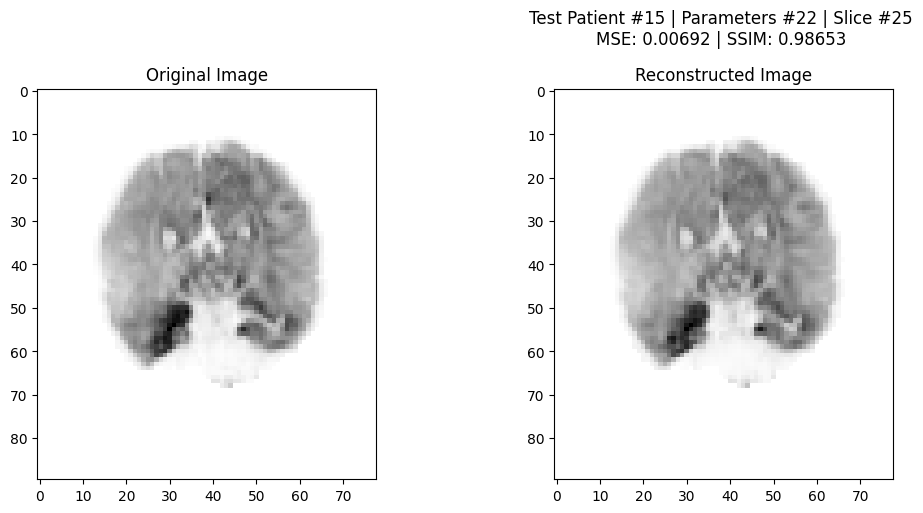

In [299]:
# Interactive Reconstruction Plot Functionality
def recon_plot(
    num_param: int = 0,
    num_slice: int = 0
):

    # Forward Propagation
    target_param = torch.Tensor(recon_set.params.iloc[num_param].values)
    input = torch.cat((X_train, target_param.repeat(len(recon_set.idxv), 1)), dim = 1)
    with torch.no_grad(): model.eval(); X_fake = model(input.to(settings.device)).T
    #loss = criterion(X_fake[0], X.T[num_param])
    img_fake = torch.Tensor(unmask(X_fake, mask).get_fdata().T)
    mse_loss = mse_criterion(X_fake[0], X.T[num_param])
    ssim_loss = ssim_criterion(img_fake, img[list([num_param])])
    
    # Original Training Example Image Subplot
    figure = plt.figure(figsize = (15, 5))
    plt.suptitle(f'Test Patient #{sel_patient} | Parameters #{num_param} | Slice #{num_slice}' +
                 f'\nMSE: {round(mse_loss.item(), 5)} | SSIM: {round(ssim_loss.item(), 5)}\n')
    plt.xticks([]); plt.yticks([]); plt.grid(False); plt.tight_layout()
    
    # Original Image Scan Subplot
    plt.subplot(1, 3, 1, title = 'Original Image')
    plt.imshow(img[num_param, num_slice, :, :], cmap = plt.cm.binary)

    # Reconstructed image Scan Subplot
    plt.subplot(1, 3, 2, title = 'Reconstructed Image')
    plt.imshow(img_fake[0, num_slice, :, :], cmap = plt.cm.binary)

    # MSE Loss Heatmap Subplot
    #plt.subplot(1, 3, 3, title = 'MSE Loss Heatmap')
    #plt.imshow(heatmap[0, num_slice, :, :], cmap = 'hot')
    

# Parameter + Slice Slider Interactive Construction
#param_slider = IntSlider(value = 0, min = 0, max = img.shape[0] - 1, description = 'Parameter', continuous_update = False)
#slice_slider = IntSlider(value = 0, min = 0, max = img.shape[1] - 1, description = 'Slice', continuous_update = False)
#interactive(recon_plot, num_param = param_slider, num_slice = slice_slider)
recon_plot(num_param = 22, num_slice = 25)     #1200

---

# **cglVNN**

### *Conditional Generative Linear Voxel-Wise Neural Network*

---

## **Data** *Reader*

**Major Scale**: A *Training Batch* is repeated only for *num_recon * num_train_params* times

**Medium Scale**: A *Training Parameter* is repeated for *num_recon* times, every *num_train_params* interval

**Minor Scale**: A *Target Parameter* is not repeated, and will happen every *num_recon* interval

In [ ]:
# 1D MUDI Dataset Initialization Class
class MUDI_cglVNN(keras.utils.Sequence):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser,
        subject: int or list,
        training: bool = True
    ):
        
        # Parameter & Patient Index Value Access
        super(MUDI_cglVNN).__init__()
        self.settings = settings

        # Vertical Splitting (Patient Selection)
        self.idxv = pd.read_csv(self.settings.info_filepath,            # List of Index Values ...
                                index_col = 0).to_numpy()               # ... pertaining to each Patient
        self.idxv = self.idxv[np.isin(self.idxv[:, 1], subject), 0]     # Patient-Specific Index Values
        self.idxv_set = np.arange(len(self.idxv))

        # Horizontal Splitting (Parameter Selection)
        idxh_train_filepath = Path(f"{self.settings.datasave_folderpath}/1D Training Labels (V{self.settings.data_version}).txt")    # Filepath for Selected Training Labels
        idxh_val_filepath = Path(f"{self.settings.datasave_folderpath}/1D Validation Labels (V{self.settings.data_version}).txt")    # Filepath for Selected Validation Labels
        self.idxh_train = np.sort(np.loadtxt(idxh_train_filepath)).astype(int); self.num_train_params = len(self.idxh_train)
        self.idxh_val = np.sort(np.loadtxt(idxh_val_filepath)).astype(int); self.num_val_params = len(self.idxh_val)
        assert(self.num_train_params == self.settings.num_train_params), "ERROR: Model wrongly Built!"
        #self.msk = np.logical_not(np.isin(np.arange(1344), self.idxh_train))
        
        # Parameter Value Initialization & Selection
        self.params = pd.read_excel(self.settings.param_filepath)                                       # List of Dataset's Parameters
        self.num_labels = self.settings.num_labels
        if self.settings.gradient_coord:
            self.params = self.params.drop(columns = ['Gradient theta', 'Gradient phi'])                # Choosing of Gradient Orientation
        else: self.params = self.params.drop(columns = ['Gradient x', 'Gradient y', 'Gradient z'])      # from 3D Cartesian or Polar Referential
        assert(self.params.shape[1] == self.num_labels), "ERROR: Labels wrongly Deleted!"
        if self.settings.label_norm:                                                                    # Control Boolean Value for the Normalization of Labels
            self.scaler = StandardScaler()
            self.params = pd.DataFrame( self.scaler.fit_transform(self.params),
                                        columns = self.params.columns)
        
        # Label Normalizer / Scaler Saving
        scaler_filepath = Path(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
        if not scaler_filepath.exists(): torch.save(self.scaler, scaler_filepath)
        
        # Random Selection of Parameters for Training Loop Reconstruction
        if training:
            self.param_recon = self.settings.param_recon_train
            self.batch_size = self.settings.batch_size
        else:
            self.param_recon = self.settings.param_recon_full
            self.batch_size = len(self.idxv)
        self.num_train_recon = int((self.param_recon * self.num_train_params) / 100)
        self.num_val_recon = int((self.param_recon * self.num_val_params) / 100)
        self.num_recon = self.num_train_recon + self.num_val_recon
        #self.batch_size = self.settings.batch_size * self.num_recon
        self.idxh_recon = np.hstack((   self.idxh_train[np.sort(np.random.choice(self.num_train_params,
                                                                self.num_train_recon, replace = False))],
                                        self.idxh_val[np.sort(np.random.choice(self.num_val_params,
                                                                self.num_val_recon, replace = False))]))
    
    # --------------------------------------------------------------------------------------------

    # DataLoader Length / No. Batches Computation Functionality
    def __len__(self): return int(np.ceil(len(self.idxv) / self.batch_size)) * self.num_recon * self.settings.num_train_params

    # Single-Batch Generation Functionality
    def __getitem__(self, idx):

        # Batch Vertical/Patient Indexing
        idxv = int(idx // (self.num_recon * self.settings.num_train_params))
        idxv = self.idxv_set[   idxv * self.batch_size :
                                (idxv + 1) * self.batch_size]
        idxv = [self.idxv[k] for k in idxv]

        # Batch Horizontal/Parameter Indexing
        idxh_train = int((idx // self.num_recon) % self.settings.num_train_params)
        idxh_target = int(idx % self.num_recon)
        input, X_target = self.get_data(idxv, idxh_train, idxh_target)
        return input, X_target
    
    # Label Scaler Download & Reverse Transformation
    def label_unscale(
        self,
        y: np.array or pd.DataFrame
    ):

        # Label Scaler Download & Reverse Usage
        try: self.scaler
        except AttributeError:
            scaler = torch.load(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
        return scaler.inverse_transform(y.reshape(1, -1))

    # --------------------------------------------------------------------------------------------

    # End of Epoch Shuffling Functionality
    def on_epoch_end(self):
        
        # Batch Shuffling
        self.idxv_set = np.arange(len(self.idxv))
        if self.settings.sample_shuffle: np.random.shuffle(self.idxv_set)

        # Reconstruction Parameter Shuffling
        if self.settings.param_shuffle:
            self.idxh_recon = np.hstack((   self.idxh_train[np.sort(np.random.choice(self.num_train_params,
                                            int((self.param_recon * self.num_train_params) / 100), replace = False))],
                                            self.idxh_val[np.sort(np.random.choice(self.num_val_params,
                                            int((self.param_recon * self.num_val_params) / 100), replace = False))]))

    # Batch Data Generation Functionality
    def get_data(self, idxv, idxh_train, idxh_target):

        # Data Access
        data = h5py.File(self.settings.data_filepath, 'r').get('data1')
        X_train = data[idxv, :][:, self.idxh_train[idxh_train]].reshape((len(idxv), 1))                             # [batch_size,  1] Training Data
        y_train = self.params.iloc[self.idxh_train[idxh_train]].values.reshape((1, self.settings.num_labels))       # [1,           num_labels] Training Parameters
        y_target = self.params.iloc[self.idxh_recon[idxh_target]].values.reshape((1, self.settings.num_labels))     # [1,           num_labels] Target Parameters
        y_train = y_train.repeat(len(idxv), 0); y_target = y_target.repeat(len(idxv), 0);                           # [batch_size,  num_labels] Training & Target Parameters
        X_target = data[idxv, :][:, self.idxh_recon[idxh_target]].reshape((len(idxv), 1))                           # [batch_size,  1] GT Target Data
        input = tf.keras.layers.concatenate([X_train, y_train, y_target], axis = 1)                                 # [batch_size,  1 + (2 * num_labels)] Input
        return input, X_target
    
    # Patient Data Generation Functionality
    def get_patient(settings, num_patient: int):

        # Patient Data Access
        data = h5py.File(settings.data_filepath, 'r').get('data1')
        idxv = pd.read_csv( settings.info_filepath,             # List of Index Values ...
                            index_col = 0).to_numpy()           # ... pertaining to each Patient
        idxv = idxv[np.isin(idxv[:, 1], num_patient), 0]        # Patient-Specific Index Values
        X = data[idxv, :]

        # Patient Mask Access
        mask_filepath = Path(f"{settings.mask_folderpath}/p{num_patient}.nii")
        assert(mask_filepath.exists()), f"ERROR: Patient {num_patient}'s Mask not Found!"
        mask = load_img(mask_filepath)
        img = unmask(X.T, mask).get_fdata().T
        return X, mask, img


In [ ]:
# Dataset DataLoader Creation
trainset = MUDI_cglVNN( settings, training = False,
                        subject = [11])
X, mask, img = MUDI_cglVNN.get_patient(settings, 11)
X_fake = model.predict_generator(trainset)

# Build Testing
#for i in range(trainset.num_recon):
#    assert(np.all(trainset.__getitem__(i)[0][:, -5::] == trainset.__getitem__(i + trainset.num_recon)[0][:, -5::])), f"{i}"

## *Model* **Architecture**

In [ ]:
# Fixed Conditional Generative Linear Voxel Net Model Class (Fixed)
class cglVNN(tf.keras.Model):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser
    ):
        
        # Class Variable Logging
        super().__init__(); self.settings = settings
        self.net = Sequential(); self.arch = []
        self.arch.insert(0, 1 + (2 * self.settings.num_labels))

        # Neural Network Architecture Definition
        var_hidden = int((self.settings.top_hidden - self.settings.bottom_hidden) / self.settings.num_hidden)
        for i in range(1, self.settings.num_hidden + 1):
            if i == 1: self.arch.insert(i, self.settings.bottom_hidden * 2)
            else: self.arch.insert(i, int(self.arch[i - 1] * 2))
            self.main_block(self.arch[i], self.arch[i - 1])
        for i in range(self.settings.num_hidden + 1, (2 * self.settings.num_hidden) + 1):
            self.arch.insert(i, int(self.arch[i - 1] / 2))
            self.main_block(self.arch[i], self.arch[i - 1])
        self.net.add(Dense(input_dim = self.settings.bottom_hidden, units = 1))

    # Block Architecture Definition Functionality
    def main_block(self, out_channels: int, in_channels: int = None):
        if in_channels is not None:
            self.net.add(   Dense(  input_dim = in_channels,
                                    units = out_channels))
        else: self.net.add( Dense(  units = out_channels))
        self.net.add(   BatchNormalization())
        self.net.add(   LeakyReLU(  alpha = 0.2))
    
    # --------------------------------------------------------------------------------------------

    # Neural Network Application Function
    def call(
        self,
        input: np.ndarray or tf.Tensor
    ):  return self.net(input)

In [ ]:
# Model Initialization Example
model = cglVNN(settings)
print(model.net.summary())

# Model Usage Example
#X_real = tf.random.uniform([10, 500])
#y_target = tf.random.uniform([10, 5])
trainset = MUDI_cglVNN(settings, subject = [11, 12, 13])
print(model(trainset.__getitem__(0)[0]).shape)

## *Performance* **Callbacks**

In [ ]:
# Reconstruction Callback Class
class ReconCallback(keras.callbacks.Callback):
       
    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser,              # Model Settings & Parametrizations
    ):

        # Class Variable Logging
        super().__init__()
        self.settings = settings; self.criterion = nn.MSELoss()

        # TensorBoard Logger Initialization
        self.train_logger = TensorBoardLogger(f'{self.settings.modelsave_folderpath}/V{self.settings.model_version}', 'train')
        self.val_logger = TensorBoardLogger(f'{self.settings.modelsave_folderpath}/V{self.settings.model_version}', 'validation')

    # --------------------------------------------------------------------------------------------

    # Patient Image Reconstruction Functionality
    def reconstruct(
        self,
        set: MUDI_fcglVNN,                  # Keras MUDI DataLoader
        X: np.ndarray,                      # Selected Patient Data
        mask: nib.nifti1.Nifti1Image,       # Selected Patient's Mask
        img: np.ndarray,                    # Selected Patient Image
        sel_slice: int = 25,                # Selected Reconstruction Slice
        epoch: int = 0                      # Epoch Number
    ):
        
        # Reconstruction Loop from all Training Parameters
        X_fake = self.model.predict_generator(set)

        with alive_bar( self.settings.num_train_params * len(set.idxh_recon),
                        title = f'Epoch {epoch} |' +
                        'Patient Reconstruction Callback',
                        force_tty = True) as progress_bar:
            for idx_train, param_train in enumerate(set.idxh_train):

                # Reconstruction Loop for all Selected Target Parameters
                for idx_target, param_target in range(set.idxh_recon):

                    # Training -> Target Parameter Image Reconstruction
                    X_param = self.model.predict_generator(set.__getitem__())

                    gc.collect(); torch.cuda.empty_cache()
                    time.sleep(0.01); progress_bar()
        

        """
        # Patient Image Reconstruction
        X_fake = self.model.predict_generator(set)
        best_train_loss = torch.ones(1, dtype = torch.float64) * 1000
        worst_train_loss = torch.zeros(1, dtype = torch.float64)
        best_val_loss = torch.ones(1, dtype = torch.float64) * 1000
        worst_val_loss = torch.zeros(1, dtype = torch.float64)
        
        # Voxel Reconstruction Loop for all Selected Target Parameters
        with alive_bar( len(set.idxh_recon),
                        title = f'Epoch {epoch} |' +
                        'Training Patient Reconstruction',
                        force_tty = True) as progress_bar:
            for i, param in enumerate(set.idxh_recon):

                # Selected Target Parameter Image Reconstruction
                X_param = X_fake[np.where(np.arange(len(X_fake)) % set.num_recon == i)[0]]
                X_gt = X[:, param].T.reshape((len(X_param), 1))
                loss = self.criterion(torch.Tensor(X_param), torch.Tensor(X_gt)); del X_gt
                
                # Loss Computation for Training Parameter
                if param in set.idxh_train:
                    if loss < best_train_loss:
                        best_train_loss = loss
                        best_train_idx = param
                        X_train_best = X_param
                    if loss > worst_train_loss:
                        worst_train_loss = loss
                        worst_train_idx = param
                        X_train_worst = X_param

                # Loss Computation for Validation Parameter
                elif param in set.idxh_val:
                    if loss < best_val_loss:
                        best_val_loss = loss
                        best_val_idx = param
                        X_val_best = X_param
                    if loss > worst_val_loss:
                        worst_val_loss = loss
                        worst_val_idx = param
                        X_val_worst = X_param
                
                else: print("ERROR: Reconstruction Parameter not Found!")
                gc.collect(); torch.cuda.empty_cache()
                time.sleep(0.01); progress_bar()
        
        # --------------------------------------------------------------------------------------------

        # Training Image Unmasking of Original & Reconstructed Results
        X_train_best = unmask(X_train_best.T, mask).get_fdata().T
        X_train_worst = unmask(X_train_worst.T, mask).get_fdata().T

        # Training Example Original & Best Reconstructed Image Subplots
        train_figure = plt.figure(figsize = (20, 20))
        plt.xticks([]); plt.yticks([]); plt.grid(False); plt.tight_layout()
        plt.subplot(2, 2, 1, title = f'Target Image (Parameter #{best_train_idx})')
        plt.imshow(img[best_train_idx, sel_slice, :, :], cmap = plt.cm.binary)
        plt.subplot(2, 2, 2, title = f'Best Reconstruction (Parameter #{best_train_idx})')
        plt.imshow(X_train_best[0, sel_slice, :, :], cmap = plt.cm.binary)
        del best_train_idx, X_train_best
        
        # Training Example Original & Worst Reconstructed Image Subplots
        plt.subplot(2, 2, 3, title = f'Target Image (Parameter #{worst_train_idx})')
        plt.imshow(img[worst_train_idx, sel_slice, :, :], cmap = plt.cm.binary)
        plt.subplot(2, 2, 4, title = f'Worst Reconstruction (Parameter #{worst_train_idx})')
        plt.imshow(X_train_worst[0, sel_slice, :, :], cmap = plt.cm.binary)
        del worst_train_idx, X_train_worst

        # --------------------------------------------------------------------------------------------

        # Training Image Unmasking of Original & Reconstructed Results
        X_val_best = unmask(X_val_best.T, mask).get_fdata().T
        X_val_worst = unmask(X_val_worst.T, mask).get_fdata().T

        # Training Example Original & Best Reconstructed Image Subplots
        val_figure = plt.figure(figsize = (20, 20))
        plt.xticks([]); plt.yticks([]); plt.grid(False); plt.tight_layout()
        plt.subplot(2, 2, 1, title = f'Target Image (Parameter #{best_val_idx})')
        plt.imshow(img[best_val_idx, sel_slice, :, :], cmap = plt.cm.binary)
        plt.subplot(2, 2, 2, title = f'Best Reconstruction (Parameter #{best_val_idx})')
        plt.imshow(X_val_best[0, sel_slice, :, :], cmap = plt.cm.binary)
        del best_val_idx, X_val_best
        
        # Training Example Original & Worst Reconstructed Image Subplots
        plt.subplot(2, 2, 3, title = f'Target Image (Parameter #{worst_val_idx})')
        plt.imshow(img[worst_val_idx, sel_slice, :, :], cmap = plt.cm.binary)
        plt.subplot(2, 2, 4, title = f'Worst Reconstruction (Parameter #{worst_val_idx})')
        plt.imshow(X_val_worst[0, sel_slice, :, :], cmap = plt.cm.binary)
        del worst_val_idx, X_val_worst
        return train_figure, best_train_loss, worst_train_loss, val_figure, best_val_loss, worst_val_loss
        """

    # --------------------------------------------------------------------------------------------

    # Functionality called upon the Start of Training
    def on_train_begin(self, logs = None):

        # Example Training Patient Download
        self.trainset = MUDI_cglVNN(self.settings, training = False,
                                    subject = self.settings.sel_train_patient)
        self.X_train, self.mask_train, self.img_train = MUDI_cglVNN.get_patient(self.settings,
                                                                self.settings.sel_train_patient)

        # Example Validation Patient Download
        self.valset = MUDI_cglVNN(  self.settings, training = False,
                                    subject = self.settings.sel_val_patient)
        self.X_val, self.mask_val, self.img_val = MUDI_cglVNN.get_patient(  self.settings,
                                                            self.settings.sel_val_patient)

    # Functionality called upon the End of a Training Epoch
    def on_epoch_end(self, epoch, logs = None):

        # Epoch Update for Losses & Training Image Reconstruction
        tt_plot, tt_best_loss, tt_worst_loss, tv_plot, tv_best_loss, tv_worst_loss = self.reconstruct(  self.trainset, self.X_train,
                                                                                                        self.mask_train, self.img_train,
                                                                                                        sel_slice = 25, epoch = epoch)
        vt_plot, vt_best_loss, vt_worst_loss, vv_plot, vv_best_loss, vv_worst_loss = self.reconstruct(  self.valset, self.X_val,
                                                                                                        self.mask_val, self.img_val,
                                                                                                        sel_slice = 25, epoch = epoch)
        
        # TensorBoard Logger Model Visualizer, Update for Image Visualizer
        self.train_logger.experiment.add_scalar("Best Reconstruction Loss | Training", tt_best_loss, epoch)
        self.train_logger.experiment.add_scalar("Worst Reconstruction Loss | Training", tt_worst_loss, epoch)
        self.train_logger.experiment.add_scalar("Best Reconstruction Loss | Validation", tv_best_loss, epoch)
        self.train_logger.experiment.add_scalar("Worst Reconstruction Loss | Validation", tv_worst_loss, epoch)
        self.train_logger.experiment.add_figure("Training Image Reconstruction", tt_plot, epoch)
        self.train_logger.experiment.add_figure("Validation Image Reconstruction", tv_plot, epoch)

        self.val_logger.experiment.add_scalar("Best Reconstruction Loss | Training", vt_best_loss, epoch)
        self.val_logger.experiment.add_scalar("Worst Reconstruction Loss | Training", vt_worst_loss, epoch)
        self.val_logger.experiment.add_scalar("Best Reconstruction Loss | Validation", vv_best_loss, epoch)
        self.val_logger.experiment.add_scalar("Worst Reconstruction Loss | Validation", vv_worst_loss, epoch)
        self.val_logger.experiment.add_figure("Training Image Reconstruction", vt_plot, epoch)
        self.val_logger.experiment.add_figure("Validation Image Reconstruction", vv_plot, epoch)


---

# **cVNP**

### *Voxel-Wise* Conditional Neural Process

---

## **Keras** *Version*

### **Data** *Reader*

**Major Scale**: A *Training Batch* is repeated only for *num_recon * num_train_params* times

**Medium Scale**: A *Training Parameter* is repeated for *num_recon* times, every *num_train_params* interval

**Minor Scale**: A *Target Parameter* is not repeated, and will happen every *num_recon* interval

In [ ]:
# 1D MUDI Dataset Initialization Class
class MUDI_cVNP(keras.utils.Sequence):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser,
        subject: int or list,
        training: bool = True
    ):
        
        # Parameter & Patient Index Value Access
        super(MUDI_cVNP).__init__()
        self.settings = settings

        # Vertical Splitting (Patient Selection)
        self.idxv = pd.read_csv(self.settings.info_filepath,            # List of Index Values ...
                                index_col = 0).to_numpy()               # ... pertaining to each Patient
        self.idxv = self.idxv[np.isin(self.idxv[:, 1], subject), 0]     # Patient-Specific Index Values
        self.idxv_set = np.arange(len(self.idxv))

        # Horizontal Splitting (Parameter Selection)
        idxh_train_filepath = Path(f"{self.settings.datasave_folderpath}/1D Training Labels (V{self.settings.data_version}).txt")    # Filepath for Selected Training Labels
        idxh_val_filepath = Path(f"{self.settings.datasave_folderpath}/1D Validation Labels (V{self.settings.data_version}).txt")    # Filepath for Selected Validation Labels
        self.idxh_train = np.sort(np.loadtxt(idxh_train_filepath)).astype(int); self.num_train_params = len(self.idxh_train)
        self.idxh_val = np.sort(np.loadtxt(idxh_val_filepath)).astype(int); self.num_val_params = len(self.idxh_val)
        assert(self.num_train_params == self.settings.num_train_params), "ERROR: Model wrongly Built!"
        #self.msk = np.logical_not(np.isin(np.arange(1344), self.idxh_train))
        
        # Parameter Value Initialization & Selection
        self.params = pd.read_excel(self.settings.param_filepath)                                       # List of Dataset's Parameters
        self.num_labels = self.settings.num_labels
        if self.settings.gradient_coord:
            self.params = self.params.drop(columns = ['Gradient theta', 'Gradient phi'])                # Choosing of Gradient Orientation
        else: self.params = self.params.drop(columns = ['Gradient x', 'Gradient y', 'Gradient z'])      # from 3D Cartesian or Polar Referential
        assert(self.params.shape[1] == self.num_labels), "ERROR: Labels wrongly Deleted!"
        if self.settings.label_norm:                                                                    # Control Boolean Value for the Normalization of Labels
            self.scaler = StandardScaler()
            self.params = pd.DataFrame( self.scaler.fit_transform(self.params),
                                        columns = self.params.columns)
        
        # Label Normalizer / Scaler Saving
        scaler_filepath = Path(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
        if not scaler_filepath.exists(): torch.save(self.scaler, scaler_filepath)
        
        # Random Selection of Parameters for Training Loop Reconstruction
        if training:
            self.param_recon = self.settings.param_recon_train
            self.batch_size = self.settings.batch_size
        else:
            self.param_recon = self.settings.param_recon_full
            self.batch_size = len(self.idxv)
        self.num_train_recon = int((self.param_recon * self.num_train_params) / 100)
        self.num_val_recon = int((self.param_recon * self.num_val_params) / 100)
        self.num_recon = self.num_train_recon + self.num_val_recon
        #self.batch_size = self.settings.batch_size * self.num_recon
        self.idxh_recon = np.hstack((   self.idxh_train[np.sort(np.random.choice(self.num_train_params,
                                                                self.num_train_recon, replace = False))],
                                        self.idxh_val[np.sort(np.random.choice(self.num_val_params,
                                                                self.num_val_recon, replace = False))]))
    
    # --------------------------------------------------------------------------------------------

    # DataLoader Length / No. Batches Computation Functionality
    def __len__(self): return int(np.ceil(len(self.idxv) / self.batch_size)) * self.num_recon * self.settings.num_train_params

    # Single-Batch Generation Functionality
    def __getitem__(self, idx):

        # Batch Vertical/Patient Indexing
        idxv = int(idx // (self.num_recon * self.settings.num_train_params))
        idxv = self.idxv_set[   idxv * self.batch_size :
                                (idxv + 1) * self.batch_size]
        idxv = [self.idxv[k] for k in idxv]

        # Batch Horizontal/Parameter Indexing
        idxh_train = int((idx // self.num_recon) % self.settings.num_train_params)
        idxh_target = int(idx % self.num_recon)
        #input, X_target = self.get_data(idxv, idxh_train, idxh_target)
        X_train, y_train, y_target, X_target = self.get_data(idxv, idxh_train, idxh_target)
        return [X_train, y_train, y_target], [X_target]
    
    # Label Scaler Download & Reverse Transformation
    def label_unscale(
        self,
        y: np.array or pd.DataFrame
    ):

        # Label Scaler Download & Reverse Usage
        try: self.scaler
        except AttributeError:
            scaler = torch.load(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
        return scaler.inverse_transform(y.reshape(1, -1))

    # --------------------------------------------------------------------------------------------

    # End of Epoch Shuffling Functionality
    def on_epoch_end(self):
        
        # Batch Shuffling
        self.idxv_set = np.arange(len(self.idxv))
        if self.settings.sample_shuffle: np.random.shuffle(self.idxv_set)

        # Reconstruction Parameter Shuffling
        if self.settings.param_shuffle:
            self.idxh_recon = np.hstack((   self.idxh_train[np.sort(np.random.choice(self.num_train_params,
                                            int((self.param_recon * self.num_train_params) / 100), replace = False))],
                                            self.idxh_val[np.sort(np.random.choice(self.num_val_params,
                                            int((self.param_recon * self.num_val_params) / 100), replace = False))]))

    # Batch Data Generation Functionality
    def get_data(self, idxv, idxh_train, idxh_target):

        # Data Access
        data = h5py.File(self.settings.data_filepath, 'r').get('data1')
        X_train = data[idxv, :][:, self.idxh_train[idxh_train]].reshape((len(idxv), 1))                             # [batch_size,  1] Training Data
        y_train = self.params.iloc[self.idxh_train[idxh_train]].values.reshape((1, self.settings.num_labels))       # [1,           num_labels] Training Parameters
        y_target = self.params.iloc[self.idxh_recon[idxh_target]].values.reshape((1, self.settings.num_labels))     # [1,           num_labels] Target Parameters
        y_train = y_train.repeat(len(idxv), 0); y_target = y_target.repeat(len(idxv), 0);                           # [batch_size,  num_labels] Training & Target Parameters
        X_target = data[idxv, :][:, self.idxh_recon[idxh_target]].reshape((len(idxv), 1))                           # [batch_size,  1] GT Target Data
        #input = tf.keras.layers.concatenate([X_train, y_train, y_target], axis = 1)                                 # [batch_size,  1 + (2 * num_labels)] Input
        #return input, X_target
        return X_train, y_train, y_target, X_target
    
    # Patient Data Generation Functionality
    def get_patient(settings, num_patient: int):

        # Patient Data Access
        data = h5py.File(settings.data_filepath, 'r').get('data1')
        idxv = pd.read_csv( settings.info_filepath,             # List of Index Values ...
                            index_col = 0).to_numpy()           # ... pertaining to each Patient
        idxv = idxv[np.isin(idxv[:, 1], num_patient), 0]        # Patient-Specific Index Values
        X = data[idxv, :]

        # Patient Mask Access
        mask_filepath = Path(f"{settings.mask_folderpath}/p{num_patient}.nii")
        assert(mask_filepath.exists()), f"ERROR: Patient {num_patient}'s Mask not Found!"
        mask = load_img(mask_filepath)
        img = unmask(X.T, mask).get_fdata().T
        return X, mask, img


In [ ]:
# Dataset DataLoader Creation
trainset = MUDI_cVNP(settings, #training = False,
                        subject = [11])
#X, mask, img = MUDI_fcglVNN.get_patient(settings, 11)
#X_fake = model.predict_generator(trainset)

# Build Testing
#for i in range(trainset.num_recon):
#    assert(np.all(trainset.__getitem__(i)[0][:, -5::] == trainset.__getitem__(i + trainset.num_recon)[0][:, -5::])), f"{i}"

### *Model* **Architecture**

In [ ]:
# cVNP Encoder Layer Class
class cVNP_Encoder(tf.keras.layers.Layer):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser,
    ):
        
        # Class Variable Logging
        super().__init__()
        self.settings = settings
        self.encoder = Sequential()

        # Encoder Architecture Definition
        for i in reversed(range(self.settings.num_hidden + 1)):
            if i != 0: out_neuron = int(self.settings.var_hidden / (2 ** (i - 1)))
            if i == self.settings.num_hidden:
                self.encoder.add(Dense(     input_dim = 1 + self.settings.num_labels,
                                            units = out_neuron))
            else:
                self.encoder.add(Dense(     units = out_neuron))
            self.encoder.add(   LeakyReLU(  alpha = 0.2))
    
    # Build Configuration Functionalities
    #def build(self, input_shape): super(cVNP_Encoder, self).build([(6,)])
    #def get_config(self): return super(cVNP_Encoder, self).get_config()

    # Neural Network Application Function
    def call(self, input: tf.Tensor): return self.encoder(input)

    # --------------------------------------------------------------------------------------------


In [ ]:
# Conditional Voxel-Wise Neural Process Model Class
class cVNP(tf.keras.Model):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser,
        #num_labels: int = 5,                    # Number of Training Parameters / Input Channels
        #num_hidden: int = 3,                    # Number of NN Hidden Layers
        #var_hidden: int = 128                   # Deviance / Expansion of Hidden Layers
    ):
        
        # Class Variable Logging
        super().__init__(); self.settings = settings
        self.encoder = cVNP_Encoder(self.settings)
        self.decoder = Sequential()
        self.agregg = Dense(input_dim = self.settings.var_hidden,
                            units = self.settings.var_hidden)

            
        # Decoder Architecture Definition
        for i in range(self.settings.num_hidden + 2):
            if i != 0: out_neuron = int(self.settings.var_hidden / (2 ** (i - 1)))
            if i == self.settings.num_hidden + 1: out_neuron = 1
            if i == 0: self.decoder.add(Dense(  input_dim = self.settings.var_hidden + self.settings.num_labels,
                                                units = self.settings.var_hidden))
            else: self.decoder.add(Dense(       units = out_neuron))
            if i != self.settings.num_hidden + 1:
                self.decoder.add(   LeakyReLU(  alpha = 0.2))
    
    # --------------------------------------------------------------------------------------------

    # Build Configuration Functionalities
    #def build(self, input_shape): super(cVNP, self).build([(1,),
    #    (self.settings.num_labels,), (self.settings.num_labels,)])
    #def get_config(self): return super(cVNP, self).get_config()

    # Neural Network Application Function
    def call(
        self,
        input: list,
        training = None
        #X_train: np.ndarray or tf.Tensor,
        #y_train: np.ndarray or tf.Tensor,
        #y_target: np.ndarray or tf.Tensor
    ):
        
        # Neural Network Feed Forward Process
        X_train, y_train, y_target = input
        print(X_train.shape); print(y_train.shape); print(y_target.shape)
        print(tf.keras.layers.concatenate([X_train, y_train], axis = -1).shape)
        h = self.encoder(tf.keras.layers.concatenate([X_train, y_train], axis = -1))    # Encoded Latent Space Representation
        print(h.shape)
        h = self.agregg(tf.reduce_mean(h, axis = 0, keepdims = True))                   # Encoded Representation Aggregation ...
        print(h.shape)
        h = tf.repeat(h, y_target.shape[0], axis = 0)                                   # ... Repeated for every Target
        print(h.shape)
        out = self.decoder(tf.keras.layers.concatenate([h, y_target], axis = -1))
        print(out.shape)
        return out      # Decoded Output for Target Parameters
    

In [ ]:
# Model Initialization Example
model = cVNP(settings)
#print(model.encoder.summary())

# Data Parameter Access
#X_real = tf.random.uniform([10, 1])
#y_train = tf.random.uniform([10, 5])
#y_target = tf.random.uniform([10, 5])
trainset = MUDI_cVNP(   settings, training = False,
                        subject = [11])
# Model Usage Example
model.compile(  optimizer = Adam(learning_rate = settings.base_lr),
                loss =      'mean_squared_error')
model.fit(  trainset, epochs = 1,
            use_multiprocessing = False)
#X_fake = model.predict(trainset)


### *Performance* **Callbacks**

In [ ]:
# Reconstruction Callback Class
class ReconCallback(keras.callbacks.Callback):
       
    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser,              # Model Settings & Parametrizations
    ):

        # Class Variable Logging
        super().__init__()
        self.settings = settings; self.criterion = nn.MSELoss()

        # TensorBoard Logger Initialization
        self.train_logger = TensorBoardLogger(f'{self.settings.modelsave_folderpath}/V{self.settings.model_version}', 'train')
        self.val_logger = TensorBoardLogger(f'{self.settings.modelsave_folderpath}/V{self.settings.model_version}', 'validation')

    # --------------------------------------------------------------------------------------------

    # Patient Image Reconstruction Functionality
    def reconstruct(
        self,
        set: MUDI_fcglVNN,                  # Keras MUDI DataLoader
        X: np.ndarray,                      # Selected Patient Data
        mask: nib.nifti1.Nifti1Image,       # Selected Patient's Mask
        img: np.ndarray,                    # Selected Patient Image
        sel_slice: int = 25,                # Selected Reconstruction Slice
        epoch: int = 0                      # Epoch Number
    ):
        
        # Reconstruction Loop from all Training Parameters
        with alive_bar( self.settings.num_train_params * len(set.idxh_recon),
                        title = f'Epoch {epoch} |' +
                        'Patient Reconstruction Callback',
                        force_tty = True) as progress_bar:
            for idx_train, param_train in enumerate(set.idxh_train):

                # Reconstruction Loop for all Selected Target Parameters
                for idx_target, param_target in range(set.idxh_recon):

                    # Training -> Target Parameter Image Reconstruction
                    X_param = self.model.predict_generator(set.__getitem__())

                    gc.collect(); torch.cuda.empty_cache()
                    time.sleep(0.01); progress_bar()
        

        """
        # Patient Image Reconstruction
        X_fake = self.model.predict_generator(set)
        best_train_loss = torch.ones(1, dtype = torch.float64) * 1000
        worst_train_loss = torch.zeros(1, dtype = torch.float64)
        best_val_loss = torch.ones(1, dtype = torch.float64) * 1000
        worst_val_loss = torch.zeros(1, dtype = torch.float64)
        
        # Voxel Reconstruction Loop for all Selected Target Parameters
        with alive_bar( len(set.idxh_recon),
                        title = f'Epoch {epoch} |' +
                        'Training Patient Reconstruction',
                        force_tty = True) as progress_bar:
            for i, param in enumerate(set.idxh_recon):

                # Selected Target Parameter Image Reconstruction
                X_param = X_fake[np.where(np.arange(len(X_fake)) % set.num_recon == i)[0]]
                X_gt = X[:, param].T.reshape((len(X_param), 1))
                loss = self.criterion(torch.Tensor(X_param), torch.Tensor(X_gt)); del X_gt
                
                # Loss Computation for Training Parameter
                if param in set.idxh_train:
                    if loss < best_train_loss:
                        best_train_loss = loss
                        best_train_idx = param
                        X_train_best = X_param
                    if loss > worst_train_loss:
                        worst_train_loss = loss
                        worst_train_idx = param
                        X_train_worst = X_param

                # Loss Computation for Validation Parameter
                elif param in set.idxh_val:
                    if loss < best_val_loss:
                        best_val_loss = loss
                        best_val_idx = param
                        X_val_best = X_param
                    if loss > worst_val_loss:
                        worst_val_loss = loss
                        worst_val_idx = param
                        X_val_worst = X_param
                
                else: print("ERROR: Reconstruction Parameter not Found!")
                gc.collect(); torch.cuda.empty_cache()
                time.sleep(0.01); progress_bar()
        
        # --------------------------------------------------------------------------------------------

        # Training Image Unmasking of Original & Reconstructed Results
        X_train_best = unmask(X_train_best.T, mask).get_fdata().T
        X_train_worst = unmask(X_train_worst.T, mask).get_fdata().T

        # Training Example Original & Best Reconstructed Image Subplots
        train_figure = plt.figure(figsize = (20, 20))
        plt.xticks([]); plt.yticks([]); plt.grid(False); plt.tight_layout()
        plt.subplot(2, 2, 1, title = f'Target Image (Parameter #{best_train_idx})')
        plt.imshow(img[best_train_idx, sel_slice, :, :], cmap = plt.cm.binary)
        plt.subplot(2, 2, 2, title = f'Best Reconstruction (Parameter #{best_train_idx})')
        plt.imshow(X_train_best[0, sel_slice, :, :], cmap = plt.cm.binary)
        del best_train_idx, X_train_best
        
        # Training Example Original & Worst Reconstructed Image Subplots
        plt.subplot(2, 2, 3, title = f'Target Image (Parameter #{worst_train_idx})')
        plt.imshow(img[worst_train_idx, sel_slice, :, :], cmap = plt.cm.binary)
        plt.subplot(2, 2, 4, title = f'Worst Reconstruction (Parameter #{worst_train_idx})')
        plt.imshow(X_train_worst[0, sel_slice, :, :], cmap = plt.cm.binary)
        del worst_train_idx, X_train_worst

        # --------------------------------------------------------------------------------------------

        # Training Image Unmasking of Original & Reconstructed Results
        X_val_best = unmask(X_val_best.T, mask).get_fdata().T
        X_val_worst = unmask(X_val_worst.T, mask).get_fdata().T

        # Training Example Original & Best Reconstructed Image Subplots
        val_figure = plt.figure(figsize = (20, 20))
        plt.xticks([]); plt.yticks([]); plt.grid(False); plt.tight_layout()
        plt.subplot(2, 2, 1, title = f'Target Image (Parameter #{best_val_idx})')
        plt.imshow(img[best_val_idx, sel_slice, :, :], cmap = plt.cm.binary)
        plt.subplot(2, 2, 2, title = f'Best Reconstruction (Parameter #{best_val_idx})')
        plt.imshow(X_val_best[0, sel_slice, :, :], cmap = plt.cm.binary)
        del best_val_idx, X_val_best
        
        # Training Example Original & Worst Reconstructed Image Subplots
        plt.subplot(2, 2, 3, title = f'Target Image (Parameter #{worst_val_idx})')
        plt.imshow(img[worst_val_idx, sel_slice, :, :], cmap = plt.cm.binary)
        plt.subplot(2, 2, 4, title = f'Worst Reconstruction (Parameter #{worst_val_idx})')
        plt.imshow(X_val_worst[0, sel_slice, :, :], cmap = plt.cm.binary)
        del worst_val_idx, X_val_worst
        return train_figure, best_train_loss, worst_train_loss, val_figure, best_val_loss, worst_val_loss
        """

    # --------------------------------------------------------------------------------------------

    # Functionality called upon the Start of Training
    def on_train_begin(self, logs = None):

        # Example Training Patient Download
        self.trainset = MUDI_cVNP(  self.settings, training = False,
                                    subject = self.settings.sel_train_patient)
        self.X_train, self.mask_train, self.img_train = MUDI_cVNP.get_patient(  self.settings,
                                                                self.settings.sel_train_patient)

        # Example Validation Patient Download
        self.valset = MUDI_cVNP(    self.settings, training = False,
                                    subject = self.settings.sel_val_patient)
        self.X_val, self.mask_val, self.img_val = MUDI_cVNP.get_patient(    self.settings,
                                                            self.settings.sel_val_patient)

    # Functionality called upon the End of a Training Epoch
    def on_epoch_end(self, epoch, logs = None):

        # Epoch Update for Losses & Training Image Reconstruction
        tt_plot, tt_best_loss, tt_worst_loss, tv_plot, tv_best_loss, tv_worst_loss = self.reconstruct(  self.trainset, self.X_train,
                                                                                                        self.mask_train, self.img_train,
                                                                                                        sel_slice = 25, epoch = epoch)
        vt_plot, vt_best_loss, vt_worst_loss, vv_plot, vv_best_loss, vv_worst_loss = self.reconstruct(  self.valset, self.X_val,
                                                                                                        self.mask_val, self.img_val,
                                                                                                        sel_slice = 25, epoch = epoch)
        
        # TensorBoard Logger Model Visualizer, Update for Image Visualizer
        self.train_logger.experiment.add_scalar("Best Reconstruction Loss | Training", tt_best_loss, epoch)
        self.train_logger.experiment.add_scalar("Worst Reconstruction Loss | Training", tt_worst_loss, epoch)
        self.train_logger.experiment.add_scalar("Best Reconstruction Loss | Validation", tv_best_loss, epoch)
        self.train_logger.experiment.add_scalar("Worst Reconstruction Loss | Validation", tv_worst_loss, epoch)
        self.train_logger.experiment.add_figure("Training Image Reconstruction", tt_plot, epoch)
        self.train_logger.experiment.add_figure("Validation Image Reconstruction", tv_plot, epoch)

        self.val_logger.experiment.add_scalar("Best Reconstruction Loss | Training", vt_best_loss, epoch)
        self.val_logger.experiment.add_scalar("Worst Reconstruction Loss | Training", vt_worst_loss, epoch)
        self.val_logger.experiment.add_scalar("Best Reconstruction Loss | Validation", vv_best_loss, epoch)
        self.val_logger.experiment.add_scalar("Worst Reconstruction Loss | Validation", vv_worst_loss, epoch)
        self.val_logger.experiment.add_figure("Training Image Reconstruction", vt_plot, epoch)
        self.val_logger.experiment.add_figure("Validation Image Reconstruction", vv_plot, epoch)


## **Pytorch** *Version*

### **Data** *Reader*

In [245]:
# cVNP MUDI Dataset Initialization Class (V-2)
class MUDI_cVNP(Dataset):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser,
        subject: int or list,
        param_from: int or float = 100,
        param_to: int or float = 100
    ):
        
        # Parameter & Patient Index Value Access
        super(MUDI_cVNP).__init__()
        self.settings = settings; self.param_from = param_from; self.param_to = param_to
        self.data = h5py.File(self.settings.data_filepath, 'r').get('data1')

        # Vertical Splitting (Patient Selection)
        self.idxv = pd.read_csv(self.settings.info_filepath,            # List of Index Values ...
                                index_col = 0).to_numpy()               # ... pertaining to each Patient
        self.idxv = self.idxv[np.isin(self.idxv[:, 1], subject), 0]     # Patient-Specific Index Values

        # Horizontal Splitting (Parameter Selection)
        idxh_train_filepath = Path(f"{self.settings.datasave_folderpath}" +\
                f"/1D Training Labels (V{self.settings.data_version}).txt")
        idxh_val_filepath = Path(f"{self.settings.datasave_folderpath}" +\
                f"/1D Validation Labels (V{self.settings.data_version}).txt")
        self.idxh_train = np.sort(np.loadtxt(idxh_train_filepath)).astype(int)
        self.idxh_val = np.sort(np.loadtxt(idxh_val_filepath)).astype(int)
        self.num_train_params = len(self.idxh_train); self.num_val_params = len(self.idxh_val)
        assert(self.num_train_params == self.settings.num_train_params), "ERROR: Dataset wrongly Built!"
        #self.msk = np.logical_not(np.isin(np.arange(1344), self.idxh_train))
        
        # Parameter Value Initialization & Selection
        self.params = pd.read_excel(self.settings.param_filepath)                                       # List of Dataset's Parameters
        self.num_labels = self.settings.num_labels
        if self.settings.gradient_coord:
            self.params = self.params.drop(columns = ['Gradient theta', 'Gradient phi'])                # Choosing of Gradient Orientation
        else: self.params = self.params.drop(columns = ['Gradient x', 'Gradient y', 'Gradient z'])      # from 3D Cartesian or Polar Ref.

        # Label Normalization / Scaling
        if self.settings.label_norm == 'auto':
            print("Automatic Normalization of Parameter Values")
            self.scaler = StandardScaler()
            self.params = pd.DataFrame( self.scaler.fit_transform(self.params),
                                        columns = self.params.columns)
            scaler_filepath = Path(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
            if not scaler_filepath.exists(): torch.save(self.scaler, scaler_filepath)
        
        # Label Manual Normalization
        elif self.settings.label_norm == 'manual':
            print("Manual Normalization of Parameter Values")
            self.params[['Gradient theta', 'Gradient phi']] = self.cart2polar(self.params[['Gradient x', 'Gradient y', 'Gradient z']].values)
            self.params = self.params.drop(columns = ['Gradient x', 'Gradient y', 'Gradient z'])
            self.params['b Value'] = self.params['b Value'] / 10000
            self.params['TI'] = self.params['TI'] / 10000
            self.params['TE'] = (self.params['TE'] - 80) / 200
        else: print("No Normalization of Parameter Values")
        assert(self.params.shape[1] == self.num_labels), "ERROR: Labels wrongly Deleted!"

        # Random Selection of Parameters for Training Loop Reconstruction
        self.num_param_from = int((self.param_from * self.num_train_params) / 100)
        self.num_param_to = int((self.param_to * self.num_val_params) / 100)
        self.num_recon = self.num_param_from * self.num_param_to
        self.idxh_from = self.idxh_train[np.sort(np.random.choice(self.num_train_params,
                                                self.num_param_from, replace = False))]
        self.idxh_to = self.idxh_val[np.sort(   np.random.choice(self.num_val_params,
                                                self.num_param_to, replace = False))]

    # --------------------------------------------------------------------------------------------

    # DataLoader Length / No. Batches Computation Functionality
    def __len__(self): return int(len(self.idxv) * self.num_recon)

    # Single-Batch Generation Functionality
    def __getitem__(self, idx) -> tuple[np.ndarray, np.float32]:
        
        # Each Voxel Intensity Value 'X_train' will have its corresponding Training Parameter
        # 'y_train' and be mapped to one of the 'num_param_to' the Target Parameter 'y_target'.
        # This means that each voxel position will see all the 'num_param_from' Parameters in it
        # be mapped to the 'num_param_to' Parameters in the Validation Set

        # [Destination -> Origin -> Voxel] Batch Vertical/Patient & Horizontal/Parameter Indexing
        idxv = idx % len(self.idxv)                                     # Batch's Vertical Index for X_train
        idxh_train = (idx // len(self.idxv)) % self.num_param_from      # Batch's Horizontal Index for y_train
        idxh_target = idx // (len(self.idxv) * self.num_param_from)     # Batch's Horizontal Index for y_target

        # [Voxel -> Origin -> Destination] Batch Vertical/Patient & Horizontal/Parameter Indexing
        #idxv = idx // (self.num_param_from * self.num_param_to)         # Batch's Vertical Index for X_train
        #idxh_train = (idx // self.num_param_to) % self.num_param_from   # Batch's Horizontal Index for y_train
        #idxh_target = idx % self.num_param_to                           # Batch's Horizontal Index for y_target
        #print(f"idxv = {idxv} | idxh_train = {idxh_train} | idxh_target = {idxh_target}")
        
        # Batch Data Generation
        X_train = self.data[self.idxv[idxv], :][self.idxh_from[idxh_train]]     # [    1    ] Training Data
        y_train = self.params.iloc[self.idxh_from[idxh_train]].values           # [num_labels] Training Parameters
        y_target = self.params.iloc[self.idxh_to[idxh_target]].values           # [num_labels] Target Parameters
        X_target = self.data[self.idxv[idxv], :][self.idxh_to[idxh_target]]     # [    1    ] GT Target Data
        #input = np.hstack((X_train, y_target)).astype(np.float32)               # [num_train_params + num_labels] Encoder Input
        return {'X_train': np.array(X_train), 'y_train': y_train,
                'y_target': y_target, 'X_target': np.array(X_target)}
    
    # --------------------------------------------------------------------------------------------

    # End of Epoch Reconstruction Parameter Shuffling Functionality
    def on_epoch_end(
        self,
        idxh_from: np.array = None,
        idxh_to: np.array = None
    ):
        
        # Batch Shuffling
        self.idxv_set = np.arange(len(self.idxv))
        if self.settings.sample_shuffle: np.random.shuffle(self.idxv_set)

        # Origin & Destination Reconstruction Parameter Shuffling
        if self.settings.param_shuffle:
            self.idxh_from = self.idxh_train[np.sort(np.random.choice(self.num_train_params,
                                            self.num_param_from, replace = False))]
            self.idxh_to = self.idxh_val[np.sort(   np.random.choice(self.num_val_params,
                                                    self.num_param_to, replace = False))]
        if idxh_from is not None: self.idxh_from = idxh_from
        if idxh_to is not None: self.idxh_to = idxh_to  
    
    # Label Scaler Download & Reverse Transformation
    def label_unscale(
        self,
        y: np.array or pd.DataFrame
    ):

        # Label Scaler Download & Reverse Usage
        try: self.scaler
        except AttributeError:
            scaler = torch.load(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
        return scaler.inverse_transform(y.reshape(1, -1))

    # Cartesian to Polar Coordinate Conversion Functionality
    def cart2polar(self, y: np.array):

        # Cartesian to Polar Coordinates Conversion
        phi = np.arccos(y[:, 2]).astype(np.float32); theta = np.arctan2(y[:, 1], y[:, 0])
        theta = np.where(theta < 0, 2 * np.pi - np.abs(theta), theta).astype(np.float32)
        theta = np.expand_dims(theta, axis = 1); phi = np.expand_dims(phi, axis = 1)
        return pd.DataFrame(data = np.concatenate((theta, phi), axis = 1),
                            columns = ['Gradient theta', 'Gradient phi'])

    # --------------------------------------------------------------------------------------------
    
    # Patient Data Generation Functionality
    def get_patient(settings, num_patient: int):

        # Patient Data Access
        data = h5py.File(settings.data_filepath, 'r').get('data1')
        idxv = pd.read_csv( settings.info_filepath,             # List of Index Values ...
                            index_col = 0).to_numpy()           # ... pertaining to each Patient
        idxv = idxv[np.isin(idxv[:, 1], num_patient), 0]        # Patient-Specific Index Values
        X = torch.Tensor(data[idxv, :])

        # Patient Mask Access
        mask = MUDI_fcglVNN.get_mask(settings, num_patient = num_patient)
        img = unmask(X.T, mask).get_fdata().T
        return X, mask, torch.Tensor(img)

    # Patient Mask Retrieval Functionality
    def get_mask(settings, num_patient: int):
        mask_filepath = Path(f"{settings.mask_folderpath}/p{num_patient}.nii")
        assert(mask_filepath.exists()), f"ERROR: Patient {num_patient}'s Mask not Found!"
        #return torch.Tensor(np.array(load_img(mask_filepath).dataobj, dtype = np.float32))
        return load_img(mask_filepath)
    

In [834]:
# cVNP MUDI Dataset Initialization Class (V0)
class MUDI_cVNP(Dataset):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser,
        subject: int or list,
        mode: str = 'Target',
        source_param: int or float = 100,
        target_param: int or float = 100,
        target_voxel: int or float = 100
    ):
        
        # Parameter & Patient Index Value Access
        super(MUDI_cVNP).__init__()
        self.settings = settings; self.source_param = source_param
        self.target_param = target_param; self.target_voxel = target_voxel
        self.data = h5py.File(self.settings.data_filepath, 'r').get('data1')
        self.params = pd.read_excel(self.settings.param_filepath)

        # Vertical Splitting (Patient Selection)
        self.idxv = pd.read_csv(self.settings.info_filepath,            # List of Index Values ...
                                index_col = 0).to_numpy()               # ... pertaining to each Patient
        self.idxv = self.idxv[np.isin(self.idxv[:, 1], subject), 0]     # Patient-Specific Index Values

        # Horizontal Splitting (Parameter Selection)
        idxh_source_filepath = Path(f"{self.settings.datasave_folderpath}/Training Labels (V{self.settings.data_version}).txt")
        idxh_target_filepath = Path(f"{self.settings.datasave_folderpath}/{mode} Labels (V{self.settings.data_version}).txt")
        self.idxh_source_base = np.sort(np.loadtxt(idxh_source_filepath)).astype(int)
        if not idxh_target_filepath.exists(): self.label_gen()
        self.idxh_target_base = np.sort(np.loadtxt(idxh_target_filepath)).astype(int)

        # Vertical & Horizontal Sub-Sectioning & Shuffling
        self.h_source = int((self.source_param * len(self.idxh_source_base)) / 100)
        self.h_target = int((self.target_param * len(self.idxh_target_base)) / 100)
        self.v_target = int((self.target_voxel * len(self.idxv)) / 100); self.shuffle(init = True)
        print(f"     > Utilizing {self.h_source} \ {len(self.idxh_source_base)} of the Training Parameters")
        print(f"     > Utilizing {self.h_target} \ {len(self.idxh_target_base)} of the Target Parameters")
        print(f"     > Utilizing {self.v_target} \ {len(self.idxv)} of the Training Voxels")

        # Parameter Selection & Value Normalization / Scaling
        if self.settings.gradient_coord:
            self.params = self.params.drop(columns = ['Gradient theta', 'Gradient phi'])
        else: self.params = self.params.drop(columns = ['Gradient x', 'Gradient y', 'Gradient z'])
        if self.settings.label_norm == 'auto':
            print(f"     > Automatic Normalization of all {self.settings.num_labels} Parameter Values")
            self.scaler = StandardScaler()
            self.params = pd.DataFrame( self.scaler.fit_transform(self.params),
                                        columns = self.params.columns)
            scaler_filepath = Path(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
            if not scaler_filepath.exists(): torch.save(self.scaler, scaler_filepath)
        elif self.settings.label_norm == 'manual':
            print(f"     > Manual Normalization of all {self.settings.num_labels} Parameter Values")
            self.params[['Gradient theta', 'Gradient phi']] = self.cart2polar(self.params[['Gradient x', 'Gradient y', 'Gradient z']].values)
            self.params = self.params.drop(columns = ['Gradient x', 'Gradient y', 'Gradient z'])
            self.params['b Value'] = self.params['b Value'] / 10000
            self.params['TI'] = self.params['TI'] / 10000
            self.params['TE'] = (self.params['TE'] - 80) / 200
        else: print(f"     > No Normalization of all {self.settings.num_labels} Parameter Values")
        assert(self.params.shape[1] == self.settings.num_labels), "ERROR: Labels wrongly Deleted!"
    
    # --------------------------------------------------------------------------------------------

    # DataLoader Length / No. Batches Computation Functionality
    def __len__(self): return self.v_target * self.h_source * self.h_target

    # Single-Batch Generation Functionality
    def __getitem__(self, idx) -> tuple[np.ndarray, np.float32]:

        # Each Voxel Intensity Value 'X_train' will have its corresponding Training Parameter
        # 'y_train' and be mapped to one of the 'num_param_to' the Target Parameter 'y_target'.
        # This means that each voxel position will see all the 'num_param_from' Parameters in it
        # be mapped to the 'num_param_to' Parameters in the Validation Set

        # The order goes from a Minor to a Major Scale, meaning it will use all Voxels of the same Image
        # cosecutively, and then select one Target Parameter to map to, and iterate through all Source
        # Parameters, only changing the Target when these all these are exhausted

        # [Destination -> Origin -> Voxel] Batch Vertical/Patient & Horizontal/Parameter Indexing
        idxv = idx % self.v_target                               # Batch's Vertical Index for X_train
        idxh_source = (idx // self.v_target) % self.h_source     # Batch's Horizontal Index for y_train
        idxh_target = idx // (self.v_target * self.h_source)     # Batch's Horizontal Index for y_target
        
        # Batch Data Generation
        X_train = self.data[self.idxv_target[idxv], :][self.idxh_source[idxh_source]]       # [    1    ] Training Data
        y_train = self.params.iloc[self.idxh_source[idxh_source]].values                    # [num_labels] Training Parameters
        y_target = self.params.iloc[self.idxh_target[idxh_target]].values                   # [num_labels] Target Parameters
        X_target = self.data[self.idxv_target[idxv], :][self.idxh_target[idxh_target]]      # [    1    ] GT Target Data
        return {'X_train': np.array(X_train),
                'X_target': np.array(X_target),
                'idxv': self.idxv_target[idxv],
                'y_train': y_train.astype(np.float32),
                'param_source': self.idxh_source[idxh_source],
                'idxh_source': idxh_source,
                'y_target': y_target.astype(np.float32),
                'param_target': self.idxh_target[idxh_target],
                'idxh_target': idxh_target}
    
    # --------------------------------------------------------------------------------------------

    # Source Parameter Shuffling Functionality (tbu at Epoch's Beggining)
    def source_param_shuffle(
        self,
        init: bool = False,
        idxh_source: np.array = None
    ):
        if idxh_source is not None: self.idxh_source = idxh_source
        else:
            if self.settings.param_shuffle or init:
                self.idxh_source = self.idxh_source_base[   np.sort(np.random.choice(len(self.idxh_source_base),
                                                            self.h_source, replace = False))]
                
    # Target Parameter Shuffling Functionality (tbu at Epoch's Beggining)
    def target_param_shuffle(
        self,
        init: bool = False,
        idxh_target: np.array = None
    ):
        if idxh_target is not None: self.idxh_target = idxh_target
        else:
            if self.settings.param_shuffle or init:
                self.idxh_target = self.idxh_target_base[   np.sort(np.random.choice(len(self.idxh_target_base),
                                                            self.h_target, replace = False))]
                
    # Target Voxel Shuffling Functionality (tbu at Epoch's Beggining)
    def voxel_shuffle(
        self,
        init: bool = False,
        idxv_target: np.array = None
    ):  
        if idxv_target is not None: self.idxv_target = idxv_target
        else:
            if self.settings.voxel_shuffle or init:
                self.idxv_target = self.idxv[   np.sort(np.random.choice(len(self.idxv),
                                                self.v_target, replace = False))]
    
    # All Selected Voxel & Parameter Shuffling Functionality (tbu at Epoch's Beggining)
    def shuffle(
        self,
        init: bool = False,
        idxh_source: np.array = None,
        idxh_target: np.array = None,
        idxv_target: np.array = None
    ):
        self.source_param_shuffle(init, idxh_source)
        self.target_param_shuffle(init, idxh_target)
        self.voxel_shuffle(init, idxv_target)

    # --------------------------------------------------------------------------------------------

    # Random Target Parameter for Training & Test Sets Generation Functionality
    def label_gen(self):

        # Target & Test Label Index File Generation
        idxh_train = np.delete(np.arange(self.params.shape[0]), self.idxh_train)
        if self.settings.test_target_param != 0:
            idxh_test = idxh_train[np.sort(np.random.choice(len(idxh_train),
                                    self.settings.test_target_param, replace = False))]
            idxh_train = np.delete(idxh_train, np.where(np.in1d(idxh_train, idxh_test)))
            for i in range(settings.test_target_param): assert(idxh_test[i] not in idxh_train
                ), f"ERROR: Target Parameter #{i} for Training & Test Sets not mutually Exclusive"
            
            # Target & Test Label Index File Saving
            print(f">     Saving File Target Parameters for Training ({len(idxh_train)}) & Test {len(idxh_test)} Set's")
            np.savetxt(Path(f"{self.settings.datasave_folderpath}/Test Labels (V{self.settings.data_version}).txt"), idxh_test)
            np.savetxt(Path(f"{self.settings.datasave_folderpath}/Target Labels (V{self.settings.data_version}).txt"), idxh_train)
 
    # Label Scaler Download & Reverse Transformation
    def label_unscale(
        self,
        y: np.array or pd.DataFrame
    ):

        # Label Scaler Download & Reverse Usage
        try: self.scaler
        except AttributeError:
            scaler = torch.load(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
        return scaler.inverse_transform(y.reshape(1, -1))

    # Cartesian to Polar Coordinate Conversion Functionality
    def cart2polar(self, y: np.array):

        # Cartesian to Polar Coordinates Conversion
        phi = np.arccos(y[:, 2]).astype(np.float32); theta = np.arctan2(y[:, 1], y[:, 0])
        theta = np.where(theta < 0, 2 * np.pi - np.abs(theta), theta).astype(np.float32)
        theta = np.expand_dims(theta, axis = 1); phi = np.expand_dims(phi, axis = 1)
        return pd.DataFrame(data = np.concatenate((theta, phi), axis = 1),
                            columns = ['Gradient theta', 'Gradient phi'])

    # --------------------------------------------------------------------------------------------
    
    # Patient Data Generation Functionality
    def get_img(settings, num_patient: int):

        # Patient Data Access
        data = h5py.File(settings.data_filepath, 'r').get('data1')
        idxv = pd.read_csv( settings.info_filepath,             # List of Index Values ...
                            index_col = 0).to_numpy()           # ... pertaining to each Patient
        idxv = idxv[np.isin(idxv[:, 1], num_patient), 0]        # Patient-Specific Index Values
        X = torch.Tensor(data[idxv, :])

        # Patient Mask Access
        mask = MUDI_fcglVNN.get_mask(settings, num_patient = num_patient)
        img = unmask(X.T, mask).get_fdata().T
        return torch.Tensor(img)

    # Patient Mask Retrieval Functionality
    def get_mask(settings, num_patient: int):
        mask_filepath = Path(f"{settings.mask_folderpath}/p{num_patient}.nii")
        assert(mask_filepath.exists()), f"ERROR: Patient {num_patient}'s Mask not Found!"
        #return torch.Tensor(np.array(load_img(mask_filepath).dataobj, dtype = np.float32))
        return load_img(mask_filepath)


In [71]:
# cVNP MUDI Dataset Initialization Class (V1)
class MUDI_cVNP(Dataset):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser,
        subject: int or list,
        mode: str = 'Target',
        source_param: int or float = 100,
        target_param: int or float = 100,
        target_voxel: int or float = 100,
        sample_size: int = 0,
    ):
        
        # Parameter & Patient Index Value Access
        super(MUDI_cVNP).__init__()
        self.settings = settings; self.source_param = source_param
        self.target_param = target_param; self.target_voxel = target_voxel
        self.data = h5py.File(self.settings.data_filepath, 'r').get('data1')
        self.params = pd.read_excel(self.settings.param_filepath)

        # Vertical Splitting (Patient Selection)
        self.idxv = pd.read_csv(self.settings.info_filepath,            # List of Index Values ...
                                index_col = 0).to_numpy()               # ... pertaining to each Patient
        self.idxv = self.idxv[np.isin(self.idxv[:, 1], subject), 0]     # Patient-Specific Index Values

        # Horizontal Splitting (Parameter Selection)
        idxh_source_filepath = Path(f"{self.settings.datasave_folderpath}/Training Labels (V{self.settings.data_version}).txt")
        idxh_target_filepath = Path(f"{self.settings.datasave_folderpath}/{mode} Labels (V{self.settings.data_version}).txt")
        self.idxh_source_base = np.sort(np.loadtxt(idxh_source_filepath)).astype(int)
        if not idxh_target_filepath.exists(): self.label_gen()
        self.idxh_target_base = np.sort(np.loadtxt(idxh_target_filepath)).astype(int)

        # Vertical & Horizontal Sub-Sectioning & Shuffling
        self.h_source = int((self.source_param * len(self.idxh_source_base)) / 100)
        print(f"     > Utilizing {self.h_source} \ {len(self.idxh_source_base)} of the Training Parameters")
        self.h_target = int((self.target_param * len(self.idxh_target_base)) / 100)
        print(f"     > Utilizing {self.h_target} \ {len(self.idxh_target_base)} of the Target Parameters")
        self.v_target = int((self.target_voxel * len(self.idxv)) / 100); self.shuffle(init = True)
        
        # Voxel Grouping Functionality (for Loader Step Reduction)
        # https://discuss.pytorch.org/t/data-loader-process-killed/120181
        if sample_size == 0: self.sample_size = self.v_target               # Automatic Sample Grouping Size 
        else: self.sample_size = sample_size
        print(f"     > Utilizing {self.v_target} \ {len(self.idxv)} of the Training Samples in Groupings of {self.sample_size}")
        self.g_target = int(np.ceil(self.v_target / self.sample_size))      # Number of Sample Groupings in a Full Image

        # Parameter Selection & Value Normalization / Scaling
        if self.settings.gradient_coord:
            self.params = self.params.drop(columns = ['Gradient theta', 'Gradient phi'])
        else: self.params = self.params.drop(columns = ['Gradient x', 'Gradient y', 'Gradient z'])
        if self.settings.label_norm == 'auto':
            print(f"     > Automatic Normalization of all {self.settings.num_labels} Parameter Values")
            self.scaler = StandardScaler()
            self.params = pd.DataFrame( self.scaler.fit_transform(self.params),
                                        columns = self.params.columns)
            scaler_filepath = Path(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
            if not scaler_filepath.exists(): torch.save(self.scaler, scaler_filepath)
        elif self.settings.label_norm == 'manual':
            print(f"     > Manual Normalization of all {self.settings.num_labels} Parameter Values")
            self.params[['Gradient theta', 'Gradient phi']] = self.cart2polar(self.params[['Gradient x', 'Gradient y', 'Gradient z']].values)
            self.params = self.params.drop(columns = ['Gradient x', 'Gradient y', 'Gradient z'])
            self.params['b Value'] = self.params['b Value'] / 10000
            self.params['TI'] = self.params['TI'] / 10000
            self.params['TE'] = (self.params['TE'] - 80) / 200
        else: print(f"     > No Normalization of all {self.settings.num_labels} Parameter Values")
        assert(self.params.shape[1] == self.settings.num_labels), "ERROR: Labels wrongly Deleted!"
    
    # --------------------------------------------------------------------------------------------

    # DataLoader Length / No. Batches Computation Functionality
    def __len__(self): return int(self.g_target * self.h_source * self.h_target)

    # Single-Batch Generation Functionality
    def __getitem__(self, idx) -> tuple[np.ndarray, np.float32]:

        # Each Voxel Intensity Value 'X_train' will have its corresponding Training Parameter
        # 'y_train' and be mapped to one of the 'num_param_to' the Target Parameter 'y_target'.
        # This means that each voxel position will see all the 'num_param_from' Parameters in it
        # be mapped to the 'num_param_to' Parameters in the Validation Set

        # The order goes from a Minor to a Major Scale, meaning it will use all Voxels of the same Image
        # consecutively, and then select one Target Parameter to map to, and iterate through all Source
        # Parameters, only changing the Target when these all these are exhausted

        # [Destination -> Origin -> Voxel] Batch Vertical/Patient & Horizontal/Parameter Indexing
        idxg = idx % self.g_target                                      # Batch's Sample Grouping Index
        idxh_source = (idx // self.g_target) % self.h_source            # Batch's Horizontal Index for y_train
        idxh_target = idx // (self.g_target * self.h_source)            # Batch's Horizontal Index for y_target
        if idxg == self.g_target - 1: idxv = self.idxv_target[idxg * self.sample_size ::]
        else: idxv = self.idxv_target[idxg * self.sample_size : (idxg + 1) * self.sample_size]

        # Batch Data Generation
        X_train = self.data[idxv, :][:, self.idxh_source[idxh_source]]          # [    1                   ] Training Data
        y_train = self.params.iloc[self.idxh_source[idxh_source]].values        # [num_labels              ] Training Parameters
        y_train = np.repeat(y_train.reshape(1, -1), len(idxv), axis = 0)        # [num_labels * sample_size] Training Parameters
        y_target = self.params.iloc[self.idxh_target[idxh_target]].values       # [num_labels              ] Target Parameters
        y_target = np.repeat(y_target.reshape(1, -1), len(idxv), axis = 0)      # [num_labels * sample_size] Target Parameters
        X_target = self.data[idxv, :][:, self.idxh_target[idxh_target]]         # [    1                   ] GT Target Data
        return {'X_train': np.array(X_train),
                'X_target': np.array(X_target),
                'idxv': idxv, 'idxg': idxg, 'g_size': len(idxv),
                'y_train': np.ravel(y_train).astype(np.float32),
                'param_source': self.idxh_source[idxh_source],
                'idxh_source': idxh_source,
                'y_target': np.ravel(y_target).astype(np.float32),
                'param_target': self.idxh_target[idxh_target],
                'idxh_target': idxh_target}
    
    # --------------------------------------------------------------------------------------------

    # Source Parameter Shuffling Functionality (tbu at Epoch's Beggining)
    def source_param_shuffle(
        self,
        init: bool = False,
        idxh_source: np.array = None
    ):
        if idxh_source is not None: self.idxh_source = idxh_source
        else:
            if self.settings.param_shuffle or init:
                self.idxh_source = self.idxh_source_base[   np.sort(np.random.choice(len(self.idxh_source_base),
                                                            self.h_source, replace = False))]
                
    # Target Parameter Shuffling Functionality (tbu at Epoch's Beggining)
    def target_param_shuffle(
        self,
        init: bool = False,
        idxh_target: np.array = None
    ):
        if idxh_target is not None: self.idxh_target = idxh_target
        else:
            if self.settings.param_shuffle or init:
                self.idxh_target = self.idxh_target_base[   np.sort(np.random.choice(len(self.idxh_target_base),
                                                            self.h_target, replace = False))]
                
    # Target Voxel Shuffling Functionality (tbu at Epoch's Beggining)
    def voxel_shuffle(
        self,
        init: bool = False,
        idxv_target: np.array = None
    ):  
        if idxv_target is not None: self.idxv_target = idxv_target
        else:
            if self.settings.voxel_shuffle or init:
                self.idxv_target = self.idxv[   np.sort(np.random.choice(len(self.idxv),
                                                self.v_target, replace = False))]
    
    # All Selected Voxel & Parameter Shuffling Functionality (tbu at Epoch's Beggining)
    def shuffle(
        self,
        init: bool = False,
        idxh_source: np.array = None,
        idxh_target: np.array = None,
        idxv_target: np.array = None
    ):
        self.source_param_shuffle(init, idxh_source)
        self.target_param_shuffle(init, idxh_target)
        self.voxel_shuffle(init, idxv_target)

    # --------------------------------------------------------------------------------------------

    # Random Target Parameter for Training & Test Sets Generation Functionality
    def label_gen(self):

        # Target & Test Label Index File Generation
        idxh_train = np.delete(np.arange(self.params.shape[0]), self.idxh_train)
        if self.settings.test_target_param != 0:
            idxh_test = idxh_train[np.sort(np.random.choice(len(idxh_train),
                                    self.settings.test_target_param, replace = False))]
            idxh_train = np.delete(idxh_train, np.where(np.in1d(idxh_train, idxh_test)))
            for i in range(self.settings.test_target_param): assert(idxh_test[i] not in idxh_train
                ), f"ERROR: Target Parameter #{i} for Training & Test Sets not mutually Exclusive"
            
            # Target & Test Label Index File Saving
            print(f">     Saving File Target Parameters for Training ({len(idxh_train)}) & Test {len(idxh_test)} Set's")
            np.savetxt(Path(f"{self.settings.datasave_folderpath}/Test Labels (V{self.settings.data_version}).txt"), idxh_test)
            np.savetxt(Path(f"{self.settings.datasave_folderpath}/Target Labels (V{self.settings.data_version}).txt"), idxh_train)
 
    # Label Scaler Download & Reverse Transformation
    def label_unscale(
        self,
        y: np.array or pd.DataFrame
    ):

        # Label Scaler Download & Reverse Usage
        try: self.scaler
        except AttributeError:
            scaler = torch.load(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
        return scaler.inverse_transform(y.reshape(1, -1))

    # Cartesian to Polar Coordinate Conversion Functionality
    def cart2polar(self, y: np.array):

        # Cartesian to Polar Coordinates Conversion
        phi = np.arccos(y[:, 2]).astype(np.float32); theta = np.arctan2(y[:, 1], y[:, 0])
        theta = np.where(theta < 0, 2 * np.pi - np.abs(theta), theta).astype(np.float32)
        theta = np.expand_dims(theta, axis = 1); phi = np.expand_dims(phi, axis = 1)
        return pd.DataFrame(data = np.concatenate((theta, phi), axis = 1),
                            columns = ['Gradient theta', 'Gradient phi'])

    # --------------------------------------------------------------------------------------------
    
    # Patient Data Generation Functionality
    def get_img(settings, num_patient: int):

        # Patient Data Access
        data = h5py.File(settings.data_filepath, 'r').get('data1')
        idxv = pd.read_csv( settings.info_filepath,             # List of Index Values ...
                            index_col = 0).to_numpy()           # ... pertaining to each Patient
        idxv = idxv[np.isin(idxv[:, 1], num_patient), 0]        # Patient-Specific Index Values
        X = torch.Tensor(data[idxv, :])

        # Patient Mask Access
        mask = MUDI_cVNP.get_mask(settings, num_patient = num_patient)
        img = unmask(X.T, mask).get_fdata().T
        return torch.Tensor(img)

    # Patient Mask Retrieval Functionality
    def get_mask(settings, num_patient: int):
        mask_filepath = Path(f"{settings.mask_folderpath}/p{num_patient}.nii")
        assert(mask_filepath.exists()), f"ERROR: Patient {num_patient}'s Mask not Found!"
        #return torch.Tensor(np.array(load_img(mask_filepath).dataobj, dtype = np.float32))
        return load_img(mask_filepath)


In [951]:
# cVNP MUDI Dataset Initialization Class (Random)
class MUDI_cVNP(Dataset):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser,
        subject: int or list,
        mode: str = 'Target',
        source_param: int or float = 100,
        target_param: int or float = 100,
        target_voxel: int or float = 100,
        param_loop: int or float = 100
    ):
        
        # Parameter & Patient Index Value Access
        super(MUDI_cVNP).__init__()
        self.settings = settings; self.source_param = source_param
        self.target_param = target_param; self.target_voxel = target_voxel
        self.data = h5py.File(self.settings.data_filepath, 'r').get('data1')
        self.params = pd.read_excel(self.settings.param_filepath)

        # Vertical Splitting (Patient Selection)
        self.idxv = pd.read_csv(self.settings.info_filepath,            # List of Index Values ...
                                index_col = 0).to_numpy()               # ... pertaining to each Patient
        self.idxv = self.idxv[np.isin(self.idxv[:, 1], subject), 0]     # Patient-Specific Index Values

        # Horizontal Splitting (Parameter Selection)
        idxh_source_filepath = Path(f"{self.settings.datasave_folderpath}/Training Labels (V{self.settings.data_version}).txt")
        idxh_target_filepath = Path(f"{self.settings.datasave_folderpath}/{mode} Labels (V{self.settings.data_version}).txt")
        self.idxh_source_base = np.sort(np.loadtxt(idxh_source_filepath)).astype(int)
        if not idxh_target_filepath.exists(): self.label_gen()
        self.idxh_target_base = np.sort(np.loadtxt(idxh_target_filepath)).astype(int)

        # Vertical & Horizontal Sub-Sectioning & Shuffling
        self.h_source = int((self.source_param * len(self.idxh_source_base)) / 100)
        self.h_target = int((self.target_param * len(self.idxh_target_base)) / 100)
        self.v_target = int((self.target_voxel * len(self.idxv)) / 100); self.shuffle(init = True)
        self.num_loop = int((param_loop * (self.h_source * self.h_target)) / 100)
        print(f"     > Utilizing {self.h_source} \ {len(self.idxh_source_base)} of the Training Parameters")
        print(f"     > Utilizing {self.h_target} \ {len(self.idxh_target_base)} of the Target Parameters")
        print(f"     > Utilizing {self.v_target} \ {len(self.idxv)} of the Training Voxels")
        print(f"     > Looping through {self.num_loop} of the the Possible {self.h_source * self.h_target} Source/Target Parameter Combos")

        # Parameter Selection & Value Normalization / Scaling
        if self.settings.gradient_coord:
            self.params = self.params.drop(columns = ['Gradient theta', 'Gradient phi'])
        else: self.params = self.params.drop(columns = ['Gradient x', 'Gradient y', 'Gradient z'])
        if self.settings.label_norm == 'auto':
            print(f"     > Automatic Normalization of all {self.settings.num_labels} Parameter Values")
            self.scaler = StandardScaler()
            self.params = pd.DataFrame( self.scaler.fit_transform(self.params),
                                        columns = self.params.columns)
            scaler_filepath = Path(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
            if not scaler_filepath.exists(): torch.save(self.scaler, scaler_filepath)
        elif self.settings.label_norm == 'manual':
            print(f"     > Manual Normalization of all {self.settings.num_labels} Parameter Values")
            self.params[['Gradient theta', 'Gradient phi']] = self.cart2polar(self.params[['Gradient x', 'Gradient y', 'Gradient z']].values)
            self.params = self.params.drop(columns = ['Gradient x', 'Gradient y', 'Gradient z'])
            self.params['b Value'] = self.params['b Value'] / 10000
            self.params['TI'] = self.params['TI'] / 10000
            self.params['TE'] = (self.params['TE'] - 80) / 200
        else: print(f"     > No Normalization of all {self.settings.num_labels} Parameter Values")
        assert(self.params.shape[1] == self.settings.num_labels), "ERROR: Labels wrongly Deleted!"
    
    # --------------------------------------------------------------------------------------------

    # DataLoader Length / No. Batches Computation Functionality
    def __len__(self): return self.v_target * self.num_loop

    # Single-Batch Generation Functionality
    def __getitem__(self, idx) -> tuple[np.ndarray, np.float32]:

        # Each Voxel Intensity Value 'X_train' will have its corresponding Training Parameter
        # 'y_train' and be mapped to one of the 'num_param_to' the Target Parameter 'y_target'.
        # This means that each voxel position will see all the 'num_param_from' Parameters in it
        # be mapped to the 'num_param_to' Parameters in the Validation Set

        # The order goes from a Minor to a Major Scale, meaning it will use all Voxels of the same Image
        # cosecutively, and then select one Target Parameter to map to, and iterate through all Source
        # Parameters, only changing the Target when these all these are exhausted

        # [Destination -> Origin -> Voxel] Batch Vertical/Patient & Horizontal/Parameter Indexing
        idxv = idx % self.v_target                                  # Batch's Vertical Index for X_train
        idxh_loop = (idx // self.v_target) % self.num_loop          # Batch's Horizontal Index for Loop Combo
        idxh_source = random.randrange(self.h_source)               # Batch's Horizontal Index for y_train
        idxh_target = random.randrange(self.h_target)               # Batch's Horizontal Index for y_target
        
        # Batch Data Generation
        X_train = self.data[self.idxv_target[idxv], :][self.idxh_source[idxh_source]]       # [    1    ] Training Data
        y_train = self.params.iloc[self.idxh_source[idxh_source]].values                    # [num_labels] Training Parameters
        y_target = self.params.iloc[self.idxh_target[idxh_target]].values                   # [num_labels] Target Parameters
        X_target = self.data[self.idxv_target[idxv], :][self.idxh_target[idxh_target]]      # [    1    ] GT Target Data
        return {'X_train': np.array(X_train),
                'X_target': np.array(X_target),
                'idxv': self.idxv_target[idxv],
                'idxh_loop': idxh_loop,
                'y_train': y_train.astype(np.float32),
                'param_source': self.idxh_source[idxh_source],
                'idxh_source': idxh_source,
                'y_target': y_target.astype(np.float32),
                'param_target': self.idxh_target[idxh_target],
                'idxh_target': idxh_target}
    
    # --------------------------------------------------------------------------------------------

    # Source Parameter Shuffling Functionality (tbu at Epoch's Beggining)
    def source_param_shuffle(
        self,
        init: bool = False,
        idxh_source: np.array = None
    ):
        if idxh_source is not None: self.idxh_source = idxh_source
        else:
            if self.settings.param_shuffle or init:
                self.idxh_source = self.idxh_source_base[   np.sort(np.random.choice(len(self.idxh_source_base),
                                                            self.h_source, replace = False))]
                
    # Target Parameter Shuffling Functionality (tbu at Epoch's Beggining)
    def target_param_shuffle(
        self,
        init: bool = False,
        idxh_target: np.array = None
    ):
        if idxh_target is not None: self.idxh_target = idxh_target
        else:
            if self.settings.param_shuffle or init:
                self.idxh_target = self.idxh_target_base[   np.sort(np.random.choice(len(self.idxh_target_base),
                                                            self.h_target, replace = False))]
                
    # Target Voxel Shuffling Functionality (tbu at Epoch's Beggining)
    def voxel_shuffle(
        self,
        init: bool = False,
        idxv_target: np.array = None
    ):  
        if idxv_target is not None: self.idxv_target = idxv_target
        else:
            if self.settings.voxel_shuffle or init:
                self.idxv_target = self.idxv[   np.sort(np.random.choice(len(self.idxv),
                                                self.v_target, replace = False))]
    
    # All Selected Voxel & Parameter Shuffling Functionality (tbu at Epoch's Beggining)
    def shuffle(
        self,
        init: bool = False,
        idxh_source: np.array = None,
        idxh_target: np.array = None,
        idxv_target: np.array = None
    ):
        self.source_param_shuffle(init, idxh_source)
        self.target_param_shuffle(init, idxh_target)
        self.voxel_shuffle(init, idxv_target)

    # --------------------------------------------------------------------------------------------

    # Random Target Parameter for Training & Test Sets Generation Functionality
    def label_gen(self):

        # Target & Test Label Index File Generation
        idxh_train = np.delete(np.arange(self.params.shape[0]), self.idxh_train)
        if self.settings.test_target_param != 0:
            idxh_test = idxh_train[np.sort(np.random.choice(len(idxh_train),
                                    self.settings.test_target_param, replace = False))]
            idxh_train = np.delete(idxh_train, np.where(np.in1d(idxh_train, idxh_test)))
            for i in range(self.settings.test_target_param): assert(idxh_test[i] not in idxh_train
                ), f"ERROR: Target Parameter #{i} for Training & Test Sets not mutually Exclusive"
            
            # Target & Test Label Index File Saving
            print(f">     Saving File Target Parameters for Training ({len(idxh_train)}) & Test {len(idxh_test)} Set's")
            np.savetxt(Path(f"{self.settings.datasave_folderpath}/Test Labels (V{self.settings.data_version}).txt"), idxh_test)
            np.savetxt(Path(f"{self.settings.datasave_folderpath}/Target Labels (V{self.settings.data_version}).txt"), idxh_train)
 
    # Label Scaler Download & Reverse Transformation
    def label_unscale(
        self,
        y: np.array or pd.DataFrame
    ):

        # Label Scaler Download & Reverse Usage
        try: self.scaler
        except AttributeError:
            scaler = torch.load(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
        return scaler.inverse_transform(y.reshape(1, -1))

    # Cartesian to Polar Coordinate Conversion Functionality
    def cart2polar(self, y: np.array):

        # Cartesian to Polar Coordinates Conversion
        phi = np.arccos(y[:, 2]).astype(np.float32); theta = np.arctan2(y[:, 1], y[:, 0])
        theta = np.where(theta < 0, 2 * np.pi - np.abs(theta), theta).astype(np.float32)
        theta = np.expand_dims(theta, axis = 1); phi = np.expand_dims(phi, axis = 1)
        return pd.DataFrame(data = np.concatenate((theta, phi), axis = 1),
                            columns = ['Gradient theta', 'Gradient phi'])

    # --------------------------------------------------------------------------------------------
    
    # Patient Data Generation Functionality
    def get_img(settings, num_patient: int):

        # Patient Data Access
        data = h5py.File(settings.data_filepath, 'r').get('data1')
        idxv = pd.read_csv( settings.info_filepath,             # List of Index Values ...
                            index_col = 0).to_numpy()           # ... pertaining to each Patient
        idxv = idxv[np.isin(idxv[:, 1], num_patient), 0]        # Patient-Specific Index Values
        X = torch.Tensor(data[idxv, :])

        # Patient Mask Access
        mask = MUDI_cVNP.get_mask(settings, num_patient = num_patient)
        img = unmask(X.T, mask).get_fdata().T
        return torch.Tensor(img)

    # Patient Mask Retrieval Functionality
    def get_mask(settings, num_patient: int):
        mask_filepath = Path(f"{settings.mask_folderpath}/p{num_patient}.nii")
        assert(mask_filepath.exists()), f"ERROR: Patient {num_patient}'s Mask not Found!"
        #return torch.Tensor(np.array(load_img(mask_filepath).dataobj, dtype = np.float32))
        return load_img(mask_filepath)


In [5]:
# cVNP MUDI Dataset Initialization Class (Final)
class MUDI_cVNP(Dataset):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser,
        subject: int or list,
        mode: str = 'Target', random: bool = True,
        source_param: int or float = 100,
        target_param: int or float = 100,
        target_voxel: int or float = 100,
        param_loop: int or float = 100
    ):
        
        # Parameter & Patient Index Value Access
        super(MUDI_cVNP).__init__(); self.random = random
        self.settings = settings; self.source_param = source_param
        self.target_param = target_param; self.target_voxel = target_voxel
        self.data = np.array(h5py.File(self.settings.data_filepath, 'r').get('data1')).T
        self.params = pd.read_excel(self.settings.param_filepath)

        # Vertical Splitting (Patient Selection)
        self.idxv = pd.read_csv(self.settings.info_filepath,            # List of Index Values ...
                                index_col = 0).to_numpy()               # ... pertaining to each Patient
        self.idxv = self.idxv[np.isin(self.idxv[:, 1], subject), 0]     # Patient-Specific Index Values

        # Horizontal Splitting (Parameter Selection)
        idxh_source_filepath = Path(f"{self.settings.datasave_folderpath}/Training Labels (V{self.settings.data_version}).txt")
        idxh_target_filepath = Path(f"{self.settings.datasave_folderpath}/{mode} Labels (V{self.settings.data_version}).txt")
        self.idxh_source_base = np.sort(np.loadtxt(idxh_source_filepath)).astype(int)
        if not idxh_target_filepath.exists(): self.label_gen()
        self.idxh_target_base = np.sort(np.loadtxt(idxh_target_filepath)).astype(int)

        # Vertical & Horizontal Sub-Sectioning & Shuffling
        self.h_source = int((self.source_param * len(self.idxh_source_base)) / 100)
        self.h_target = int((self.target_param * len(self.idxh_target_base)) / 100)
        self.v_target = int((self.target_voxel * len(self.idxv)) / 100)
        self.num_loop = int((param_loop * (self.h_source * self.h_target)) / 100); self.shuffle(init = True)
        print(f"     > Utilizing {self.h_source} \ {len(self.idxh_source_base)} of the Training Parameters")
        print(f"     > Utilizing {self.h_target} \ {len(self.idxh_target_base)} of the Target Parameters")
        print(f"     > Utilizing {self.v_target} \ {len(self.idxv)} of the Training Voxels")
        print(f"     > Looping through {self.num_loop} of the Possible {self.h_source * self.h_target} Source/Target Parameter Combos")

        # Parameter Selection & Value Normalization / Scaling
        if self.settings.gradient_coord:
            self.params = self.params.drop(columns = ['Gradient theta', 'Gradient phi'])
        else: self.params = self.params.drop(columns = ['Gradient x', 'Gradient y', 'Gradient z'])
        if self.settings.label_norm == 'auto':
            print(f"     > Automatic Normalization of all {self.settings.num_labels} Parameter Values")
            self.scaler = StandardScaler()
            self.params = pd.DataFrame( self.scaler.fit_transform(self.params),
                                        columns = self.params.columns)
            scaler_filepath = Path(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
            if not scaler_filepath.exists(): torch.save(self.scaler, scaler_filepath)
        elif self.settings.label_norm == 'manual':
            print(f"     > Manual Normalization of all {self.settings.num_labels} Parameter Values")
            self.params[['Gradient theta', 'Gradient phi']] = self.cart2polar(self.params[['Gradient x', 'Gradient y', 'Gradient z']].values)
            self.params = self.params.drop(columns = ['Gradient x', 'Gradient y', 'Gradient z'])
            self.params['b Value'] = self.params['b Value'] / 10000
            self.params['TI'] = self.params['TI'] / 10000
            self.params['TE'] = (self.params['TE'] - 80) / 200
        else: print(f"     > No Normalization of all {self.settings.num_labels} Parameter Values")
        assert(self.params.shape[1] == self.settings.num_labels), "ERROR: Labels wrongly Deleted!"
        self.params = self.params.values

    # --------------------------------------------------------------------------------------------

    # DataLoader Length / No. Batches Computation Functionality
    def __len__(self): return self.v_target * self.num_loop

    # Single-Batch Generation Functionality
    def __getitem__(self, idx) -> tuple[np.ndarray, np.float32]:

        # Each Voxel Intensity Value 'X_train' will have its corresponding Training Parameter
        # 'y_train' and be mapped to one of the 'num_param_to' the Target Parameter 'y_target'.
        # This means that each voxel position will see all the 'num_param_from' Parameters in it
        # be mapped to the 'num_param_to' Parameters in the Validation Set

        # The order goes from a Minor to a Major Scale, meaning it will use all Voxels of the same Image
        # cosecutively, and then select one Target Parameter to map to, and iterate through all Source
        # Parameters, only changing the Target when these all these are exhausted

        # No Sample Shuffling in the Validation Set allows the Reader to iterate over a set of Fixed
        # Source / Target Parameter Combos, previously set, so as to allow the Visualization of Full
        # 1-to-1 Transformations of Images, from the Source to the Target

        # [Destination -> Origin -> Voxel] Batch Vertical/Patient & Horizontal/Parameter Indexing
        idxv = idx % self.v_target                                      # Batch's Vertical Index for X_train
        idxh_loop = (idx // self.v_target) % self.num_loop              # Batch's Horizontal Index for Loop Combo
        if self.random:
            idxh_source = random.randrange(self.h_source)               # Random Batch's Horizontal Index for y_train
            idxh_target = random.randrange(self.h_target)               # Random Batch's Horizontal Index for y_target
        else:
            idxh_source = int(np.where(self.idxh_source == self.idxh_combo[idxh_loop][0])[0])   # Fixed Batch's Horizontal Index for y_train
            idxh_target = int(np.where(self.idxh_target == self.idxh_combo[idxh_loop][1])[0])   # Fixed Batch's Horizontal Index for y_target

        # Batch Data Generation
        X_train = self.data[self.idxh_source[idxh_source], :][self.idxv_target[idxv]]       # [    1    ] Training Data
        y_train = self.params[self.idxh_source[idxh_source]]                                # [num_labels] Training Parameters
        y_target = self.params[self.idxh_target[idxh_target]]                               # [num_labels] Target Parameters
        X_target = self.data[self.idxh_target[idxh_target], :][self.idxv_target[idxv]]      # [    1    ] GT Target Data

        return {'X_train': np.array(X_train),
                'X_target': np.array(X_target),
                'idxv': self.idxv_target[idxv],
                'idxh_loop': idxh_loop,
                'y_train': y_train.astype(np.float32),
                'param_source': self.idxh_source[idxh_source],
                'idxh_source': idxh_source,
                'y_target': y_target.astype(np.float32),
                'param_target': self.idxh_target[idxh_target],
                'idxh_target': idxh_target}
    
    # --------------------------------------------------------------------------------------------

    # Source Parameter Shuffling Functionality (tbu at Epoch's Beggining)
    def source_param_shuffle(
        self,
        init: bool = False,
        idxh_source: np.array = None
    ):
        if idxh_source is not None: self.idxh_source = idxh_source
        else:
            if self.settings.param_shuffle or init:
                self.idxh_source = self.idxh_source_base[   np.sort(np.random.choice(len(self.idxh_source_base),
                                                            self.h_source, replace = False))]
                
    # Target Parameter Shuffling Functionality (tbu at Epoch's Beggining)
    def target_param_shuffle(
        self,
        init: bool = False,
        idxh_target: np.array = None
    ):
        if idxh_target is not None: self.idxh_target = idxh_target
        else:
            if self.settings.param_shuffle or init:
                self.idxh_target = self.idxh_target_base[   np.sort(np.random.choice(len(self.idxh_target_base),
                                                            self.h_target, replace = False))]
    
    # Target Parameter Shuffling Functionality (tbu at Epoch's Beggining)
    def combo_shuffle(
        self,
        init: bool = False,
        idxh_combo: np.array = None
    ):
        if idxh_combo is not None: self.idxh_combo = idxh_combo
        else:
            if self.settings.param_shuffle or init:
                self.idxh_combo = []
                for i in range(self.num_loop):
                    self.idxh_combo.append(np.array([self.idxh_source[random.randrange(self.h_source)],
                                                    self.idxh_target[random.randrange(self.h_target)]]))
                
    # Target Voxel Shuffling Functionality (tbu at Epoch's Beggining)
    def voxel_shuffle(
        self,
        init: bool = False,
        idxv_target: np.array = None
    ):  
        if idxv_target is not None: self.idxv_target = idxv_target
        else:
            if self.settings.voxel_shuffle or init:
                self.idxv_target = self.idxv[   np.sort(np.random.choice(len(self.idxv),
                                                self.v_target, replace = False))]
    
    # All Selected Voxel & Parameter Shuffling Functionality (tbu at Epoch's Beggining)
    def shuffle(
        self,
        idxh_source: np.array = None,
        idxh_target: np.array = None,
        idxh_combo: np.array = None,
        idxv_target: np.array = None,
        init: bool = False
    ):
        self.source_param_shuffle(init, idxh_source)
        self.target_param_shuffle(init, idxh_target)
        self.combo_shuffle(init, idxh_combo)
        self.voxel_shuffle(init, idxv_target)

    # --------------------------------------------------------------------------------------------

    # Random Target Parameter for Training & Test Sets Generation Functionality
    def label_gen(self):

        # Target & Test Label Index File Generation
        idxh_train = np.delete(np.arange(self.params.shape[0]), self.idxh_train)
        if self.settings.test_target_param != 0:
            idxh_test = idxh_train[np.sort(np.random.choice(len(idxh_train),
                                    self.settings.test_target_param, replace = False))]
            idxh_train = np.delete(idxh_train, np.where(np.in1d(idxh_train, idxh_test)))
            for i in range(self.settings.test_target_param): assert(idxh_test[i] not in idxh_train
                ), f"ERROR: Target Parameter #{i} for Training & Test Sets not mutually Exclusive"
            
            # Target & Test Label Index File Saving
            print(f">     Saving File Target Parameters for Training ({len(idxh_train)}) & Test {len(idxh_test)} Set's")
            np.savetxt(Path(f"{self.settings.datasave_folderpath}/Test Labels (V{self.settings.data_version}).txt"), idxh_test)
            np.savetxt(Path(f"{self.settings.datasave_folderpath}/Target Labels (V{self.settings.data_version}).txt"), idxh_train)
 
    # Label Scaler Download & Reverse Transformation
    def label_unscale(
        self,
        y: np.array or pd.DataFrame
    ):

        # Label Scaler Download & Reverse Usage
        try: self.scaler
        except AttributeError:
            scaler = torch.load(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
        return scaler.inverse_transform(y.reshape(1, -1))

    # Cartesian to Polar Coordinate Conversion Functionality
    def cart2polar(self, y: np.array):

        # Cartesian to Polar Coordinates Conversion
        phi = np.arccos(y[:, 2]).astype(np.float32); theta = np.arctan2(y[:, 1], y[:, 0])
        theta = np.where(theta < 0, 2 * np.pi - np.abs(theta), theta).astype(np.float32)
        theta = np.expand_dims(theta, axis = 1); phi = np.expand_dims(phi, axis = 1)
        return pd.DataFrame(data = np.concatenate((theta, phi), axis = 1),
                            columns = ['Gradient theta', 'Gradient phi'])

    # --------------------------------------------------------------------------------------------
    
    # Patient Data Generation Functionality
    def get_img(settings, num_patient: int):

        # Patient Data Access
        data = h5py.File(settings.data_filepath, 'r').get('data1')
        idxv = pd.read_csv( settings.info_filepath,             # List of Index Values ...
                            index_col = 0).to_numpy()           # ... pertaining to each Patient
        idxv = idxv[np.isin(idxv[:, 1], num_patient), 0]        # Patient-Specific Index Values
        X = torch.Tensor(data[idxv, :])

        # Patient Mask Access
        mask = MUDI_cVNP.get_mask(settings, num_patient = num_patient)
        img = unmask(X.T, mask).get_fdata().T
        return torch.Tensor(img)

    # Patient Mask Retrieval Functionality
    def get_mask(settings, num_patient: int):
        mask_filepath = Path(f"{settings.mask_folderpath}/p{num_patient}.nii")
        assert(mask_filepath.exists()), f"ERROR: Patient {num_patient}'s Mask not Found!"
        #return torch.Tensor(np.array(load_img(mask_filepath).dataobj, dtype = np.float32))
        return load_img(mask_filepath)


In [33]:
# cVNP MUDI Dataset Initialization Class (Final)
class MUDI_cVNP(Dataset):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser,
        subject: int or list,
        mode: str = 'Target', random: bool = True,
        source_param: int or float = 100,
        target_param: int or float = 100,
        target_voxel: int or float = 100,
        param_loop: int or float = 100
    ):
        
        # Parameter & Patient Index Value Access
        super(MUDI_cVNP).__init__(); self.random = random
        self.settings = settings; self.source_param = source_param
        self.target_param = target_param; self.target_voxel = target_voxel
        self.data = np.array(h5py.File(self.settings.data_filepath, 'r').get('data1')).T
        self.params = pd.read_excel(self.settings.param_filepath)

        # Vertical Splitting (Patient Selection)
        self.idxv = pd.read_csv(self.settings.info_filepath,            # List of Index Values ...
                                index_col = 0).to_numpy()               # ... pertaining to each Patient
        self.idxv = self.idxv[np.isin(self.idxv[:, 1], subject), 0]     # Patient-Specific Index Values

        # Horizontal Splitting (Parameter Selection)
        idxh_source_filepath = Path(f"{self.settings.datasave_folderpath}/Training Labels (V{self.settings.data_version}).txt")
        idxh_target_filepath = Path(f"{self.settings.datasave_folderpath}/{mode} Labels (V{self.settings.data_version}).txt")
        self.idxh_source_base = np.sort(np.loadtxt(idxh_source_filepath)).astype(int)
        if not idxh_target_filepath.exists(): self.label_gen()
        self.idxh_target_base = np.sort(np.loadtxt(idxh_target_filepath)).astype(int)

        # Vertical & Horizontal Sub-Sectioning & Shuffling
        self.h_source = int((self.source_param * len(self.idxh_source_base)) / 100)
        self.h_target = int((self.target_param * len(self.idxh_target_base)) / 100)
        self.v_target = int((self.target_voxel * len(self.idxv)) / 100)
        self.num_loop = int((param_loop * (self.h_source * self.h_target)) / 100); self.shuffle(init = True)
        print(f"     > Utilizing {self.h_source} \ {len(self.idxh_source_base)} of the Training Parameters")
        print(f"     > Utilizing {self.h_target} \ {len(self.idxh_target_base)} of the Target Parameters")
        print(f"     > Utilizing {self.v_target} \ {len(self.idxv)} of the Training Voxels")
        print(f"     > Looping through {self.num_loop} of the Possible {self.h_source * self.h_target} Source/Target Parameter Combos")

        # Parameter Selection & Value Normalization / Scaling
        if self.settings.gradient_coord:
            self.params = self.params.drop(columns = ['Gradient theta', 'Gradient phi'])
        else: self.params = self.params.drop(columns = ['Gradient x', 'Gradient y', 'Gradient z'])
        if self.settings.label_norm == 'auto':
            print(f"     > Automatic Normalization of all {self.settings.num_labels} Parameter Values")
            self.scaler = StandardScaler()
            self.params = pd.DataFrame( self.scaler.fit_transform(self.params),
                                        columns = self.params.columns)
            scaler_filepath = Path(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
            if not scaler_filepath.exists(): torch.save(self.scaler, scaler_filepath)
        elif self.settings.label_norm == 'manual':
            print(f"     > Manual Normalization of all {self.settings.num_labels} Parameter Values")
            self.params[['Gradient theta', 'Gradient phi']] = self.cart2polar(self.params[['Gradient x', 'Gradient y', 'Gradient z']].values)
            self.params = self.params.drop(columns = ['Gradient x', 'Gradient y', 'Gradient z'])
            self.params['b Value'] = self.params['b Value'] / 10000
            self.params['TI'] = self.params['TI'] / 10000
            self.params['TE'] = (self.params['TE'] - 80) / 200
        else: print(f"     > No Normalization of all {self.settings.num_labels} Parameter Values")
        assert(self.params.shape[1] == self.settings.num_labels), "ERROR: Labels wrongly Deleted!"
        self.params = self.params.values

    # --------------------------------------------------------------------------------------------

    # DataLoader Length / No. Batches Computation Functionality
    def __len__(self): return self.v_target * self.num_loop

    # Single-Batch Generation Functionality
    def __getitem__(self, idx) -> tuple[np.ndarray, np.float32]:

        # Each Voxel Intensity Value 'X_train' will have its corresponding Training Parameter
        # 'y_train' and be mapped to one of the 'num_param_to' the Target Parameter 'y_target'.
        # This means that each voxel position will see all the 'num_param_from' Parameters in it
        # be mapped to the 'num_param_to' Parameters in the Validation Set

        # The order goes from a Minor to a Major Scale, meaning it will use all Voxels of the same Image
        # cosecutively, and then select one Target Parameter to map to, and iterate through all Source
        # Parameters, only changing the Target when these all these are exhausted

        # No Sample Shuffling in the Validation Set allows the Reader to iterate over a set of Fixed
        # Source / Target Parameter Combos, previously set, so as to allow the Visualization of Full
        # 1-to-1 Transformations of Images, from the Source to the Target

        # [Destination -> Origin -> Voxel] Batch Vertical/Patient & Horizontal/Parameter Indexing
        idxv = idx % self.v_target                                      # Batch's Vertical Index for X_train
        idxh_loop = (idx // self.v_target) % self.num_loop              # Batch's Horizontal Index for Loop Combo
        if self.random:
            idxh_source = random.randrange(self.h_source)               # Random Batch's Horizontal Index for y_train
            idxh_target = random.randrange(self.h_target)               # Random Batch's Horizontal Index for y_target
            while(idxh_source == idxh_target): idxh_target = random.randrange(self.h_target)
        else:
            idxh_source = int(np.where(self.idxh_source == self.idxh_combo[idxh_loop][0])[0])   # Fixed Batch's Horizontal Index for y_train
            idxh_target = int(np.where(self.idxh_target == self.idxh_combo[idxh_loop][1])[0])   # Fixed Batch's Horizontal Index for y_target
        if self.num_loop == self.h_source * self.h_target:
            idxh_source = (idx // self.v_target) % self.h_source        # Batch's Horizontal Index for y_train
            idxh_target = idx // (self.v_target * self.h_source)        # Batch's Horizontal Index for y_target

        # Batch Data Generation
        X_train = self.data[self.idxh_source[idxh_source], :][self.idxv_target[idxv]]       # [    1    ] Training Data
        y_train = self.params[self.idxh_source[idxh_source]]                                # [num_labels] Training Parameters
        y_target = self.params[self.idxh_target[idxh_target]]                               # [num_labels] Target Parameters
        X_target = self.data[self.idxh_target[idxh_target], :][self.idxv_target[idxv]]      # [    1    ] GT Target Data

        return {'X_train': np.array(X_train),
                'X_target': np.array(X_target),
                'idxv': self.idxv_target[idxv],
                'idxh_loop': idxh_loop,
                'y_train': y_train.astype(np.float32),
                'param_source': self.idxh_source[idxh_source],
                'idxh_source': idxh_source,
                'y_target': y_target.astype(np.float32),
                'param_target': self.idxh_target[idxh_target],
                'idxh_target': idxh_target}
    
    # --------------------------------------------------------------------------------------------

    # Source Parameter Shuffling Functionality (tbu at Epoch's Beggining)
    def source_param_shuffle(
        self,
        init: bool = False,
        idxh_source: np.array = None
    ):
        if idxh_source is not None: self.idxh_source = idxh_source
        else:
            if self.settings.param_shuffle or init:
                self.idxh_source = self.idxh_source_base[   np.sort(np.random.choice(len(self.idxh_source_base),
                                                            self.h_source, replace = False))]
                
    # Target Parameter Shuffling Functionality (tbu at Epoch's Beggining)
    def target_param_shuffle(
        self,
        init: bool = False,
        idxh_target: np.array = None
    ):
        if idxh_target is not None: self.idxh_target = idxh_target
        else:
            if self.settings.param_shuffle or init:
                self.idxh_target = self.idxh_target_base[   np.sort(np.random.choice(len(self.idxh_target_base),
                                                            self.h_target, replace = False))]
    
    # Target Parameter Shuffling Functionality (tbu at Epoch's Beggining)
    def combo_shuffle(
        self,
        init: bool = False,
        idxh_combo: np.array = None
    ):
        if idxh_combo is not None: self.idxh_combo = idxh_combo
        else:
            if self.settings.param_shuffle or init:
                self.idxh_combo = []
                for i in range(self.num_loop):
                    self.idxh_combo.append(np.array([self.idxh_source[random.randrange(self.h_source)],
                                                    self.idxh_target[random.randrange(self.h_target)]]))
                
    # Target Voxel Shuffling Functionality (tbu at Epoch's Beggining)
    def voxel_shuffle(
        self,
        init: bool = False,
        idxv_target: np.array = None
    ):  
        if idxv_target is not None: self.idxv_target = idxv_target
        else:
            if self.settings.voxel_shuffle or init:
                self.idxv_target = self.idxv[   np.sort(np.random.choice(len(self.idxv),
                                                self.v_target, replace = False))]
    
    # All Selected Voxel & Parameter Shuffling Functionality (tbu at Epoch's Beggining)
    def shuffle(
        self,
        idxh_source: np.array = None,
        idxh_target: np.array = None,
        idxh_combo: np.array = None,
        idxv_target: np.array = None,
        init: bool = False
    ):
        self.source_param_shuffle(init, idxh_source)
        self.target_param_shuffle(init, idxh_target)
        self.combo_shuffle(init, idxh_combo)
        self.voxel_shuffle(init, idxv_target)

    # --------------------------------------------------------------------------------------------

    # Random Target Parameter for Training & Test Sets Generation Functionality
    def label_gen(self):

        # Target & Test Label Index File Generation
        idxh_train = np.delete(np.arange(self.params.shape[0]), self.idxh_train)
        if self.settings.test_target_param != 0:
            idxh_test = idxh_train[np.sort(np.random.choice(len(idxh_train),
                                    self.settings.test_target_param, replace = False))]
            idxh_train = np.delete(idxh_train, np.where(np.in1d(idxh_train, idxh_test)))
            for i in range(self.settings.test_target_param): assert(idxh_test[i] not in idxh_train
                ), f"ERROR: Target Parameter #{i} for Training & Test Sets not mutually Exclusive"
            
            # Target & Test Label Index File Saving
            print(f">     Saving File Target Parameters for Training ({len(idxh_train)}) & Test {len(idxh_test)} Set's")
            np.savetxt(Path(f"{self.settings.datasave_folderpath}/Test Labels (V{self.settings.data_version}).txt"), idxh_test)
            np.savetxt(Path(f"{self.settings.datasave_folderpath}/Target Labels (V{self.settings.data_version}).txt"), idxh_train)
 
    # Label Scaler Download & Reverse Transformation
    def label_unscale(
        self,
        y: np.array or pd.DataFrame
    ):

        # Label Scaler Download & Reverse Usage
        try: self.scaler
        except AttributeError:
            scaler = torch.load(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
        return scaler.inverse_transform(y.reshape(1, -1))

    # Cartesian to Polar Coordinate Conversion Functionality
    def cart2polar(self, y: np.array):

        # Cartesian to Polar Coordinates Conversion
        phi = np.arccos(y[:, 2]).astype(np.float32); theta = np.arctan2(y[:, 1], y[:, 0])
        theta = np.where(theta < 0, 2 * np.pi - np.abs(theta), theta).astype(np.float32)
        theta = np.expand_dims(theta, axis = 1); phi = np.expand_dims(phi, axis = 1)
        return pd.DataFrame(data = np.concatenate((theta, phi), axis = 1),
                            columns = ['Gradient theta', 'Gradient phi'])

    # --------------------------------------------------------------------------------------------
    
    # Patient Data Generation Functionality
    def get_img(settings, num_patient: int):

        # Patient Data Access
        data = h5py.File(settings.data_filepath, 'r').get('data1')
        idxv = pd.read_csv( settings.info_filepath,             # List of Index Values ...
                            index_col = 0).to_numpy()           # ... pertaining to each Patient
        idxv = idxv[np.isin(idxv[:, 1], num_patient), 0]        # Patient-Specific Index Values
        X = torch.Tensor(data[idxv, :])

        # Patient Mask Access
        mask = MUDI_cVNP.get_mask(settings, num_patient = num_patient)
        img = unmask(X.T, mask).get_fdata().T
        return torch.Tensor(img)

    # Patient Mask Retrieval Functionality
    def get_mask(settings, num_patient: int):
        mask_filepath = Path(f"{settings.mask_folderpath}/p{num_patient}.nii")
        assert(mask_filepath.exists()), f"ERROR: Patient {num_patient}'s Mask not Found!"
        #return torch.Tensor(np.array(load_img(mask_filepath).dataobj, dtype = np.float32))
        return load_img(mask_filepath)


In [34]:
# Dataset DataLoader Creation
trainset = MUDI_cVNP(       settings, subject = [11], random = True,
                            source_param = settings.train_source_param,
                            target_param = 92.56, #settings.train_target_param,
                            target_voxel = settings.train_target_voxel,
                            param_loop = settings.train_param_loop)
                            #sample_size = settings.sample_size)
trainloader = DataLoader(   dataset = trainset,
                            shuffle = settings.val_sample_shuffle,
                            num_workers = 0,#settings.num_workers,
                            batch_size = 500000,#settings.batch_size,#len(trainset.idxv_target),
                            pin_memory = False)
#mask = MUDI_fcglVNN.get_mask(settings, num_patient = 11)
#img = MUDI_fcglVNN.get_img(settings, num_patient = 11)

i = 64980
print(trainset.__getitem__(i)['idxh_source'])
print(trainset.__getitem__(i)['param_source'])
print(trainset.__getitem__(i)['idxh_target'])
print(trainset.__getitem__(i)['param_target'])
print(trainset.__getitem__(i)['idxv'])
print(trainset.__getitem__(i)['idxh_loop'])

"""
# DataLoader Testing
train_iter = iter(trainloader)
for i in range(2):#len(trainloader)):
    batch = next(train_iter)
    #assert(np.all(np.round(np.array(batch[0][0, -5::]), 5) == np.round(trainset.params.iloc[trainset.idxh_to[i]].values, 5).astype('float32')))
    img_target = unmask(batch['X_target'].reshape((1, len(trainset.idxv_target))), mask).get_fdata().T
    img_source = unmask(batch['X_train'].reshape((1, len(trainset.idxv_target))), mask).get_fdata().T
    plt.subplot(2, 2, 1); plt.imshow(img_target[0, 25, :, :], cmap = plt.cm.binary)
    plt.subplot(2, 2, 2); plt.imshow(img[trainset.idxh_target[i], 25, :, :], cmap = plt.cm.binary)
    plt.subplot(2, 2, 3); plt.imshow(img_source[0, 25, :, :], cmap = plt.cm.binary)
    plt.subplot(2, 2, 4); plt.imshow(img[trainset.idxh_source[i], 25, :, :], cmap = plt.cm.binary)
    plt.grid(False); plt.show(); time.sleep(5)
"""

     > Utilizing 1344 \ 1344 of the Training Parameters
     > Utilizing 1244 \ 1344 of the Target Parameters
     > Utilizing 32490 \ 108300 of the Training Voxels
     > Looping through 83596 of the Possible 1671936 Source/Target Parameter Combos
     > Manual Normalization of all 5 Parameter Values
1299
830
291
1
2
2


"\n# DataLoader Testing\ntrain_iter = iter(trainloader)\nfor i in range(2):#len(trainloader)):\n    batch = next(train_iter)\n    #assert(np.all(np.round(np.array(batch[0][0, -5::]), 5) == np.round(trainset.params.iloc[trainset.idxh_to[i]].values, 5).astype('float32')))\n    img_target = unmask(batch['X_target'].reshape((1, len(trainset.idxv_target))), mask).get_fdata().T\n    img_source = unmask(batch['X_train'].reshape((1, len(trainset.idxv_target))), mask).get_fdata().T\n    plt.subplot(2, 2, 1); plt.imshow(img_target[0, 25, :, :], cmap = plt.cm.binary)\n    plt.subplot(2, 2, 2); plt.imshow(img[trainset.idxh_target[i], 25, :, :], cmap = plt.cm.binary)\n    plt.subplot(2, 2, 3); plt.imshow(img_source[0, 25, :, :], cmap = plt.cm.binary)\n    plt.subplot(2, 2, 4); plt.imshow(img[trainset.idxh_source[i], 25, :, :], cmap = plt.cm.binary)\n    plt.grid(False); plt.show(); time.sleep(5)\n"

### *Model* **Architecture**

In [186]:
# Fixed Conditional Generative Linear Voxel Net Model Class
class cVNP(nn.Module):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser
    ):
        
        # Class Variable Logging
        super().__init__(); self.settings = settings
        self.encoder = []; self.decoder = []; self.arch = []
        self.arch.insert(0, 1 + self.settings.num_labels)

        # Encoder Architecture Definition
        for i in range(self.settings.num_hidden):
            self.arch.insert(i + 1, int(self.settings.var_hidden /\
                            (2 ** (self.settings.num_hidden - i - 1))))
            self.encoder.append(nn.Sequential(
                            nn.Linear(      in_features = self.arch[i],
                                            out_features = self.arch[i + 1]),
                            nn.BatchNorm1d( num_features = self.arch[i + 1]),
                            nn.ReLU()))
        self.encoder = nn.Sequential(*self.encoder)
        
        # --------------------------------------------------------------------------------------------
        
        # Decoder Architecture Definition
        self.arch.insert(len(self.arch), self.settings.var_hidden + self.settings.num_labels)
        for i in range(self.settings.num_hidden):
            i += self.settings.num_hidden + 1
            self.arch.insert(i + 1, int(self.settings.var_hidden /\
                            (2 ** (i - self.settings.num_hidden - 1))))
            self.decoder.append(nn.Sequential(
                            nn.Linear(      in_features = self.arch[i],
                                            out_features = self.arch[i + 1]),
                            nn.BatchNorm1d( num_features = self.arch[i + 1]),
                            nn.ReLU()))
        self.decoder.append(nn.Linear(  in_features = self.arch[-1],
                                        out_features = 1))
        self.decoder = nn.Sequential(*self.decoder)            

    # --------------------------------------------------------------------------------------------

    # Neural Network Application Function
    def forward(
        self,
        X_train: np.ndarray or torch.Tensor,
        y_train: np.ndarray or torch.Tensor,
        y_target: np.ndarray or torch.Tensor
    ):  
        
        # Batch Data Handling
        #X_train = X_train.reshape(X_train.shape[0], 1).to(torch.float32)
        #y_train = y_train.to(torch.float32)
        #y_target = y_target.to(torch.float32)

        # Model Network Application
        X_train = X_train.reshape(X_train.shape[0], 1)
        z = self.encoder(torch.cat((X_train, y_train), dim = 1))    # Encoder Feedthrough
        #z = z.repeat(y_target.shape[0], 1)                         # Aggregation
        return self.decoder(torch.cat((z, y_target), dim = 1))      # Decoder Feedthrough

In [6]:
# Fixed Conditional Generative Linear Voxel Net Model Class
class cVNP(nn.Module):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser
    ):
        
        # Class Variable Logging
        super().__init__(); self.settings = settings; self.net = []
        self.net.append(nn.Sequential(
                            nn.Linear(      in_features = 1 + (2 * self.settings.num_labels),
                                            out_features = 8),
                            nn.BatchNorm1d( num_features = 8),
                            nn.ReLU()))
        self.net.append(    nn.Linear(  in_features = 8,
                                        out_features = 1))
        self.net = nn.Sequential(*self.net)
     
    # --------------------------------------------------------------------------------------------

    # Neural Network Application Function
    def forward(
        self,
        X_train: np.ndarray or torch.Tensor,
        y_train: np.ndarray or torch.Tensor,
        y_target: np.ndarray or torch.Tensor
    ):  
        
        # Model Network Application
        X_train = X_train.reshape(X_train.shape[0], 1)
        return self.net(torch.cat((X_train, y_train, y_target), dim = 1))

In [187]:
# Model Initialization Example
model = cVNP(settings)
print(model)

# Dataset DataLoader Creation
trainset = MUDI_cVNP(       settings, subject = [11],
                            source_param = settings.train_source_param,
                            target_param = settings.train_target_param,
                            target_voxel = settings.train_target_voxel)
trainloader = DataLoader(   dataset = trainset,
                            shuffle = False,#settings.val_sample_shuffle,
                            num_workers = 0,#settings.num_workers,
                            batch_size = 10,#len(trainset.idxv_target)#settings.batch_size,
                            pin_memory = False)

# Model Usage Example
#X_train = tf.random.uniform([10, 1])
#y_train = tf.random.uniform([10, 5])
#y_target = tf.random.uniform([10, 5])
batch = next(iter(trainloader))
X_target = model(batch['X_train'], batch['y_train'], batch['y_target'])
print(X_target.shape)
#print(model(trainset.__getitem__(0)[0]).shape)


cVNP(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=6, out_features=32, bias=True)
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=32, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=69, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)


NameError: name 'MUDI_cVNP' is not defined

### **Training** *Script*

In [ ]:
# Result Plotting Functionality (V0)
def plot_results(
    logger: TensorBoardLogger, loss_: str,
    best_loss: torch.Tensor or np.float,
    worst_loss: torch.Tensor or np.float,
    best_source_idx: int, best_target_idx: int,
    worst_source_idx: int, worst_target_idx: int,
    img_best_gt, img_best_fake, img_worst_gt, img_worst_fake,
    patient_id: int = 14, sel_slice: int = 25, epoch = 0
):

    # Set Example Reconstruction Results Image Plotting
    plot = plt.figure(figsize = (20, 22))
    plt.xticks([]); plt.yticks([]); plt.grid(False); plt.tight_layout()
    plt.suptitle(f'Validation Patient {patient_id} | Parameter Results | {loss_} Loss')
    if type(best_loss) == torch.Tensor: best_loss = best_loss.item(); worst_loss= worst_loss.item()

    # Set Example Original & Best Loss Reconstructed Image Subplots
    plt.subplot(2, 2, 1, title = f'Best {loss_} | Original | Parameter #{best_source_idx} -> {best_target_idx}')
    plt.imshow(img_best_gt[0, sel_slice, :, :], cmap = plt.cm.binary)
    plt.subplot(2, 2, 2, title = f'Best {loss_} | Fake | {loss_}: {np.round(best_loss, 5)}')
    plt.imshow(img_best_fake[0, sel_slice, :, :], cmap = plt.cm.binary)
    
    # Set Example Original & Worst Loss Reconstructed Image Subplots
    plt.subplot(2, 2, 3, title = f'Worst {loss_} | Original | Parameter #{worst_source_idx} -> {worst_target_idx}')
    plt.imshow(img_worst_gt[0, sel_slice, :, :], cmap = plt.cm.binary)
    plt.subplot(2, 2, 4, title = f'Worst {loss_} | Fake | {loss_}: {np.round(worst_loss, 5)}')
    plt.imshow(img_worst_fake[0, sel_slice, :, :], cmap = plt.cm.binary)

    # Tensorboard Reconstruction Callback
    logger.experiment.add_figure(f"{loss_} Results", plot, epoch)
    logger.experiment.add_scalar(f"Best {loss_}", best_loss, epoch)
    logger.experiment.add_scalar(f"Worst {loss_}", worst_loss, epoch)
    return logger

In [ ]:
# fcglVNN Model Training Script (V0)
def cVNP_train(
    settings,
):

    # Seed Random State for Reproducibility
    torch.manual_seed(settings.seed)
    np.random.seed(settings.seed)
    random.seed(settings.seed)

    # Experiment Logs Directories Initialization
    checkpoint_folderpath = os.path.join(f'{settings.modelsave_folderpath}/V{settings.model_version}', 'logs')
    train_logger = TensorBoardLogger(checkpoint_folderpath, 'train')
    val_logger = TensorBoardLogger(checkpoint_folderpath, 'validation')

    # Training & Validation DataLoaders Initialization
    train_set = []; val_set = []; viz_logger = []
    train_loader = []; val_loader = []; save_epoch = -1
    for p, patient_id in enumerate(settings.patient_list):

        # Patient Set & DataLoader Initialization
        if patient_id in settings.train_patient_list:
            print(f"Patient #{patient_id} | Training Set:")
            train_set.append(   MUDI_cVNP(      settings, subject = [patient_id],
                                                source_param = settings.train_source_param,
                                                target_param = settings.train_target_param,
                                                target_voxel = settings.train_target_voxel))
            train_loader.append(DataLoader(     dataset = train_set[-1], pin_memory = True,
                                                shuffle = settings.train_sample_shuffle,
                                                num_workers = 0,#settings.num_workers,
                                                batch_size = settings.batch_size))
           
        elif patient_id in settings.val_patient_list:
            print(f"Patient #{patient_id} | Validation Set:")
            val_set.append(     MUDI_cVNP(      settings, subject = [patient_id],
                                                source_param = settings.val_source_param,
                                                target_param = settings.val_target_param,
                                                target_voxel = settings.val_target_voxel))
            val_loader.append(  DataLoader(     dataset = val_set[-1], pin_memory = True,
                                                shuffle = settings.val_sample_shuffle,
                                                num_workers = 0,#settings.num_workers,
                                                batch_size = len(val_set[-1].idxv_target)))
            viz_logger.append(  TensorBoardLogger(checkpoint_folderpath, f'validation/p{patient_id}'))
        else: print(f"Patient #{patient_id} | Test Set:     > Not Included")
    
    # --------------------------------------------------------------------------------------------

    # Model & Optimizer Setup
    print(f"Running\n     > Training cVNP Model with {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(cVNP(settings), device_ids = settings.device_ids).to(settings.device)
    optimizer = torch.optim.AdamW(  model.parameters(), lr = settings.base_lr,
                                    weight_decay = settings.weight_decay)

    # Model Checkpoint Loading
    model_filepath = Path(f"{settings.modelsave_folderpath}/V{settings.model_version}/Best cVNP.pt")
    if model_filepath.exists():
        checkpoint = torch.load(model_filepath, map_location = settings.device)
        model.load_state_dict(checkpoint['Model']); optimizer.load_state_dict(checkpoint['Optimizer'])
        save_epoch = checkpoint['Current Epoch']; torch.set_rng_state(checkpoint['RNG State'])
        print(f"     > Loading cVNP Model for {settings.model_version}: {save_epoch} Past Epochs")
        del checkpoint

    # Criterion & Early Stopping Setup
    mse_criterion = nn.MSELoss(reduction = 'mean')
    earlyStopping = EarlyStopping(settings)
    
    # --------------------------------------------------------------------------------------------
    
    # Epoch Iteration Loop
    train_iter = 0; val_iter = 0
    for epoch in range(save_epoch + 1, settings.num_epochs):

        # Training Patient Loop
        train_mse_loss = []; print(f"Training Epoch #{epoch}:")
        for p, patient_id in enumerate(settings.train_patient_list):

            # Training Iteration Loop
            mask = MUDI_cVNP.get_mask(settings, num_patient = patient_id)
            train_bar = tqdm(   enumerate(train_loader[p]), total = len(train_loader[p]),
                desc = f'Epoch #{epoch} | Training Patient {patient_id}', unit = 'Batches')
            for batch_idx, batch in train_bar:

                # Forward Propagation
                model.train(); model.zero_grad(); optimizer.zero_grad()
                X_fake = model( batch['X_train'].to(settings.device),
                                batch['y_train'].to(settings.device),
                                batch['y_target'].to(settings.device))
                X_fake = torch.squeeze(X_fake, dim = 1)
                gc.collect(); torch.cuda.empty_cache()

                # Backward Propagation
                mse_loss = mse_criterion(X_fake, batch['X_target'].to(settings.device))
                mse_loss.backward(); optimizer.step(); del batch, X_fake
                train_logger.experiment.add_scalar("MSE Loss", mse_loss.item(), train_iter)
                train_mse_loss.append(mse_loss.item()); train_iter += 1

            # Inter-Patient Reconstruction Parameter Sharing Functionality
            if settings.interpatient_sharing:
                if p == 0:
                    train_set[p].shuffle()
                    idxh_target_train = train_set[p].idxh_target
                    idxh_source_train = train_set[p].idxh_source
                else:
                    train_set[p].shuffle(   idxh_target = idxh_target_train,
                                            idxh_source= idxh_source_train)
                    assert(np.all(  train_set[p].idxh_source == train_set[0].idxh_source)
                                    ), f"     > ERROR: Parameter Sharing incorrectly setup!"
                    assert(np.all(  train_set[p].idxh_target == train_set[0].idxh_target)
                                    ), f"     > ERROR: Parameter Sharing incorrectly setup!"
            else: train_set[p].shuffle()

        # --------------------------------------------------------------------------------------------

        # Validation Set Reconstruction Loss Checkpoints
        best_mse = 1000; worst_mse = 0
        best_ssim = 0; worst_ssim = 1000

        # Validation Patient Loop
        with torch.no_grad():
            model.eval(); val_ssim_loss = []; val_mse_loss = []
            for p, patient_id in enumerate(settings.val_patient_list):
            
                # Training Iteration Loop
                mask = MUDI_cVNP.get_mask(settings, num_patient = patient_id)
                val_bar = tqdm(   enumerate(val_loader[p]), total = len(val_loader[p]),
                    desc = f'Epoch #{epoch} | Validation Patient {patient_id}', unit = 'Batches')
                for batch_idx, batch in val_bar:
            
                    # Batch Handling
                    idxh_source = batch['param_source'][0]
                    idxh_target = batch['param_target'][0]
                    img_gt = torch.Tensor(unmask(batch['X_target'].reshape((1,
                                len(batch['X_target']))), mask).get_fdata().T)

                    # Forward Propagation
                    X_fake = model( batch['X_train'].to(settings.device),
                                    batch['y_train'].to(settings.device),
                                    batch['y_target'].to(settings.device))
                    X_fake = torch.squeeze(X_fake, dim = 1)
                    img_fake = torch.Tensor(unmask(X_fake.detach().cpu().reshape((1,
                                    len(batch['X_target']))), mask).get_fdata().T)
                    gc.collect(); torch.cuda.empty_cache()

                    # Loss Computation
                    mse_loss = mse_criterion(X_fake, batch['X_target'].to(settings.device)).detach().cpu().numpy()
                    ssim_loss, ssim_img = ssim( img_gt[0].cpu().numpy().astype(np.float32), 
                                                img_fake[0].cpu().numpy().astype(np.float32), full = True,
                                        data_range = (torch.max(img_gt) - torch.min(img_gt)).cpu().numpy())
                    ssim_loss = np.mean(ssim_loss); del ssim_img, batch, X_fake

                    # Loss Appending 
                    val_logger.experiment.add_scalar("MSE Loss", mse_loss.item(), val_iter)
                    val_logger.experiment.add_scalar("SSIM Index", ssim_loss, val_iter)
                    val_mse_loss.append(mse_loss.item()); val_ssim_loss.append(ssim_loss); val_iter += 1

                    # --------------------------------------------------------------------------------------------

                    # MSE & SSIM Loss Assignation for Parameters
                    if mse_loss < best_mse:
                        best_mse = mse_loss
                        best_mse_source_idx = idxh_source
                        best_mse_target_idx = idxh_target
                        img_fake_best_mse = img_fake.detach().cpu()
                        img_gt_best_mse = img_gt.detach().cpu()
                    if mse_loss > worst_mse:
                        worst_mse = mse_loss
                        worst_mse_source_idx = idxh_source
                        worst_mse_target_idx = idxh_target
                        img_fake_worst_mse = img_fake.detach().cpu()
                        img_gt_worst_mse = img_gt.detach().cpu()
                    if ssim_loss > best_ssim:
                        best_ssim = ssim_loss
                        best_ssim_source_idx = idxh_source
                        best_ssim_target_idx = idxh_target
                        img_fake_best_ssim = img_fake.detach().cpu()
                        img_gt_best_ssim = img_gt.detach().cpu()
                    if ssim_loss < worst_ssim:
                        worst_ssim = ssim_loss
                        worst_ssim_source_idx = idxh_source
                        worst_ssim_target_idx = idxh_target
                        img_fake_worst_ssim = img_fake.detach().cpu()
                        img_gt_worst_ssim = img_gt.detach().cpu()
                    gc.collect(); torch.cuda.empty_cache(); del img_gt, img_fake

                # Inter-Patient Reconstruction Parameter Sharing Functionality
                if settings.interpatient_sharing:
                    if p == 0:
                        val_set[p].shuffle()
                        idxh_target_train = val_set[p].idxh_target
                        idxh_source_train = val_set[p].idxh_source
                    else:
                        val_set[p].shuffle( idxh_target = idxh_target_train,
                                            idxh_source= idxh_source_train)
                        assert(np.all(  val_set[p].idxh_source == val_set[0].idxh_source)
                                        ), f"     > ERROR: Parameter Sharing incorrectly setup!"
                        assert(np.all(  val_set[p].idxh_target == val_set[0].idxh_target)
                                        ), f"     > ERROR: Parameter Sharing incorrectly setup!"
                else: val_set[p].shuffle()

        # --------------------------------------------------------------------------------------------

                # MSE Epoch Results
                viz_logger[p] = plot_results(   epoch = epoch, loss_ = 'MSE Loss', logger = viz_logger[p],
                                                sel_slice = settings.sel_slice, best_loss = best_mse, worst_loss = worst_mse,
                                                best_source_idx = best_mse_source_idx, best_target_idx = best_mse_target_idx,
                                                worst_source_idx = worst_mse_target_idx, worst_target_idx = worst_mse_source_idx,
                                                img_best_gt = img_gt_best_mse, img_best_fake = img_fake_best_mse,
                                                img_worst_gt = img_gt_worst_mse, img_worst_fake = img_fake_worst_mse)
                del best_mse_source_idx, best_mse_target_idx, img_gt_best_mse, img_fake_best_mse, best_mse,\
                    worst_mse_target_idx, worst_mse_source_idx, img_gt_worst_mse, img_fake_worst_mse, worst_mse

                # SSIM Epoch Results
                viz_logger[p] = plot_results(   epoch = epoch, loss_ = 'SSIM Index', logger = viz_logger[p],
                                                sel_slice = settings.sel_slice, best_loss = best_ssim, worst_loss = worst_ssim,
                                                best_source_idx = best_ssim_source_idx, best_target_idx = best_ssim_target_idx,
                                                worst_source_idx = worst_ssim_source_idx, worst_target_idx = worst_ssim_target_idx,
                                                img_best_gt = img_gt_best_ssim, img_best_fake = img_fake_best_ssim,
                                                img_worst_gt = img_gt_worst_ssim, img_worst_fake = img_fake_worst_ssim)
                del best_ssim_source_idx, best_ssim_target_idx, img_gt_best_ssim, img_fake_best_ssim, best_ssim,\
                    worst_ssim_source_idx, worst_ssim_target_idx, img_gt_worst_ssim, img_fake_worst_ssim, worst_ssim
                
        # End of Epoch Mean Loss Writing
        train_mse_loss = np.mean(np.array(train_mse_loss))
        val_mse_loss = np.mean(np.array(val_mse_loss))
        val_ssim_loss = np.mean(np.array(val_ssim_loss))
        train_logger.experiment.add_scalar("Mean MSE Loss", train_mse_loss, epoch)
        val_logger.experiment.add_scalar("Mean MSE Loss", val_mse_loss, epoch)        
        val_logger.experiment.add_scalar("Mean SSIM Index", val_ssim_loss, epoch)
        
        # --------------------------------------------------------------------------------------------

        # Early Stopping Callback Application
        early_stop = earlyStopping( loss = val_mse_loss, epoch = epoch,
                                    model = model, optimizer = optimizer)
        if early_stop: print(f'     > Training Finished at Epoch #{epoch}'); return


In [ ]:
# fcglVNN Model Training Script (V1)
def cVNP_train(
    settings,
):

    # Seed Random State for Reproducibility
    torch.manual_seed(settings.seed)
    np.random.seed(settings.seed)
    random.seed(settings.seed)

    # Experiment Logs Directories Initialization
    checkpoint_folderpath = os.path.join(f'{settings.modelsave_folderpath}/V{settings.model_version}', 'logs')
    train_logger = TensorBoardLogger(checkpoint_folderpath, 'train')
    val_logger = TensorBoardLogger(checkpoint_folderpath, 'validation')

    # Training & Validation DataLoaders Initialization
    train_set = []; val_set = []; viz_logger = []
    train_loader = []; val_loader = []; save_epoch = -1
    for p, patient_id in enumerate(settings.patient_list):

        # Patient Set & DataLoader Initialization
        if patient_id in settings.train_patient_list:
            print(f"Patient #{patient_id} | Training Set:")
            train_set.append(   MUDI_cVNP(      settings, subject = [patient_id],
                                                source_param = settings.train_source_param,
                                                target_param = settings.train_target_param,
                                                target_voxel = settings.train_target_voxel,
                                                sample_size = settings.sample_size))
            train_loader.append(DataLoader(     dataset = train_set[-1], pin_memory = True,
                                                shuffle = settings.train_sample_shuffle,
                                                num_workers = settings.num_workers,
                                                batch_size = settings.batch_size))
           
        elif patient_id in settings.val_patient_list:
            print(f"Patient #{patient_id} | Validation Set:")
            val_set.append(     MUDI_cVNP(      settings, subject = [patient_id],
                                                source_param = settings.val_source_param,
                                                target_param = settings.val_target_param,
                                                target_voxel = settings.val_target_voxel,
                                                sample_size = 0))
            val_loader.append(  DataLoader(     dataset = val_set[-1], pin_memory = True,
                                                shuffle = settings.val_sample_shuffle,
                                                num_workers = settings.num_workers,
                                                batch_size = 1))#len(val_set[-1].idxv_target)))
            viz_logger.append(  TensorBoardLogger(checkpoint_folderpath, f'validation/p{patient_id}'))
        else: print(f"Patient #{patient_id} | Test Set:     > Not Included")
    
    # --------------------------------------------------------------------------------------------

    # Model & Optimizer Setup
    print(f"Running\n     > Training cVNP Model with {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(cVNP(settings), device_ids = settings.device_ids).to(settings.device)
    optimizer = torch.optim.AdamW(  model.parameters(), lr = settings.base_lr,
                                    weight_decay = settings.weight_decay)

    # Model Checkpoint Loading
    model_filepath = Path(f"{settings.modelsave_folderpath}/V{settings.model_version}/Best cVNP.pt")
    if model_filepath.exists():
        checkpoint = torch.load(model_filepath, map_location = settings.device)
        model.load_state_dict(checkpoint['Model']); optimizer.load_state_dict(checkpoint['Optimizer'])
        save_epoch = checkpoint['Current Epoch']; torch.set_rng_state(checkpoint['RNG State'])
        print(f"     > Loading cVNP Model for {settings.model_version}: {save_epoch} Past Epochs")
        del checkpoint

    # Criterion & Early Stopping Setup
    mse_criterion = nn.MSELoss(reduction = 'mean')
    earlyStopping = EarlyStopping(settings)
    
    # --------------------------------------------------------------------------------------------
    
    # Epoch Iteration Loop
    train_iter = 0; val_iter = 0
    for epoch in range(save_epoch + 1, settings.num_epochs):

        # Training Patient Loop
        train_mse_loss = []; print(f"Training Epoch #{epoch}:")
        for p, patient_id in enumerate(settings.train_patient_list):

            # Training Iteration Loop
            mask = MUDI_cVNP.get_mask(settings, num_patient = patient_id)
            train_bar = tqdm(   enumerate(train_loader[p]), total = len(train_loader[p]),
                desc = f'Epoch #{epoch} | Training Patient {patient_id}', unit = 'Batches')
            for batch_idx, batch in train_bar:

                # Forward Propagation
                model.train(); model.zero_grad(); optimizer.zero_grad()
                g_size = batch['g_size']; batch_size = len(batch['idxh_source'])
                X_fake = model( batch['X_train'].ravel().to(settings.device),
                                batch['y_train'].reshape((g_size * batch_size, 5)).to(settings.device),
                                batch['y_target'].reshape((g_size * batch_size, 5)).to(settings.device))
                X_fake = torch.squeeze(X_fake, dim = 1); gc.collect(); torch.cuda.empty_cache()

                # Backward Propagation
                mse_loss = mse_criterion(X_fake, batch['X_target'].ravel().to(settings.device))
                mse_loss.backward(); optimizer.step(); del batch, X_fake
                train_logger.experiment.add_scalar("MSE Loss", mse_loss.item(), train_iter)
                train_mse_loss.append(mse_loss.item()); train_iter += 1

            # Inter-Patient Reconstruction Parameter Sharing Functionality
            if settings.interpatient_sharing:
                if p == 0:
                    train_set[p].shuffle()
                    idxh_target_train = train_set[p].idxh_target
                    idxh_source_train = train_set[p].idxh_source
                else:
                    train_set[p].shuffle(   idxh_target = idxh_target_train,
                                            idxh_source= idxh_source_train)
                    assert(np.all(  train_set[p].idxh_source == train_set[0].idxh_source)
                                    ), f"     > ERROR: Parameter Sharing incorrectly setup!"
                    assert(np.all(  train_set[p].idxh_target == train_set[0].idxh_target)
                                    ), f"     > ERROR: Parameter Sharing incorrectly setup!"
            else: train_set[p].shuffle()

        # --------------------------------------------------------------------------------------------

        # Validation Set Reconstruction Loss Checkpoints
        best_mse = 1000; worst_mse = 0
        best_ssim = 0; worst_ssim = 1000

        # Validation Patient Loop
        with torch.no_grad():
            model.eval(); val_ssim_loss = []; val_mse_loss = []
            for p, patient_id in enumerate(settings.val_patient_list):
            
                # Training Iteration Loop
                mask = MUDI_cVNP.get_mask(settings, num_patient = patient_id)
                val_bar = tqdm(   enumerate(val_loader[p]), total = len(val_loader[p]),
                    desc = f'Epoch #{epoch} | Validation Patient {patient_id}', unit = 'Batches')
                for batch_idx, batch in val_bar:
            
                    # Batch Handling
                    idxh_source = batch['param_source'][0]; idxh_target = batch['param_target'][0]
                    g_size = batch['g_size']; batch_size = len(batch['idxh_source'])
                    img_gt = torch.Tensor(unmask(batch['X_target'].ravel().reshape((1,
                                g_size * batch_size)), mask).get_fdata().T)

                    # Forward Propagation
                    X_fake = model( batch['X_train'].ravel().to(settings.device),
                                    batch['y_train'].reshape((g_size * batch_size, 5)).to(settings.device),
                                    batch['y_target'].reshape((g_size * batch_size, 5)).to(settings.device))
                    X_fake = model( batch['X_train'].to(settings.device),
                                    batch['y_train'].to(settings.device),
                                    batch['y_target'].to(settings.device))
                    X_fake = torch.squeeze(X_fake, dim = 1)
                    img_fake = torch.Tensor(unmask(X_fake.detach().cpu().reshape((1,
                                    g_size * batch_size)), mask).get_fdata().T)
                    gc.collect(); torch.cuda.empty_cache()

                    # Loss Computation
                    mse_loss = mse_criterion(X_fake, batch['X_target'].ravel().to(settings.device)).detach().cpu().numpy()
                    ssim_loss, ssim_img = ssim( img_gt[0].cpu().numpy().astype(np.float32), 
                                                img_fake[0].cpu().numpy().astype(np.float32), full = True,
                                        data_range = (torch.max(img_gt) - torch.min(img_gt)).cpu().numpy())
                    ssim_loss = np.mean(ssim_loss); del ssim_img, batch, X_fake

                    # Loss Appending 
                    val_logger.experiment.add_scalar("MSE Loss", mse_loss.item(), val_iter)
                    val_logger.experiment.add_scalar("SSIM Index", ssim_loss, val_iter)
                    val_mse_loss.append(mse_loss.item()); val_ssim_loss.append(ssim_loss); val_iter += 1

                    # --------------------------------------------------------------------------------------------

                    # MSE & SSIM Loss Assignation for Parameters
                    if mse_loss < best_mse:
                        best_mse = mse_loss
                        best_mse_source_idx = idxh_source
                        best_mse_target_idx = idxh_target
                        img_fake_best_mse = img_fake.detach().cpu()
                        img_gt_best_mse = img_gt.detach().cpu()
                    if mse_loss > worst_mse:
                        worst_mse = mse_loss
                        worst_mse_source_idx = idxh_source
                        worst_mse_target_idx = idxh_target
                        img_fake_worst_mse = img_fake.detach().cpu()
                        img_gt_worst_mse = img_gt.detach().cpu()
                    if ssim_loss > best_ssim:
                        best_ssim = ssim_loss
                        best_ssim_source_idx = idxh_source
                        best_ssim_target_idx = idxh_target
                        img_fake_best_ssim = img_fake.detach().cpu()
                        img_gt_best_ssim = img_gt.detach().cpu()
                    if ssim_loss < worst_ssim:
                        worst_ssim = ssim_loss
                        worst_ssim_source_idx = idxh_source
                        worst_ssim_target_idx = idxh_target
                        img_fake_worst_ssim = img_fake.detach().cpu()
                        img_gt_worst_ssim = img_gt.detach().cpu()
                    gc.collect(); torch.cuda.empty_cache(); del img_gt, img_fake

                # Inter-Patient Reconstruction Parameter Sharing Functionality
                if settings.interpatient_sharing:
                    if p == 0:
                        val_set[p].shuffle()
                        idxh_target_train = val_set[p].idxh_target
                        idxh_source_train = val_set[p].idxh_source
                    else:
                        val_set[p].shuffle( idxh_target = idxh_target_train,
                                            idxh_source= idxh_source_train)
                        assert(np.all(  val_set[p].idxh_source == val_set[0].idxh_source)
                                        ), f"     > ERROR: Parameter Sharing incorrectly setup!"
                        assert(np.all(  val_set[p].idxh_target == val_set[0].idxh_target)
                                        ), f"     > ERROR: Parameter Sharing incorrectly setup!"
                else: val_set[p].shuffle()

        # --------------------------------------------------------------------------------------------

                # MSE Epoch Results
                viz_logger[p] = plot_results(   epoch = epoch, loss_ = 'MSE Loss', logger = viz_logger[p],
                                                sel_slice = settings.sel_slice, best_loss = best_mse, worst_loss = worst_mse,
                                                best_source_idx = best_mse_source_idx, best_target_idx = best_mse_target_idx,
                                                worst_source_idx = worst_mse_target_idx, worst_target_idx = worst_mse_source_idx,
                                                img_best_gt = img_gt_best_mse, img_best_fake = img_fake_best_mse,
                                                img_worst_gt = img_gt_worst_mse, img_worst_fake = img_fake_worst_mse)
                del best_mse_source_idx, best_mse_target_idx, img_gt_best_mse, img_fake_best_mse, best_mse,\
                    worst_mse_target_idx, worst_mse_source_idx, img_gt_worst_mse, img_fake_worst_mse, worst_mse

                # SSIM Epoch Results
                viz_logger[p] = plot_results(   epoch = epoch, loss_ = 'SSIM Index', logger = viz_logger[p],
                                                sel_slice = settings.sel_slice, best_loss = best_ssim, worst_loss = worst_ssim,
                                                best_source_idx = best_ssim_source_idx, best_target_idx = best_ssim_target_idx,
                                                worst_source_idx = worst_ssim_source_idx, worst_target_idx = worst_ssim_target_idx,
                                                img_best_gt = img_gt_best_ssim, img_best_fake = img_fake_best_ssim,
                                                img_worst_gt = img_gt_worst_ssim, img_worst_fake = img_fake_worst_ssim)
                del best_ssim_source_idx, best_ssim_target_idx, img_gt_best_ssim, img_fake_best_ssim, best_ssim,\
                    worst_ssim_source_idx, worst_ssim_target_idx, img_gt_worst_ssim, img_fake_worst_ssim, worst_ssim
                
        # End of Epoch Mean Loss Writing
        train_mse_loss = np.mean(np.array(train_mse_loss))
        val_mse_loss = np.mean(np.array(val_mse_loss))
        val_ssim_loss = np.mean(np.array(val_ssim_loss))
        train_logger.experiment.add_scalar("Mean MSE Loss", train_mse_loss, epoch)
        val_logger.experiment.add_scalar("Mean MSE Loss", val_mse_loss, epoch)        
        val_logger.experiment.add_scalar("Mean SSIM Index", val_ssim_loss, epoch)
        
        # --------------------------------------------------------------------------------------------

        # Early Stopping Callback Application
        early_stop = earlyStopping( loss = val_mse_loss, epoch = epoch,
                                    model = model, optimizer = optimizer)
        if early_stop: print(f'     > Training Finished at Epoch #{epoch}'); return


### *Performance* **Evaluation**

In [35]:
# Result Plotting Functionality (V0)
def ResultCallback(
    logger: TensorBoardLogger,
    best_info: dict,
    worst_info: dict,
    epoch: int = 0,
    num_slice: int = 25,
    mode: str = 'Test',
    loss: str = 'MSE Loss',
):

    # Set Example Reconstruction Results Image Plotting
    plot = plt.figure(figsize = (30, 25)); plt.suptitle(f"Overall {mode} | {loss}")
    plt.xticks([]); plt.yticks([]); plt.grid(False); plt.tight_layout()

    # Set Example Original & Best Loss Reconstructed Image Subplots
    plt.subplot(2, 3, 1, title =        f"Best | Source Parameter #{best_info['idxh_source']}")
    plt.imshow(best_info['img_source'][ num_slice, :, :], cmap = plt.cm.binary)
    plt.subplot(2, 3, 2, title =        f"Best | Target Parameter #{best_info['idxh_target']}")
    plt.imshow(best_info['img_target'][ num_slice, :, :], cmap = plt.cm.binary)
    plt.subplot(2, 3, 3, title =        f"Best | Reconstruction | {loss}: {np.round(best_info['loss'], 5)}")
    plt.imshow(best_info['img_fake'][   0, num_slice, :, :], cmap = plt.cm.binary)

    # Set Example Original & Worst Loss Reconstructed Image Subplots
    plt.subplot(2, 3, 4, title =        f"Worst | Source Parameter #{worst_info['idxh_source']}")
    plt.imshow(worst_info['img_source'][num_slice, :, :], cmap = plt.cm.binary)
    plt.subplot(2, 3, 5, title =        f"Worst | Target Parameter #{worst_info['idxh_target']}")
    plt.imshow(worst_info['img_target'][num_slice, :, :], cmap = plt.cm.binary)
    plt.subplot(2, 3, 6, title =        f"Worst | Reconstruction | {loss}: {np.round(worst_info['loss'], 5)}")
    plt.imshow(worst_info['img_fake'][  0, num_slice, :, :], cmap = plt.cm.binary)

    # Tensorboard Reconstruction Callback
    logger.experiment.add_figure(f"{mode} Image Results", plot, epoch)
    logger.experiment.add_scalar("Best Loss", best_info['loss'], epoch)
    logger.experiment.add_scalar("Worst Loss", worst_info['loss'], epoch)
    return logger

In [ ]:
# cVNP Model Testing Script (V0)
def cVNP_test(
    settings,
    patient_id: int = 15
):
        
    # Seed Random State for Reproducibility
    torch.manual_seed(settings.seed)
    np.random.seed(settings.seed)
    random.seed(settings.seed)

    # cVNP Model Loading
    print(f"Evaluation\n     > Testing cVNP Model with {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(cVNP(settings)).to(settings.device)
    model_filepath = Path(f"cVNP/{settings.modelsave_folderpath}/V{settings.model_version}/Best cVNP.pt")
    assert(model_filepath.exists()), f"ERROR: cVNP Model (V{settings.model_version}) not Found!"
    checkpoint = torch.load(model_filepath, map_location = settings.device)
    model.load_state_dict(checkpoint['Model'])
    #optimizer.load_state_dict(checkpoint['Optimizer'])
    save_epoch = checkpoint['Current Epoch']
    torch.set_rng_state(checkpoint['RNG State'])
    mse_criterion = nn.MSELoss(reduction = 'mean'); del checkpoint

    # Experiment Logs Directories Initialization
    checkpoint_folderpath = os.path.join(f'{settings.modelsave_folderpath}/V{settings.model_version}', 'logs')
    mse_logger = TensorBoardLogger(checkpoint_folderpath, f'test/epoch{save_epoch}/p{patient_id}/mse')
    ssim_logger = TensorBoardLogger(checkpoint_folderpath, f'test/epoch{save_epoch}/p{patient_id}/ssim')
    print(f"     > Evaluating fcglVNN Model for Version #{settings.model_version}: {save_epoch} Past Epochs")

    # --------------------------------------------------------------------------------------------

    # Test Set Initialization
    mask = MUDI_cVNP.get_mask(settings, num_patient = 14)
    testset = MUDI_cVNP(    settings, subject = [14], random = False,
                            source_param = 100, target_param = 100,
                            target_voxel = 100, param_loop = 100)
    testloader = DataLoader(dataset = testset, shuffle = False,
                            num_workers = 0, pin_memory = False,
                            batch_size = len(testset.idxv_target))

    # Loss Value Initialization
    test_mse = []; test_ssim = []; test_iter = 0
    best_mse = 1000; worst_mse = 0
    best_ssim = 0; worst_ssim = 1000
    
    # Batch Iteration Loop
    with torch.no_grad():
        test_bar = tqdm(   enumerate(testloader), total = len(testloader),
            desc = f'Test Patient {patient_id}', unit = 'Batches'); model.eval()
        for batch_idx, batch in test_bar:

            # Forward Propagation
            idxh_source = batch['param_source']; idxh_target = batch['param_target']
            X_fake = model( batch['X_train'].to(settings.device),
                            batch['y_train'].to(settings.device),
                            batch['y_target'].to(settings.device))

            # Image Handling
            img_fake = torch.Tensor(unmask(X_fake.detach().cpu().T, mask).get_fdata().T)
            img_source = torch.Tensor(unmask(batch['X_train'], mask).get_fdata().T)
            img_target = torch.Tensor(unmask(batch['X_target'], mask).get_fdata().T)

            # Loss Computation
            mse_loss = mse_criterion(X_fake.T[0], batch['X_target'])
            ssim_loss, ssim_img = ssim( img_target.detach().cpu().numpy().astype(np.float32), 
                                        img_fake[0].cpu().numpy().astype(np.float32), full = True,
                                        data_range = (torch.max(img_target) - torch.min(img_target)).cpu().numpy())
            ssim_loss = np.mean(ssim_loss); del ssim_img, X_fake, batch

            # Loss Appending
            test_mse.append(mse_loss.item()); test_ssim.append(ssim_loss)
            mse_logger.experiment.add_scalar("Batch Loss", mse_loss.item(), test_iter)
            ssim_logger.experiment.add_scalar("Batch Loss", ssim_loss, test_iter); test_iter += 1
            
            # --------------------------------------------------------------------------------------------

            # MSE & SSIM Loss Assignation for Parameters
            if mse_loss.item() < best_mse:
                best_mse = mse_loss.item()
                best_mse = {    'loss': mse_loss.item(), 'img_fake': img_fake,
                                'idxh_source': idxh_source, 'idxh_target': idxh_target,
                                'img_source': img_source, 'img_target': img_target}
            if mse_loss.item() > worst_mse:
                worst_mse = mse_loss.item()
                worst_mse = {   'loss': mse_loss.item(), 'img_fake': img_fake,
                                'idxh_source': idxh_source, 'idxh_target': idxh_target,
                                'img_source': img_source, 'img_target': img_target}
            if ssim_loss > best_ssim:
                best_ssim = ssim_loss
                best_ssim = {   'loss': ssim_loss, 'img_fake': img_fake,
                                'idxh_source': idxh_source, 'idxh_target': idxh_target,
                                'img_source': img_source, 'img_target': img_target}
            if ssim_loss < worst_ssim:
                worst_ssim = ssim_loss
                worst_ssim = {  'loss': ssim_loss, 'img_fake': img_fake,
                                'idxh_source': idxh_source, 'idxh_target': idxh_target,
                                'img_source': img_source, 'img_target': img_target}
            gc.collect(); torch.cuda.empty_cache()
            del img_source, img_target, img_fake, idxh_source, idxh_target

            # --------------------------------------------------------------------------------------------

            # Source Parameter Based Result Appending
            if batch_idx % testset.h_target == 0:

                # End of Source Parameter Image Result Writing
                mse_logger = ResultCallback(    logger = mse_logger, mode = 'Test', loss = 'MSE Loss',
                                                epoch = batch_idx // testset.h_target,
                                                best_info = best_mse, worst_info = worst_mse)
                ssim_logger = ResultCallback(   logger = ssim_logger, mode = 'Test', loss = 'SSIM Index',
                                                epoch = batch_idx // testset.h_target,
                                                best_info = best_ssim, worst_info = worst_ssim)
                del best_mse, worst_mse, best_ssim, worst_ssim

                # Loss Value Re-Initialization
                mse_logger.experiment.add_scalar("Mean Loss", np.mean(test_mse), batch_idx // testset.h_target)
                ssim_logger.experiment.add_scalar("Mean Loss", np.mean(test_ssim), batch_idx // testset.h_target)
                test_mse = []; test_ssim = []; best_mse = 1000; worst_mse = 0; best_ssim = 0; worst_ssim = 1000
    
    """
    # Result Image Saving
    img_fake = nib.Nifti1Image(img_fake.T, affine = np.eye(4)); img_fake.header.get_xyzt_units()
    img_mse = nib.Nifti1Image(img_mse.T, affine = np.eye(4)); img_mse.header.get_xyzt_units()
    img_ssim = nib.Nifti1Image(img_ssim.T, affine = np.eye(4)); img_ssim.header.get_xyzt_units()
    nib.save(img_fake, Path(f"{checkpoint_folderpath}/test/epoch{save_epoch}/p{patient_id}/img_fake.nii.gz"))
    nib.save(img_mse, Path(f"{checkpoint_folderpath}/test/epoch{save_epoch}/p{patient_id}/img_mse.nii.gz"))
    nib.save(img_ssim, Path(f"{checkpoint_folderpath}/test/epoch{save_epoch}/p{patient_id}/img_ssim.nii.gz"))
    """


In [10]:
# Test Set Initialization
mask = MUDI_cVNP.get_mask(settings, num_patient = 14)
testset = MUDI_cVNP(    settings, subject = [14], random = False,
                        source_param = 100, target_param = 100,
                        target_voxel = 100, param_loop = 100 / (500 * 844))
testloader = DataLoader(dataset = testset, shuffle = False,
                        num_workers = 0, pin_memory = False,
                        batch_size = len(testset.idxv_target))

# cVNP Model Loading
print(f"Evaluation\n     > Testing cVNP Model with {torch.cuda.device_count()} GPUs!")
model = nn.DataParallel(cVNP(settings)).to(settings.device)
model_filepath = Path(f"cVNP/{settings.modelsave_folderpath}/V{settings.model_version}/Best cVNP.pt")
assert(model_filepath.exists()), f"ERROR: cVNP Model (V{settings.model_version}) not Found!"
checkpoint = torch.load(model_filepath, map_location = settings.device)
model.load_state_dict(checkpoint['Model'])
#optimizer.load_state_dict(checkpoint['Optimizer'])
save_epoch = checkpoint['Current Epoch']
torch.set_rng_state(checkpoint['RNG State'])
mse_criterion = nn.MSELoss(reduction = 'mean'); del checkpoint

NameError: name 'MUDI_cVNP' is not defined

In [ ]:
# Interactive Reconstruction Plot Functionality
def recon_plot(
    idxh_source: int = 0,
    idxh_target: int = 0,
    num_slice: int = 0
):

    # Forward Propagation
    with torch.no_grad():
        idxh_combo = [np.array([testset.idxh_source[idxh_source],
                                testset.idxh_target[idxh_target]])]
        testset.combo_shuffle(idxh_combo = idxh_combo)
        batch = next(iter(testloader)); model.eval()
        X_fake = model( batch['X_train'].to(settings.device),
                        batch['y_train'].to(settings.device),
                        batch['y_target'].to(settings.device))

    # Image Handling
    img_fake = torch.Tensor(unmask(X_fake.detach().cpu().T, mask).get_fdata().T)
    img_source = torch.Tensor(unmask(batch['X_train'], mask).get_fdata().T)
    img_target = torch.Tensor(unmask(batch['X_target'], mask).get_fdata().T)

    # Loss Computation
    mse_loss = mse_criterion(X_fake.T[0], batch['X_target'])
    ssim_loss, ssim_img = ssim( img_target.detach().cpu().numpy().astype(np.float32), 
                                img_fake[0].cpu().numpy().astype(np.float32), full = True,
                                data_range = (torch.max(img_target) - torch.min(img_target)).cpu().numpy())
    ssim_loss = np.mean(ssim_loss); del ssim_img, batch, X_fake
    
    # Original Training Example Image Subplot
    figure = plt.figure(figsize = (15, 5))
    plt.suptitle(f'Test Patient #{settings.test_patient_list[0]} | Slice #{num_slice}' +
                 f'\nMSE: {round(mse_loss.item(), 5)} | SSIM: {round(ssim_loss.item(), 5)}\n')
    plt.xticks([]); plt.yticks([]); plt.grid(False); plt.tight_layout()
    
    # Source Parameter Image Scan Subplot
    plt.subplot(1, 3, 1, title = f'Source Parameter #{idxh_combo[0][0]}')
    plt.imshow(img_source[num_slice, :, :], cmap = plt.cm.binary)

    # Target Parameter Image Scan Subplot
    plt.subplot(1, 3, 2, title = f'Target Parameter #{idxh_combo[0][1]}')
    plt.imshow(img_target[num_slice, :, :], cmap = plt.cm.binary)

    # Source Parameter Image Scan Subplot
    plt.subplot(1, 3, 3, title = f'Generated Scan')
    plt.imshow(img_fake[0, num_slice, :, :], cmap = plt.cm.binary)

# Image Interactive Construction
source_slider = IntSlider(  value = 0, min = 0, max = len(testset.idxh_source) - 1,
                            description = 'Source Parameter', continuous_update = False)
target_slider = IntSlider(  value = 0, min = 0, max = len(testset.idxh_target) - 1,
                            description = 'Parameter', continuous_update = False)
slice_slider = IntSlider(   value = 0, min = 0, max = 56 - 1,
                            description = 'Slice', continuous_update = False)
#interactive(recon_plot, idxh_source = source_slider,
#            idxh_target = target_slider, num_slice = slice_slider)
recon_plot(idxh_source = 0, idxh_target = 0, num_slice = 25)

---

# **2D CVAE-GAN**

### *2D Conditional Variational AutoEncoder + Generative Adversarial Network* 

---

## **Data** *Reader*

In [1181]:
# 2D MUDI Dataset Initialization Class (Linear)
class MUDI_CVAE_GAN_2D(Dataset):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser,
        subject: int or list,
        mode: str = 'Target',
        source_param: int or float = 100,
        target_param: int or float = 100,
        target_slice: int or float = 100
    ):
        
        # Parameter & Patient Index Value Access
        super(MUDI_CVAE_GAN_2D).__init__(); self.mode = mode
        self.settings = settings; self.source_param = source_param
        self.target_param = target_param; self.target_slice = target_slice
        self.data = h5py.File(self.settings.data_filepath, 'r').get('data1')
        self.params = pd.read_excel(self.settings.param_filepath)

        # Vertical Splitting (Patient & Slice Selection)
        self.idxv = pd.read_csv(self.settings.info_filepath,                    # List of Index Values ...
                                index_col = 0).to_numpy()                       # ... pertaining to each Patient
        self.idxv = self.idxv[np.isin(self.idxv[:, 1], subject), 0]             # Patient-Specific Index Values
        self.mask = MUDI_CVAE_GAN_2D.get_mask(self.settings, subject[0])        # Patient-Specific Mask Download
        self.data = unmask(self.data[self.idxv, :].T, self.mask).get_fdata().T  # Patient-Specific Image Unmasking
        self.data = MUDI_CVAE_GAN_2D.zero_padding(self.data, self.settings.img_shape)   # Image Pre-Processing: Zero Padding
        self.idxv_slice_full = np.arange(self.mask.shape[-1])                   # Full List of Available Image Slices

        # Horizontal Splitting (Source & Target Parameter Selection)
        idxh_source_filepath = Path(f"{self.settings.datasave_folderpath}/Training Labels (V{self.settings.data_version}).txt")
        idxh_target_filepath = Path(f"{self.settings.datasave_folderpath}/{self.mode} Labels (V{self.settings.data_version}).txt")
        self.idxh_source_full = np.sort(np.loadtxt(idxh_source_filepath)).astype(int)
        if not idxh_target_filepath.exists(): self.idxh_target_full = self.label_gen()
        else: self.idxh_target_full = np.sort(np.loadtxt(idxh_target_filepath)).astype(int)

        # Vertical & Horizontal Sub-Sectioning & Shuffling
        self.s_target = int((self.target_slice * len(self.idxv_slice_full)) / 100)
        print(f"     > Utilizing {self.s_target} \ {len(self.idxv_slice_full)} of the Available Slices")
        self.h_source = int((self.source_param * len(self.idxh_source_full)) / 100)
        self.h_target = int((self.target_param * len(self.idxh_target_full)) / 100); self.shuffle(True)
        print(f"     > Utilizing {self.h_source} \ {len(self.idxh_source_full)} of the Training Parameters")
        print(f"     > Utilizing {self.h_target} \ {len(self.idxh_target_full)} of the Target Parameters")
        print(f"     > Pre-Processing Images to be of Square Shape of {self.settings.img_shape}")

        # Parameter Selection & Value Normalization / Scaling
        if self.settings.gradient_coord:
            self.params = self.params.drop(columns = ['Gradient theta', 'Gradient phi'])                # Choosing of Gradient Orientation
        else: self.params = self.params.drop(columns = ['Gradient x', 'Gradient y', 'Gradient z'])
        if self.settings.label_norm == 'auto':
            print(f"     > Automatic Normalization of all {self.settings.num_labels} Parameter Values")
            self.scaler = StandardScaler()
            self.params = pd.DataFrame( self.scaler.fit_transform(self.params),
                                        columns = self.params.columns)
            scaler_filepath = Path(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
            if not scaler_filepath.exists(): torch.save(self.scaler, scaler_filepath)
        elif self.settings.label_norm == 'manual':
            print(f"     > Manual Normalization of all {self.settings.num_labels} Parameter Values")
            self.params[['Gradient theta', 'Gradient phi']] = self.cart2polar(self.params[['Gradient x', 'Gradient y', 'Gradient z']].values)
            self.params = self.params.drop(columns = ['Gradient x', 'Gradient y', 'Gradient z'])
            self.params['b Value'] = self.params['b Value'] / 10000
            self.params['TI'] = self.params['TI'] / 10000
            self.params['TE'] = (self.params['TE'] - 80) / 200
        else: print(f"     > No Normalization of all {self.settings.num_labels} Parameter Values")
        assert(self.params.shape[1] == self.settings.num_labels), "ERROR: Labels wrongly Deleted!"
    
    # --------------------------------------------------------------------------------------------

    # DataLoader Length / No. Batches Computation Functionality
    def __len__(self): return self.s_target * self.h_source * self.h_target

    # Image Zero-Padding Pre-Processing Method Functionality
    def zero_padding(
        data: np.array or torch.Tensor,
        img_shape: int
    ):

        # Input Data Assertions
        assert(data.ndim >= 3), "ERROR: Pre-Processing Input Data has the Wrong Dimmensions"
        assert(img_shape >= int(data.shape[-2]) and img_shape >= int(data.shape[-1])
        ), "ERROR: Pre-Processed Output Data Shape is Larget than Input one!"

        # Zero-Padding Implementation
        padding = np.array([0, 0, (img_shape - data.shape[-2]) / 2, (img_shape - data.shape[-1]) / 2])
        padding = padding.reshape((1, -1)).T + np.array([0, 0])
        padding[:, -1] = np.ceil(padding[:, -1]); padding[:, -2] = np.floor(padding[:, -2])
        return np.pad(data, padding.astype(np.int32), 'constant')
        
    # Single-Batch Generation Functionality
    def __getitem__(self, idx) -> tuple[np.ndarray, np.float32]:
        
        # Batch Vertical/Slice & Horizontal/Parameter Indexing
        idxv_slice = idx % self.s_target                        # Batch's Vertical Index for X_train
        idxh_source = (idx // self.s_target) % self.h_source    # Batch's Horizontal Index for y_train
        idxh_target = idx // (self.s_target * self.h_source)    # Batch's Horizontal Index for y_target
        #print(f"Item #{idx} | Slice #{idxv_slice} | Source Parameter #{self.idxh_source[idxh_source]} | Target Parameter #{self.idxh_target[idxh_target]}")

        # Batch Data Generation
        X_train = self.data[self.idxh_source[idxh_source], self.idxv_slice[idxv_slice], :, :]           # [1, 1, :, :] Training Image Slice Data
        y_train = self.params.iloc[self.idxh_source[idxh_source]].values                                # [num_labels] Training Image Parameter Values
        X_target = self.data[self.idxh_target[idxh_target], self.idxv_slice[idxv_slice], :, :]          # [1, 1, :, :] GT Target Image Slice Data
        y_target = self.params.iloc[self.idxh_target[idxh_target]].values                               # [num_labels] Target Image Parameter Values
        return {'X_train': np.array(X_train).reshape((1, X_train.shape[0], X_train.shape[1])).astype(np.float32),
                'X_target': np.array(X_target).reshape((1, X_target.shape[0], X_target.shape[1])).astype(np.float32),
                'y_train': np.ravel(y_train).astype(np.float32), 'y_target': np.ravel(y_target).astype(np.float32),
                'idxv_slice': idxv_slice, 'slice_target': self.idxv_slice[idxv_slice],
                'idxh_source': idxh_source, 'param_source': self.idxh_source[idxh_source],
                'idxh_target': idxh_target, 'param_target': self.idxh_target[idxh_target]}
    
    # --------------------------------------------------------------------------------------------

    # Source Parameter Shuffling Functionality (tbu at Epoch's Beggining)
    def source_param_shuffle(
        self,
        begin: bool = False,
        idxh_source: np.array = None
    ):
        if idxh_source is not None: self.idxh_source = idxh_source
        else:
            if self.settings.param_shuffle or begin:
                self.idxh_source = self.idxh_source_full[   np.sort(np.random.choice(len(self.idxh_source_full),
                                                            self.h_source, replace = False))]

    # Target Parameter Shuffling Functionality (tbu at Epoch's Beggining)
    def target_param_shuffle(
        self,
        begin: bool = False,
        idxh_target: np.array = None
    ):
        if idxh_target is not None: self.idxh_target = idxh_target
        else:
            if self.settings.param_shuffle or begin:
                self.idxh_target = self.idxh_target_full[   np.sort(np.random.choice(len(self.idxh_target_full),
                                                            self.h_target, replace = False))]
                
    # Target Slice Shuffling Functionality (tbu at Epoch's Beggining)
    def slice_shuffle(
        self,
        begin: bool = False,
        idxv_slice: np.array = None
    ):  
        if idxv_slice is not None: self.idxv_slice = idxv_slice
        else:
            if self.settings.slice_shuffle or begin:
                self.idxv_slice = self.idxv_slice_full[     np.sort(np.random.choice(len(self.idxv_slice_full),
                                                            self.s_target, replace = False))]
    
    # Target Voxel & Parameter Shuffling Functionality (tbu at Epoch's Beggining)
    def shuffle(
        self,
        begin: bool = False,
        idxh_source: np.array = None,
        idxh_target: np.array = None,
        idxv_slice: np.array = None
    ):
        self.source_param_shuffle(begin, idxh_source)
        self.target_param_shuffle(begin, idxh_target)
        self.slice_shuffle(begin, idxv_slice)

    # --------------------------------------------------------------------------------------------

    # Random Target Parameter for Training & Test Sets Generation Functionality
    def label_gen(self):

        # Target & Test Label Index File Generation
        idxh_target = np.delete(np.arange(self.params.shape[0]), self.idxh_train)
        if self.settings.test_target_param != 0:
            idxh_test = idxh_target[np.sort(np.random.choice(len(idxh_target),
                                    self.settings.test_target_param, replace = False))]
            idxh_target = np.delete(idxh_target, np.where(np.in1d(idxh_target, idxh_test)))
            for i in range(self.settings.test_target_param): assert(idxh_test[i] not in idxh_target
                ), f"ERROR: Target Parameter #{i} for Training & Test Sets not mutually Exclusive"
            
            # Target & Test Label Index File Saving
            print(f">     Saving File Target Parameters for Training ({len(idxh_target)}) & Test {len(idxh_test)} Set's")
            np.savetxt(Path(f"{self.settings.datasave_folderpath}/Test Labels (V{self.settings.data_version}).txt"), idxh_test)
            np.savetxt(Path(f"{self.settings.datasave_folderpath}/Target Labels (V{self.settings.data_version}).txt"), idxh_target)
        if self.mode == 'Target': return idxh_target
        else: return idxh_test
        
    # Label Scaler Download & Reverse Transformation
    def label_unscale(
        self,
        y: np.array or pd.DataFrame
    ):

        # Label Scaler Download & Reverse Usage
        try: self.scaler
        except AttributeError:
            scaler = torch.load(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
        return scaler.inverse_transform(y.reshape(1, -1))

    # --------------------------------------------------------------------------------------------

    # Cartesian to Polar Coordinate Conversion Functionality
    def cart2polar(self, y: np.array):

        # Cartesian to Polar Coordinates Conversion
        phi = np.arccos(y[:, 2]).astype(np.float32); theta = np.arctan2(y[:, 1], y[:, 0])
        theta = np.where(theta < 0, 2 * np.pi - np.abs(theta), theta).astype(np.float32)
        theta = np.expand_dims(theta, axis = 1); phi = np.expand_dims(phi, axis = 1)
        return pd.DataFrame(data = np.concatenate((theta, phi), axis = 1),
                            columns = ['Gradient theta', 'Gradient phi'])

    # Patient Mask Retrieval Functionality
    def get_mask(settings, patient_id: int):
        mask_filepath = Path(f"{settings.mask_folderpath}/p{patient_id}.nii")
        assert(mask_filepath.exists()), f"ERROR: Patient {patient_id}'s Mask not Found!"
        return load_img(mask_filepath)
    
    # Data Retrieval Functionality
    def get_data(
        settings,
        patient_id: int,
        idxv: int or np.array = None,
        idxh_source: int or np.array = None,
        idxh_target: int or np.array = None
    ):
        
        # Dataset Download & Patient-Wise Splitting
        data = h5py.File(settings.data_filepath, 'r').get('data1')
        idxv_full = pd.read_csv(settings.info_filepath, index_col = 0).to_numpy()
        idxv_full = idxv_full[np.isin(idxv_full[:, 1], patient_id), 0]                  # Patient-Specific Index Values
        mask = MUDI_CVAE_GAN_2D.get_mask(settings, patient_id)                          # Patient-Specific Mask Download
        
        # Dataset Source Horizontal / Parameter & Vertical / Slice Indexing
        if idxh_source is not None:
            X_train = unmask(data[idxv_full, :][:, idxh_source].T, mask).get_fdata().T
            if type(idxh_source) is int: X_train = np.expand_dims(X_train, axis = 0)
            X_train = MUDI_CVAE_GAN_2D.zero_padding(X_train, settings.img_shape)
            if type(idxh_source) is int: X_train = np.expand_dims(X_train[0, idxv, :, :], axis = 0)
            else: X_train = X_train[:, idxv, :, :]
        if idxh_target is None: return torch.Tensor(X_train)

        # Dataset Target Horizontal / Parameter & Vertical / Slice Indexing
        else:
            X_target = unmask(data[idxv_full, :][:, idxh_target].T, mask).get_fdata().T
            if type(idxh_target) is int: X_target = np.expand_dims(X_target, axis = 0)
            X_target = MUDI_CVAE_GAN_2D.zero_padding(X_target, settings.img_shape)
            if type(idxh_target) is int: X_target = np.expand_dims(X_target[0, idxv, :, :], axis = 0)
            else: X_target = X_target[:, idxv, :, :]
        return torch.Tensor(X_train), torch.Tensor(X_target)
    

In [ ]:
# 2D MUDI Dataset Initialization Class (Linear)
class MUDI_CVAE_GAN_2D(Dataset):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser,
        subject: int or list,
        mode: str = 'Target',
        source_param: int or float = 100,
        target_param: int or float = 100,
        target_slice: int or float = 100
    ):
        
        # Parameter & Patient Index Value Access
        super(MUDI_CVAE_GAN_2D).__init__(); self.mode = mode
        self.settings = settings; self.source_param = source_param
        self.target_param = target_param; self.target_slice = target_slice
        self.data = h5py.File(self.settings.data_filepath, 'r').get('data1')
        self.params = pd.read_excel(self.settings.param_filepath)

        # Vertical Splitting (Patient & Slice Selection)
        self.idxv = pd.read_csv(self.settings.info_filepath,                    # List of Index Values ...
                                index_col = 0).to_numpy()                       # ... pertaining to each Patient
        self.idxv = self.idxv[np.isin(self.idxv[:, 1], subject), 0]             # Patient-Specific Index Values
        self.mask = MUDI_CVAE_GAN_2D.get_mask(self.settings, subject[0])        # Patient-Specific Mask Download
        self.data = unmask(self.data[self.idxv, :].T, self.mask).get_fdata().T  # Patient-Specific Image Unmasking
        self.data = MUDI_CVAE_GAN_2D.zero_padding(self.data, self.settings.img_shape)   # Image Pre-Processing: Zero Padding
        self.idxv_slice_full = np.arange(self.mask.shape[-1])                   # Full List of Available Image Slices

        # Horizontal Splitting (Source & Target Parameter Selection)
        idxh_source_filepath = Path(f"{self.settings.datasave_folderpath}/Training Labels (V{self.settings.data_version}).txt")
        idxh_target_filepath = Path(f"{self.settings.datasave_folderpath}/{self.mode} Labels (V{self.settings.data_version}).txt")
        self.idxh_source_full = np.sort(np.loadtxt(idxh_source_filepath)).astype(int)
        if not idxh_target_filepath.exists(): self.idxh_target_full = self.label_gen()
        else: self.idxh_target_full = np.sort(np.loadtxt(idxh_target_filepath)).astype(int)

        # Vertical & Horizontal Sub-Sectioning & Shuffling
        self.s_target = int((self.target_slice * len(self.idxv_slice_full)) / 100)
        print(f"     > Utilizing {self.s_target} \ {len(self.idxv_slice_full)} of the Available Slices")
        self.h_source = int((self.source_param * len(self.idxh_source_full)) / 100)
        self.h_target = int((self.target_param * len(self.idxh_target_full)) / 100); self.shuffle(True)
        print(f"     > Utilizing {self.h_source} \ {len(self.idxh_source_full)} of the Training Parameters")
        print(f"     > Utilizing {self.h_target} \ {len(self.idxh_target_full)} of the Target Parameters")
        print(f"     > Pre-Processing Images to be of Square Shape of {self.settings.img_shape}")

        # Parameter Selection & Value Normalization / Scaling
        if self.settings.gradient_coord:
            self.params = self.params.drop(columns = ['Gradient theta', 'Gradient phi'])                # Choosing of Gradient Orientation
        else: self.params = self.params.drop(columns = ['Gradient x', 'Gradient y', 'Gradient z'])
        if self.settings.label_norm == 'auto':
            print(f"     > Automatic Normalization of all {self.settings.num_labels} Parameter Values")
            self.scaler = StandardScaler()
            self.params = pd.DataFrame( self.scaler.fit_transform(self.params),
                                        columns = self.params.columns)
            scaler_filepath = Path(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
            if not scaler_filepath.exists(): torch.save(self.scaler, scaler_filepath)
        elif self.settings.label_norm == 'manual':
            print(f"     > Manual Normalization of all {self.settings.num_labels} Parameter Values")
            self.params[['Gradient theta', 'Gradient phi']] = self.cart2polar(self.params[['Gradient x', 'Gradient y', 'Gradient z']].values)
            self.params = self.params.drop(columns = ['Gradient x', 'Gradient y', 'Gradient z'])
            self.params['b Value'] = self.params['b Value'] / 10000
            self.params['TI'] = self.params['TI'] / 10000
            self.params['TE'] = (self.params['TE'] - 80) / 200
        else: print(f"     > No Normalization of all {self.settings.num_labels} Parameter Values")
        assert(self.params.shape[1] == self.settings.num_labels), "ERROR: Labels wrongly Deleted!"
    
    # --------------------------------------------------------------------------------------------

    # DataLoader Length / No. Batches Computation Functionality
    def __len__(self): return self.s_target * self.h_source * self.h_target

    # Image Zero-Padding Pre-Processing Method Functionality
    def zero_padding(
        data: np.array or torch.Tensor,
        img_shape: int
    ):

        # Input Data Assertions
        assert(data.ndim >= 3), "ERROR: Pre-Processing Input Data has the Wrong Dimmensions"
        assert(img_shape >= int(data.shape[-2]) and img_shape >= int(data.shape[-1])
        ), "ERROR: Pre-Processed Output Data Shape is Larget than Input one!"

        # Zero-Padding Implementation
        padding = np.array([0, 0, (img_shape - data.shape[-2]) / 2, (img_shape - data.shape[-1]) / 2])
        padding = padding.reshape((1, -1)).T + np.array([0, 0])
        padding[:, -1] = np.ceil(padding[:, -1]); padding[:, -2] = np.floor(padding[:, -2])
        return np.pad(data, padding.astype(np.int32), 'constant')
        
    # Single-Batch Generation Functionality
    def __getitem__(self, idx) -> tuple[np.ndarray, np.float32]:
        
        # Batch Vertical/Slice & Horizontal/Parameter Indexing
        idxv_slice = idx % self.s_target                        # Batch's Vertical Index for X_train
        idxh_source = (idx // self.s_target) % self.h_source    # Batch's Horizontal Index for y_train
        idxh_target = idx // (self.s_target * self.h_source)    # Batch's Horizontal Index for y_target
        #print(f"Item #{idx} | Slice #{idxv_slice} | Source Parameter #{self.idxh_source[idxh_source]} | Target Parameter #{self.idxh_target[idxh_target]}")

        # Batch Data Generation
        X_train = self.data[self.idxh_source[idxh_source], self.idxv_slice[idxv_slice], :, :]           # [1, 1, :, :] Training Image Slice Data
        y_train = self.params.iloc[self.idxh_source[idxh_source]].values                                # [num_labels] Training Image Parameter Values
        X_target = self.data[self.idxh_target[idxh_target], self.idxv_slice[idxv_slice], :, :]          # [1, 1, :, :] GT Target Image Slice Data
        y_target = self.params.iloc[self.idxh_target[idxh_target]].values                               # [num_labels] Target Image Parameter Values
        return {'X_train': np.array(X_train).reshape((1, X_train.shape[0], X_train.shape[1])).astype(np.float32),
                'X_target': np.array(X_target).reshape((1, X_target.shape[0], X_target.shape[1])).astype(np.float32),
                'y_train': np.ravel(y_train).astype(np.float32), 'y_target': np.ravel(y_target).astype(np.float32),
                'idxv_slice': idxv_slice, 'slice_target': self.idxv_slice[idxv_slice],
                'idxh_source': idxh_source, 'param_source': self.idxh_source[idxh_source],
                'idxh_target': idxh_target, 'param_target': self.idxh_target[idxh_target]}
    
    # --------------------------------------------------------------------------------------------

    # Source Parameter Shuffling Functionality (tbu at Epoch's Beggining)
    def source_param_shuffle(
        self,
        begin: bool = False,
        idxh_source: np.array = None
    ):
        if idxh_source is not None: self.idxh_source = idxh_source
        else:
            if self.settings.param_shuffle or begin:
                self.idxh_source = self.idxh_source_full[   np.sort(np.random.choice(len(self.idxh_source_full),
                                                            self.h_source, replace = False))]

    # Target Parameter Shuffling Functionality (tbu at Epoch's Beggining)
    def target_param_shuffle(
        self,
        begin: bool = False,
        idxh_target: np.array = None
    ):
        if idxh_target is not None: self.idxh_target = idxh_target
        else:
            if self.settings.param_shuffle or begin:
                self.idxh_target = self.idxh_target_full[   np.sort(np.random.choice(len(self.idxh_target_full),
                                                            self.h_target, replace = False))]
                
    # Target Slice Shuffling Functionality (tbu at Epoch's Beggining)
    def slice_shuffle(
        self,
        begin: bool = False,
        idxv_slice: np.array = None
    ):  
        if idxv_slice is not None: self.idxv_slice = idxv_slice
        else:
            if self.settings.slice_shuffle or begin:
                self.idxv_slice = self.idxv_slice_full[     np.sort(np.random.choice(len(self.idxv_slice_full),
                                                            self.s_target, replace = False))]
    
    # Target Voxel & Parameter Shuffling Functionality (tbu at Epoch's Beggining)
    def shuffle(
        self,
        begin: bool = False,
        idxh_source: np.array = None,
        idxh_target: np.array = None,
        idxv_slice: np.array = None
    ):
        self.source_param_shuffle(begin, idxh_source)
        self.target_param_shuffle(begin, idxh_target)
        self.slice_shuffle(begin, idxv_slice)

    # --------------------------------------------------------------------------------------------

    # Random Target Parameter for Training & Test Sets Generation Functionality
    def label_gen(self):

        # Target & Test Label Index File Generation
        idxh_target = np.delete(np.arange(self.params.shape[0]), self.idxh_train)
        if self.settings.test_target_param != 0:
            idxh_test = idxh_target[np.sort(np.random.choice(len(idxh_target),
                                    self.settings.test_target_param, replace = False))]
            idxh_target = np.delete(idxh_target, np.where(np.in1d(idxh_target, idxh_test)))
            for i in range(self.settings.test_target_param): assert(idxh_test[i] not in idxh_target
                ), f"ERROR: Target Parameter #{i} for Training & Test Sets not mutually Exclusive"
            
            # Target & Test Label Index File Saving
            print(f">     Saving File Target Parameters for Training ({len(idxh_target)}) & Test {len(idxh_test)} Set's")
            np.savetxt(Path(f"{self.settings.datasave_folderpath}/Test Labels (V{self.settings.data_version}).txt"), idxh_test)
            np.savetxt(Path(f"{self.settings.datasave_folderpath}/Target Labels (V{self.settings.data_version}).txt"), idxh_target)
        if self.mode == 'Target': return idxh_target
        else: return idxh_test
        
    # Label Scaler Download & Reverse Transformation
    def label_unscale(
        self,
        y: np.array or pd.DataFrame
    ):

        # Label Scaler Download & Reverse Usage
        try: self.scaler
        except AttributeError:
            scaler = torch.load(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
        return scaler.inverse_transform(y.reshape(1, -1))

    # --------------------------------------------------------------------------------------------

    # Cartesian to Polar Coordinate Conversion Functionality
    def cart2polar(self, y: np.array):

        # Cartesian to Polar Coordinates Conversion
        phi = np.arccos(y[:, 2]).astype(np.float32); theta = np.arctan2(y[:, 1], y[:, 0])
        theta = np.where(theta < 0, 2 * np.pi - np.abs(theta), theta).astype(np.float32)
        theta = np.expand_dims(theta, axis = 1); phi = np.expand_dims(phi, axis = 1)
        return pd.DataFrame(data = np.concatenate((theta, phi), axis = 1),
                            columns = ['Gradient theta', 'Gradient phi'])

    # Patient Mask Retrieval Functionality
    def get_mask(settings, patient_id: int):
        mask_filepath = Path(f"{settings.mask_folderpath}/p{patient_id}.nii")
        assert(mask_filepath.exists()), f"ERROR: Patient {patient_id}'s Mask not Found!"
        return load_img(mask_filepath)
    
    # Data Retrieval Functionality
    def get_data(
        settings,
        patient_id: int,
        idxv: int or np.array = None,
        idxh_source: int or np.array = None,
        idxh_target: int or np.array = None
    ):
        
        # Dataset Download & Patient-Wise Splitting
        data = h5py.File(settings.data_filepath, 'r').get('data1')
        idxv_full = pd.read_csv(settings.info_filepath, index_col = 0).to_numpy()
        idxv_full = idxv_full[np.isin(idxv_full[:, 1], patient_id), 0]                  # Patient-Specific Index Values
        mask = MUDI_CVAE_GAN_2D.get_mask(settings, patient_id)                          # Patient-Specific Mask Download
        
        # Dataset Source Horizontal / Parameter & Vertical / Slice Indexing
        if idxh_source is not None:
            X_train = unmask(data[idxv_full, :][:, idxh_source].T, mask).get_fdata().T
            if type(idxh_source) is int: X_train = np.expand_dims(X_train, axis = 0)
            X_train = MUDI_CVAE_GAN_2D.zero_padding(X_train, settings.img_shape)
            if type(idxh_source) is int: X_train = np.expand_dims(X_train[0, idxv, :, :], axis = 0)
            else: X_train = X_train[:, idxv, :, :]
        if idxh_target is None: return torch.Tensor(X_train)

        # Dataset Target Horizontal / Parameter & Vertical / Slice Indexing
        else:
            X_target = unmask(data[idxv_full, :][:, idxh_target].T, mask).get_fdata().T
            if type(idxh_target) is int: X_target = np.expand_dims(X_target, axis = 0)
            X_target = MUDI_CVAE_GAN_2D.zero_padding(X_target, settings.img_shape)
            if type(idxh_target) is int: X_target = np.expand_dims(X_target[0, idxv, :, :], axis = 0)
            else: X_target = X_target[:, idxv, :, :]
        return torch.Tensor(X_train), torch.Tensor(X_target)
    

In [1040]:
# Dataset & DataLoader Initialization
trainset = MUDI_CVAE_GAN_2D(settings, subject = [11],
                            source_param = settings.train_source_param,
                            target_param = settings.train_target_param,
                            target_slice = settings.train_target_slice)
trainloader = DataLoader(   dataset = trainset, pin_memory = False,
                            shuffle = True,#settings.val_sample_shuffle,
                            num_workers = 0,#settings.num_workers,
                            batch_size = 100)#len(trainset.idxv_target),#settings.batch_size,

# Image Example Subplotting


     > Pre-Processing Images to be of Square Shape of 96
     > Utilizing 33 \ 56 of the Available Slices
     > Utilizing 500 \ 500 of the Training Parameters
     > Utilizing 844 \ 844 of the Target Parameters
     > Manual Normalization of all 5 Parameter Values


## *Model* **Architecture**

https://github.com/Ram81/AC-VAEGAN-PyTorch/blob/master/model.py

### **CVAE** (*Conditional Variational AutoEncoder*)

In [755]:
# CVAE Encoder Main Block Class
class EncoderBlock(nn.Module):

    # Block Constructor / Initialization Function
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int = 3,
        stride: int = 2,
        padding: int = 1,
        momentum: float = 0.9
    ):

        # Class Variable Logging
        super().__init__()
        self.block_conv = nn.Conv2d(in_channels = in_channels, out_channels = out_channels,
                                    kernel_size = kernel_size, stride = stride, padding = padding)
        self.block_rest = nn.Sequential(
                    nn.BatchNorm2d( num_features = out_channels, momentum = momentum),
                    nn.ReLU(        inplace = False))

    # Block Application Function
    def forward(self, X, recon: bool = False):
        layer_rep = self.block_conv(X)
        out = self.block_rest(layer_rep)
        if recon: return out, layer_rep
        else: return out

# --------------------------------------------------------------------------------------------

# CVAE Encoder Model Class
class Encoder(nn.Module):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser
    ):
        
        # CVAE Encoder Convolutional Architecture Definition
        super().__init__(); self.settings = settings; encoder_conv = []
        in_channels = 1; out_channels = int(self.settings.dim_latent / 2)
        for i in range(self.settings.num_hidden):
            #print(f"{in_channels} -> {out_channels}")
            encoder_conv.append(EncoderBlock(   in_channels = in_channels,
                                                out_channels = out_channels,
                                                kernel_size = self.settings.kernel_size,
                                                padding = self.settings.padding))
            in_channels = out_channels; out_channels *= 2
        self.encoder_conv = nn.Sequential(*encoder_conv)

        # CVAE Encoder Linear Architecture Definition
        img_shape = np.ceil(self.settings.img_shape / (2 ** (self.settings.num_hidden)))
        in_channels = int(in_channels * (img_shape ** 2))
        self.encoder_fc = nn.Sequential(
                                nn.Linear(      in_features = in_channels,
                                                out_features = self.settings.dim_hidden, bias = False),
                                nn.BatchNorm1d( num_features = self.settings.dim_hidden, momentum = 0.9),
                                nn.ReLU(        inplace = True))
        self.encoder_mu = nn.Linear(            in_features = self.settings.dim_hidden + self.settings.num_labels,
                                                out_features = self.settings.dim_latent)
        self.encoder_logvar = nn.Linear(        in_features = self.settings.dim_hidden + self.settings.num_labels,
                                                out_features = self.settings.dim_latent)

    # --------------------------------------------------------------------------------------------
    
    # CVAE Encoder Application Function
    def forward(
        self,
        X_train: np.ndarray or torch.Tensor,
        y_train: np.ndarray or torch.Tensor
    ): 
        out = self.encoder_conv(X_train)            # Convolutional Section Application
        out = out.view(len(out), -1)                # Output Linearization
        out = self.encoder_fc(out)                  # Linear Section Application
        out = torch.cat((out, y_train), dim = 1)    # Inclusion of Training Labels
        mu = self.encoder_mu(out)                   # Mean Computation
        logvar = self.encoder_logvar(out)           # Log Variance Computation
        return mu, logvar


In [756]:
# CVAE Decoder Main Block Class
class DecoderBlock(nn.Module):

    # Block Constructor / Initialization Function
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int = 3,
        stride: int = 2,
        padding: int = 1,
        momentum: float = 0.9
    ):

        # Class Variable Logging
        super().__init__(); block = []
        block.append(nn.Sequential(
                        nn.ConvTranspose2d( in_channels = in_channels, out_channels = out_channels,
                                            kernel_size = kernel_size, stride = stride,
                                            padding = padding, output_padding = 1, bias = False),
                        nn.BatchNorm2d(     num_features = out_channels, momentum = momentum), nn.ReLU()))
        self.block = nn.Sequential(*block)

    # Block Application Function
    def forward(self, X): return self.block(X)
                            
# --------------------------------------------------------------------------------------------

# CVAE Decoder Model Class
class Decoder(nn.Module):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser
    ):

        # CVAE Decoder Linear Architecture Definition
        super().__init__(); self.settings = settings
        self.img_shape = int(np.ceil(self.settings.img_shape / (2 ** (self.settings.num_hidden))))
        out_channels = int((self.settings.dim_latent / 2) * (2 ** (self.settings.num_hidden - 1)) * (self.img_shape ** 2))
        self.decoder_fc = nn.Sequential(
                                nn.Linear(      in_features = self.settings.dim_latent + self.settings.num_labels,
                                                out_features = out_channels, bias = False),
                                nn.BatchNorm1d( num_features = out_channels, momentum = 0.9),
                                nn.ReLU(inplace = True))

        # CVAE Decoder Convolutional Architecture Definition
        in_channels = int(out_channels / (self.img_shape ** 2))
        decoder_conv = []; out_channels = self.settings.dim_latent * 2
        for i in range(self.settings.num_hidden):
            #print(f"{in_channels} -> {out_channels}")
            decoder_conv.append(DecoderBlock(   in_channels = in_channels,
                                                out_channels = out_channels,
                                                kernel_size = self.settings.kernel_size,
                                                padding = self.settings.padding))
            in_channels = out_channels; out_channels = int(out_channels / 2)
        decoder_conv.append(nn.Sequential(
                                    nn.Conv2d(  in_channels = in_channels, out_channels = 1,
                                                kernel_size = self.settings.kernel_size,
                                                padding = self.settings.padding), nn.Tanh()))
        self.decoder_conv = nn.Sequential(*decoder_conv)
                
    # --------------------------------------------------------------------------------------------

    # Reparametrization Trick Functionality
    def reparam(mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + (eps * std)
    
    # Kullback-Leibler Divergence Computation Functionality
    def kl_loss(mu, logvar):
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # --------------------------------------------------------------------------------------------

    # CVAE Decoder Application Function
    def forward(
        self,
        z: np.ndarray or torch.Tensor,
        y_target: np.ndarray or torch.Tensor
    ): 
        out = torch.cat((z, y_target), dim = 1)     # Inclusion of Target Labels
        out = self.decoder_fc(out)                  # Linear Section Application
        out = out.view( len(out), -1,
                        self.img_shape,
                        self.img_shape)             # Output Dimensionalization
        return self.decoder_conv(out)               # Convolutional Section Application


In [757]:
# CVAE Model Class
class CVAE(nn.Module):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser
    ):
        super().__init__(); self.settings = settings
        self.encoder = Encoder(self.settings)
        self.decoder = Decoder(self.settings)

    # CVAE Model Application Function
    def forward(
        self,
        X_train: np.ndarray or torch.Tensor,
        y_train: np.ndarray or torch.Tensor,
        y_target: np.ndarray or torch.Tensor
    ):
        mu, logvar = self.encoder(X_train, y_train)     # Encoder Model Application
        z = self.reparam(mu, logvar)                    # Reparametrization Trick
        kl = CVAE.kl_loss(mu, logvar)                   # Kullback-Leibler Loss Computation
        return self.decoder(z, y_target)                # Decoder Model Application

    # --------------------------------------------------------------------------------------------

    # Reparametrization Trick Functionality
    def reparam(mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + (eps * std)
    
    # Kullback-Leibler Divergence Computation Functionality
    def kl_loss(mu, logvar):
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    

In [ ]:
# Dataset Initialization
X_train = torch.rand((  10, 1, settings.img_shape,
                        settings.img_shape))
y_train = torch.rand((10, 5))
y_target = torch.rand((10, 5))

# Segmented CVAE Model Usage Example
encoder = Encoder(settings)
mu, logvar = encoder(X_train, y_train)
z = torch.rand((10, settings.dim_latent))
decoder = Decoder(settings)
X_target1 = decoder(z, y_target)

# Full CVAE Model Usage Example
model = CVAE(settings); print(model)
X_target = model(X_train, y_train, y_target)


### **GAN** (*Generative Adversarial Network*)

In [814]:
# GAN Discriminator Model Class
class Discriminator(nn.Module):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser
    ):
        
        # GAN Discriminator Convolutional Architecture Definition #1
        super().__init__(); self.settings = settings
        self.discriminator_conv = nn.ModuleList()
        out_channels = self.settings.dim_latent // 4
        self.discriminator_conv.append(nn.Sequential(
                    nn.Conv2d(  in_channels = 1, out_channels = out_channels,
                                kernel_size = self.settings.kernel_size,
                                padding = self.settings.padding),
                    nn.ReLU(    inplace = True)))

        # GAN Discriminator Convolutional Architecture Definition #2
        for i in range(self.settings.num_hidden):
            #print(f"{in_channels} -> {out_channels}")
            in_channels = out_channels
            if i == 0: out_channels *= 4
            else: out_channels *= 2
            if i == self.settings.num_hidden - 1: out_channels //= 2
            self.discriminator_conv.append(
                EncoderBlock(   in_channels = in_channels,
                                out_channels = out_channels,
                                kernel_size = self.settings.kernel_size,
                                padding = self.settings.padding))
            
        # GAN Discriminator Linear Architecture Definition
        self.img_shape = int(np.ceil(self.settings.img_shape / (2 ** (self.settings.num_hidden))))
        self.discriminator_fc = nn.Sequential(
                nn.Linear(      in_features = out_channels * (self.img_shape ** 2),
                                out_features = self.settings.dim_hidden // 2, bias = False),
                nn.BatchNorm1d( num_features = self.settings.dim_hidden // 2,
                                momentum = 0.9), nn.ReLU(inplace = True))
        self.discriminator_pred = nn.Sequential(
                    nn.Linear(  in_features = self.settings.dim_hidden // 2,
                                out_features = 1), nn.Sigmoid())
        self.discriminator_label = nn.Sequential(
                    nn.Linear(  in_features = self.settings.dim_hidden // 2,
                                out_features = self.settings.num_labels), nn.LogSoftmax())

    # --------------------------------------------------------------------------------------------

    # GAN Discriminator Model Application Function
    def forward(
        self,
        X_train: np.ndarray or torch.Tensor,
        X_target: np.ndarray or torch.Tensor,
        recon: bool = False
    ):

        # GAN Discriminator Convolutional Architecture Application
        input = torch.cat((X_train, X_target), dim = 0)
        if recon:
            for i, layer in enumerate(self.discriminator_conv):
                if i != self.settings.recon_level: input = layer(input)
                else:
                    input, recon_pred = layer(input, recon = True)          # Layer Representations Output
                    return recon_pred.view(len(recon_pred), -1)             # for both Input & Reconstructed Image
        else:
            for i, layer in enumerate(self.discriminator_conv): input = layer(input)
        
        # GAN Discriminator Linear Architecture Application
        out = input.view(len(input), -1)
        out = self.discriminator_fc(out)
        auth_pred = self.discriminator_pred(out)        # Real vs Fake Prediction
        #label_pred = self.discriminator_label(out)      # Label Value Prediction
        return auth_pred


In [815]:
# 2D CVAE-GAN Model Class
class CVAE_GAN_2D(nn.Module):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser
    ):
        
        # CVAE-GAN Architecture Definition
        super().__init__(); self.settings = settings
        self.encoder = Encoder(self.settings)
        self.decoder = Decoder(self.settings)
        self.discriminator = Discriminator(self.settings)

    # --------------------------------------------------------------------------------------------

    # Reparametrization Trick Functionality
    def reparam(mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + (eps * std)
    
    # Kullback-Leibler Divergence Computation Functionality
    def kl_loss(mu, logvar):
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # --------------------------------------------------------------------------------------------

    # CVAE-GAN Model Application Function
    def forward(
        self,
        X_train: np.ndarray or torch.Tensor,
        y_train: np.ndarray or torch.Tensor,
        y_target: np.ndarray or torch.Tensor,
    ):

        # CVAE-GAN Application
        mu, logvar = self.encoder(X_train, y_train)         # Encoder Model Application
        z = CVAE_GAN_2D.reparam(mu, logvar)                 # Reparametrization Trick
        kl_loss = CVAE_GAN_2D.kl_loss(mu, logvar)           # Kullback-Leibler Loss Computation
        X_target = self.decoder(z, y_target)                # Decoder Model Application
        auth_pred = self.discriminator(X_train, X_target)   # Discriminator Model Application
        return X_target, auth_pred, kl_loss

        # GAN Application
        #layer_rep = self.discriminator(X_target, X_train, True)     # Discriminator for Reconstruction
        #z_gauss = torch.randn_like(logvar)                          # Gaussian Distribution Noise
        #X_fake = self.decoder(z_gauss, y_target)                    # Decoder for Generation
        #auth_pred, label_pred = self.discriminator(X_train, X_fake) # Discriminator for Authenticity Prediction
        #return X_target, X_fake, auth_pred, label_pred, layer_rep


In [823]:
# Dataset Initialization
X_train = torch.rand((  10, 1, settings.img_shape,
                        settings.img_shape))
y_train = torch.rand((10, 5))
X_target = torch.rand(( 10, 1, settings.img_shape,
                        settings.img_shape))
y_target = torch.rand((10, 5))

# GAN Discriminator Model Usage Example
discriminator = Discriminator(settings)
auth_pred1 = discriminator(X_train, X_target)

# Full CVAE-GAN Model Usage Example
model = CVAE_GAN_2D(settings)
X_target, auth_pred, kl_loss = model(X_train, y_train, y_target)

## **Training** *Script*

In [833]:
# 2D CVAE-GAN Model Training Script (V0)
def CVAE_GAN_2D_train(
    settings,
):

    ##############################################################################################
    # ------------------------------------ Setup | DataLoader ------------------------------------
    ##############################################################################################

    # Seed Random State for Reproducibility
    torch.manual_seed(settings.seed)
    np.random.seed(settings.seed)
    random.seed(settings.seed)

    # Experiment Logs Directories Initialization
    checkpoint_folderpath = os.path.join(f'{settings.modelsave_folderpath}/V{settings.model_version}', 'logs')
    train_enc_logger = TensorBoardLogger(checkpoint_folderpath, 'train/encoder'); val_enc_logger = TensorBoardLogger(checkpoint_folderpath, 'validation/encoder')
    train_dec_logger = TensorBoardLogger(checkpoint_folderpath, 'train/decoder'); val_dec_logger = TensorBoardLogger(checkpoint_folderpath, 'validation/decoder')
    train_gan_logger = TensorBoardLogger(checkpoint_folderpath, 'train/discriminator'); val_gan_logger = TensorBoardLogger(checkpoint_folderpath, 'validation/discriminator')

    # Training & Validation DataLoaders Initialization
    train_set = []; val_set = []; viz_logger = []
    train_loader = []; val_loader = []
    for p, patient_id in enumerate(settings.patient_list):

        # Patient Set & DataLoader Initialization
        if patient_id in settings.train_patient_list:
            print(f"Patient #{patient_id} | Training Set:")
            train_set.append(   MUDI_CVAE_GAN_2D(   settings, subject = [patient_id],
                                                    source_param = settings.train_source_param,
                                                    target_param = settings.train_target_param,
                                                    target_slice = settings.train_target_slice))
            train_loader.append(DataLoader(         dataset = train_set[-1], pin_memory = True,
                                                    shuffle = settings.train_sample_shuffle,
                                                    num_workers = settings.num_workers,
                                                    batch_size = settings.batch_size))
            
        elif patient_id in settings.val_patient_list:
            print(f"Patient #{patient_id} | Validation Set:")
            val_set.append(     MUDI_CVAE_GAN_2D(   settings, subject = [patient_id],
                                                    source_param = settings.train_source_param,
                                                    target_param = settings.train_target_param,
                                                    target_slice = settings.train_target_slice))
            val_loader.append(  DataLoader(         dataset = val_set[-1], pin_memory = True,
                                                    shuffle = settings.val_sample_shuffle,
                                                    num_workers = settings.num_workers,
                                                    batch_size = val_set[-1].s_target))
            viz_logger.append(  TensorBoardLogger(checkpoint_folderpath, f'validation/p{patient_id}'))
            
        else: print(f"Patient #{patient_id} | Test Set:     > Not Included")
    
    ##############################################################################################
    # -------------------------------- Setup | Models & Optimizers -------------------------------
    ##############################################################################################

    # Model Initialization
    print(f"Running\n     > Training 2D CVAE-GAN Model with {torch.cuda.device_count()} GPUs!")
    enc_model = nn.DataParallel(Encoder(settings), device_ids = settings.device_ids).to(settings.device)
    dec_model = nn.DataParallel(Decoder(settings), device_ids = settings.device_ids).to(settings.device)
    gan_model = nn.DataParallel(Discriminator(settings), device_ids = settings.device_ids).to(settings.device)

    # Optimizer Initialization
    enc_optimizer = torch.optim.AdamW(  enc_model.parameters(), lr = settings.base_lr,
                                        weight_decay = settings.weight_decay)
    dec_optimizer = torch.optim.AdamW(  dec_model.parameters(), lr = settings.base_lr,
                                        weight_decay = settings.weight_decay)
    gan_optimizer = torch.optim.AdamW(  gan_model.parameters(), lr = settings.base_lr,
                                        weight_decay = settings.weight_decay)

    # Learning Rate Scheduling
    gan_equilibrium = settings.base_equilibrium; gan_margin = settings.base_margin
    #enc_lr = ExponentialLR(enc_optimizer, gamma = settings.decay_lr)
    #dec_lr = ExponentialLR(dec_optimizer, gamma = settings.decay_lr)
    #gan_lr = ExponentialLR(gan_optimizer, gamma = settings.decay_lr)

    # Criterion & Early Stopping Setup
    mse_criterion = nn.MSELoss(reduction = 'mean')
    bce_criterion = nn.BCELoss(reduction = 'mean')
    ssim_criterion = SSIM(window_size = settings.kernel_size)
    earlyStopping = EarlyStopping(settings); train_iter = 0; val_iter = 0

    # Model Checkpoint Loading
    model_filepath = Path(f"{settings.modelsave_folderpath}/V{settings.model_version}/Best 2D CVAE-GAN.pt")
    if model_filepath.exists():
        checkpoint = torch.load(model_filepath, map_location = settings.device)
        enc_model.load_state_dict(checkpoint['Encoder Model']); enc_optimizer.load_state_dict(checkpoint['Encoder Optimizer'])
        dec_model.load_state_dict(checkpoint['Decoder Model']); dec_optimizer.load_state_dict(checkpoint['Decoder Optimizer'])
        gan_model.load_state_dict(checkpoint['Discriminator Model']); gan_optimizer.load_state_dict(checkpoint['Discriminator Optimizer'])
        train_iter = checkpoint['Current Iteration']; val_iter = checkpoint['Current Validation Iteration']
        save_epoch = checkpoint['Current Epoch']; torch.set_rng_state(checkpoint['RNG State'])
        print(f"     > Loading 2D CVAE-GAN Model for {settings.model_version}: {save_epoch} Past Epochs"); del checkpoint
    else: save_epoch = -1
    
    # Epoch Iteration Loop
    for epoch in range(save_epoch + 1, settings.num_epochs):

        ##############################################################################################
        # ----------------------------------- Training | Iteration -----------------------------------
        ##############################################################################################

        # Result Value Initialization
        best_train_enc_mse = 1000; worst_train_enc_mse = 0
        best_train_dec_ssim = 0; worst_train_dec_ssim = 1000
        best_train_dec_mse = 1000; worst_train_dec_mse = 0
        train_enc_mse = []; train_enc_loss = []; train_dec_ssim = []
        train_dec_kld = []; train_dec_mse = []; train_dec_nle = []; train_dec_bce = []
        train_dec_loss = []; train_gan_bce = []; train_gan_loss = []

        # Training Patient Loop
        print(f"Training Epoch #{epoch}:")
        for p, patient_id in enumerate(settings.train_patient_list):

            # Training Iteration Loop
            mask = MUDI_CVAE_GAN_2D.get_mask(settings, num_patient = patient_id)
            train_bar = tqdm(   enumerate(train_loader[p]), total = len(train_loader[p]),
                desc = f'Epoch #{epoch} | Training Patient {patient_id}', unit = 'Batches')
            for batch_idx, batch in train_bar:

                # --------------------------------------------------------------------------------------------

                # Model & Optimizer Setup
                enc_model.train(); enc_model.zero_grad(); enc_optimizer.zero_grad()
                dec_model.train(); dec_model.zero_grad(); dec_optimizer.zero_grad()
                gan_model.train(); gan_model.zero_grad(); gan_optimizer.zero_grad()

                # Forward Propagation
                mu, logvar = enc_model(  batch['X_train'].to(settings.device),
                                            batch['y_train'].to(settings.device))       # Encoder Model Application
                z = Decoder.reparam(mu, logvar)                                         # Reparametrization Trick
                X_target = dec_model(z, batch['y_target'].to(settings.device))          # Decoder Model Application
                dec_pred = gan_model(  batch['X_train'].to(settings.device),            # Discriminator Model Application for Image Reconstruction Authentication
                                                batch['X_target'].to(settings.device), recon = True)
                dec_train = dec_pred[:len(dec_pred) // 2]; dec_target = dec_pred[len(dec_pred) // 2:]
                gan_pred = gan_model(  batch['X_train'].to(settings.device),            # Discriminator Model Application for Target Image Authentication
                                                batch['X_target'].to(settings.device))
                gan_train = gan_pred[:len(gan_pred) // 2]; gan_target = gan_pred[len(gan_pred) // 2:]
                gc.collect(); torch.cuda.empty_cache()

                # --------------------------------------------------------------------------------------------

                # CVAE Model Loss Computation
                mse_enc = mse_criterion(dec_train, dec_target)                                      # Mean Squared Error Loss (Encoder)
                ssim_loss = ssim_criterion(X_target.detach().cpu().numpy(), batch['X_target'])      # Structural Similarity Index (Decoder)
                ssim_loss = np.mean(ssim_loss); del ssim_img                                        # Structural Similarity Index (Decoder)
                kld_loss = Decoder.kl_loss(mu, logvar); del mu, logvar, z                           # Kullback-Leibler Divergence Loss
                enc_loss = torch.sum(kld_loss) + torch.sum(mse_enc)                                 # Full CVAE Encoder Loss

                # GAN Model Loss Computation
                mse_dec = mse_criterion(X_target, batch['X_target'].to(settings.device))            # Mean Squared Error Loss (Decoder)
                nle_loss = - X_target.view((len(X_target), -1)) ** 2 + 0.5 *\
                    (batch['X_target'].to(settings.device).view(len(batch['X_target']), -1))        # Normal Loss Expectancy
                bce_dec_train = -torch.log(1 - dec_train); bce_dec_target = -torch.log(dec_target)  # Binary Cross Entropy (Decoder)
                bce_gan_train = -torch.log(gan_train); bce_gan_target = -torch.log(1 - gan_target)  # Binary Cross Entropy (Discriminator)
                gan_loss = torch.sum(bce_dec_train) + torch.sum(bce_dec_target)                     # Full GAN Discriminator Loss
                dec_loss = torch.sum(settings.lambda_mse * mse_dec) - gan_loss                      # Full CVAE Decoder Loss

                # --------------------------------------------------------------------------------------------
                            
                # Adversarial Training
                gan_train = True; dec_train = True
                if torch.mean(bce_gan_train).data < gan_equilibrium - gan_margin or\
                    torch.mean(bce_gan_target).data < gan_equilibrium - gan_margin: gan_train = False
                if torch.mean(bce_gan_train).data > gan_equilibrium + gan_margin or\
                    torch.mean(bce_gan_target).data > gan_equilibrium + gan_margin: dec_train = False
                if gan_train is False and dec_train is False: gan_train = True; dec_train = True
                
                # Backward Propagation
                enc_loss.backward(retain_graph = True); enc_optimizer.step()
                if dec_train:
                    dec_loss.backward(retain_graph = True)
                    dec_optimizer.step(); gan_model.zero_grad()
                if gan_train: gan_loss.backward(); gan_optimizer.step()

                # --------------------------------------------------------------------------------------------

                # Loss Appending (Encoder Model)
                train_enc_mse.append(mse_enc.item()); train_enc_loss.append(enc_loss.item())
                train_enc_logger.experiment.add_scalar("MSE Loss", mse_enc.item(), train_iter)
                train_enc_logger.experiment.add_scalar("Backprop Loss", enc_loss.item(), train_iter)

                # Loss Appending (Decoder Model)
                train_dec_ssim.append(ssim_loss); train_dec_kld.append(kld_loss.item())
                train_dec_mse.append(mse_dec.item()); train_dec_nle.append(nle_loss)
                train_dec_bce.append(bce_dec_train); train_dec_loss.append(dec_loss.item())
                train_dec_logger.experiment.add_scalar("SSIM Index", ssim_loss, train_iter)
                train_dec_logger.experiment.add_scalar("KL Divergence", kld_loss.item(), train_iter)
                train_dec_logger.experiment.add_scalar("MSE Loss", mse_dec.item(), train_iter)
                train_dec_logger.experiment.add_scalar("NLE Loss", nle_loss, train_iter)
                train_dec_logger.experiment.add_scalar("BCE Loss", bce_dec_train, train_iter)
                train_dec_logger.experiment.add_scalar("Backprop Loss", dec_loss.item(), train_iter)
                train_dec_logger.experiment.add_scalar("Adversarial Training", int(dec_train == True), train_iter)

                # Loss Appending (Discriminator Model)
                train_gan_bce.append(bce_gan_train); train_gan_loss.append(gan_loss.item())
                train_gan_logger.experiment.add_scalar("BCE Loss", bce_gan_train, train_iter)
                train_gan_logger.experiment.add_scalar("Backprop Loss", gan_loss.item(), train_iter)
                train_gan_logger.experiment.add_scalar("Adversarial Training", int(gan_train == True), train_iter)
                train_iter += 1                

                # --------------------------------------------------------------------------------------------

                # Result Saving (Encoder MSE Loss)
                if mse_enc.item() < best_train_enc_mse:
                    best_train_enc_mse = mse_enc.item()
                    X_gt_best_train_enc_mse = dec_train.detach().cpu()
                    X_target_best_train_enc_mse = dec_target.detach().cpu()
                if mse_enc.item() > worst_train_enc_mse:
                    worst_train_enc_mse = mse_enc.item()
                    X_gt_worst_train_enc_mse = dec_train.detach().cpu()
                    X_target_worst_train_enc_mse = dec_target.detach().cpu()

                # Result Saving (Decoder SSIM Index)
                if ssim_loss > best_train_dec_ssim:
                    best_train_dec_ssim = ssim_loss
                    X_gt_best_train_dec_ssim = batch['X_target'].detach().cpu()
                    X_target_best_train_dec_ssim = X_target.detach().cpu()
                if ssim_loss < worst_train_dec_ssim:
                    worst_train_dec_ssim = ssim_loss
                    X_gt_worst_train_dec_ssim = batch['X_target'].detach().cpu()
                    X_target_worst_train_dec_ssim = X_target.detach().cpu()
                
                # Result Saving (Decoder MSE Loss)
                if mse_dec.item() < best_train_dec_mse:
                    best_train_dec_mse = mse_dec.item()
                    X_gt_best_train_dec_mse = batch['X_target'].detach().cpu()
                    X_gt_best_train_dec_mse = X_target.detach().cpu()
                if mse_dec.item() > worst_train_dec_mse:
                    worst_train_dec_mse = mse_dec.item()
                    X_gt_worst_train_dec_mse = batch['X_target'].detach().cpu()
                    X_gt_worst_train_dec_mse = X_target.detach().cpu()
                gc.collect(); torch.cuda.empty_cache()
                del dec_train, dec_target, X_target,

        ##############################################################################################
        # ------------------------------------ Training | Results ------------------------------------
        ##############################################################################################

            # Inter-Patient Reconstruction Parameter Sharing Functionality
            if settings.interpatient_sharing:
                if p == 0: train_set[p].shuffle(); idxh_target_train = train_set[p].idxh_target
                else:
                    train_set[p].shuffle(idxh_target = idxh_target_train)
                    assert(np.all(  train_set[p].idxh_target == train_set[0].idxh_target)
                                    ), f"     > ERROR: Parameter Sharing incorrectly setup!"
            else: train_set[p].shuffle()

        # Learning Rate & GAN Settings Update
        #enc_lr.step(); dec_lr.step(); gan_lr.step()
        gan_equilibrium *= settings.equilibrium_decay
        gan_margin *= settings.margin_decay

        # --------------------------------------------------------------------------------------------
        
        # End of Training Epoch Mean Loss Writing
        #train_mse_loss = np.mean(np.array(train_enc_mse))
        #train_logger.experiment.add_scalar("Mean MSE Loss", train_mse_loss, epoch)

        # End of Training Epoch Image Result Writing
        #

        ##############################################################################################
        # ---------------------------------- Validation | Iteration ----------------------------------
        ##############################################################################################

        """
        # Validation Set Reconstruction Loss Checkpoints
        best_mse = 1000; worst_mse = 0
        best_ssim = 0; worst_ssim = 1000

        # Validation Patient Loop
        with torch.no_grad():
            model.eval(); val_ssim_loss = []; val_mse_loss = []
            for p, patient_id in enumerate(settings.val_patient_list):
            
                # Training Iteration Loop
                mask = MUDI_fcglVNN.get_mask(settings, num_patient = patient_id)
                val_bar = tqdm(   enumerate(val_loader[p]), total = len(val_loader[p]),
                    desc = f'Epoch #{epoch} | Validation Patient {patient_id}', unit = 'Batches')
                for batch_idx, batch in val_bar:
            
                    # Batch Handling
                    img_gt = torch.Tensor(unmask(batch[1].reshape((1,
                        len(batch[1]))), mask).get_fdata().T).to(settings.device)

                    # Forward Propagation
                    X_fake = torch.squeeze(model(batch[0].to(settings.device)), dim = 1)
                    img_fake = torch.Tensor(unmask(X_fake.detach().cpu().reshape((1,
                                            len(batch[1]))), mask).get_fdata().T)
                    gc.collect(); torch.cuda.empty_cache()

                    # Loss Computation
                    mse_loss = mse_criterion(X_fake, batch[1].to(settings.device)).detach().cpu().numpy()
                    ssim_loss, ssim_img = ssim( img_gt[0].cpu().numpy().astype(np.float32), 
                                                img_fake[0].cpu().numpy().astype(np.float32), full = True,
                                        data_range = (torch.max(img_gt) - torch.min(img_gt)).cpu().numpy())
                    ssim_loss = np.mean(ssim_loss); del ssim_img, batch, X_fake

                    # Loss Appending 
                    val_logger.experiment.add_scalar("MSE Loss", mse_loss.item(), val_iter)
                    val_logger.experiment.add_scalar("SSIM Index", ssim_loss, val_iter)
                    val_mse_loss.append(mse_loss.item()); val_ssim_loss.append(ssim_loss); val_iter += 1

                    # --------------------------------------------------------------------------------------------

                    # MSE & SSIM Loss Assignation for Parameters
                    param_idx = batch_idx % val_set[p].h_target
                    if mse_loss < best_mse:
                        best_mse = mse_loss
                        best_mse_idx = val_set[p].idxh_target[param_idx]
                        img_fake_best_mse = img_fake.detach().cpu()
                        img_gt_best_mse = img_gt.detach().cpu()
                    if mse_loss > worst_mse:
                        worst_mse = mse_loss
                        worst_mse_idx = val_set[p].idxh_target[param_idx]
                        img_fake_worst_mse = img_fake.detach().cpu()
                        img_gt_worst_mse = img_gt.detach().cpu()
                    if ssim_loss > best_ssim:
                        best_ssim = ssim_loss
                        best_ssim_idx = val_set[p].idxh_target[param_idx]
                        img_fake_best_ssim = img_fake.detach().cpu()
                        img_gt_best_ssim = img_gt.detach().cpu()
                    if ssim_loss < worst_ssim:
                        worst_ssim = ssim_loss
                        worst_ssim_idx = val_set[p].idxh_target[param_idx]
                        img_fake_worst_ssim = img_fake.detach().cpu()
                        img_gt_worst_ssim = img_gt.detach().cpu()
                    gc.collect(); torch.cuda.empty_cache(); del img_gt, img_fake

                # Inter-Patient Reconstruction Parameter Sharing Functionality
                if settings.interpatient_sharing:
                    if p == 0: val_set[p].shuffle(); idxh_target_val = val_set[p].idxh_target
                    else:
                        val_set[p].shuffle(idxh_target = idxh_target_val)
                        assert(np.all(  val_set[p].idxh_target == val_set[0].idxh_target)
                                        ), f"     > ERROR: Parameter Sharing incorrectly setup!"
                else: val_set[p].shuffle()

        # --------------------------------------------------------------------------------------------

                # MSE Epoch Results
                viz_logger[p] = plot_results(   epoch = epoch, loss_ = 'MSE',
                                                logger = viz_logger[p], sel_slice = settings.sel_slice,
                                                best_idx = best_mse_idx, worst_idx = worst_mse_idx,
                                                best_loss = best_mse, worst_loss = worst_mse,
                                                img_best_gt = img_gt_best_mse, img_best_fake = img_fake_best_mse,
                                                img_worst_gt = img_gt_worst_mse, img_worst_fake = img_fake_worst_mse)
                del best_mse_idx, img_gt_best_mse, img_fake_best_mse, best_mse,\
                    worst_mse_idx, img_gt_worst_mse, img_fake_worst_mse, worst_mse

                # SSIM Epoch Results
                viz_logger[p] = plot_results(   epoch = epoch, loss_ = 'SSIM',
                                                logger = viz_logger[p], sel_slice = settings.sel_slice,
                                                best_idx = best_ssim_idx, worst_idx = worst_ssim_idx,
                                                best_loss = best_ssim, worst_loss = worst_ssim,
                                                img_best_gt = img_gt_best_ssim, img_best_fake = img_fake_best_ssim,
                                                img_worst_gt = img_gt_worst_ssim, img_worst_fake = img_fake_worst_ssim)
                del best_ssim_idx, img_gt_best_ssim, img_fake_best_ssim, best_ssim,\
                    worst_ssim_idx, img_gt_worst_ssim, img_fake_worst_ssim, worst_ssim
                
        # End of Validation Epoch Mean Loss Writing
        #val_mse_loss = np.mean(np.array(val_mse_loss))
        #val_ssim_loss = np.mean(np.array(val_ssim_loss))
        #val_logger.experiment.add_scalar("Mean MSE Loss", val_mse_loss, epoch)        
        #val_logger.experiment.add_scalar("Mean SSIM Index", val_ssim_loss, epoch)
        
        # --------------------------------------------------------------------------------------------

        # Early Stopping Callback Application
        #early_stop = earlyStopping( loss = val_mse_loss, epoch = epoch,
        #                            model = model, optimizer = optimizer)
        #if early_stop: print(f'     > Training Finished at Epoch #{epoch}'); return
        """


In [ ]:
# 2D CVAE-GAN Model Training Script (V1)
def CVAE_GAN_2D_train(
    settings,
):

    ##############################################################################################
    # ------------------------------------ Setup | DataLoader ------------------------------------
    ##############################################################################################

    # Seed Random State for Reproducibility
    torch.manual_seed(settings.seed)
    np.random.seed(settings.seed)
    random.seed(settings.seed)

    # Experiment Logs Directories Initialization
    checkpoint_folderpath = os.path.join(f'{settings.modelsave_folderpath}/V{settings.model_version}', 'logs')
    train_enc_logger = TensorBoardLogger(checkpoint_folderpath, 'train/encoder'); val_enc_logger = TensorBoardLogger(checkpoint_folderpath, 'validation/encoder')
    train_dec_logger = TensorBoardLogger(checkpoint_folderpath, 'train/decoder'); val_dec_logger = TensorBoardLogger(checkpoint_folderpath, 'validation/decoder')
    train_gan_logger = TensorBoardLogger(checkpoint_folderpath, 'train/discriminator'); val_gan_logger = TensorBoardLogger(checkpoint_folderpath, 'validation/discriminator')

    # Training & Validation DataLoaders Initialization
    train_set = []; val_set = []; viz_logger = []
    train_loader = []; val_loader = []
    for p, patient_id in enumerate(settings.patient_list):

        # Patient Set & DataLoader Initialization
        if patient_id in settings.train_patient_list:
            print(f"Patient #{patient_id} | Training Set:")
            train_set.append(   MUDI_CVAE_GAN_2D(   settings, subject = [patient_id],
                                                    source_param = settings.train_source_param,
                                                    target_param = settings.train_target_param,
                                                    target_slice = settings.train_target_slice))
            train_loader.append(DataLoader(         dataset = train_set[-1], pin_memory = True,
                                                    shuffle = settings.train_sample_shuffle,
                                                    num_workers = settings.num_workers,
                                                    batch_size = settings.batch_size))
            
        elif patient_id in settings.val_patient_list:
            print(f"Patient #{patient_id} | Validation Set:")
            val_set.append(     MUDI_CVAE_GAN_2D(   settings, subject = [patient_id],
                                                    source_param = settings.train_source_param,
                                                    target_param = settings.train_target_param,
                                                    target_slice = settings.train_target_slice))
            val_loader.append(  DataLoader(         dataset = val_set[-1], pin_memory = True,
                                                    shuffle = settings.val_sample_shuffle,
                                                    num_workers = settings.num_workers,
                                                    batch_size = val_set[-1].s_target))
            viz_logger.append(  TensorBoardLogger(checkpoint_folderpath, f'validation/p{patient_id}'))
            
        else: print(f"Patient #{patient_id} | Test Set:     > Not Included")
    
    ##############################################################################################
    # -------------------------------- Setup | Models & Optimizers -------------------------------
    ##############################################################################################

    # Model Initialization
    print(f"Running\n     > Training 2D CVAE-GAN Model with {torch.cuda.device_count()} GPUs!")
    enc_model = nn.DataParallel(Encoder(settings), device_ids = settings.device_ids).to(settings.device)
    dec_model = nn.DataParallel(Decoder(settings), device_ids = settings.device_ids).to(settings.device)
    gan_model = nn.DataParallel(Discriminator(settings), device_ids = settings.device_ids).to(settings.device)

    # Optimizer Initialization
    enc_optimizer = torch.optim.AdamW(  enc_model.parameters(), lr = settings.base_lr,
                                        weight_decay = settings.weight_decay)
    dec_optimizer = torch.optim.AdamW(  dec_model.parameters(), lr = settings.base_lr,
                                        weight_decay = settings.weight_decay)
    gan_optimizer = torch.optim.AdamW(  gan_model.parameters(), lr = settings.base_lr,
                                        weight_decay = settings.weight_decay)

    # Learning Rate Scheduling
    gan_equilibrium = settings.base_equilibrium
    gan_margin = settings.base_margin
    dec_lambda = settings.base_lambda
    #enc_lr = ExponentialLR(enc_optimizer, gamma = settings.decay_lr)
    #dec_lr = ExponentialLR(dec_optimizer, gamma = settings.decay_lr)
    #gan_lr = ExponentialLR(gan_optimizer, gamma = settings.decay_lr)

    # Criterion & Early Stopping Setup
    mse_criterion = nn.MSELoss(reduction = 'mean')
    ssim_criterion = SSIM(window_size = settings.kernel_size)
    bce_criterion = nn.BCELoss(reduction = 'mean')
    earlyStopping = EarlyStopping(settings); train_iter = 0; val_iter = 0

    # Model Checkpoint Loading
    model_filepath = Path(f"{settings.modelsave_folderpath}/V{settings.model_version}/Best 2D CVAE-GAN.pt")
    if model_filepath.exists():
        checkpoint = torch.load(model_filepath, map_location = settings.device)
        enc_model.load_state_dict(checkpoint['Encoder Model']); enc_optimizer.load_state_dict(checkpoint['Encoder Optimizer'])
        dec_model.load_state_dict(checkpoint['Decoder Model']); dec_optimizer.load_state_dict(checkpoint['Decoder Optimizer'])
        gan_model.load_state_dict(checkpoint['Discriminator Model']); gan_optimizer.load_state_dict(checkpoint['Discriminator Optimizer'])
        train_iter = checkpoint['Current Iteration']; val_iter = checkpoint['Current Validation Iteration']
        save_epoch = checkpoint['Current Epoch']; torch.set_rng_state(checkpoint['RNG State'])
        print(f"     > Loading 2D CVAE-GAN Model for {settings.model_version}: {save_epoch} Past Epochs"); del checkpoint
    else: save_epoch = -1
    
    # Epoch Iteration Loop
    for epoch in range(save_epoch + 1, settings.num_epochs):

        ##############################################################################################
        # ----------------------------------- Training | Iteration -----------------------------------
        ##############################################################################################

        # Result Value Initialization
        best_train_enc_mse = 1000; worst_train_enc_mse = 0
        best_train_dec_ssim = 0; worst_train_dec_ssim = 1000
        best_train_dec_mse = 1000; worst_train_dec_mse = 0
        train_enc_mse = []; train_enc_loss = []; train_dec_ssim = []
        train_enc_kld = []; train_dec_mse = []; train_dec_nle = []; train_dec_bce = []
        train_dec_loss = []; train_gan_bce = []; train_gan_loss = []

        # Training Patient Loop
        print(f"Training Epoch #{epoch}:")
        for p, patient_id in enumerate(settings.train_patient_list):

            # Training Iteration Loop
            train_bar = tqdm(   enumerate(train_loader[p]), total = len(train_loader[p]),
                desc = f'Epoch #{epoch} | Training Patient {patient_id}', unit = 'Batches')
            for batch_idx, batch in train_bar:
                
                # --------------------------------------------------------------------------------------------

                """
                # Model & Optimizer Setup
                enc_model.train(); enc_model.zero_grad(); enc_optimizer.zero_grad()
                dec_model.train(); dec_model.zero_grad(); dec_optimizer.zero_grad()
                gan_model.train(); gan_model.zero_grad(); gan_optimizer.zero_grad()

                # Forward Propagation
                mu, logvar = enc_model(  batch['X_train'].to(settings.device),
                                            batch['y_train'].to(settings.device))       # Encoder Model Application
                z = Decoder.reparam(mu, logvar)                                         # Reparametrization Trick
                X_target = dec_model(z, batch['y_target'].to(settings.device))          # Decoder Model Application
                auth_pred = gan_model(  batch['X_train'].to(settings.device),            # Discriminator Model Application for Image Reconstruction Authentication
                                                batch['X_target'].to(settings.device), recon = True)
                dec_train = auth_pred[:len(auth_pred) // 2]; dec_target = auth_pred[len(auth_pred) // 2:]
                gan_pred = gan_model(  batch['X_train'].to(settings.device),            # Discriminator Model Application for Target Image Authentication
                                                batch['X_target'].to(settings.device))
                gan_train = gan_pred[:len(gan_pred) // 2]; gan_target = gan_pred[len(gan_pred) // 2:]
                gc.collect(); torch.cuda.empty_cache()

                # --------------------------------------------------------------------------------------------

                # CVAE Model Loss Computation
                mse_enc = mse_criterion(dec_train, dec_target)                                          # Mean Squared Error Loss (Encoder)
                ssim_loss = ssim_criterion(X_target.detach().cpu(), torch.Tensor(batch['X_target']))    # Structural Similarity Index (Decoder)
                kld_loss = Decoder.kl_loss(mu, logvar); del mu, logvar, z                               # Kullback-Leibler Divergence Loss
                bce_dec = bce_criterion(dec_train, dec_target)                                          # Binary Cross Entropy (Decoder)
                #bce_dec_train = -torch.log(1 - dec_train); bce_dec_target = -torch.log(dec_target)      # Binary Cross Entropy (Decoder)
                #bce_dec = torch.sum(bce_dec_train) + torch.sum(bce_dec_target)
                enc_loss = torch.sum(kld_loss) + torch.sum(mse_enc)                                     # Full CVAE Encoder Loss

                # GAN Model Loss Computation
                print(torch.min(batch['X_target'])); print(type(batch['X_target']))
                mse_dec = mse_criterion(torch.clip(X_target, 0.0, settings.img_range),                  # Mean Squared Error Loss (Decoder)
                                        torch.clip(batch['X_target'], 0.0, settings.img_range).to(settings.device))
                nle_loss = torch.mean(- X_target.view((len(X_target), -1)) ** 2 + 0.5 *\
                    (batch['X_target'].to(settings.device).view(len(batch['X_target']), -1)))           # Normal Loss Expectancy
                #bce_gan = bce_criterion(gan_train, gan_target)                                          # Binary Cross Entropy (Discriminator)
                bce_gan_train = -torch.log(gan_train); bce_gan_target = -torch.log(1 - gan_target)      # Binary Cross Entropy (Discriminator)
                bce_gan = torch.sum(bce_gan_train) + torch.sum(bce_gan_target)
                gan_loss = bce_gan#torch.sum(bce_gan)                                                   # Full GAN Discriminator Loss
                dec_loss = torch.sum(dec_lambda * mse_dec) - gan_loss                                   # Full CVAE Decoder Loss
                
                print(bce_dec); print(bce_dec.shape); print(bce_gan); print(bce_gan.shape); print(mse_dec)
                """

                # Model & Optimizer Setup
                enc_model.train(); enc_model.zero_grad(); enc_optimizer.zero_grad()
                dec_model.train(); dec_model.zero_grad(); dec_optimizer.zero_grad()
                gan_model.train(); gan_model.zero_grad(); gan_optimizer.zero_grad()

                # CVAE Model Forward Propagation
                mu, logvar = enc_model( batch['X_train'].to(settings.device),
                                        batch['y_train'].to(settings.device))               # Encoder Model Application
                z = Decoder.reparam(mu, logvar)                                             # Reparametrization Trick
                X_target = dec_model(z, batch['y_target'].to(settings.device))              # Decoder Model Application for Target Image Generation
                X_fake = dec_model(torch.randn_like(logvar).to(settings.device),            # Decoder Model Application for Fake Image Generation
                                   batch['y_target'].to(settings.device))

                # GAN Model Forward Propagation
                auth_dec_pred = gan_model(batch['X_target'].to(settings.device),            # Discriminator Model Application for
                #auth_dec_pred = gan_model(batch['X_train'].to(settings.device),             # Discriminator Model Application for
                                          X_target, recon = True)                           # Intermediate Layer Representation Authentication
                auth_dec_train = auth_dec_pred[:len(auth_dec_pred) // 2]; auth_dec_target = auth_dec_pred[len(auth_dec_pred) // 2:]
                auth_gan_pred = gan_model(batch['X_target'].to(settings.device),            # Discriminator Model Application
                                          X_fake)#X_target)                                 # for Generated Target Image Authentication
                auth_gan_train = auth_gan_pred[:len(auth_gan_pred) // 2]; auth_gan_target = auth_gan_pred[len(auth_gan_pred) // 2:]
                gc.collect(); torch.cuda.empty_cache(); del auth_dec_pred, auth_gan_pred, X_fake

                # --------------------------------------------------------------------------------------------

                # CVAE Model Loss Computation
                mse_enc = mse_criterion(auth_dec_train, auth_dec_target)                                    # Mean Squared Error Loss (Encoder)
                ssim_loss = ssim_criterion(X_target.detach().cpu(), torch.Tensor(batch['X_target']))        # Structural Similarity Index (Decoder)
                kld_loss = Decoder.kl_loss(mu, logvar); del mu, logvar, z                                   # Kullback-Leibler Divergence Loss
                enc_loss = torch.sum(kld_loss) + torch.sum(mse_enc)                                         # Full CVAE Encoder Loss

                # Model Cross Entropy Loss Computation
                bce_dec_train = -torch.log(1 - auth_dec_train); bce_dec_target = -torch.log(auth_dec_target)
                bce_dec = torch.sum(bce_dec_train) + torch.sum(bce_dec_target)
                bce_dec_mean = bce_criterion(auth_dec_train, auth_dec_target)
                bce_gan_train = -torch.log(auth_gan_train); bce_gan_target = -torch.log(1 - auth_gan_target)
                bce_gan = torch.sum(bce_gan_train) + torch.sum(bce_gan_target)
                bce_gan_mean = bce_criterion(auth_gan_train, auth_gan_target)

                # GAN Model Loss Computation
                mse_dec = mse_criterion(X_target.detach().cpu(), batch['X_target'])                    # Mean Squared Error Loss (Decoder)
                nle_loss = torch.mean(- X_target.view((len(X_target), -1)) ** 2 + 0.5 *\
                    (batch['X_target'].to(settings.device).view(len(batch['X_target']), -1)))               # Normal Loss Expectancy
                gan_loss = torch.sum(bce_gan_train) + torch.sum(bce_gan_target)                             # Full GAN Discriminator Loss
                #dec_loss = torch.sum(dec_lambda * mse_dec) - gan_loss                                       # Full CVAE Decoder Loss
                dec_loss = torch.sum(dec_lambda * mse_dec) - gan_loss; del batch                            # Full CVAE Decoder Loss

                # --------------------------------------------------------------------------------------------
                            
                # Adversarial Training
                gan_train = True; dec_train = True
                if torch.mean(bce_gan_train).data < gan_equilibrium - gan_margin or\
                    torch.mean(bce_gan_target).data < gan_equilibrium - gan_margin: gan_train = False
                if torch.mean(bce_gan_train).data > gan_equilibrium + gan_margin or\
                    torch.mean(bce_gan_target).data > gan_equilibrium + gan_margin: dec_train = False
                if gan_train is False and dec_train is False: gan_train = True; dec_train = True
                del bce_dec_train, bce_dec_target, bce_gan_train, bce_gan_target
                
                # Backward Propagation
                enc_loss.backward(retain_graph = True); enc_optimizer.step()
                if dec_train:
                    dec_loss.backward(retain_graph = True)
                    dec_optimizer.step(); gan_model.zero_grad()
                if gan_train: gan_loss.backward(); gan_optimizer.step()
                gc.collect(); torch.cuda.empty_cache()

                # --------------------------------------------------------------------------------------------

                # Loss Appending (CVAE Model)
                #train_enc_mse.append(mse_enc.item()); train_dec_ssim.append(ssim_loss)
                #train_enc_kld.append(kld_loss.item()); train_dec_bce.append(bce_dec); train_enc_loss.append(enc_loss.item())
                train_enc_logger.experiment.add_scalar("MSE Loss", mse_enc.item(), train_iter)
                train_dec_logger.experiment.add_scalar("SSIM Index", ssim_loss, train_iter)
                train_enc_logger.experiment.add_scalar("KL Divergence", kld_loss.item(), train_iter)
                train_dec_logger.experiment.add_scalar("BCE Loss", bce_dec_mean, train_iter)
                train_enc_logger.experiment.add_scalar("Backprop Loss", enc_loss.item(), train_iter)
                train_dec_logger.experiment.add_scalar("Adversarial Training", int(dec_train == True), train_iter)

                # Loss Appending (GAN Model)
                #train_dec_mse.append(mse_dec.item()); train_dec_nle.append(nle_loss)
                #train_gan_bce.append(bce_gan_train); train_dec_loss.append(dec_loss.item()); train_gan_loss.append(gan_loss.item())
                train_dec_logger.experiment.add_scalar("MSE Loss", mse_dec.item(), train_iter)
                train_dec_logger.experiment.add_scalar("NLE Loss", nle_loss, train_iter)
                train_gan_logger.experiment.add_scalar("BCE Loss", bce_gan_mean, train_iter)
                train_dec_logger.experiment.add_scalar("Backprop Loss", dec_loss.item(), train_iter)
                train_gan_logger.experiment.add_scalar("Backprop Loss", gan_loss.item(), train_iter)
                train_gan_logger.experiment.add_scalar("Adversarial Training", int(gan_train == True), train_iter)
                train_iter += 1; del auth_dec_train, auth_dec_target, auth_gan_train, auth_gan_target, X_target

                # --------------------------------------------------------------------------------------------

                """
                # Result Saving (Encoder MSE Loss)
                if mse_enc.item() < best_train_enc_mse:
                    best_train_enc_mse = mse_enc.item()
                    auth_gt_best_train_enc_mse = auth_train
                    auth_target_best_train_enc_mse = auth_target
                    # Save Source & Target Parameters, as well as Slice Numbers,
                    # so you can check which slice is actually the best, or which one
                    # is the worst, by doing slice per slice MSE computation and then
                    # we will be able to show that single one and all its attributes
                if mse_enc.item() > worst_train_enc_mse:
                    worst_train_enc_mse = mse_enc.item()
                    X_gt_worst_train_enc_mse = dec_train.detach().cpu()
                    X_target_worst_train_enc_mse = dec_target.detach().cpu()

                # Result Saving (Decoder SSIM Index)
                if ssim_loss > best_train_dec_ssim:
                    best_train_dec_ssim = ssim_loss
                    X_gt_best_train_dec_ssim = batch['X_target'].detach().cpu()
                    X_target_best_train_dec_ssim = X_target.detach().cpu()
                if ssim_loss < worst_train_dec_ssim:
                    worst_train_dec_ssim = ssim_loss
                    X_gt_worst_train_dec_ssim = batch['X_target'].detach().cpu()
                    X_target_worst_train_dec_ssim = X_target.detach().cpu()
                
                # Result Saving (Decoder MSE Loss)
                if mse_dec.item() < best_train_dec_mse:
                    best_train_dec_mse = mse_dec.item()
                    X_gt_best_train_dec_mse = batch['X_target'].detach().cpu()
                    X_gt_best_train_dec_mse = X_target.detach().cpu()
                if mse_dec.item() > worst_train_dec_mse:
                    worst_train_dec_mse = mse_dec.item()
                    X_gt_worst_train_dec_mse = batch['X_target'].detach().cpu()
                    X_gt_worst_train_dec_mse = X_target.detach().cpu()
                gc.collect(); torch.cuda.empty_cache()
                del dec_train, dec_target, X_target,
                """

        ##############################################################################################
        # ------------------------------------ Training | Results ------------------------------------
        ##############################################################################################

            # Inter-Patient Reconstruction Parameter Sharing Functionality
            if settings.interpatient_sharing:
                if p == 0: train_set[p].shuffle(); idxh_target_train = train_set[p].idxh_target
                else:
                    train_set[p].shuffle(idxh_target = idxh_target_train)
                    assert(np.all(  train_set[p].idxh_target == train_set[0].idxh_target)
                                    ), f"     > ERROR: Parameter Sharing incorrectly setup!"
            else: train_set[p].shuffle()

        # Learning Rate & GAN Settings Update
        #enc_lr.step(); dec_lr.step(); gan_lr.step()
        gan_equilibrium *= settings.equilibrium_decay
        gan_margin *= settings.margin_decay
        dec_lambda *= settings.lambda_decay
        if gan_margin > gan_equilibrium: gan_equilibrium = gan_margin
        if dec_lambda > 1: dec_lambda = 1

        # --------------------------------------------------------------------------------------------
        
        # End of Training Epoch Mean Loss Writing
        #train_mse_loss = np.mean(np.array(train_enc_mse))
        #train_logger.experiment.add_scalar("Mean MSE Loss", train_mse_loss, epoch)

        # End of Training Epoch Image Result Writing
        #

        ##############################################################################################
        # ---------------------------------- Validation | Iteration ----------------------------------
        ##############################################################################################

## **Training** *Callbacks*

In [ ]:
# Early Stopping Callback Functionality
class EarlyStopping:

    # Constructor / Initialization Function
    def __init__(
        self,
        settings
    ):
        self.best_path = Path(f"{settings.modelsave_folderpath}/V{settings.model_version}/Best fcglVNN.pt")
        self.local_path = Path(f"{settings.modelsave_folderpath}/V{settings.model_version}/fcglVNN.pt")
        self.patience = settings.es_patience; self.delta = settings.es_delta; self.early_stop = False
        self.counter = 0; self.best_score = -np.inf; self.local_score = -np.inf; self.local_loss = np.Inf; self.best_loss = np.inf
    
    # Callback Application Function
    def __call__(
        self,
        loss,
        model,
        optimizer,
        epoch: int = 0
    ):  

        # Best / First Local Result Checkpoint Saving
        if -loss > self.local_score + self.delta or self.local_score is None:
            self.save_checkpoint(loss, model, optimizer, epoch, best = False)
            self.local_score = -loss; self.counter = 0
        
        # Checkpoint Counter Startup
        else:
            self.counter += 1
            print(f'     > EarlyStopping Counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience: self.early_stop = True
        
        # Best / First Overall Result Checkpoint Saving
        if -loss > self.best_score or self.best_score is None:
            self.save_checkpoint(loss, model, optimizer, epoch, best = True)
            self.best_score = -loss
        return self.early_stop

    # Model Saving Functionality
    def save_checkpoint(
        self,
        loss,
        model,
        optimizer,
        epoch: int = 0,
        best: bool = False
    ):
        if best: path = self.best_path
        else: path = self.local_path
        if best: print(f"     > Loss Decreased ({self.best_loss:.6f} --> {loss:.6f})\n     > Saving Best Model"); self.best_loss = loss
        else: print(f"     > Loss Decreased ({self.local_loss:.6f} --> {loss:.6f})\n     > Saving Model"); self.local_loss = loss
        torch.save({'Model': model.state_dict(),
                    'Optimizer': optimizer.state_dict(),
                    'Current Epoch': epoch,
                    'RNG State': torch.get_rng_state()}, path)

In [220]:
# SSIM Loss Callback
def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def create_window_3D(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t())
    _3D_window = _1D_window.mm(_2D_window.reshape(1, -1)).reshape(window_size, window_size, window_size).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_3D_window.expand(channel, 1, window_size, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)
    
def _ssim_3D(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv3d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv3d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)

    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv3d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv3d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv3d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)
    


class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)
    
    
class SSIM3D(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM3D, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window_3D(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window_3D(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim_3D(img1, img2, window, self.window_size, channel, self.size_average)

    
def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average)

def ssim3D(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _, _) = img1.size()
    window = create_window_3D(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim_3D(img1, img2, window, window_size, channel, size_average)

In [ ]:
# Result Plotting Functionality (V0)
def plot_results(
    logger: TensorBoardLogger, mode: str = 'Train',
    loss: str, info: list, epoch: int = 0
):

    # Set Example Reconstruction Results Image Plotting
    plot = plt.figure(figsize = (20, 22))
    plt.xticks([]); plt.yticks([]); plt.grid(False); plt.tight_layout()
    plt.suptitle(f'{mode} Patient {patient_id} | Parameter Results | {loss_} Loss')
    if type(best_loss) == torch.Tensor: best_loss = best_loss.item(); worst_loss= worst_loss.item()

    # Set Example Original & Best Loss Reconstructed Image Subplots
    plt.subplot(2, 2, 1, title = f'Best {loss_} | Original | Parameter #{best_idx}')
    plt.imshow(img_best_gt[0, sel_slice, :, :], cmap = plt.cm.binary)
    plt.subplot(2, 2, 2, title = f'Best {loss_} | Fake | {loss_}: {np.round(best_loss, 4)}')
    plt.imshow(img_best_fake[0, sel_slice, :, :], cmap = plt.cm.binary)
    
    # Set Example Original & Worst Loss Reconstructed Image Subplots
    plt.subplot(2, 2, 3, title = f'Worst {loss_} | Original | Parameter #{worst_idx}')
    plt.imshow(img_worst_gt[0, sel_slice, :, :], cmap = plt.cm.binary)
    plt.subplot(2, 2, 4, title = f'Worst {loss_} | Fake | {loss_}: {np.round(worst_loss, 4)}')
    plt.imshow(img_worst_fake[0, sel_slice, :, :], cmap = plt.cm.binary)

    # Tensorboard Reconstruction Callback
    logger.experiment.add_figure(f"{loss_} Results", plot, epoch)
    logger.experiment.add_scalar(f"Best {loss_}", best_loss, epoch)
    logger.experiment.add_scalar(f"Worst {loss_}", worst_loss, epoch)
    return logger

In [311]:
X_pred = torch.rand((100, 1, 96, 96))
X_gt = torch.rand((100, 1, 96, 96))
ssim_criterion = SSIM(window_size = 5)
ssim_loss = torch.empty(100)
for i in range(100):
    ssim_loss[i] = ssim_criterion(  torch.Tensor(np.expand_dims(X_pred[i], axis = 0)),
                                    torch.Tensor(np.expand_dims(X_gt[i], axis = 0)))

---

# **2D CVAE**

### *2D Conditional Variational AutoEncoder* 

---

## **Data** *Reader*

In [27]:
# 2D MUDI Dataset Initialization Class (Linear)
class MUDI_CVAE_GAN_2D(Dataset):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser,
        subject: int or list,
        mode: str = 'Target',
        source_param: int or float = 100,
        target_param: int or float = 100,
        target_slice: int or float = 100
    ):
        
        # Parameter & Patient Index Value Access
        super(MUDI_CVAE_GAN_2D).__init__(); self.mode = mode
        self.settings = settings; self.source_param = source_param
        self.target_param = target_param; self.target_slice = target_slice
        self.data = h5py.File(self.settings.data_filepath, 'r').get('data1')
        self.params = pd.read_excel(self.settings.param_filepath)

        # Vertical Splitting (Patient & Slice Selection)
        self.idxv = pd.read_csv(self.settings.info_filepath,                    # List of Index Values ...
                                index_col = 0).to_numpy()                       # ... pertaining to each Patient
        self.idxv = self.idxv[np.isin(self.idxv[:, 1], subject), 0]             # Patient-Specific Index Values
        self.mask = MUDI_CVAE_GAN_2D.get_mask(self.settings, subject[0])        # Patient-Specific Mask Download
        self.data = unmask(self.data[self.idxv, :].T, self.mask).get_fdata().T  # Patient-Specific Image Unmasking
        self.data = MUDI_CVAE_GAN_2D.zero_padding(self.data, self.settings.img_shape)   # Image Pre-Processing: Zero Padding
        self.idxv_slice_full = np.arange(self.mask.shape[-1])                   # Full List of Available Image Slices

        # Horizontal Splitting (Source & Target Parameter Selection)
        idxh_source_filepath = Path(f"{self.settings.datasave_folderpath}/Training Labels (V{self.settings.data_version}).txt")
        idxh_target_filepath = Path(f"{self.settings.datasave_folderpath}/{self.mode} Labels (V{self.settings.data_version}).txt")
        self.idxh_source_full = np.sort(np.loadtxt(idxh_source_filepath)).astype(int)
        if not idxh_target_filepath.exists(): self.idxh_target_full = self.label_gen()
        else: self.idxh_target_full = np.sort(np.loadtxt(idxh_target_filepath)).astype(int)

        # Vertical & Horizontal Sub-Sectioning & Shuffling
        self.s_target = int((self.target_slice * len(self.idxv_slice_full)) / 100)
        print(f"     > Utilizing {self.s_target} \ {len(self.idxv_slice_full)} of the Available Slices")
        self.h_source = int((self.source_param * len(self.idxh_source_full)) / 100)
        self.h_target = int((self.target_param * len(self.idxh_target_full)) / 100); self.shuffle(True)
        print(f"     > Utilizing {self.h_source} \ {len(self.idxh_source_full)} of the Training Parameters")
        print(f"     > Utilizing {self.h_target} \ {len(self.idxh_target_full)} of the Target Parameters")
        print(f"     > Pre-Processing Images to be of Square Shape of {self.settings.img_shape}")

        # Parameter Selection & Value Normalization / Scaling
        if self.settings.gradient_coord:
            self.params = self.params.drop(columns = ['Gradient theta', 'Gradient phi'])                # Choosing of Gradient Orientation
        else: self.params = self.params.drop(columns = ['Gradient x', 'Gradient y', 'Gradient z'])
        if self.settings.label_norm == 'auto':
            print(f"     > Automatic Normalization of all {self.settings.num_labels} Parameter Values")
            self.scaler = StandardScaler()
            self.params = pd.DataFrame( self.scaler.fit_transform(self.params),
                                        columns = self.params.columns)
            scaler_filepath = Path(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
            if not scaler_filepath.exists(): torch.save(self.scaler, scaler_filepath)
        elif self.settings.label_norm == 'manual':
            print(f"     > Manual Normalization of all {self.settings.num_labels} Parameter Values")
            self.params[['Gradient theta', 'Gradient phi']] = self.cart2polar(self.params[['Gradient x', 'Gradient y', 'Gradient z']].values)
            self.params = self.params.drop(columns = ['Gradient x', 'Gradient y', 'Gradient z'])
            self.params['b Value'] = self.params['b Value'] / 10000
            self.params['TI'] = self.params['TI'] / 10000
            self.params['TE'] = (self.params['TE'] - 80) / 200
        else: print(f"     > No Normalization of all {self.settings.num_labels} Parameter Values")
        assert(self.params.shape[1] == self.settings.num_labels), "ERROR: Labels wrongly Deleted!"
    
    # --------------------------------------------------------------------------------------------

    # DataLoader Length / No. Batches Computation Functionality
    def __len__(self): return self.s_target * self.h_source * self.h_target

    # Image Zero-Padding Pre-Processing Method Functionality
    def zero_padding(
        data: np.array or torch.Tensor,
        img_shape: int
    ):

        # Input Data Assertions
        assert(data.ndim >= 3), "ERROR: Pre-Processing Input Data has the Wrong Dimmensions"
        assert(img_shape >= int(data.shape[-2]) and img_shape >= int(data.shape[-1])
        ), "ERROR: Pre-Processed Output Data Shape is Larget than Input one!"

        # Zero-Padding Implementation
        padding = np.array([0, 0, (img_shape - data.shape[-2]) / 2, (img_shape - data.shape[-1]) / 2])
        padding = padding.reshape((1, -1)).T + np.array([0, 0])
        padding[:, -1] = np.ceil(padding[:, -1]); padding[:, -2] = np.floor(padding[:, -2])
        return np.pad(data, padding.astype(np.int32), 'constant')
        
    # Single-Batch Generation Functionality
    def __getitem__(self, idx) -> tuple[np.ndarray, np.float32]:
        
        # Batch Vertical/Slice & Horizontal/Parameter Indexing
        idxv_slice = idx % self.s_target                        # Batch's Vertical Index for X_train
        idxh_source = (idx // self.s_target) % self.h_source    # Batch's Horizontal Index for y_train
        idxh_target = idx // (self.s_target * self.h_source)    # Batch's Horizontal Index for y_target
        #print(f"Item #{idx} | Slice #{idxv_slice} | Source Parameter #{self.idxh_source[idxh_source]} | Target Parameter #{self.idxh_target[idxh_target]}")

        # Batch Data Generation
        X_train = self.data[self.idxh_source[idxh_source], self.idxv_slice[idxv_slice], :, :]           # [1, 1, :, :] Training Image Slice Data
        y_train = self.params.iloc[self.idxh_source[idxh_source]].values                                # [num_labels] Training Image Parameter Values
        X_target = self.data[self.idxh_target[idxh_target], self.idxv_slice[idxv_slice], :, :]          # [1, 1, :, :] GT Target Image Slice Data
        y_target = self.params.iloc[self.idxh_target[idxh_target]].values                               # [num_labels] Target Image Parameter Values
        return {'X_train': np.array(X_train).reshape((1, X_train.shape[0], X_train.shape[1])).astype(np.float32),
                'X_target': np.array(X_target).reshape((1, X_target.shape[0], X_target.shape[1])).astype(np.float32),
                'y_train': np.ravel(y_train).astype(np.float32), 'y_target': np.ravel(y_target).astype(np.float32),
                'idxv_slice': idxv_slice, 'slice_target': self.idxv_slice[idxv_slice],
                'idxh_source': idxh_source, 'param_source': self.idxh_source[idxh_source],
                'idxh_target': idxh_target, 'param_target': self.idxh_target[idxh_target]}
    
    # --------------------------------------------------------------------------------------------

    # Source Parameter Shuffling Functionality (tbu at Epoch's Beggining)
    def source_param_shuffle(
        self,
        begin: bool = False,
        idxh_source: np.array = None
    ):
        if idxh_source is not None: self.idxh_source = idxh_source
        else:
            if self.settings.param_shuffle or begin:
                self.idxh_source = self.idxh_source_full[   np.sort(np.random.choice(len(self.idxh_source_full),
                                                            self.h_source, replace = False))]

    # Target Parameter Shuffling Functionality (tbu at Epoch's Beggining)
    def target_param_shuffle(
        self,
        begin: bool = False,
        idxh_target: np.array = None
    ):
        if idxh_target is not None: self.idxh_target = idxh_target
        else:
            if self.settings.param_shuffle or begin:
                self.idxh_target = self.idxh_target_full[   np.sort(np.random.choice(len(self.idxh_target_full),
                                                            self.h_target, replace = False))]
                
    # Target Slice Shuffling Functionality (tbu at Epoch's Beggining)
    def slice_shuffle(
        self,
        begin: bool = False,
        idxv_slice: np.array = None
    ):  
        if idxv_slice is not None: self.idxv_slice = idxv_slice
        else:
            if self.settings.slice_shuffle or begin:
                self.idxv_slice = self.idxv_slice_full[     np.sort(np.random.choice(len(self.idxv_slice_full),
                                                            self.s_target, replace = False))]
    
    # Target Voxel & Parameter Shuffling Functionality (tbu at Epoch's Beggining)
    def shuffle(
        self,
        begin: bool = False,
        idxh_source: np.array = None,
        idxh_target: np.array = None,
        idxv_slice: np.array = None
    ):
        self.source_param_shuffle(begin, idxh_source)
        self.target_param_shuffle(begin, idxh_target)
        self.slice_shuffle(begin, idxv_slice)

    # --------------------------------------------------------------------------------------------

    # Random Target Parameter for Training & Test Sets Generation Functionality
    def label_gen(self):

        # Target & Test Label Index File Generation
        idxh_target = np.delete(np.arange(self.params.shape[0]), self.idxh_train)
        if self.settings.test_target_param != 0:
            idxh_test = idxh_target[np.sort(np.random.choice(len(idxh_target),
                                    self.settings.test_target_param, replace = False))]
            idxh_target = np.delete(idxh_target, np.where(np.in1d(idxh_target, idxh_test)))
            for i in range(self.settings.test_target_param): assert(idxh_test[i] not in idxh_target
                ), f"ERROR: Target Parameter #{i} for Training & Test Sets not mutually Exclusive"
            
            # Target & Test Label Index File Saving
            print(f">     Saving File Target Parameters for Training ({len(idxh_target)}) & Test {len(idxh_test)} Set's")
            np.savetxt(Path(f"{self.settings.datasave_folderpath}/Test Labels (V{self.settings.data_version}).txt"), idxh_test)
            np.savetxt(Path(f"{self.settings.datasave_folderpath}/Target Labels (V{self.settings.data_version}).txt"), idxh_target)
        if self.mode == 'Target': return idxh_target
        else: return idxh_test
        
    # Label Scaler Download & Reverse Transformation
    def label_unscale(
        self,
        y: np.array or pd.DataFrame
    ):

        # Label Scaler Download & Reverse Usage
        try: self.scaler
        except AttributeError:
            scaler = torch.load(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
        return scaler.inverse_transform(y.reshape(1, -1))

    # --------------------------------------------------------------------------------------------

    # Cartesian to Polar Coordinate Conversion Functionality
    def cart2polar(self, y: np.array):

        # Cartesian to Polar Coordinates Conversion
        phi = np.arccos(y[:, 2]).astype(np.float32); theta = np.arctan2(y[:, 1], y[:, 0])
        theta = np.where(theta < 0, 2 * np.pi - np.abs(theta), theta).astype(np.float32)
        theta = np.expand_dims(theta, axis = 1); phi = np.expand_dims(phi, axis = 1)
        return pd.DataFrame(data = np.concatenate((theta, phi), axis = 1),
                            columns = ['Gradient theta', 'Gradient phi'])

    # Patient Mask Retrieval Functionality
    def get_mask(settings, patient_id: int):
        mask_filepath = Path(f"{settings.mask_folderpath}/p{patient_id}.nii")
        assert(mask_filepath.exists()), f"ERROR: Patient {patient_id}'s Mask not Found!"
        return load_img(mask_filepath)
    
    # Data Retrieval Functionality
    def get_data(
        settings,
        patient_id: int,
        idxv: int or np.array = None,
        idxh_source: int or np.array = None,
        idxh_target: int or np.array = None
    ):
        
        # Dataset Download & Patient-Wise Splitting
        data = h5py.File(settings.data_filepath, 'r').get('data1')
        idxv_full = pd.read_csv(settings.info_filepath, index_col = 0).to_numpy()
        idxv_full = idxv_full[np.isin(idxv_full[:, 1], patient_id), 0]                  # Patient-Specific Index Values
        mask = MUDI_CVAE_GAN_2D.get_mask(settings, patient_id)                          # Patient-Specific Mask Download
        
        # Dataset Source Horizontal / Parameter & Vertical / Slice Indexing
        if idxh_source is not None:
            X_train = unmask(data[idxv_full, :][:, idxh_source].T, mask).get_fdata().T
            if type(idxh_source) is int: X_train = np.expand_dims(X_train, axis = 0)
            X_train = MUDI_CVAE_GAN_2D.zero_padding(X_train, settings.img_shape)
            if type(idxh_source) is int: X_train = np.expand_dims(X_train[0, idxv, :, :], axis = 0)
            else: X_train = X_train[:, idxv, :, :]
        if idxh_target is None: return torch.Tensor(X_train)

        # Dataset Target Horizontal / Parameter & Vertical / Slice Indexing
        else:
            X_target = unmask(data[idxv_full, :][:, idxh_target].T, mask).get_fdata().T
            if type(idxh_target) is int: X_target = np.expand_dims(X_target, axis = 0)
            X_target = MUDI_CVAE_GAN_2D.zero_padding(X_target, settings.img_shape)
            if type(idxh_target) is int: X_target = np.expand_dims(X_target[0, idxv, :, :], axis = 0)
            else: X_target = X_target[:, idxv, :, :]
        return torch.Tensor(X_train), torch.Tensor(X_target)
    

In [89]:
# 2D MUDI Dataset Initialization Class (Random)
class MUDI_CVAE_GAN_2D(Dataset):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser,
        subject: int or list,
        random: bool = True,
        mode: str = 'Target',
        source_param: int or float = 100,
        target_param: int or float = 100,
        target_slice: int or float = 100,
        param_loop: int or float = 100
    ):
        
        # Parameter & Patient Index Value Access
        super(MUDI_CVAE_GAN_2D).__init__(); self.settings = settings
        self.random = random; self.mode = mode; self.source_param = source_param
        self.target_param = target_param; self.target_slice = target_slice
        self.data = h5py.File(self.settings.data_filepath, 'r').get('data1')
        self.params = pd.read_excel(self.settings.param_filepath)

        # Vertical Splitting (Patient & Slice Selection)
        self.idxv = pd.read_csv(self.settings.info_filepath,                    # List of Index Values ...
                                index_col = 0).to_numpy()                       # ... pertaining to each Patient
        self.idxv = self.idxv[np.isin(self.idxv[:, 1], subject), 0]             # Patient-Specific Index Values
        self.mask = MUDI_CVAE_GAN_2D.get_mask(self.settings, subject[0])        # Patient-Specific Mask Download
        self.data = unmask(self.data[self.idxv, :].T, self.mask).get_fdata().T  # Patient-Specific Image Unmasking
        self.data = MUDI_CVAE_GAN_2D.zero_padding(self.data, self.settings.img_shape)   # Image Pre-Processing: Zero Padding
        self.idxv_slice_full = np.arange(self.mask.shape[-1])                   # Full List of Available Image Slices

        # Horizontal Splitting (Source & Target Parameter Selection)
        idxh_source_filepath = Path(f"{self.settings.datasave_folderpath}/Training Labels (V{self.settings.data_version}).txt")
        idxh_target_filepath = Path(f"{self.settings.datasave_folderpath}/{self.mode} Labels (V{self.settings.data_version}).txt")
        self.idxh_source_full = np.sort(np.loadtxt(idxh_source_filepath)).astype(int)
        if not idxh_target_filepath.exists(): self.idxh_target_full = self.label_gen()
        else: self.idxh_target_full = np.sort(np.loadtxt(idxh_target_filepath)).astype(int)

        # Vertical & Horizontal Sub-Sectioning & Shuffling
        self.s_target = int((self.target_slice * len(self.idxv_slice_full)) / 100)
        self.h_source = int((self.source_param * len(self.idxh_source_full)) / 100)
        self.h_target = int((self.target_param * len(self.idxh_target_full)) / 100)
        self.num_combo = int((param_loop * (self.h_source * self.h_target)) / 100); self.shuffle(init = True)
        print(f"     > Utilizing {self.s_target} \ {len(self.idxv_slice_full)} of the Available Slices")
        print(f"     > Utilizing {self.h_source} \ {len(self.idxh_source_full)} of the Training Parameters")
        print(f"     > Utilizing {self.h_target} \ {len(self.idxh_target_full)} of the Target Parameters")
        print(f"     > Looping through {self.num_combo} \ {self.h_source * self.h_target} Source / Target Parameter Combos")
        print(f"     > Pre-Processing Images to be of Square Shape of {self.settings.img_shape}")

        # Parameter Selection & Value Normalization / Scaling
        if self.settings.gradient_coord:
            self.params = self.params.drop(columns = ['Gradient theta', 'Gradient phi'])                # Choosing of Gradient Orientation
        else: self.params = self.params.drop(columns = ['Gradient x', 'Gradient y', 'Gradient z'])
        if self.settings.label_norm == 'auto':
            print(f"     > Automatic Normalization of all {self.settings.num_labels} Parameter Values")
            self.scaler = StandardScaler()
            self.params = pd.DataFrame( self.scaler.fit_transform(self.params),
                                        columns = self.params.columns)
            scaler_filepath = Path(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
            if not scaler_filepath.exists(): torch.save(self.scaler, scaler_filepath)
        elif self.settings.label_norm == 'manual':
            print(f"     > Manual Normalization of all {self.settings.num_labels} Parameter Values")
            self.params[['Gradient theta', 'Gradient phi']] = self.cart2polar(self.params[['Gradient x', 'Gradient y', 'Gradient z']].values)
            self.params = self.params.drop(columns = ['Gradient x', 'Gradient y', 'Gradient z'])
            self.params['b Value'] = self.params['b Value'] / 10000
            self.params['TI'] = self.params['TI'] / 10000
            self.params['TE'] = (self.params['TE'] - 80) / 200
        else: print(f"     > No Normalization of all {self.settings.num_labels} Parameter Values")
        assert(self.params.shape[1] == self.settings.num_labels), "ERROR: Labels wrongly Deleted!"
    
    # --------------------------------------------------------------------------------------------

    # DataLoader Length / No. Batches Computation Functionality
    def __len__(self): return self.s_target * self.h_source * self.h_target

    # Image Zero-Padding Pre-Processing Method Functionality
    def zero_padding(
        data: np.array or torch.Tensor,
        img_shape: int
    ):

        # Input Data Assertions
        assert(data.ndim >= 3), "ERROR: Pre-Processing Input Data has the Wrong Dimmensions"
        assert(img_shape >= int(data.shape[-2]) and img_shape >= int(data.shape[-1])
        ), "ERROR: Pre-Processed Output Data Shape is Larget than Input one!"

        # Zero-Padding Implementation
        padding = np.array([0, 0, (img_shape - data.shape[-2]) / 2, (img_shape - data.shape[-1]) / 2])
        padding = padding.reshape((1, -1)).T + np.array([0, 0])
        padding[:, -1] = np.ceil(padding[:, -1]); padding[:, -2] = np.floor(padding[:, -2])
        return np.pad(data, padding.astype(np.int32), 'constant')
        
    # Single-Batch Generation Functionality
    def __getitem__(self, idx) -> tuple[np.ndarray, np.float32]:
        
        # Batch Vertical/Slice & Horizontal/Parameter Indexing
        idxv_slice = idx % self.s_target                                # Batch's Vertical Index for X_train
        idxh_loop = (idx // self.s_target) % self.num_combo             # Batch's Horizontal Index for Loop Combo
        if self.random:
            idxh_source = random.randrange(self.h_source)               # Random Batch's Horizontal Index for y_train
            idxh_target = random.randrange(self.h_target)               # Random Batch's Horizontal Index for y_target
        else:
            idxh_source = int(np.where(self.idxh_source == self.idxh_combo[idxh_loop][0])[0])   # Fixed y_train Batch's Horizontal Index
            idxh_target = int(np.where(self.idxh_target == self.idxh_combo[idxh_loop][1])[0])   # Fixed y_target Batch's Horizontal Index
        #print(f"Item #{idx} | Slice #{idxv_slice} | Source Parameter #{self.idxh_source[idxh_source]} | Target Parameter #{self.idxh_target[idxh_target]}")

        # Batch Data Generation
        X_train = self.data[self.idxh_source[idxh_source], self.idxv_slice[idxv_slice], :, :]   # [1, 1, :, :] Training Image Slice Data
        y_train = self.params.iloc[self.idxh_source[idxh_source]].values                    # [num_labels] Training Image Parameter Values
        X_target = self.data[self.idxh_target[idxh_target], self.idxv_slice[idxv_slice], :, :]  # [1, 1, :, :] GT Target Image Slice Data
        y_target = self.params.iloc[self.idxh_target[idxh_target]].values                   # [num_labels] Target Image Parameter Values
        return {'X_train': np.array(X_train).reshape((1, X_train.shape[0], X_train.shape[1])).astype(np.float32),
                'X_target': np.array(X_target).reshape((1, X_target.shape[0], X_target.shape[1])).astype(np.float32),
                'y_train': np.ravel(y_train).astype(np.float32), 'y_target': np.ravel(y_target).astype(np.float32),
                'idxv_slice': idxv_slice, 'slice_target': self.idxv_slice[idxv_slice],
                'idxh_source': idxh_source, 'param_source': self.idxh_source[idxh_source],
                'idxh_target': idxh_target, 'param_target': self.idxh_target[idxh_target]}
    
    # --------------------------------------------------------------------------------------------

    # Source Parameter Shuffling Functionality (tbu at Epoch's Beggining)
    def source_param_shuffle(
        self,
        init: bool = False,
        idxh_source: np.array = None
    ):
        if idxh_source is not None: self.idxh_source = idxh_source
        else:
            if self.settings.param_shuffle or init:
                self.idxh_source = self.idxh_source_full[   np.sort(np.random.choice(len(self.idxh_source_full),
                                                            self.h_source, replace = False))]

    # Target Parameter Shuffling Functionality (tbu at Epoch's Beggining)
    def target_param_shuffle(
        self,
        init: bool = False,
        idxh_target: np.array = None
    ):
        if idxh_target is not None: self.idxh_target = idxh_target
        else:
            if self.settings.param_shuffle or init:
                self.idxh_target = self.idxh_target_full[   np.sort(np.random.choice(len(self.idxh_target_full),
                                                            self.h_target, replace = False))]
                
    # Target Slice Shuffling Functionality (tbu at Epoch's Beggining)
    def slice_shuffle(
        self,
        init: bool = False,
        idxv_slice: np.array = None
    ):  
        if idxv_slice is not None: self.idxv_slice = idxv_slice
        else:
            if self.settings.slice_shuffle or init:
                self.idxv_slice = self.idxv_slice_full[ np.sort(np.random.choice(len(self.idxv_slice_full),
                                                        self.s_target, replace = False))]
                
    # Target Parameter Shuffling Functionality (tbu at Epoch's Beggining)
    def combo_shuffle(
        self,
        init: bool = False,
        idxh_combo: np.array = None
    ):
        if idxh_combo is not None: self.idxh_combo = idxh_combo
        else:
            if self.settings.param_shuffle or init:
                self.idxh_combo = []
                for i in range(self.num_combo):
                    self.idxh_combo.append(np.array([self.idxh_source[random.randrange(self.h_source)],
                                                    self.idxh_target[random.randrange(self.h_target)]]))
    
    # Target Voxel & Parameter Shuffling Functionality (tbu at Epoch's Beggining)
    def shuffle(
        self,
        init: bool = False,
        idxh_source: np.array = None,
        idxh_target: np.array = None,
        idxv_slice: np.array = None,
        idxh_combo: np.array = None
    ):
        self.source_param_shuffle(init, idxh_source)
        self.target_param_shuffle(init, idxh_target)
        self.slice_shuffle(init, idxv_slice)
        self.combo_shuffle(init, idxh_combo)

    # --------------------------------------------------------------------------------------------

    # Random Target Parameter for Training & Test Sets Generation Functionality
    def label_gen(self):

        # Target & Test Label Index File Generation
        idxh_target = np.delete(np.arange(self.params.shape[0]), self.idxh_train)
        if self.settings.test_target_param != 0:
            idxh_test = idxh_target[np.sort(np.random.choice(len(idxh_target),
                                    self.settings.test_target_param, replace = False))]
            idxh_target = np.delete(idxh_target, np.where(np.in1d(idxh_target, idxh_test)))
            for i in range(self.settings.test_target_param): assert(idxh_test[i] not in idxh_target
                ), f"ERROR: Target Parameter #{i} for Training & Test Sets not mutually Exclusive"
            
            # Target & Test Label Index File Saving
            print(f">     Saving File Target Parameters for Training ({len(idxh_target)}) & Test {len(idxh_test)} Set's")
            np.savetxt(Path(f"{self.settings.datasave_folderpath}/Test Labels (V{self.settings.data_version}).txt"), idxh_test)
            np.savetxt(Path(f"{self.settings.datasave_folderpath}/Target Labels (V{self.settings.data_version}).txt"), idxh_target)
        if self.mode == 'Target': return idxh_target
        else: return idxh_test
        
    # Label Scaler Download & Reverse Transformation
    def label_unscale(
        self,
        y: np.array or pd.DataFrame
    ):

        # Label Scaler Download & Reverse Usage
        try: self.scaler
        except AttributeError:
            scaler = torch.load(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
        return scaler.inverse_transform(y.reshape(1, -1))

    # --------------------------------------------------------------------------------------------

    # Cartesian to Polar Coordinate Conversion Functionality
    def cart2polar(self, y: np.array):

        # Cartesian to Polar Coordinates Conversion
        phi = np.arccos(y[:, 2]).astype(np.float32); theta = np.arctan2(y[:, 1], y[:, 0])
        theta = np.where(theta < 0, 2 * np.pi - np.abs(theta), theta).astype(np.float32)
        theta = np.expand_dims(theta, axis = 1); phi = np.expand_dims(phi, axis = 1)
        return pd.DataFrame(data = np.concatenate((theta, phi), axis = 1),
                            columns = ['Gradient theta', 'Gradient phi'])

    # Patient Mask Retrieval Functionality
    def get_mask(settings, patient_id: int):
        mask_filepath = Path(f"{settings.mask_folderpath}/p{patient_id}.nii")
        assert(mask_filepath.exists()), f"ERROR: Patient {patient_id}'s Mask not Found!"
        return load_img(mask_filepath)
    
    # Data Retrieval Functionality
    def get_data(
        settings,
        patient_id: int,
        idxv: int or np.array = None,
        idxh_source: int or np.array = None,
        idxh_target: int or np.array = None
    ):
        
        # Dataset Download & Patient-Wise Splitting
        data = h5py.File(settings.data_filepath, 'r').get('data1')
        idxv_full = pd.read_csv(settings.info_filepath, index_col = 0).to_numpy()
        idxv_full = idxv_full[np.isin(idxv_full[:, 1], patient_id), 0]                  # Patient-Specific Index Values
        mask = MUDI_CVAE_GAN_2D.get_mask(settings, patient_id)                          # Patient-Specific Mask Download
        
        # Dataset Source Horizontal / Parameter & Vertical / Slice Indexing
        if idxh_source is not None:
            X_train = unmask(data[idxv_full, :][:, idxh_source].T, mask).get_fdata().T
            if type(idxh_source) is int: X_train = np.expand_dims(X_train, axis = 0)
            X_train = MUDI_CVAE_GAN_2D.zero_padding(X_train, settings.img_shape)
            if type(idxh_source) is int: X_train = np.expand_dims(X_train[0, idxv, :, :], axis = 0)
            else: X_train = X_train[:, idxv, :, :]
        if idxh_target is None: return torch.Tensor(X_train)

        # Dataset Target Horizontal / Parameter & Vertical / Slice Indexing
        else:
            X_target = unmask(data[idxv_full, :][:, idxh_target].T, mask).get_fdata().T
            if type(idxh_target) is int: X_target = np.expand_dims(X_target, axis = 0)
            X_target = MUDI_CVAE_GAN_2D.zero_padding(X_target, settings.img_shape)
            if type(idxh_target) is int: X_target = np.expand_dims(X_target[0, idxv, :, :], axis = 0)
            else: X_target = X_target[:, idxv, :, :]
        return torch.Tensor(X_train), torch.Tensor(X_target)
    

In [5]:
# 2D MUDI Dataset Initialization Class (Random)
class MUDI_CVAE_GAN_2D(Dataset):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser,
        subject: int or list,
        random: bool = True,
        mode: str = 'Target',
        source_param: int or float = 100,
        target_param: int or float = 100,
        target_slice: int or float = 100,
        param_loop: int or float = 100
    ):
        
        # Parameter & Patient Index Value Access
        super(MUDI_CVAE_GAN_2D).__init__(); self.settings = settings
        self.random = random; self.mode = mode; self.source_param = source_param
        self.target_param = target_param; self.target_slice = target_slice
        self.data = h5py.File(self.settings.data_filepath, 'r').get('data1')
        self.params = pd.read_excel(self.settings.param_filepath)

        # Vertical Splitting (Patient & Slice Selection)
        self.idxv = pd.read_csv(self.settings.info_filepath,                    # List of Index Values ...
                                index_col = 0).to_numpy()                       # ... pertaining to each Patient
        self.idxv = self.idxv[np.isin(self.idxv[:, 1], subject), 0]             # Patient-Specific Index Values
        self.mask = MUDI_CVAE_GAN_2D.get_mask(self.settings, subject[0])        # Patient-Specific Mask Download
        self.data = unmask(self.data[self.idxv, :].T, self.mask).get_fdata().T  # Patient-Specific Image Unmasking
        self.data = MUDI_CVAE_GAN_2D.zero_padding(self.data, self.settings.img_shape)   # Image Pre-Processing: Zero Padding
        self.idxv_slice_full = np.arange(self.mask.shape[-1])                   # Full List of Available Image Slices

        # Horizontal Splitting (Source & Target Parameter Selection)
        idxh_source_filepath = Path(f"{self.settings.datasave_folderpath}/Training Labels (V{self.settings.data_version}).txt")
        idxh_target_filepath = Path(f"{self.settings.datasave_folderpath}/{self.mode} Labels (V{self.settings.data_version}).txt")
        self.idxh_source_full = np.sort(np.loadtxt(idxh_source_filepath)).astype(int)
        if not idxh_target_filepath.exists(): self.idxh_target_full = self.label_gen()
        else: self.idxh_target_full = np.sort(np.loadtxt(idxh_target_filepath)).astype(int)

        # Vertical & Horizontal Sub-Sectioning & Shuffling
        self.s_target = int((self.target_slice * len(self.idxv_slice_full)) / 100)
        print(f"     > Utilizing {self.s_target} \ {len(self.idxv_slice_full)} of the Available Slices")
        self.h_source = int((self.source_param * len(self.idxh_source_full)) / 100)
        self.h_target = int((self.target_param * len(self.idxh_target_full)) / 100)
        self.h_target = int((self.target_param * len(self.idxh_target_full)) / 100)
        self.num_combo = int((param_loop * (self.h_source * self.h_target)) / 100); self.shuffle(init = True)
        print(f"     > Utilizing {self.h_source} \ {len(self.idxh_source_full)} of the Training Parameters")
        print(f"     > Utilizing {self.h_target} \ {len(self.idxh_target_full)} of the Target Parameters")
        print(f"     > Pre-Processing Images to be of Square Shape of {self.settings.img_shape}")
        print(f"     > Looping through {self.num_combo} \ {self.h_source * self.h_target} Source / Target Parameter Combos")

        # Parameter Selection & Value Normalization / Scaling
        if self.settings.gradient_coord:
            self.params = self.params.drop(columns = ['Gradient theta', 'Gradient phi'])                # Choosing of Gradient Orientation
        else: self.params = self.params.drop(columns = ['Gradient x', 'Gradient y', 'Gradient z'])
        if self.settings.label_norm == 'auto':
            print(f"     > Automatic Normalization of all {self.settings.num_labels} Parameter Values")
            self.scaler = StandardScaler()
            self.params = pd.DataFrame( self.scaler.fit_transform(self.params),
                                        columns = self.params.columns)
            scaler_filepath = Path(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
            if not scaler_filepath.exists(): torch.save(self.scaler, scaler_filepath)
        elif self.settings.label_norm == 'manual':
            print(f"     > Manual Normalization of all {self.settings.num_labels} Parameter Values")
            self.params[['Gradient theta', 'Gradient phi']] = self.cart2polar(self.params[['Gradient x', 'Gradient y', 'Gradient z']].values)
            self.params = self.params.drop(columns = ['Gradient x', 'Gradient y', 'Gradient z'])
            self.params['b Value'] = self.params['b Value'] / 10000
            self.params['TI'] = self.params['TI'] / 10000
            self.params['TE'] = (self.params['TE'] - 80) / 200
        else: print(f"     > No Normalization of all {self.settings.num_labels} Parameter Values")
        assert(self.params.shape[1] == self.settings.num_labels), "ERROR: Labels wrongly Deleted!"
    
    # --------------------------------------------------------------------------------------------

    # DataLoader Length / No. Batches Computation Functionality
    def __len__(self): return self.s_target * self.num_combo

    # Image Zero-Padding Pre-Processing Method Functionality
    def zero_padding(
        data: np.array or torch.Tensor,
        img_shape: int
    ):

        # Input Data Assertions
        assert(data.ndim >= 3), "ERROR: Pre-Processing Input Data has the Wrong Dimmensions"
        assert(img_shape >= int(data.shape[-2]) and img_shape >= int(data.shape[-1])
        ), "ERROR: Pre-Processed Output Data Shape is Larget than Input one!"

        # Zero-Padding Implementation
        padding = np.array([0, 0, (img_shape - data.shape[-2]) / 2, (img_shape - data.shape[-1]) / 2])
        padding = padding.reshape((1, -1)).T + np.array([0, 0])
        padding[:, -1] = np.ceil(padding[:, -1]); padding[:, -2] = np.floor(padding[:, -2])
        return np.pad(data, padding.astype(np.int32), 'constant')
        
    # Single-Batch Generation Functionality
    def __getitem__(self, idx) -> tuple[np.ndarray, np.float32]:
        
        # Batch Vertical/Slice & Horizontal/Parameter Indexing
        idxv_slice = idx % self.s_target                                # Batch's Vertical Index for X_train
        idxh_loop = (idx // self.s_target) % self.num_combo             # Batch's Horizontal Index for Loop Combo
        if self.random:
            idxh_source = random.randrange(self.h_source)               # Random Batch's Horizontal Index for y_train
            idxh_target = random.randrange(self.h_target)               # Random Batch's Horizontal Index for y_target
        else:
            idxh_source = int(np.where(self.idxh_source == self.idxh_combo[idxh_loop][0])[0])   # Fixed y_train Batch's Horizontal Index
            idxh_target = int(np.where(self.idxh_target == self.idxh_combo[idxh_loop][1])[0])   # Fixed y_target Batch's Horizontal Index
        print( f"Item #{idx} | Slice #{idxv_slice} | Source Parameter #{self.idxh_source[idxh_source]}" +\
                "| Target Parameter #{self.idxh_target[idxh_target]}")

        # Batch Data Generation
        X_train = self.data[self.idxh_source[idxh_source], self.idxv_slice[idxv_slice], :, :]  # [1, 1, :, :] Training Image Slice Data
        y_train = self.params.iloc[self.idxh_source[idxh_source]].values                       # [num_labels] Training Image Parameter Values
        X_target = self.data[self.idxh_target[idxh_target], self.idxv_slice[idxv_slice], :, :] # [1, 1, :, :] GT Target Image Slice Data
        y_target = self.params.iloc[self.idxh_target[idxh_target]].values                      # [num_labels] Target Image Parameter Values
        return {'X_train': np.array(X_train).reshape((1, X_train.shape[0], X_train.shape[1])).astype(np.float32),
                'X_target': np.array(X_target).reshape((1, X_target.shape[0], X_target.shape[1])).astype(np.float32),
                'y_train': np.ravel(y_train).astype(np.float32), 'y_target': np.ravel(y_target).astype(np.float32),
                'idxv_slice': idxv_slice, 'slice_target': self.idxv_slice[idxv_slice], 'idxh_loop': idxh_loop,
                'idxh_source': idxh_source, 'param_source': self.idxh_source[idxh_source],
                'idxh_target': idxh_target, 'param_target': self.idxh_target[idxh_target]}
    
    # --------------------------------------------------------------------------------------------

    # Source Parameter Shuffling Functionality (tbu at Epoch's Beggining)
    def source_param_shuffle(
        self,
        init: bool = False,
        idxh_source: np.array = None
    ):
        if idxh_source is not None: self.idxh_source = idxh_source
        else:
            if self.settings.param_shuffle or init:
                self.idxh_source = self.idxh_source_full[   np.sort(np.random.choice(len(self.idxh_source_full),
                                                            self.h_source, replace = False))]

    # Target Parameter Shuffling Functionality (tbu at Epoch's Beggining)
    def target_param_shuffle(
        self,
        init: bool = False,
        idxh_target: np.array = None
    ):
        if idxh_target is not None: self.idxh_target = idxh_target
        else:
            if self.settings.param_shuffle or init:
                self.idxh_target = self.idxh_target_full[   np.sort(np.random.choice(len(self.idxh_target_full),
                                                            self.h_target, replace = False))]
                
    # Target Slice Shuffling Functionality (tbu at Epoch's Beggining)
    def slice_shuffle(
        self,
        init: bool = False,
        idxv_slice: np.array = None
    ):  
        if idxv_slice is not None: self.idxv_slice = idxv_slice
        else:
            if self.settings.slice_shuffle or init:
                self.idxv_slice = self.idxv_slice_full[     np.sort(np.random.choice(len(self.idxv_slice_full),
                                                            self.s_target, replace = False))]

    # Target Parameter Shuffling Functionality (tbu at Epoch's Beggining)
    def combo_shuffle(
        self,
        init: bool = False,
        idxh_combo: np.array = None
    ):
        if idxh_combo is not None: self.idxh_combo = idxh_combo
        else:
            if self.settings.param_shuffle or init:
                self.idxh_combo = []
                for i in range(self.num_combo):
                    self.idxh_combo.append(np.array([self.idxh_source[random.randrange(self.h_source)],
                                                    self.idxh_target[random.randrange(self.h_target)]]))
    
    # Target Voxel & Parameter Shuffling Functionality (tbu at Epoch's Beggining)
    def shuffle(
        self,
        init: bool = False,
        idxh_source: np.array = None,
        idxh_target: np.array = None,
        idxv_slice: np.array = None,
        idxh_combo: np.array = None
    ):
        self.source_param_shuffle(init, idxh_source)
        self.target_param_shuffle(init, idxh_target)
        self.slice_shuffle(init, idxv_slice)
        self.combo_shuffle(init, idxh_combo)

    # --------------------------------------------------------------------------------------------

    # Random Target Parameter for Training & Test Sets Generation Functionality
    def label_gen(self):

        # Target & Test Label Index File Generation
        idxh_target = np.delete(np.arange(self.params.shape[0]), self.idxh_train)
        if self.settings.test_target_param != 0:
            idxh_test = idxh_target[np.sort(np.random.choice(len(idxh_target),
                                    self.settings.test_target_param, replace = False))]
            idxh_target = np.delete(idxh_target, np.where(np.in1d(idxh_target, idxh_test)))
            for i in range(self.settings.test_target_param): assert(idxh_test[i] not in idxh_target
                ), f"ERROR: Target Parameter #{i} for Training & Test Sets not mutually Exclusive"
            
            # Target & Test Label Index File Saving
            print(f">     Saving File Target Parameters for Training ({len(idxh_target)}) & Test {len(idxh_test)} Set's")
            np.savetxt(Path(f"{self.settings.datasave_folderpath}/Test Labels (V{self.settings.data_version}).txt"), idxh_test)
            np.savetxt(Path(f"{self.settings.datasave_folderpath}/Target Labels (V{self.settings.data_version}).txt"), idxh_target)
        if self.mode == 'Target': return idxh_target
        else: return idxh_test
        
    # Label Scaler Download & Reverse Transformation
    def label_unscale(
        self,
        y: np.array or pd.DataFrame
    ):

        # Label Scaler Download & Reverse Usage
        try: self.scaler
        except AttributeError:
            scaler = torch.load(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
        return scaler.inverse_transform(y.reshape(1, -1))

    # --------------------------------------------------------------------------------------------

    # Cartesian to Polar Coordinate Conversion Functionality
    def cart2polar(self, y: np.array):

        # Cartesian to Polar Coordinates Conversion
        phi = np.arccos(y[:, 2]).astype(np.float32); theta = np.arctan2(y[:, 1], y[:, 0])
        theta = np.where(theta < 0, 2 * np.pi - np.abs(theta), theta).astype(np.float32)
        theta = np.expand_dims(theta, axis = 1); phi = np.expand_dims(phi, axis = 1)
        return pd.DataFrame(data = np.concatenate((theta, phi), axis = 1),
                            columns = ['Gradient theta', 'Gradient phi'])

    # Patient Mask Retrieval Functionality
    def get_mask(settings, patient_id: int):
        mask_filepath = Path(f"{settings.mask_folderpath}/p{patient_id}.nii")
        assert(mask_filepath.exists()), f"ERROR: Patient {patient_id}'s Mask not Found!"
        return load_img(mask_filepath)
    
    # Data Retrieval Functionality
    def get_data(
        settings,
        patient_id: int,
        idxv: int or np.array = None,
        idxh_source: int or np.array = None,
        idxh_target: int or np.array = None
    ):
        
        # Dataset Download & Patient-Wise Splitting
        idxv = np.expand_dims(np.array(idxv), axis = 1)
        data = h5py.File(settings.data_filepath, 'r').get('data1')
        idxv_full = pd.read_csv(settings.info_filepath, index_col = 0).to_numpy()
        idxv_full = idxv_full[np.isin(idxv_full[:, 1], patient_id), 0]                  # Patient-Specific Index Values
        mask = MUDI_CVAE_GAN_2D.get_mask(settings, patient_id)                          # Patient-Specific Mask Download
        data = unmask(data[idxv_full, :].T, mask).get_fdata().T                         # Patient-Specific Data Unmasking
        
        # Dataset Source Horizontal / Parameter Indexing
        if idxh_source is not None:
            idxh_source = np.expand_dims(np.array(idxh_source), axis = 1)
            X_source = data[tuple(np.concatenate([idxh_source, idxv], axis = -1).T)]
            X_source = np.expand_dims(X_source, axis = 1)
            X_source = MUDI_CVAE_GAN_2D.zero_padding(X_source, settings.img_shape)            
        else: X_source = None

        # Dataset Target Horizontal / Parameter & Vertical / Slice Indexing
        if idxh_target is not None:
            idxh_target = np.expand_dims(np.array(idxh_target), axis = 1)
            X_target = data[tuple(np.concatenate([idxh_target, idxv], axis = -1).T)]
            X_target = np.expand_dims(X_target, axis = 1)
            X_target = MUDI_CVAE_GAN_2D.zero_padding(X_target, settings.img_shape)   
        else: X_target = None
        return torch.Tensor(X_source), torch.Tensor(X_target)

    

In [229]:
# Dataset & DataLoader Initialization
trainset = MUDI_CVAE_GAN_2D(settings, subject = [11], random = False,
                            source_param = settings.train_source_param,
                            target_param = settings.train_target_param,
                            target_slice = settings.train_target_slice,
                            param_loop = settings.train_param_loop)
trainloader = DataLoader(   dataset = trainset, pin_memory = False,
                            shuffle = True,#settings.val_sample_shuffle,
                            num_workers = 0,#settings.num_workers,
                            batch_size = 100)#len(trainset.idxv_target),#settings.batch_size,

# Image Example Subplotting
trainset.__getitem__(0)['y_train'].shape
X_source, X_target = MUDI_CVAE_GAN_2D.get_data( settings,
                                                patient_id = 11,
                                                idxv = [0, 25],
                                                idxh_source = [0, 25],
                                                idxh_target = [0, 25])
plt.imshow(X_target[1, 0, :, :], cmap = plt.cm.binary)

     > Utilizing 5 \ 56 of the Available Slices
     > Utilizing 500 \ 500 of the Training Parameters
     > Utilizing 844 \ 844 of the Target Parameters
     > Pre-Processing Images to be of Square Shape of 96
     > Looping through 42200 \ 422000 Source / Target Parameter Combos
     > Manual Normalization of all 5 Parameter Values
Item #0 | Slice #0 | Source Parameter #90| Target Parameter #{self.idxh_target[idxh_target]}


(5,)

## *Model* **Architecture**

### **Label-Excluding** *Architecture*

In [68]:
# CVAE Encoder Main Block Class
class EncoderBlock(nn.Module):

    # Block Constructor / Initialization Function
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int = 3,
        stride: int = 2,
        padding: int = 1,
        momentum: float = 0.9
    ):

        # Class Variable Logging
        super().__init__(); self.block = nn.Sequential(
                nn.Conv2d(      in_channels = in_channels, out_channels = out_channels,
                                kernel_size = kernel_size, stride = stride, padding = padding),
                nn.BatchNorm2d( num_features = out_channels, momentum = momentum),
                nn.ReLU(        inplace = False))
    
    # Block Application Function
    def forward(self, X): return self.block(X)

# --------------------------------------------------------------------------------------------

# CVAE Encoder Model Class
class Encoder(nn.Module):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser
    ):
        
        # CVAE Encoder Convolutional Architecture Definition
        super().__init__(); self.settings = settings; self.encoder_conv = []
        in_channels = 1; out_channels = int(self.settings.dim_latent / 2)
        for i in range(self.settings.num_hidden):
            self.encoder_conv.append(EncoderBlock(  in_channels = in_channels,
                                                    out_channels = out_channels,
                                                    kernel_size = self.settings.kernel_size,
                                                    padding = self.settings.padding))
            in_channels = out_channels; out_channels *= 2
        self.encoder_conv = nn.Sequential(*self.encoder_conv)

        # CVAE Encoder Linear Architecture Definition
        img_shape = np.ceil(self.settings.img_shape / (2 ** (self.settings.num_hidden)))
        in_channels = int(in_channels * (img_shape ** 2))
        self.encoder_fc = nn.Sequential(nn.Linear(  in_features = in_channels, bias = False,
                                                    out_features = self.settings.dim_hidden),
                                    nn.BatchNorm1d( num_features = self.settings.dim_hidden, momentum = 0.9),
                                    nn.ReLU(        inplace = True))
        self.encoder_mu = nn.Linear(                in_features = self.settings.dim_hidden + self.settings.num_labels,
                                                    out_features = self.settings.dim_latent)
        self.encoder_logvar = nn.Linear(            in_features = self.settings.dim_hidden + self.settings.num_labels,
                                                    out_features = self.settings.dim_latent)

    # --------------------------------------------------------------------------------------------
    
    # CVAE Encoder Application Function
    def forward(
        self,
        X_train: np.ndarray or torch.Tensor,
        y_train: np.ndarray or torch.Tensor
    ):
        out = self.encoder_conv(X_train)            # Convolutional Section Application
        out = out.view(len(out), -1)                # Output Linearization
        out = self.encoder_fc(out)                  # Linear Section Application
        out = torch.cat((out, y_train), dim = 1)    # Inclusion of Training Labels
        mu = self.encoder_mu(out)                   # Mean Computation
        logvar = self.encoder_logvar(out)           # Log Variance Computation
        return mu, logvar
        

In [79]:
# CVAE Decoder Main Block Class
class DecoderBlock(nn.Module):

    # Block Constructor / Initialization Function
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int = 3,
        stride: int = 2,
        padding: int = 1,
        momentum: float = 0.9
    ):

        # Class Variable Logging
        super().__init__(); block = []
        block.append(nn.Sequential(
                        nn.ConvTranspose2d( in_channels = in_channels, out_channels = out_channels,
                                            kernel_size = kernel_size, stride = stride,
                                            padding = padding, output_padding = 1, bias = False),
                        nn.BatchNorm2d(     num_features = out_channels, momentum = momentum), nn.ReLU()))
        self.block = nn.Sequential(*block)

    # Block Application Function
    def forward(self, X): return self.block(X)
                            
# --------------------------------------------------------------------------------------------

# CVAE Decoder Model Class
class Decoder(nn.Module):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser
    ):

        # CVAE Decoder Linear Architecture Definition
        super().__init__(); self.settings = settings
        self.img_shape = int(np.ceil(self.settings.img_shape / (2 ** (self.settings.num_hidden))))
        out_channels = int((self.settings.dim_latent / 2) * (2 ** (self.settings.num_hidden - 1)) * (self.img_shape ** 2))
        self.decoder_fc = nn.Sequential(
                                nn.Linear(      in_features = self.settings.dim_latent + self.settings.num_labels,
                                                out_features = out_channels, bias = False),
                                nn.BatchNorm1d( num_features = out_channels, momentum = 0.9),
                                nn.ReLU(        inplace = True))

        # CVAE Decoder Convolutional Architecture Definition
        in_channels = int(out_channels / (self.img_shape ** 2))
        decoder_conv = []; out_channels = self.settings.dim_latent * 2
        for i in range(self.settings.num_hidden):
            #print(f"{in_channels} -> {out_channels}")
            decoder_conv.append(DecoderBlock(   in_channels = in_channels,
                                                out_channels = out_channels,
                                                kernel_size = self.settings.kernel_size,
                                                padding = self.settings.padding))
            in_channels = out_channels; out_channels = int(out_channels / 2)
        decoder_conv.append(nn.Sequential(
                                    nn.Conv2d(  in_channels = in_channels, out_channels = 1,
                                                kernel_size = self.settings.kernel_size,
                                                padding = self.settings.padding), nn.Sigmoid()))
        self.decoder_conv = nn.Sequential(*decoder_conv)
                
    # --------------------------------------------------------------------------------------------

    # CVAE Decoder Application Function
    def forward(
        self,
        z: np.ndarray or torch.Tensor,
        y_target: np.ndarray or torch.Tensor
    ): 
        out = torch.cat((z, y_target), dim = 1)     # Inclusion of Target Labels
        out = self.decoder_fc(out)                  # Linear Section Application
        out = out.view( len(out), -1,
                        self.img_shape,
                        self.img_shape)             # Output Dimensionalization
        return self.decoder_conv(out)               # Convolutional Section Application


In [131]:
# CVAE Model Class
class CVAE(nn.Module):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser
    ):
        super().__init__(); self.settings = settings
        self.encoder = Encoder(self.settings)
        self.decoder = Decoder(self.settings)

    # CVAE Model Application Function
    def forward(
        self,
        X_train: np.ndarray or torch.Tensor,
        y_train: np.ndarray or torch.Tensor,
        y_target: np.ndarray or torch.Tensor
    ):
        mu, logvar = self.encoder(X_train, y_train)     # Encoder Model Application
        z = CVAE.reparam(mu, logvar)                    # Reparametrization Trick
        kl_loss = CVAE.kl_loss(mu, logvar)              # Kullback-Leibler Loss Computation
        return self.decoder(z, y_target),kl_loss        # Decoder Model Application

    # --------------------------------------------------------------------------------------------

    # Reparametrization Trick Functionality
    def reparam(mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + (eps * std)
    
    # Kullback-Leibler Divergence Computation Functionality
    def kl_loss(mu, logvar):
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    

In [ ]:
# Dataset Initialization
X_train = torch.rand((  10, 1, settings.img_shape,
                        settings.img_shape))
y_train = torch.rand((10, 5))
y_target = torch.rand((10, 5))

# Segmented CVAE Model Usage Example
encoder = Encoder(settings)
mu, logvar = encoder(X_train, y_train)
z = torch.rand((10, settings.dim_latent))
decoder = Decoder(settings)
X_target1 = decoder(z, y_target)

# Full CVAE Model Usage Example
model = CVAE(settings); print(model)
X_target = model(X_train, y_train, y_target)

### **Label-Including** *Architecture*

In [6]:
# CVAE Encoder Main Block Class
class EncoderBlock(nn.Module):

    # Block Constructor / Initialization Function
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int = 3,
        stride: int = 2,
        padding: int = 1,
        momentum: float = 0.9
    ):

        # Class Variable Logging
        super().__init__(); self.block = nn.Sequential(
                nn.Conv2d(      in_channels = in_channels, out_channels = out_channels,
                                kernel_size = kernel_size, stride = stride, padding = padding),
                nn.BatchNorm2d( num_features = out_channels, momentum = momentum),
                nn.ReLU(        inplace = False))
    
    # Block Application Function
    def forward(self, X): return self.block(X)

# --------------------------------------------------------------------------------------------

# CVAE Encoder Model Class
class Encoder(nn.Module):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser
    ):
        
        # CVAE Encoder Convolutional Architecture Definition
        super().__init__()
        self.settings = settings; self.encoder_conv = []
        in_channels = self.settings.num_labels + 1
        out_channels = int(self.settings.dim_latent / 2)
        for i in range(self.settings.num_hidden):
            self.encoder_conv.append(EncoderBlock(  in_channels = in_channels,
                                                    out_channels = out_channels,
                                                    kernel_size = self.settings.kernel_size,
                                                    padding = self.settings.padding))
            in_channels = out_channels; out_channels *= 2
        self.encoder_conv = nn.Sequential(*self.encoder_conv)

        # CVAE Encoder Linear Architecture Definition
        img_shape = np.ceil(self.settings.img_shape / (2 ** (self.settings.num_hidden)))
        in_channels = int(in_channels * (img_shape ** 2))
        self.encoder_fc = nn.Sequential(nn.Linear(  in_features = in_channels, bias = False,
                                                    out_features = self.settings.dim_hidden),
                                    nn.BatchNorm1d( num_features = self.settings.dim_hidden, momentum = 0.9),
                                    nn.ReLU(        inplace = True))
        self.encoder_mu = nn.Linear(                in_features = self.settings.dim_hidden,
                                                    out_features = self.settings.dim_latent)
        self.encoder_logvar = nn.Linear(            in_features = self.settings.dim_hidden,
                                                    out_features = self.settings.dim_latent)

    # --------------------------------------------------------------------------------------------
    
    # CVAE Encoder Application Function
    def forward(
        self,
        X_train: np.ndarray or torch.Tensor,
        y_train: np.ndarray or torch.Tensor
    ):
        y_train = y_train.unsqueeze(dim = 2).unsqueeze(dim = 2)
        y_train = y_train.repeat(1, 1, self.settings.img_shape,
                                    self.settings.img_shape)
        out = torch.cat((X_train, y_train), dim = 1)    # Inclusion of Training Labels
        out = self.encoder_conv(out)                    # Convolutional Section Application
        out = out.view(len(out), -1)                    # Output Linearization
        out = self.encoder_fc(out)                      # Linear Section Application
        mu = self.encoder_mu(out)                       # Mean Computation
        logvar = self.encoder_logvar(out)               # Log Variance Computation
        return mu, logvar
        

In [7]:
# CVAE Decoder Main Block Class
class DecoderBlock(nn.Module):

    # Block Constructor / Initialization Function
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int = 3,
        stride: int = 2,
        padding: int = 1,
        momentum: float = 0.9
    ):

        # Class Variable Logging
        super().__init__(); block = []
        block.append(nn.Sequential(
                        nn.ConvTranspose2d( in_channels = in_channels, out_channels = out_channels,
                                            kernel_size = kernel_size, stride = stride,
                                            padding = padding, output_padding = 1, bias = False),
                        nn.BatchNorm2d(     num_features = out_channels, momentum = momentum), nn.ReLU()))
        self.block = nn.Sequential(*block)

    # Block Application Function
    def forward(self, X): return self.block(X)
                            
# --------------------------------------------------------------------------------------------

# CVAE Decoder Model Class
class Decoder(nn.Module):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser
    ):

        # CVAE Decoder Linear Architecture Definition
        super().__init__(); self.settings = settings
        self.img_shape = int(np.ceil(self.settings.img_shape / (2 ** (self.settings.num_hidden))))
        out_channels = int((self.settings.dim_latent / 2) * (2 ** (self.settings.num_hidden - 1)) * (self.img_shape ** 2))
        self.decoder_fc = nn.Sequential(
                                nn.Linear(      in_features = self.settings.dim_latent + self.settings.num_labels,
                                                out_features = out_channels, bias = False),
                                nn.BatchNorm1d( num_features = out_channels, momentum = 0.9),
                                nn.ReLU(        inplace = True))

        # CVAE Decoder Convolutional Architecture Definition
        in_channels = int(out_channels / (self.img_shape ** 2))
        decoder_conv = []; out_channels = self.settings.dim_latent * 2
        for i in range(self.settings.num_hidden):
            #print(f"{in_channels} -> {out_channels}")
            decoder_conv.append(DecoderBlock(   in_channels = in_channels,
                                                out_channels = out_channels,
                                                kernel_size = self.settings.kernel_size,
                                                padding = self.settings.padding))
            in_channels = out_channels; out_channels = int(out_channels / 2)
        decoder_conv.append(nn.Sequential(
                                    nn.Conv2d(  in_channels = in_channels, out_channels = 1,
                                                kernel_size = self.settings.kernel_size,
                                                padding = self.settings.padding), nn.Sigmoid()))
        self.decoder_conv = nn.Sequential(*decoder_conv)
                
    # --------------------------------------------------------------------------------------------

    # CVAE Decoder Application Function
    def forward(
        self,
        z: np.ndarray or torch.Tensor,
        y_target: np.ndarray or torch.Tensor
    ): 
        out = torch.cat((z, y_target), dim = 1)     # Inclusion of Target Labels
        out = self.decoder_fc(out)                  # Linear Section Application
        out = out.view( len(out), -1,
                        self.img_shape,
                        self.img_shape)             # Output Dimensionalization
        return self.decoder_conv(out)               # Convolutional Section Application


In [8]:
# CVAE Model Class
class CVAE(nn.Module):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser
    ):
        super().__init__(); self.settings = settings
        self.encoder = Encoder(self.settings)
        self.decoder = Decoder(self.settings)

    # CVAE Model Application Function
    def forward(
        self,
        X_train: np.ndarray or torch.Tensor,
        y_train: np.ndarray or torch.Tensor,
        y_target: np.ndarray or torch.Tensor
    ):
        mu, logvar = self.encoder(X_train, y_train)     # Encoder Model Application
        z = CVAE.reparam(mu, logvar)                    # Reparametrization Trick
        kl_loss = CVAE.kl_loss(mu, logvar)              # Kullback-Leibler Loss Computation
        return self.decoder(z, y_target),kl_loss        # Decoder Model Application

    # --------------------------------------------------------------------------------------------

    # Reparametrization Trick Functionality
    def reparam(mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + (eps * std)
    
    # Kullback-Leibler Divergence Computation Functionality
    def kl_loss(mu, logvar):
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    

In [9]:
# Dataset Initialization
X_train = torch.rand((  10, 1, settings.img_shape,
                        settings.img_shape))
y_train = torch.rand((10, 5))
y_target = torch.rand((10, 5))

# Segmented CVAE Model Usage Example
encoder = Encoder(settings)
mu, logvar = encoder(X_train, y_train)
z = torch.rand((10, settings.dim_latent))
decoder = Decoder(settings)
X_target1 = decoder(z, y_target)

# Full CVAE Model Usage Example
model = CVAE(settings); print(model)
X_target, kl_loss = model(X_train, y_train, y_target)

CVAE(
  (encoder): Encoder(
    (encoder_conv): Sequential(
      (0): EncoderBlock(
        (block): Sequential(
          (0): Conv2d(6, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
          (2): ReLU()
        )
      )
      (1): EncoderBlock(
        (block): Sequential(
          (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
          (2): ReLU()
        )
      )
      (2): EncoderBlock(
        (block): Sequential(
          (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
          (2): ReLU()
        )
      )
    )
    (encoder_fc): Sequential(
      (0): Linear(in_features=36864, out_features=1024, bias=False)
      (1): BatchNorm1d

In [185]:
X_train = torch.rand((  1, settings.img_shape,
                        settings.img_shape))
y_train = torch.rand((5))
y_train = y_train.unsqueeze(dim=1).unsqueeze(dim=1)
print(y_train.shape)
y_train = y_train.repeat(1, settings.img_shape, settings.img_shape)
print(y_train.shape)

merged_input = torch.cat((X_train, y_train), dim=0)
print(merged_input.shape)

torch.Size([5, 1, 1])
torch.Size([5, 96, 96])
torch.Size([6, 96, 96])


## *Training* **Script**

In [ ]:
# 2D CVAE Model Training Script (V0)
def CVAE_2D_train(
    settings,
):

    ##############################################################################################
    # ------------------------------------ Setup | DataLoader ------------------------------------
    ##############################################################################################

    # Seed Random State for Reproducibility
    torch.manual_seed(settings.seed)
    np.random.seed(settings.seed)
    random.seed(settings.seed)

    # Experiment Logs Directories Initialization
    checkpoint_folderpath = os.path.join(f'{settings.modelsave_folderpath}/V{settings.model_version}', 'logs')
    train_logger = TensorBoardLogger(checkpoint_folderpath, 'train/cvae')
    train_results_logger = TensorBoardLogger(checkpoint_folderpath, 'train/results')

    # Training & Validation DataLoaders Initialization
    train_set = []; val_set = []; viz_logger = []
    train_loader = []; val_loader = []
    for p, patient_id in enumerate(settings.patient_list):

        # Patient Set & DataLoader Initialization (Training Set)
        if patient_id in settings.train_patient_list:
            print(f"Patient #{patient_id} | Training Set:")
            train_set.append(   MUDI_CVAE_GAN_2D(   settings, subject = [patient_id], random = True,
                                                    source_param = settings.train_source_param,
                                                    target_param = settings.train_target_param,
                                                    target_slice = settings.train_target_slice,
                                                    param_loop = settings.train_param_loop))
            train_loader.append(DataLoader(         dataset = train_set[-1], pin_memory = True,
                                                    shuffle = settings.train_sample_shuffle,
                                                    num_workers = settings.num_workers,
                                                    batch_size = settings.batch_size))
    
        elif patient_id in settings.val_patient_list:
            print(f"Patient #{patient_id} | Validation Set:")
            val_set.append(     MUDI_CVAE_GAN_2D(   settings, subject = [patient_id], random = False,
                                                    source_param = settings.val_source_param,
                                                    target_param = settings.val_target_param,
                                                    target_slice = settings.val_target_slice,
                                                    param_loop = settings.val_param_loop))
            val_loader.append(  DataLoader(         dataset = val_set[-1], pin_memory = True,
                                                    shuffle = settings.val_sample_shuffle,
                                                    num_workers = settings.num_workers,
                                                    batch_size = val_set[-1].s_target))
            viz_logger.append(  TensorBoardLogger(checkpoint_folderpath, f'validation/p{patient_id}'))
        else: print(f"Patient #{patient_id} | Test Set:     > Not Included")
    
    ##############################################################################################
    # -------------------------------- Setup | Models & Optimizers -------------------------------
    ##############################################################################################

    # Model & Optimizer Initialization
    print(f"Running\n     > Training 2D CVAE Model with {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(CVAE(settings), device_ids = settings.device_ids).to(settings.device)
    optimizer = torch.optim.AdamW(  model.parameters(), lr = settings.base_lr,
                                    weight_decay = settings.weight_decay)
    lr_schedule = ExponentialLR(optimizer, gamma = settings.lr_decay)

    # Criterion & Early Stopping Setup
    mse_criterion = nn.MSELoss(reduction = 'mean')
    ssim_criterion = SSIM(window_size = settings.kernel_size)
    bce_criterion = nn.BCELoss(reduction = 'sum')
    earlyStopping = EarlyStopping(settings); train_iter = 0; val_iter = 0

    # Model Checkpoint Loading
    model_filepath = Path(f"{settings.modelsave_folderpath}/V{settings.model_version}/Best 2D CVAE.pt")
    if model_filepath.exists():
        checkpoint = torch.load(model_filepath, map_location = settings.device)
        model.load_state_dict(checkpoint['Model'])
        optimizer.load_state_dict(checkpoint['Optimizer'])
        train_iter = checkpoint['Current Training Iteration']
        val_iter = checkpoint['Current Validation Iteration']
        save_epoch = checkpoint['Current Epoch']
        torch.set_rng_state(checkpoint['RNG State'])
        print(f"     > Loading 2D CVAE Model for {settings.model_version}: {save_epoch} Past Epochs"); del checkpoint
    else: save_epoch = -1
    
    # Epoch Iteration Loop
    for epoch in range(save_epoch + 1, settings.num_epochs):

        ##############################################################################################
        # ----------------------------------- Training | Iteration -----------------------------------
        ##############################################################################################

        # Result Value Initialization
        train_mse = []; train_kld = []; train_ssim = []
        best_train_mse = 1000; worst_train_mse = 0
        best_train_ssim = 0; worst_train_ssim = 1000

        # Training Patient Loop
        print(f"Training Epoch #{epoch}:")
        for p, patient_id in enumerate(settings.train_patient_list):

            # Training Iteration Loop
            train_bar = tqdm(   enumerate(train_loader[p]), total = len(train_loader[p]),
                desc = f'Epoch #{epoch} | Training Patient {patient_id}', unit = 'Batches')
            for batch_idx, batch in train_bar:
                
                # --------------------------------------------------------------------------------------------

                # Forward Propagation
                model.train(); model.zero_grad(); optimizer.zero_grad()
                X_target, kld_loss = model( batch['X_train'].to(settings.device),
                                            batch['y_train'].to(settings.device),
                                            batch['y_target'].to(settings.device))          # Kullback-Leibler Divergence
                
                # Loss Computation
                mse_loss = mse_criterion(X_target, batch['X_target'].to(settings.device))   # Mean Squared Error Loss
                ssim_loss = ssim_criterion(X_target,
                    torch.Tensor(batch['X_target']).to(settings.device)).detach().cpu()     # Structural Similarity Index
                bce_loss = bce_criterion(X_target, batch['X_target'].to(settings.device))   # Binary Cross Entropy Loss
                
                # Backwards Propagation
                loss = Variable(bce_loss + kld_loss, requires_grad = True)
                loss.backward(); optimizer.step()
                gc.collect(); torch.cuda.empty_cache()
                
                # Loss Appending
                train_mse.append(mse_loss.item()); train_ssim.append(ssim_loss.detach().cpu())
                train_kld.append(kld_loss.item()); train_bce.append(bce_loss.detach().cpu())
                train_logger.experiment.add_scalar("MSE Loss | Batch", mse_loss.item(), train_iter)
                train_logger.experiment.add_scalar("KL Divergence | Batch", kld_loss.item(), train_iter)
                train_logger.experiment.add_scalar("SSIM Index | Batch", ssim_loss.item(), train_iter)
                train_logger.experiment.add_scalar("BCE Loss | Batch", bce_loss.detach().cpu(), train_iter)
                train_iter += 1

                # --------------------------------------------------------------------------------------------

                # Result Saving (CVAE MSE Loss)
                if mse_loss.item() < best_train_mse:
                    best_train_mse = mse_loss.item()
                    best_train_mse_info = { 'loss': mse_loss.item(), 'X_pred': X_target.detach().cpu(),
                                            'patient_id': patient_id, 'idxv_slice': batch['slice_target'],
                                            'idxh_source': batch['param_source'], 'idxh_target': batch['param_target']}
                if mse_loss.item() > worst_train_mse:
                    worst_train_mse = mse_loss.item()
                    worst_train_mse_info = {'loss': mse_loss.item(), 'X_pred': X_target.detach().cpu(),
                                            'patient_id': patient_id, 'idxv_slice': batch['slice_target'],
                                            'idxh_source': batch['param_source'], 'idxh_target': batch['param_target']}
                    
                # Result Saving (CVAE SSIM Index)
                if ssim_loss.item() > best_train_ssim:
                    best_train_ssim = ssim_loss
                    best_train_ssim_info = {'loss': ssim_loss.item(), 'X_pred': X_target.detach().cpu(),
                                            'patient_id': patient_id, 'idxv_slice': batch['slice_target'],
                                            'idxh_source': batch['param_source'], 'idxh_target': batch['param_target']}
                if ssim_loss.item() < worst_train_ssim:
                    worst_train_ssim = ssim_loss
                    worst_train_ssim_info = {'loss': ssim_loss.item(), 'X_pred': X_target.detach().cpu(),
                                             'patient_id': patient_id, 'idxv_slice': batch['slice_target'],
                                             'idxh_source': batch['param_source'], 'idxh_target': batch['param_target']}

                # Result Saving (CVAE MSE Loss)
                if bce_loss.detach().cpu() < best_train_bce:
                    best_train_bce = bce_loss.detach().cpu()
                    best_train_bce_info = {'loss': bce_loss.detach().cpu(), 'X_pred': X_target.detach().cpu(),
                                           'patient_id': patient_id, 'idxv_slice': batch['slice_target'],
                                           'idxh_source': batch['param_source'], 'idxh_target': batch['param_target']}
                if bce_loss.detach().cpu() > worst_train_bce:
                    worst_train_bce = bce_loss.detach().cpu()
                    worst_train_bce_info = {'loss': bce_loss.detach().cpu(), 'X_pred': X_target.detach().cpu(),
                                            'patient_id': patient_id, 'idxv_slice': batch['slice_target'],
                                            'idxh_source': batch['param_source'], 'idxh_target': batch['param_target']}
                gc.collect(); torch.cuda.empty_cache()
                del X_target

        ##############################################################################################
        # ------------------------------------ Training | Results ------------------------------------
        ##############################################################################################

            # Inter-Patient Reconstruction Parameter Sharing Functionality
            if settings.interpatient_sharing:
                if p == 0: train_set[p].shuffle(); idxh_target_train = train_set[p].idxh_target
                else:
                    train_set[p].shuffle(idxh_target = idxh_target_train)
                    assert(np.all(  train_set[p].idxh_target == train_set[0].idxh_target)
                                    ), f"     > ERROR: Parameter Sharing incorrectly setup!"
            else: train_set[p].shuffle()        

        # --------------------------------------------------------------------------------------------
        
        # End of Training Epoch Mean & STD Loss Writing
        print(lr_scheduler.get_last_lr())
        train_logger.experiment.add_scalar("Learning Rate", lr_scheduler.get_last_lr()[0], epoch); lr_scheduler.step()
        train_results_logger.experiment.add_scalar("MSE Loss | Mean", np.mean(np.array(train_mse)), epoch)
        train_results_logger.experiment.add_scalar("MSE Loss | STD", np.std(np.array(train_mse)), epoch)
        train_results_logger.experiment.add_scalar("SSIM Index | Mean", np.mean(np.array(train_ssim)), epoch)
        train_results_logger.experiment.add_scalar("SSIM Index | STD", np.std(np.array(train_ssim)), epoch)
        train_results_logger.experiment.add_scalar("KL Divergence | Mean", np.mean(np.array(train_kld)), epoch)
        train_results_logger.experiment.add_scalar("KL Divergence | STD", np.std(np.array(train_kld)), epoch)
        train_results_logger.experiment.add_scalar("BCE Loss | Mean", np.mean(np.array(train_bce)), epoch)
        train_results_logger.experiment.add_scalar("BCE Loss | STD", np.std(np.array(train_bce)), epoch)

        # End of Training Epoch Image Result Writing
        train_results_logger = ResultCallback(  settings, logger = train_results_logger, mode = 'Train', epoch = epoch,
                                                criterion = nn.MSELoss(reduction = 'none'), loss = 'MSE Loss',
                                                best_info = best_train_mse_info, worst_info = worst_train_mse_info)
        train_results_logger = ResultCallback(  settings, logger = train_results_logger, mode = 'Train', epoch = epoch,
                                                criterion = ssim_criterion, loss = 'SSIM Index',
                                                best_info = best_train_ssim_info, worst_info = worst_train_ssim_info)
        train_results_logger = ResultCallback(  settings, logger = train_results_logger, mode = 'Train', epoch = epoch,
                                                criterion = nn.BCELoss(reduction = 'none'), loss = 'BCE Loss',
                                                best_info = best_train_bce_info, worst_info = worst_train_bce_info)

        ##############################################################################################
        # ---------------------------------- Validation | Iteration ----------------------------------
        ##############################################################################################

In [ ]:
# 2D CVAE Model Training Script (V0)
def CVAE_2D_train(
    settings,
):

    ##############################################################################################
    # ------------------------------------ Setup | DataLoader ------------------------------------
    ##############################################################################################

    # Seed Random State for Reproducibility
    torch.manual_seed(settings.seed)
    np.random.seed(settings.seed)
    random.seed(settings.seed)

    # Experiment Logs Directories Initialization
    checkpoint_folderpath = os.path.join(f'{settings.modelsave_folderpath}/V{settings.model_version}', 'logs')
    train_logger = TensorBoardLogger(checkpoint_folderpath, 'train/cvae')
    train_results_logger = TensorBoardLogger(checkpoint_folderpath, 'train/results')

    # Training & Validation DataLoaders Initialization
    train_set = []; val_set = []; viz_logger = []
    train_loader = []; val_loader = []
    for p, patient_id in enumerate(settings.patient_list):

        # Patient Set & DataLoader Initialization (Training Set)
        if patient_id in settings.train_patient_list:
            print(f"Patient #{patient_id} | Training Set:")
            train_set.append(   MUDI_CVAE_GAN_2D(   settings, subject = [patient_id], random = True,
                                                    source_param = settings.train_source_param,
                                                    target_param = settings.train_target_param,
                                                    target_slice = settings.train_target_slice,
                                                    param_loop = settings.train_param_loop))
            train_loader.append(DataLoader(         dataset = train_set[-1], pin_memory = True,
                                                    shuffle = settings.train_sample_shuffle,
                                                    num_workers = settings.num_workers,
                                                    batch_size = settings.batch_size))
    
        elif patient_id in settings.val_patient_list:
            print(f"Patient #{patient_id} | Validation Set:")
            val_set.append(     MUDI_CVAE_GAN_2D(   settings, subject = [patient_id], random = False,
                                                    source_param = settings.val_source_param,
                                                    target_param = settings.val_target_param,
                                                    target_slice = settings.val_target_slice,
                                                    param_loop = settings.val_param_loop))
            val_loader.append(  DataLoader(         dataset = val_set[-1], pin_memory = True,
                                                    shuffle = settings.val_sample_shuffle,
                                                    num_workers = settings.num_workers,
                                                    batch_size = val_set[-1].s_target))
            viz_logger.append(  TensorBoardLogger(checkpoint_folderpath, f'validation/p{patient_id}'))
        else: print(f"Patient #{patient_id} | Test Set:     > Not Included")
    
    ##############################################################################################
    # -------------------------------- Setup | Models & Optimizers -------------------------------
    ##############################################################################################

    # Model & Optimizer Initialization
    print(f"Running\n     > Training 2D CVAE Model with {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(CVAE(settings), device_ids = settings.device_ids).to(settings.device)
    optimizer = torch.optim.AdamW(  model.parameters(), lr = settings.base_lr,
                                    weight_decay = settings.weight_decay)
    lr_scheduler = ExponentialLR(optimizer, gamma = settings.lr_decay)

    # Criterion & Early Stopping Setup
    mse_criterion = nn.MSELoss(reduction = 'mean')
    ssim_criterion = SSIM(window_size = settings.kernel_size)
    bce_criterion = nn.BCELoss(reduction = 'sum')
    earlyStopping = EarlyStopping(settings); train_iter = 0; val_iter = 0

    # Model Checkpoint Loading
    model_filepath = Path(f"{settings.modelsave_folderpath}/V{settings.model_version}/Best 2D CVAE.pt")
    if model_filepath.exists():
        checkpoint = torch.load(model_filepath, map_location = settings.device)
        model.load_state_dict(checkpoint['Model'])
        optimizer.load_state_dict(checkpoint['Optimizer'])
        train_iter = checkpoint['Current Training Iteration']
        val_iter = checkpoint['Current Validation Iteration']
        save_epoch = checkpoint['Current Epoch']
        torch.set_rng_state(checkpoint['RNG State'])
        print(f"     > Loading 2D CVAE Model for {settings.model_version}: {save_epoch} Past Epochs"); del checkpoint
    else: save_epoch = -1
    
    # Epoch Iteration Loop
    for epoch in range(save_epoch + 1, settings.num_epochs):

        ##############################################################################################
        # ----------------------------------- Training | Iteration -----------------------------------
        ##############################################################################################

        # Result Value Initialization
        train_mse = []; train_kld = []; train_ssim = []; train_bce = []
        best_train_mse = 1000; worst_train_mse = 0
        best_train_ssim = 0; worst_train_ssim = 1000
        best_train_bce = 1000; worst_train_bce = 0

        # Training Patient Loop
        print(f"Training Epoch #{epoch}:")
        for p, patient_id in enumerate(settings.train_patient_list):

            # Training Iteration Loop
            train_bar = tqdm(   enumerate(train_loader[p]), total = len(train_loader[p]),
                desc = f'Epoch #{epoch} | Training Patient {patient_id}', unit = 'Batches')
            for batch_idx, batch in train_bar:
                
                # --------------------------------------------------------------------------------------------

                # Forward Propagation
                model.train(); model.zero_grad(); optimizer.zero_grad()
                X_target, kld_loss = model( batch['X_train'].to(settings.device),
                                            batch['y_train'].to(settings.device),
                                            batch['y_target'].to(settings.device))          # Kullback-Leibler Divergence
                
                # Loss Computation
                mse_loss = mse_criterion(X_target, batch['X_target'].to(settings.device))   # Mean Squared Error Loss
                ssim_loss = ssim_criterion(X_target,
                    torch.Tensor(batch['X_target']).to(settings.device)).detach().cpu()     # Structural Similarity Index
                bce_loss = bce_criterion(X_target, batch['X_target'].to(settings.device))   # Binary Cross Entropy Loss
                
                # Backwards Propagation
                loss_backprop = torch.autograd.Variable(mse_loss + kld_loss, requires_grad = True)
                ssim_loss_backprop = torch.autograd.Variable(1 - ssim_loss, requires_grad = True)
                loss_backprop.backward(retain_graph = True); ssim_loss_backprop.backward(); optimizer.step()
                gc.collect(); torch.cuda.empty_cache()
                
                # Loss Appending
                train_mse.append(mse_loss.item()); train_ssim.append(ssim_loss.detach().cpu())
                train_kld.append(kld_loss.item()); train_bce.append(bce_loss.detach().cpu())
                train_logger.experiment.add_scalar("MSE Loss | Batch", mse_loss.item(), train_iter)
                train_logger.experiment.add_scalar("KL Divergence | Batch", kld_loss.item(), train_iter)
                train_logger.experiment.add_scalar("SSIM Index | Batch", ssim_loss.item(), train_iter)
                train_logger.experiment.add_scalar("BCE Loss | Batch", bce_loss.detach().cpu(), train_iter)
                train_iter += 1

                # --------------------------------------------------------------------------------------------

                # Result Saving (CVAE MSE Loss)
                if mse_loss.item() < best_train_mse:
                    best_train_mse = mse_loss.item()
                    best_train_mse_info = { 'loss': mse_loss.item(), 'X_pred': X_target.detach().cpu(),
                                            'patient_id': patient_id, 'idxv_slice': batch['slice_target'],
                                            'idxh_source': batch['param_source'], 'idxh_target': batch['param_target']}
                if mse_loss.item() > worst_train_mse:
                    worst_train_mse = mse_loss.item()
                    worst_train_mse_info = {'loss': mse_loss.item(), 'X_pred': X_target.detach().cpu(),
                                            'patient_id': patient_id, 'idxv_slice': batch['slice_target'],
                                            'idxh_source': batch['param_source'], 'idxh_target': batch['param_target']}
                    
                # Result Saving (CVAE SSIM Index)
                if ssim_loss.item() > best_train_ssim:
                    best_train_ssim = ssim_loss
                    best_train_ssim_info = {'loss': ssim_loss.item(), 'X_pred': X_target.detach().cpu(),
                                            'patient_id': patient_id, 'idxv_slice': batch['slice_target'],
                                            'idxh_source': batch['param_source'], 'idxh_target': batch['param_target']}
                if ssim_loss.item() < worst_train_ssim:
                    worst_train_ssim = ssim_loss
                    worst_train_ssim_info = {'loss': ssim_loss.item(), 'X_pred': X_target.detach().cpu(),
                                             'patient_id': patient_id, 'idxv_slice': batch['slice_target'],
                                             'idxh_source': batch['param_source'], 'idxh_target': batch['param_target']}

                # Result Saving (CVAE MSE Loss)
                if bce_loss.detach().cpu() < best_train_bce:
                    best_train_bce = bce_loss.detach().cpu()
                    best_train_bce_info = {'loss': bce_loss.detach().cpu(), 'X_pred': X_target.detach().cpu(),
                                           'patient_id': patient_id, 'idxv_slice': batch['slice_target'],
                                           'idxh_source': batch['param_source'], 'idxh_target': batch['param_target']}
                if bce_loss.detach().cpu() > worst_train_bce:
                    worst_train_bce = bce_loss.detach().cpu()
                    worst_train_bce_info = {'loss': bce_loss.detach().cpu(), 'X_pred': X_target.detach().cpu(),
                                            'patient_id': patient_id, 'idxv_slice': batch['slice_target'],
                                            'idxh_source': batch['param_source'], 'idxh_target': batch['param_target']}
                gc.collect(); torch.cuda.empty_cache(); del X_target

        ##############################################################################################
        # ------------------------------------ Training | Results ------------------------------------
        ##############################################################################################

            # Inter-Patient Reconstruction Parameter Sharing Functionality
            if settings.interpatient_sharing:
                if p == 0: train_set[p].shuffle(); idxh_target_train = train_set[p].idxh_target
                else:
                    train_set[p].shuffle(idxh_target = idxh_target_train)
                    assert(np.all(  train_set[p].idxh_target == train_set[0].idxh_target)
                                    ), f"     > ERROR: Parameter Sharing incorrectly setup!"
            else: train_set[p].shuffle()        

        # --------------------------------------------------------------------------------------------
        
        # End of Training Epoch Mean & STD Loss Writing
        print(lr_scheduler.get_last_lr())
        train_logger.experiment.add_scalar("Learning Rate", lr_scheduler.get_last_lr()[0], epoch); lr_scheduler.step()
        train_results_logger.experiment.add_scalar("MSE Loss | Mean", np.mean(np.array(train_mse)), epoch)
        train_results_logger.experiment.add_scalar("MSE Loss | STD", np.std(np.array(train_mse)), epoch)
        train_results_logger.experiment.add_scalar("SSIM Index | Mean", np.mean(np.array(train_ssim)), epoch)
        train_results_logger.experiment.add_scalar("SSIM Index | STD", np.std(np.array(train_ssim)), epoch)
        train_results_logger.experiment.add_scalar("KL Divergence | Mean", np.mean(np.array(train_kld)), epoch)
        train_results_logger.experiment.add_scalar("KL Divergence | STD", np.std(np.array(train_kld)), epoch)
        train_results_logger.experiment.add_scalar("BCE Loss | Mean", np.mean(np.array(train_bce)), epoch)
        train_results_logger.experiment.add_scalar("BCE Loss | STD", np.std(np.array(train_bce)), epoch)

        # End of Training Epoch Image Result Writing
        train_results_logger = ResultCallback(  settings, logger = train_results_logger, mode = 'Train', epoch = epoch,
                                                criterion = nn.MSELoss(reduction = 'none'), loss = 'MSE Loss',
                                                best_info = best_train_mse_info, worst_info = worst_train_mse_info)
        train_results_logger = ResultCallback(  settings, logger = train_results_logger, mode = 'Train', epoch = epoch,
                                                criterion = ssim_criterion, loss = 'SSIM Index',
                                                best_info = best_train_ssim_info, worst_info = worst_train_ssim_info)
        train_results_logger = ResultCallback(  settings, logger = train_results_logger, mode = 'Train', epoch = epoch,
                                                criterion = nn.BCELoss(reduction = 'none'), loss = 'BCE Loss',
                                                best_info = best_train_bce_info, worst_info = worst_train_bce_info)

        ##############################################################################################
        # ---------------------------------- Validation | Iteration ----------------------------------
        ##############################################################################################

## *Training* **Callbacks**

In [ ]:
# Result Plotting Functionality (V0)
def ResultCallback(
    settings,
    logger: TensorBoardLogger,
    criterion,
    best_info: dict,
    worst_info: dict,
    epoch: int = 0,
    mode: str = 'Train',
    loss: str = 'MSE Loss',
):

    # Set Example Reconstruction Results Image Plotting
    plot = plt.figure(figsize = (30, 25)); plt.suptitle(f"Overall {mode} | {loss}")
    plt.xticks([]); plt.yticks([]); plt.grid(False); plt.tight_layout()
    
    # Source & GT Target Data Retrieval & Element-Wise Loss Computation
    best_info['X_train'], best_info['X_gt'] = MUDI_CVAE_GAN_2D.get_data(    settings, idxv = best_info['idxv_slice'],
                                                                            patient_id = best_info['patient_id'],
                                                                            idxh_source = best_info['idxh_source'],
                                                                            idxh_target = best_info['idxh_target'])
    worst_info['X_train'], worst_info['X_gt'] = MUDI_CVAE_GAN_2D.get_data(  settings, idxv = worst_info['idxv_slice'],
                                                                            patient_id = worst_info['patient_id'],
                                                                            idxh_source = worst_info['idxh_source'],
                                                                            idxh_target = worst_info['idxh_target'])
    
    # Best & Worst Loss Value Indexing
    print(best_info['X_pred'].shape); print(best_info['X_gt'].shape)
    print(worst_info['X_pred'].shape); print(worst_info['X_gt'].shape)
    best_loss = torch.mean(criterion(best_info['X_pred'], best_info['X_gt']), dim = [1, 2, 3])
    worst_loss = torch.mean(criterion(worst_info['X_pred'], worst_info['X_gt']), dim = [1, 2, 3])
    best_idx = torch.argmax(best_loss); worst_idx = torch.argmin(worst_loss)

    # Set Example Original & Best Loss Reconstructed Image Subplots
    plt.subplot(2, 3, 1, title =    f"Best | Source Parameter #{best_info['idxh_source'][best_idx]}")
    plt.imshow(best_info['X_train'][best_idx, best_idx, :, :], cmap = plt.cm.binary)
    plt.subplot(2, 3, 2, title =    f"Best | Target Parameter #{best_info['idxh_target'][best_idx]}")
    plt.imshow(best_info['X_gt'][   best_idx, best_idx, :, :], cmap = plt.cm.binary)
    plt.subplot(2, 3, 3, title =    f"Best | Reconstruction | {loss}: {np.round(best_loss[best_idx], 5)}")
    plt.imshow(best_info['X_pred'][ best_idx, 0, :, :], cmap = plt.cm.binary)

    # Set Example Original & Worst Loss Reconstructed Image Subplots
    plt.subplot(2, 3, 4, title =    f"Best | Source Parameter #{worst_info['idxh_source'][worst_idx]}")
    plt.imshow(worst_info['X_train'][worst_idx, worst_idx, :, :], cmap = plt.cm.binary)
    plt.subplot(2, 3, 5, title =    f"Best | Target Parameter #{worst_info['idxh_target'][worst_idx]}")
    plt.imshow(worst_info['X_gt'][  worst_idx, worst_idx, :, :], cmap = plt.cm.binary)
    plt.subplot(2, 3, 6, title =    f"Best | Reconstruction | {loss}: {np.round(worst_loss[worst_idx], 5)}")
    plt.imshow(worst_info['X_pred'][worst_idx, 0, :, :], cmap = plt.cm.binary)

    # Tensorboard Reconstruction Callback
    logger.experiment.add_figure(f"Overall {mode} | {loss}", plot, epoch)
    logger.experiment.add_scalar(f"{loss} | Best", best_loss[best_idx], epoch)
    logger.experiment.add_scalar(f"{loss} | Worst", worst_loss[worst_idx], epoch)
    return logger

In [218]:
# SSIM Loss Callback
def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def create_window_3D(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t())
    _3D_window = _1D_window.mm(_2D_window.reshape(1, -1)).reshape(window_size, window_size, window_size).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_3D_window.expand(channel, 1, window_size, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)
    
def _ssim_3D(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv3d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv3d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)

    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv3d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv3d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv3d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)
    


class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)
    
    
class SSIM3D(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM3D, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window_3D(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window_3D(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim_3D(img1, img2, window, self.window_size, channel, self.size_average)

    
def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average)

def ssim3D(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _, _) = img1.size()
    window = create_window_3D(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim_3D(img1, img2, window, window_size, channel, size_average)

In [ ]:
# Early Stopping Callback Functionality
class EarlyStopping:

    # Constructor / Initialization Function
    def __init__(
        self,
        settings
    ):
        self.best_path = Path(f"{settings.modelsave_folderpath}/V{settings.model_version}/Best 2D CVAE.pt")
        self.local_path = Path(f"{settings.modelsave_folderpath}/V{settings.model_version}/Local 2D CVAE.pt")
        self.patience = settings.es_patience; self.delta = settings.es_delta; self.early_stop = False
        self.counter = 0; self.best_score = -np.inf; self.local_score = -np.inf; self.local_loss = np.Inf; self.best_loss = np.inf
    
    # Callback Application Function
    def __call__(
        self,
        loss,
        model,
        optimizer,
        epoch: int = 0
    ):  

        # Best / First Local Result Checkpoint Saving
        if -loss > self.local_score + self.delta or self.local_score is None:
            self.save_checkpoint(loss, model, optimizer, epoch, best = False)
            self.local_score = -loss; self.counter = 0
        
        # Checkpoint Counter Startup
        else:
            self.counter += 1; self.local_score = -loss
            print(f'     > EarlyStopping Counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience: self.early_stop = True
        
        # Best / First Overall Result Checkpoint Saving
        if -loss > self.best_score or self.best_score is None:
            self.save_checkpoint(loss, model, optimizer, epoch, best = True)
            self.best_score = -loss
        return self.early_stop

    # Model Saving Functionality
    def save_checkpoint(
        self,
        loss,
        model,
        optimizer,
        epoch: int = 0,
        best: bool = False
    ):
        if best: path = self.best_path
        else: path = self.local_path
        if best: print(f"     > Loss Decreased ({self.best_loss:.6f} --> {loss:.6f})\n     > Saving Best Model"); self.best_loss = loss
        else: print(f"     > Loss Decreased ({self.local_loss:.6f} --> {loss:.6f})\n     > Saving Local Model"); self.local_loss = loss
        torch.save({'Model': model.state_dict(),
                    'Optimizer': optimizer.state_dict(),
                    'Current Epoch': epoch,
                    'RNG State': torch.get_rng_state()}, path)

---

# **2D fcgCVAE**

### *2D Fixed Conditional Generative Convolutional Variational AutoEncoder* 


---

## **Data** *Reader*

In [27]:
# 2D MUDI Dataset Initialization Class (Random)
class MUDI_fcgCVAE(Dataset):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser,
        subject: int or list,
        random: bool = False,
        mode: str = 'Target',
        target_param: int or float = 100,
        target_slice: int or float = 100,
        num_combo: int or float = 100
    ):
        
        # Parameter & Patient Index Value Access
        super(MUDI_fcgCVAE).__init__(); self.settings = settings; self.random = random
        self.mode = mode; self.target_param = target_param; self.target_slice = target_slice
        self.data = h5py.File(self.settings.data_filepath, 'r').get('data1')
        self.params = pd.read_excel(self.settings.param_filepath)

        # Vertical Splitting (Patient & Slice Selection)
        self.idxv = pd.read_csv(self.settings.info_filepath,                    # List of Index Values ...
                                index_col = 0).to_numpy()                       # ... pertaining to each Patient
        self.idxv = self.idxv[np.isin(self.idxv[:, 1], subject), 0]             # Patient-Specific Index Values
        self.mask = MUDI_fcgCVAE.get_mask(self.settings, subject[0])            # Patient-Specific Mask Download
        self.data = unmask(self.data[self.idxv, :].T, self.mask).get_fdata().T  # Patient-Specific Image Unmasking
        self.data = MUDI_fcgCVAE.zero_padding(self.data, self.settings.img_shape)   # Image Pre-Processing: Zero Padding
        self.idxv_slice_full = np.arange(self.mask.shape[-1])                   # Full List of Available Image Slices

        # Horizontal Splitting (Source & Target Parameter Selection)
        idxh_source_filepath = Path(f"{self.settings.datasave_folderpath}/Training Labels (V{self.settings.data_version}).txt")
        idxh_target_filepath = Path(f"{self.settings.datasave_folderpath}/{self.mode} Labels (V{self.settings.data_version}).txt")
        self.idxh_source = np.sort(np.loadtxt(idxh_source_filepath)).astype(int)
        if not idxh_target_filepath.exists(): self.idxh_target_full = self.label_gen()
        else: self.idxh_target_full = np.sort(np.loadtxt(idxh_target_filepath)).astype(int)

        # Vertical & Horizontal Sub-Sectioning & Shuffling
        self.s_target = int((self.target_slice * len(self.idxv_slice_full)) / 100)
        self.h_target = int((self.target_param * len(self.idxh_target_full)) / 100)
        self.num_combo = int((num_combo * (self.s_target * self.h_target)) / 100); self.shuffle(init = True)
        print(f"     > Utilizing {self.s_target} \ {len(self.idxv_slice_full)} of the Available Slices")
        print(f"     > Utilizing {self.h_target} \ {len(self.idxh_target_full)} of the Target Parameters")
        print(f"     > Looping through {self.num_combo} \ {self.s_target * self.h_target} Source / Target Parameter Combos")
        print(f"     > Pre-Processing Images to be of Square Shape of {self.settings.img_shape}")

        # Parameter Selection & Value Normalization / Scaling
        if self.settings.gradient_coord:
            self.params = self.params.drop(columns = ['Gradient theta', 'Gradient phi'])                # Choosing of Gradient Orientation
        else: self.params = self.params.drop(columns = ['Gradient x', 'Gradient y', 'Gradient z'])
        if self.settings.label_norm == 'auto':
            print(f"     > Automatic Normalization of all {self.settings.num_labels} Parameter Values")
            self.scaler = StandardScaler()
            self.params = pd.DataFrame( self.scaler.fit_transform(self.params),
                                        columns = self.params.columns)
            scaler_filepath = Path(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
            if not scaler_filepath.exists(): torch.save(self.scaler, scaler_filepath)
        elif self.settings.label_norm == 'manual':
            print(f"     > Manual Normalization of all {self.settings.num_labels} Parameter Values")
            self.params[['Gradient theta', 'Gradient phi']] = self.cart2polar(self.params[['Gradient x', 'Gradient y', 'Gradient z']].values)
            self.params = self.params.drop(columns = ['Gradient x', 'Gradient y', 'Gradient z'])
            self.params['b Value'] = self.params['b Value'] / 10000
            self.params['TI'] = self.params['TI'] / 10000
            self.params['TE'] = (self.params['TE'] - 80) / 200
        else: print(f"     > No Normalization of all {self.settings.num_labels} Parameter Values")
        assert(self.params.shape[1] == self.settings.num_labels), "ERROR: Labels wrongly Deleted!"
    
    # --------------------------------------------------------------------------------------------

    # DataLoader Length / No. Batches Computation Functionality
    def __len__(self):
        if self.random: return self.num_combo
        else: return self.s_target * self.h_target

    # Image Zero-Padding Pre-Processing Method Functionality
    def zero_padding(
        data: np.array or torch.Tensor,
        img_shape: int
    ):

        # Input Data Assertions
        assert(data.ndim >= 3), "ERROR: Pre-Processing Input Data has the Wrong Dimmensions"
        assert(img_shape >= int(data.shape[-2]) and img_shape >= int(data.shape[-1])
        ), "ERROR: Pre-Processed Output Data Shape is Larget than Input one!"

        # Zero-Padding Implementation
        padding = np.array([0, 0, (img_shape - data.shape[-2]) / 2, (img_shape - data.shape[-1]) / 2])
        padding = padding.reshape((1, -1)).T + np.array([0, 0])
        padding[:, -1] = np.ceil(padding[:, -1]); padding[:, -2] = np.floor(padding[:, -2])
        return np.pad(data, padding.astype(np.int32), 'constant')
        
    # Single-Batch Generation Functionality
    def __getitem__(self, idx) -> tuple[np.ndarray, np.float32]:

        # Batch Vertical/Slice & Horizontal/Parameter Indexing
        if self.random:
            if self.num_combo != self.s_target * self.h_target:
                idx_loop = idx % self.num_combo                                                 # Fixed Batch's Indexes
                idxv_slice = int(np.where(self.idxv_slice == self.idx_combo[idx_loop][0])[0])   # Fixed Train Batch's Horizontal Index
                idxh_target = int(np.where(self.idxh_target == self.idx_combo[idx_loop][1])[0]) # Fixed Target Batch's Horizontal Index
            else:
                idxv_slice = random.randrange(self.s_target)        # Random Batch's Horizontal Index for y_train
                idxh_target = random.randrange(self.h_target)       # Random Batch's Horizontal Index for y_target
        else:
            idxv_slice = idx % self.s_target                    # Batch's Vertical Index for X_train
            idxh_target = idx // self.s_target                  # Batch's Horizontal Index for Loop Combo
        print( f"Item #{idx} | Slice #{self.idxv_slice[idxv_slice]} | Target Parameter #{self.idxh_target[idxh_target]}")

        # Batch Data Generation
        X_train = self.data[self.idxh_source, self.idxv_slice[idxv_slice], :, :]                # [500, 1, :, :] Training Image Slices Data
        X_target = self.data[self.idxh_target[idxh_target], self.idxv_slice[idxv_slice], :, :]  # [1, 1, :, :] GT Target Image Slice Data
        y_target = self.params.iloc[self.idxh_target[idxh_target]].values                       # [num_labels] Target Image Parameter Values
        return {'X_train': np.array(X_train).astype(np.float32), 'y_target': np.ravel(y_target).astype(np.float32),
                'X_target': np.array(X_target).reshape((1, X_target.shape[0], X_target.shape[1])).astype(np.float32),
                'idxv_slice': idxv_slice, 'slice_target': self.idxv_slice[idxv_slice],
                'idxh_target': idxh_target, 'param_target': self.idxh_target[idxh_target]}
    
    # --------------------------------------------------------------------------------------------

    # Target Parameter Shuffling Functionality (tbu at Epoch's Beggining)
    def target_param_shuffle(
        self,
        init: bool = False,
        idxh_target: np.array = None
    ):
        if idxh_target is not None: self.idxh_target = idxh_target
        else:
            if self.settings.param_shuffle or init:
                self.idxh_target = self.idxh_target_full[   np.sort(np.random.choice(len(self.idxh_target_full),
                                                            self.h_target, replace = False))]
                
    # Target Slice Shuffling Functionality (tbu at Epoch's Beggining)
    def slice_shuffle(
        self,
        init: bool = False,
        idxv_slice: np.array = None
    ):  
        if idxv_slice is not None: self.idxv_slice = idxv_slice
        else:
            if self.settings.slice_shuffle or init:
                self.idxv_slice = self.idxv_slice_full[     np.sort(np.random.choice(len(self.idxv_slice_full),
                                                            self.s_target, replace = False))]
    
    # Target Parameter Shuffling Functionality (tbu at Epoch's Beggining)
    def combo_shuffle(
        self,
        init: bool = False,
        idx_combo: np.array = None
    ):
        if idx_combo is not None: self.idx_combo = idx_combo
        else:
            if (self.settings.param_shuffle or init) and self.num_combo != self.s_target * self.h_target:
                self.idx_combo = []
                for i in range(self.num_combo):
                    self.idx_combo.append(np.array([self.idxv_slice[random.randrange(self.s_target)],
                                                    self.idxh_target[random.randrange(self.h_target)]]))

    # Target Voxel & Parameter Shuffling Functionality (tbu at Epoch's Beggining)
    def shuffle(
        self,
        init: bool = False,
        idxh_target: np.array = None,
        idxv_slice: np.array = None,
        idx_combo: np.array = None
    ):
        self.target_param_shuffle(init, idxh_target)
        self.slice_shuffle(init, idxv_slice)
        self.combo_shuffle(init, idx_combo)

    # --------------------------------------------------------------------------------------------

    # Random Target Parameter for Training & Test Sets Generation Functionality
    def label_gen(self):

        # Target & Test Label Index File Generation
        idxh_target = np.delete(np.arange(self.params.shape[0]), self.idxh_source)
        if self.settings.test_target_param != 0:
            idxh_test = idxh_target[np.sort(np.random.choice(len(idxh_target),
                                    self.settings.test_target_param, replace = False))]
            idxh_target = np.delete(idxh_target, np.where(np.in1d(idxh_target, idxh_test)))
            for i in range(self.settings.test_target_param): assert(idxh_test[i] not in idxh_target
                ), f"ERROR: Target Parameter #{i} for Training & Test Sets not mutually Exclusive"
            
            # Target & Test Label Index File Saving
            print(f">     Saving File Target Parameters for Training ({len(idxh_target)}) & Test {len(idxh_test)} Set's")
            np.savetxt(Path(f"{self.settings.datasave_folderpath}/Test Labels (V{self.settings.data_version}).txt"), idxh_test)
            np.savetxt(Path(f"{self.settings.datasave_folderpath}/Target Labels (V{self.settings.data_version}).txt"), idxh_target)
        if self.mode == 'Target': return idxh_target
        else: return idxh_test
        
    # Label Scaler Download & Reverse Transformation
    def label_unscale(
        self,
        y: np.array or pd.DataFrame
    ):

        # Label Scaler Download & Reverse Usage
        try: self.scaler
        except AttributeError:
            scaler = torch.load(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
        return scaler.inverse_transform(y.reshape(1, -1))

    # --------------------------------------------------------------------------------------------

    # Cartesian to Polar Coordinate Conversion Functionality
    def cart2polar(self, y: np.array):

        # Cartesian to Polar Coordinates Conversion
        phi = np.arccos(y[:, 2]).astype(np.float32); theta = np.arctan2(y[:, 1], y[:, 0])
        theta = np.where(theta < 0, 2 * np.pi - np.abs(theta), theta).astype(np.float32)
        theta = np.expand_dims(theta, axis = 1); phi = np.expand_dims(phi, axis = 1)
        return pd.DataFrame(data = np.concatenate((theta, phi), axis = 1),
                            columns = ['Gradient theta', 'Gradient phi'])

    # Patient Mask Retrieval Functionality
    def get_mask(settings, patient_id: int):
        mask_filepath = Path(f"{settings.mask_folderpath}/p{patient_id}.nii")
        assert(mask_filepath.exists()), f"ERROR: Patient {patient_id}'s Mask not Found!"
        return load_img(mask_filepath)
    
    # Data Retrieval Functionality
    def get_data(
        settings,
        patient_id: int,
        idxv: int or np.array = None,
        idxh_source: int or np.array = None,
        idxh_target: int or np.array = None
    ):
        
        # Dataset Download & Patient-Wise Splitting
        idxv = np.expand_dims(np.array(idxv), axis = 1)
        data = h5py.File(settings.data_filepath, 'r').get('data1')
        idxv_full = pd.read_csv(settings.info_filepath, index_col = 0).to_numpy()
        idxv_full = idxv_full[np.isin(idxv_full[:, 1], patient_id), 0]                  # Patient-Specific Index Values
        mask = MUDI_fcgCVAE.get_mask(settings, patient_id)                          # Patient-Specific Mask Download
        data = unmask(data[idxv_full, :].T, mask).get_fdata().T                         # Patient-Specific Data Unmasking
        
        # Dataset Source Horizontal / Parameter Indexing
        if idxh_source is not None:
            idxh_source = np.expand_dims(np.array(idxh_source), axis = 1)
            X_source = data[tuple(np.concatenate([idxh_source, idxv], axis = -1).T)]
            X_source = np.expand_dims(X_source, axis = 1)
            X_source = MUDI_fcgCVAE.zero_padding(X_source, settings.img_shape)            
        else: X_source = None

        # Dataset Target Horizontal / Parameter & Vertical / Slice Indexing
        if idxh_target is not None:
            idxh_target = np.expand_dims(np.array(idxh_target), axis = 1)
            X_target = data[tuple(np.concatenate([idxh_target, idxv], axis = -1).T)]
            X_target = np.expand_dims(X_target, axis = 1)
            X_target = MUDI_fcgCVAE.zero_padding(X_target, settings.img_shape)   
        else: X_target = None
        return torch.Tensor(X_source), torch.Tensor(X_target)

    

In [98]:
# 2D MUDI Dataset Initialization Class (Fixed / Random)
class MUDI_fcgCVAE(Dataset):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser,
        subject: int or list,
        random: bool = False,
        mode: str = 'Target',
        target_param: int or float = 100,
        target_slice: int or float = 100,
        target_combo: int or float = 100
    ):
        
        # Parameter & Patient Index Value Access
        super(MUDI_fcgCVAE).__init__(); self.settings = settings; self.random = random
        self.mode = mode; self.target_param = target_param; self.target_slice = target_slice
        self.data = h5py.File(self.settings.data_filepath, 'r').get('data1')
        self.params = pd.read_excel(self.settings.param_filepath)

        # Vertical Splitting (Patient & Slice Selection)
        self.idxv = pd.read_csv(self.settings.info_filepath,                    # List of Index Values ...
                                index_col = 0).to_numpy()                       # ... pertaining to each Patient
        self.idxv = self.idxv[np.isin(self.idxv[:, 1], subject), 0]             # Patient-Specific Index Values
        self.mask = MUDI_fcgCVAE.get_mask(self.settings, subject[0])            # Patient-Specific Mask Download
        self.data = unmask(self.data[self.idxv, :].T, self.mask).get_fdata().T  # Patient-Specific Image Unmasking
        self.data = MUDI_fcgCVAE.zero_padding(self.data, self.settings.img_shape)   # Image Pre-Processing: Zero Padding
        self.idxv_slice_full = np.arange(self.mask.shape[-1])                   # Full List of Available Image Slices

        # Horizontal Splitting (Source & Target Parameter Selection)
        idxh_source_filepath = Path(f"{self.settings.datasave_folderpath}/Training Labels (V{self.settings.data_version}).txt")
        idxh_target_filepath = Path(f"{self.settings.datasave_folderpath}/{self.mode} Labels (V{self.settings.data_version}).txt")
        self.idxh_source = np.sort(np.loadtxt(idxh_source_filepath)).astype(int)
        if not idxh_target_filepath.exists(): self.idxh_target_full = self.label_gen()
        else: self.idxh_target_full = np.sort(np.loadtxt(idxh_target_filepath)).astype(int)

        # Vertical & Horizontal Sub-Sectioning & Shuffling
        self.s_target = int((self.target_slice * len(self.idxv_slice_full)) / 100)
        self.h_target = int((self.target_param * len(self.idxh_target_full)) / 100)
        self.target_combo = int((target_combo * (self.s_target * self.h_target)) / 100); self.shuffle(init = True)
        print(f"     > Utilizing {self.s_target} \ {len(self.idxv_slice_full)} of the Available Slices")
        print(f"     > Utilizing {self.h_target} \ {len(self.idxh_target_full)} of the Target Parameters")
        print(f"     > Looping through {self.target_combo} \ {self.s_target * self.h_target} Source / Target Parameter Combos")
        print(f"     > Pre-Processing Images to be of Square Shape of {self.settings.img_shape}")

        # Parameter Selection & Value Normalization / Scaling
        if self.settings.gradient_coord:
            self.params = self.params.drop(columns = ['Gradient theta', 'Gradient phi'])                # Choosing of Gradient Orientation
        else: self.params = self.params.drop(columns = ['Gradient x', 'Gradient y', 'Gradient z'])
        if self.settings.label_norm == 'auto':
            print(f"     > Automatic Normalization of all {self.settings.num_labels} Parameter Values")
            self.scaler = StandardScaler()
            self.params = pd.DataFrame( self.scaler.fit_transform(self.params),
                                        columns = self.params.columns)
            scaler_filepath = Path(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
            if not scaler_filepath.exists(): torch.save(self.scaler, scaler_filepath)
        elif self.settings.label_norm == 'manual':
            print(f"     > Manual Normalization of all {self.settings.num_labels} Parameter Values")
            self.params[['Gradient theta', 'Gradient phi']] = self.cart2polar(self.params[['Gradient x', 'Gradient y', 'Gradient z']].values)
            self.params = self.params.drop(columns = ['Gradient x', 'Gradient y', 'Gradient z'])
            self.params['b Value'] = self.params['b Value'] / 10000
            self.params['TI'] = self.params['TI'] / 10000
            self.params['TE'] = (self.params['TE'] - 80) / 200
        else: print(f"     > No Normalization of all {self.settings.num_labels} Parameter Values")
        assert(self.params.shape[1] == self.settings.num_labels), "ERROR: Labels wrongly Deleted!"
    
    # --------------------------------------------------------------------------------------------

    # DataLoader Length / No. Batches Computation Functionality
    def __len__(self): return self.target_combo

    # Image Zero-Padding Pre-Processing Method Functionality
    def zero_padding(
        data: np.array or torch.Tensor,
        img_shape: int
    ):

        # Input Data Assertions
        assert(data.ndim >= 3), "ERROR: Pre-Processing Input Data has the Wrong Dimmensions"
        assert(img_shape >= int(data.shape[-2]) and img_shape >= int(data.shape[-1])
        ), "ERROR: Pre-Processed Output Data Shape is Larget than Input one!"

        # Zero-Padding Implementation
        padding = np.array([0, 0, (img_shape - data.shape[-2]) / 2, (img_shape - data.shape[-1]) / 2])
        padding = padding.reshape((1, -1)).T + np.array([0, 0])
        padding[:, -1] = np.ceil(padding[:, -1]); padding[:, -2] = np.floor(padding[:, -2])
        return np.pad(data, padding.astype(np.int32), 'constant')
        
    # Single-Batch Generation Functionality
    def __getitem__(self, idx) -> tuple[np.ndarray, np.float32]:

        # Batch Vertical/Slice & Horizontal/Parameter Indexing
        if self.random:
            idxv_slice = random.randrange(self.s_target)        # Random Batch's Horizontal Index for y_train
            idxh_target = random.randrange(self.h_target)       # Random Batch's Horizontal Index for y_target
        else:
            idx_loop = idx % self.target_combo                                              # Fixed Batch's Indexes
            idxv_slice = int(np.where(self.idxv_slice == self.idx_combo[idx_loop][0])[0])   # Fixed Train Batch's Horizontal Index
            idxh_target = int(np.where(self.idxh_target == self.idx_combo[idx_loop][1])[0]) # Fixed Target Batch's Horizontal Index
        #print( f"Item #{idx} | Slice #{self.idxv_slice[idxv_slice]} | Target Parameter #{self.idxh_target[idxh_target]}")

        # Batch Data Generation
        X_train = self.data[self.idxh_source, self.idxv_slice[idxv_slice], :, :]                # [500, 1, :, :] Training Image Slices Data
        X_target = self.data[self.idxh_target[idxh_target], self.idxv_slice[idxv_slice], :, :]  # [1, 1, :, :] GT Target Image Slice Data
        y_target = self.params.iloc[self.idxh_target[idxh_target]].values                       # [num_labels] Target Image Parameter Values
        return {'X_train': np.array(X_train).astype(np.float32), 'y_target': np.ravel(y_target).astype(np.float32),
                'X_target': np.array(X_target).reshape((1, X_target.shape[0], X_target.shape[1])).astype(np.float32),
                'idxv_slice': idxv_slice, 'slice_target': self.idxv_slice[idxv_slice],
                'idxh_target': idxh_target, 'param_target': self.idxh_target[idxh_target]}
    
    # --------------------------------------------------------------------------------------------

    # Target Parameter Shuffling Functionality (tbu at Epoch's Beggining)
    def target_param_shuffle(
        self,
        init: bool = False,
        idxh_target: np.array = None
    ):
        if idxh_target is not None: self.idxh_target = idxh_target
        else:
            if self.settings.param_shuffle or init:
                self.idxh_target = self.idxh_target_full[   np.sort(np.random.choice(len(self.idxh_target_full),
                                                            self.h_target, replace = False))]
                
    # Target Slice Shuffling Functionality (tbu at Epoch's Beggining)
    def slice_shuffle(
        self,
        init: bool = False,
        idxv_slice: np.array = None
    ):  
        if idxv_slice is not None: self.idxv_slice = idxv_slice
        else:
            if self.settings.slice_shuffle or init:
                self.idxv_slice = self.idxv_slice_full[     np.sort(np.random.choice(len(self.idxv_slice_full),
                                                            self.s_target, replace = False))]
    
    # Target Parameter Shuffling Functionality (tbu at Epoch's Beggining)
    def combo_shuffle(
        self,
        init: bool = False,
        idx_combo: np.array = None
    ):
        if idx_combo is not None: self.idx_combo = idx_combo
        else:
            if self.settings.param_shuffle or init:
                self.idx_combo = []
                for i in range(self.target_combo):
                    self.idx_combo.append(np.array([self.idxv_slice[random.randrange(self.s_target)],
                                                    self.idxh_target[random.randrange(self.h_target)]]))

    # Target Voxel & Parameter Shuffling Functionality (tbu at Epoch's Beggining)
    def shuffle(
        self,
        init: bool = False,
        idxh_target: np.array = None,
        idxv_slice: np.array = None,
        idx_combo: np.array = None
    ):
        self.target_param_shuffle(init, idxh_target)
        self.slice_shuffle(init, idxv_slice)
        self.combo_shuffle(init, idx_combo)

    # --------------------------------------------------------------------------------------------

    # Random Target Parameter for Training & Test Sets Generation Functionality
    def label_gen(self):

        # Target & Test Label Index File Generation
        idxh_target = np.delete(np.arange(self.params.shape[0]), self.idxh_source)
        if self.settings.test_target_param != 0:
            idxh_test = idxh_target[np.sort(np.random.choice(len(idxh_target),
                                    self.settings.test_target_param, replace = False))]
            idxh_target = np.delete(idxh_target, np.where(np.in1d(idxh_target, idxh_test)))
            for i in range(self.settings.test_target_param): assert(idxh_test[i] not in idxh_target
                ), f"ERROR: Target Parameter #{i} for Training & Test Sets not mutually Exclusive"
            
            # Target & Test Label Index File Saving
            print(f">     Saving File Target Parameters for Training ({len(idxh_target)}) & Test {len(idxh_test)} Set's")
            np.savetxt(Path(f"{self.settings.datasave_folderpath}/Test Labels (V{self.settings.data_version}).txt"), idxh_test)
            np.savetxt(Path(f"{self.settings.datasave_folderpath}/Target Labels (V{self.settings.data_version}).txt"), idxh_target)
        if self.mode == 'Target': return idxh_target
        else: return idxh_test
        
    # Label Scaler Download & Reverse Transformation
    def label_unscale(
        self,
        y: np.array or pd.DataFrame
    ):

        # Label Scaler Download & Reverse Usage
        try: self.scaler
        except AttributeError:
            scaler = torch.load(f"{self.settings.datasave_folderpath}/1D Label Scaler (V{self.settings.data_version}).pkl")
        return scaler.inverse_transform(y.reshape(1, -1))

    # --------------------------------------------------------------------------------------------

    # Cartesian to Polar Coordinate Conversion Functionality
    def cart2polar(self, y: np.array):

        # Cartesian to Polar Coordinates Conversion
        phi = np.arccos(y[:, 2]).astype(np.float32); theta = np.arctan2(y[:, 1], y[:, 0])
        theta = np.where(theta < 0, 2 * np.pi - np.abs(theta), theta).astype(np.float32)
        theta = np.expand_dims(theta, axis = 1); phi = np.expand_dims(phi, axis = 1)
        return pd.DataFrame(data = np.concatenate((theta, phi), axis = 1),
                            columns = ['Gradient theta', 'Gradient phi'])

    # Patient Mask Retrieval Functionality
    def get_mask(settings, patient_id: int):
        mask_filepath = Path(f"{settings.mask_folderpath}/p{patient_id}.nii")
        assert(mask_filepath.exists()), f"ERROR: Patient {patient_id}'s Mask not Found!"
        return load_img(mask_filepath)
    
    # Data Retrieval Functionality
    def get_data(
        settings,
        patient_id: int,
        idxv: int or np.array = None,
        idxh_source: int or np.array = None,
        idxh_target: int or np.array = None
    ):
        
        # Dataset Download & Patient-Wise Splitting
        idxv = np.expand_dims(np.array(idxv), axis = 1)
        data = h5py.File(settings.data_filepath, 'r').get('data1')
        idxv_full = pd.read_csv(settings.info_filepath, index_col = 0).to_numpy()
        idxv_full = idxv_full[np.isin(idxv_full[:, 1], patient_id), 0]                  # Patient-Specific Index Values
        mask = MUDI_fcgCVAE.get_mask(settings, patient_id)                          # Patient-Specific Mask Download
        data = unmask(data[idxv_full, :].T, mask).get_fdata().T                         # Patient-Specific Data Unmasking
        
        # Dataset Source Horizontal / Parameter Indexing
        if idxh_source is not None:
            idxh_source = np.expand_dims(np.array(idxh_source), axis = 1)
            X_source = data[tuple(np.concatenate([idxh_source, idxv], axis = -1).T)]
            X_source = np.expand_dims(X_source, axis = 1)
            X_source = MUDI_fcgCVAE.zero_padding(X_source, settings.img_shape)            
        else: X_source = None

        # Dataset Target Horizontal / Parameter & Vertical / Slice Indexing
        if idxh_target is not None:
            idxh_target = np.expand_dims(np.array(idxh_target), axis = 1)
            X_target = data[tuple(np.concatenate([idxh_target, idxv], axis = -1).T)]
            X_target = np.expand_dims(X_target, axis = 1)
            X_target = MUDI_fcgCVAE.zero_padding(X_target, settings.img_shape)   
        else: X_target = None
        return torch.Tensor(X_source), torch.Tensor(X_target)

    

In [107]:
# Dataset DataLoader Creation
trainset = MUDI_fcgCVAE(    settings, subject = [11], random = False,
                            target_param = 100,#settings.train_target_param,
                            target_slice = 100,#settings.train_target_slice,
                            target_combo = 10)
trainloader = DataLoader(   dataset = trainset,
                            shuffle = settings.val_sample_shuffle,
                            num_workers = 0,#settings.num_workers,
                            batch_size = 2,#trainset.s_target,#settings.batch_size,
                            pin_memory = False)
mask = MUDI_fcgCVAE.get_mask(settings, patient_id = 11)


     > Utilizing 56 \ 56 of the Available Slices
     > Utilizing 844 \ 844 of the Target Parameters
     > Looping through 4726 \ 47264 Source / Target Parameter Combos
     > Pre-Processing Images to be of Square Shape of 96
     > Manual Normalization of all 5 Parameter Values


## *Model* **Architecture**

In [66]:
# fcgCVAE Encoder Main Block Class
class EncoderBlock(nn.Module):

    # Block Constructor / Initialization Function
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int = 3,
        stride: int = 2,
        padding: int = 1,
        momentum: float = 0.9
    ):

        # Class Variable Logging
        super().__init__(); self.block = nn.Sequential(
                nn.Conv2d(      in_channels = in_channels, out_channels = out_channels,
                                kernel_size = kernel_size, stride = stride, padding = padding),
                nn.BatchNorm2d( num_features = out_channels, momentum = momentum),
                nn.ReLU(        inplace = False))
    
    # Block Application Function
    def forward(self, X): return self.block(X)

# --------------------------------------------------------------------------------------------

# fcgCVAE Encoder Model Class
class Encoder(nn.Module):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser
    ):
        
        # fcgCVAE Encoder Convolutional Architecture Definition
        super().__init__()
        self.settings = settings; self.encoder_conv = []
        in_channels = self.settings.in_channels
        out_channels = int(self.settings.dim_latent / 2)
        for i in range(self.settings.num_hidden):
            self.encoder_conv.append(EncoderBlock(  in_channels = in_channels,
                                                    out_channels = out_channels,
                                                    kernel_size = self.settings.kernel_size,
                                                    padding = self.settings.padding))
            in_channels = out_channels; out_channels *= 2
        self.encoder_conv = nn.Sequential(*self.encoder_conv)

        # CVAE Encoder Linear Architecture Definition
        img_shape = np.ceil(self.settings.img_shape / (2 ** (self.settings.num_hidden)))
        in_channels = int(in_channels * (img_shape ** 2))
        self.encoder_fc = nn.Sequential(nn.Linear(  in_features = in_channels, bias = False,
                                                    out_features = self.settings.dim_hidden),
                                    nn.BatchNorm1d( num_features = self.settings.dim_hidden, momentum = 0.9),
                                    nn.ReLU(        inplace = True))
        self.encoder_mu = nn.Linear(                in_features = self.settings.dim_hidden,
                                                    out_features = self.settings.dim_latent)
        self.encoder_logvar = nn.Linear(            in_features = self.settings.dim_hidden,
                                                    out_features = self.settings.dim_latent)

    # --------------------------------------------------------------------------------------------
    
    # fcgCVAE Encoder Application Function
    def forward(
        self,
        X_train: np.ndarray or torch.Tensor,
    ):
        out = self.encoder_conv(X_train)                # Convolutional Section Application
        out = out.view(len(out), -1)                    # Output Linearization
        out = self.encoder_fc(out)                      # Linear Section Application
        mu = self.encoder_mu(out)                       # Mean Computation
        logvar = self.encoder_logvar(out)               # Log Variance Computation
        return mu, logvar
        

In [67]:
# fcgCVAE Decoder Main Block Class
class DecoderBlock(nn.Module):

    # Block Constructor / Initialization Function
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int = 3,
        stride: int = 2,
        padding: int = 1,
        momentum: float = 0.9
    ):

        # Class Variable Logging
        super().__init__(); block = []
        block.append(nn.Sequential(
                        nn.ConvTranspose2d( in_channels = in_channels, out_channels = out_channels,
                                            kernel_size = kernel_size, stride = stride,
                                            padding = padding, output_padding = 1, bias = False),
                        nn.BatchNorm2d(     num_features = out_channels, momentum = momentum), nn.ReLU()))
        self.block = nn.Sequential(*block)

    # Block Application Function
    def forward(self, X): return self.block(X)
                            
# --------------------------------------------------------------------------------------------

# fcgCVAE Decoder Model Class
class Decoder(nn.Module):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser
    ):

        # fcgCVAE Decoder Linear Architecture Definition
        super().__init__(); self.settings = settings
        self.img_shape = int(np.ceil(self.settings.img_shape / (2 ** (self.settings.num_hidden))))
        out_channels = int((self.settings.dim_latent / 2) * (2 ** (self.settings.num_hidden - 1)) * (self.img_shape ** 2))
        self.decoder_fc = nn.Sequential(
                                nn.Linear(      in_features = self.settings.dim_latent + self.settings.num_labels,
                                                out_features = out_channels, bias = False),
                                nn.BatchNorm1d( num_features = out_channels, momentum = 0.9),
                                nn.ReLU(        inplace = True))

        # fcgCVAE Decoder Convolutional Architecture Definition
        in_channels = int(out_channels / (self.img_shape ** 2))
        decoder_conv = []; out_channels = self.settings.dim_latent * 2
        for i in range(self.settings.num_hidden):
            #print(f"{in_channels} -> {out_channels}")
            decoder_conv.append(DecoderBlock(   in_channels = in_channels,
                                                out_channels = out_channels,
                                                kernel_size = self.settings.kernel_size,
                                                padding = self.settings.padding))
            in_channels = out_channels; out_channels = int(out_channels / 2)
        decoder_conv.append(nn.Sequential(
                                    nn.Conv2d(  in_channels = in_channels, out_channels = 1,
                                                kernel_size = self.settings.kernel_size,
                                                padding = self.settings.padding), nn.Sigmoid()))
        self.decoder_conv = nn.Sequential(*decoder_conv)
                
    # --------------------------------------------------------------------------------------------

    # fcgCVAE Decoder Application Function
    def forward(
        self,
        z: np.ndarray or torch.Tensor,
        y_target: np.ndarray or torch.Tensor
    ): 
        out = torch.cat((z, y_target), dim = 1)     # Inclusion of Target Labels
        out = self.decoder_fc(out)                  # Linear Section Application
        out = out.view( len(out), -1,
                        self.img_shape,
                        self.img_shape)             # Output Dimensionalization
        return self.decoder_conv(out)               # Convolutional Section Application


In [68]:
# fcgCVAE Model Class
class fcgCVAE(nn.Module):

    # Constructor / Initialization Function
    def __init__(
        self,
        settings: argparse.ArgumentParser
    ):
        super().__init__(); self.settings = settings
        self.encoder = Encoder(self.settings)
        self.decoder = Decoder(self.settings)

    # CVAE Model Application Function
    def forward(
        self,
        X_train: np.ndarray or torch.Tensor,
        y_target: np.ndarray or torch.Tensor
    ):
        mu, logvar = self.encoder(X_train)              # Encoder Model Application
        z = fcgCVAE.reparam(mu, logvar)                 # Reparametrization Trick
        kl_loss = fcgCVAE.kl_loss(mu, logvar)           # Kullback-Leibler Loss Computation
        return self.decoder(z, y_target),kl_loss        # Decoder Model Application

    # --------------------------------------------------------------------------------------------

    # Reparametrization Trick Functionality
    def reparam(mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + (eps * std)
    
    # Kullback-Leibler Divergence Computation Functionality
    def kl_loss(mu, logvar):
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    

In [117]:
X_train = torch.rand((  10, settings.in_channels,
                            settings.img_shape,
                            settings.img_shape))
X_target = torch.rand(( 10, settings.in_channels,
                            settings.img_shape,
                            settings.img_shape))
ssim_loss, ssim_img = ssim( X_train.numpy().astype(np.float32),
                            X_target.numpy().astype(np.float32), full = True,
                        data_range = (torch.max(X_train) - torch.min(X_train)))
ssim_loss = np.mean(ssim_loss)

TypeError: Concatenation operation is not implemented for NumPy arrays, use np.concatenate() instead. Please do not rely on this error; it may not be given on all Python implementations.

In [89]:
# Dataset Initialization
"""
X_train = torch.rand((  10, settings.in_channels,
                            settings.img_shape,
                            settings.img_shape))
y_target = torch.rand((10, 5))
"""
batch = next(iter(trainloader))
X_train = batch['X_train']; y_target = batch['y_target']

# Segmented CVAE Model Usage Example
encoder = Encoder(settings)
mu, logvar = encoder(X_train)
z = torch.rand((2, settings.dim_latent))
decoder = Decoder(settings)
X_target1 = decoder(z, y_target)

# Full CVAE Model Usage Example
model = fcgCVAE(settings); print(model)
X_target, kl_loss = model(X_train, y_target)

Item #0 | Slice #29 | Target Parameter #665
Item #1 | Slice #13 | Target Parameter #589
CVAE(
  (encoder): Encoder(
    (encoder_conv): Sequential(
      (0): EncoderBlock(
        (block): Sequential(
          (0): Conv2d(500, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
          (2): ReLU()
        )
      )
      (1): EncoderBlock(
        (block): Sequential(
          (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
          (2): ReLU()
        )
      )
      (2): EncoderBlock(
        (block): Sequential(
          (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
          (2): ReLU()
        )
      )
    )
    (encoder_fc): Sequential(


## **Training** *Script*

In [ ]:
# Result Plotting Functionality (V0)
def ResultCallback(
    settings,
    logger: TensorBoardLogger,
    best_info: dict,
    worst_info: dict,
    epoch: int = 0,
    mode: str = 'Train',
    loss: str = 'MSE Loss'
):

    # Set Example Reconstruction Results Image Plotting
    plot = plt.figure(figsize = (30, 25)); plt.suptitle(f"Overall {mode} | {loss}")
    plt.xticks([]); plt.yticks([]); plt.grid(False); plt.tight_layout()
    
    # Best Loss Value Indexing
    best_loss = torch.empty(best_info['X_gt'].shape[0])
    for i in range(best_info['X_gt'].shape[0]):
        if loss == 'SSIM Index':
            ssim_loss, ssim_img = ssim( best_info['X_gt'].cpu().numpy().astype(np.float32),
                                        best_info['X_fake'].cpu().numpy().astype(np.float32), full = True,
                    data_range = (torch.max(best_info['X_gt']) - torch.min(best_info['X_gt'])).cpu().numpy())
            best_loss[i] = np.mean(ssim_loss); del ssim_img
        elif loss == 'MSE Loss':
            best_loss[i] = nn.MSELoss(reduction = 'mean')(best_info['X_gt'], best_info['X_fake'].cpu().numpy())
        else: return 0
    best_idx = torch.argmax(best_loss)

    # Worst Loss Value Indexing
    worst_loss = torch.empty(worst_info['X_gt'].shape[0])
    for i in range(best_info['X_gt'].shape[0]):
        if loss == 'SSIM Index':
            ssim_loss, ssim_img = ssim( worst_info['X_gt'].cpu().numpy().astype(np.float32),
                                        worst_info['X_fake'].cpu().numpy().astype(np.float32), full = True,
                    data_range = (torch.max(worst_info['X_gt']) - torch.min(worst_info['X_gt'])).cpu().numpy())
            worst_loss[i] = np.mean(ssim_loss); del ssim_img
        elif loss == 'MSE Loss':
            worst_loss[i] = nn.MSELoss(reduction = 'mean')(worst_info['X_gt'], worst_info['X_fake'].cpu().numpy())
        else: return 0
    worst_idx = torch.argmin(worst_loss)

    # Set Example Original & Best Loss Reconstructed Image Subplots
    plt.subplot(2, 2, 1, title =    f"Best | Target Parameter #{best_info['idxh_target'][best_idx]}" +\
                                    f" | Target Slice #{best_info['idxv_slice'][best_idx]}")
    plt.imshow(best_info['X_gt'][   best_idx, 0, :, :], cmap = plt.cm.binary)
    plt.subplot(2, 2, 2, title =    f"Best | Reconstruction | {loss}: {np.round(best_loss[best_idx], 5)}")
    plt.imshow(best_info['X_fake'][ best_idx, 0, :, :], cmap = plt.cm.binary)

    # Set Example Original & Worst Loss Reconstructed Image Subplots
    plt.subplot(2, 2, 3, title =    f"Worst | Target Parameter #{worst_info['idxh_target'][worst_idx]}" +\
                                    f" | Target Slice #{worst_info['idxv_slice'][worst_idx]}")
    plt.imshow(worst_info['X_gt'][  worst_idx, 0, :, :], cmap = plt.cm.binary)
    plt.subplot(2, 2, 4, title =    f"Worst | Reconstruction | {loss}: {np.round(worst_loss[worst_idx], 5)}")
    plt.imshow(worst_info['X_fake'][worst_idx, 0, :, :], cmap = plt.cm.binary)

    # Tensorboard Reconstruction Callback
    logger.experiment.add_figure(f"Image Results", plot, epoch)
    logger.experiment.add_scalar("Best Loss", best_loss[best_idx], epoch)
    logger.experiment.add_scalar("Worst Loss", worst_loss[worst_idx], epoch)
    return logger

In [ ]:
# 2D fcgCVAE Model Training Script (V0)
def fcgCVAE_train(
    settings,
):

    ##############################################################################################
    # ------------------------------------ Setup | DataLoader ------------------------------------
    ##############################################################################################

    # Seed Random State for Reproducibility
    torch.manual_seed(settings.seed)
    np.random.seed(settings.seed)
    random.seed(settings.seed)

    # Experiment Logs Directories Initialization
    checkpoint_folderpath = os.path.join(f'{settings.modelsave_folderpath}/V{settings.model_version}', 'logs')
    train_mse_logger = TensorBoardLogger(checkpoint_folderpath, 'train/mse')
    train_kld_logger = TensorBoardLogger(checkpoint_folderpath, 'train/kld')
    train_ssim_logger = TensorBoardLogger(checkpoint_folderpath, 'train/ssim')
    val_mse_logger = TensorBoardLogger(checkpoint_folderpath, 'val/mse')
    val_kld_logger = TensorBoardLogger(checkpoint_folderpath, 'val/kld')
    val_ssim_logger = TensorBoardLogger(checkpoint_folderpath, 'val/ssim')

    # Training & Validation DataLoaders Initialization
    train_set = []; val_set = []; train_loader = []; val_loader = []
    for p, patient_id in enumerate(settings.patient_list):

        # Patient Set & DataLoader Initialization
        if patient_id in settings.train_patient_list:
            print(f"Patient #{patient_id} | Training Set:")
            train_set.append(   MUDI_fcgCVAE(   settings, subject = [patient_id], random = True,
                                                target_param = settings.train_target_param,
                                                target_slice = settings.train_target_slice,
                                                target_combo = settings.train_param_loop))
            train_loader.append(DataLoader(     dataset = train_set[-1], pin_memory = True,
                                                shuffle = settings.train_sample_shuffle,
                                                num_workers = settings.num_workers,
                                                batch_size = settings.batch_size))
            
        elif patient_id in settings.val_patient_list:
            print(f"Patient #{patient_id} | Validation Set:")
            val_set.append(     MUDI_fcgCVAE(   settings, subject = [patient_id], random = False,
                                                target_param = settings.val_target_param,
                                                target_slice = settings.val_target_slice,
                                                target_combo = settings.val_param_loop))
            val_loader.append(  DataLoader(     dataset = val_set[-1], pin_memory = True,
                                                shuffle = settings.val_sample_shuffle,
                                                num_workers = settings.num_workers, batch_size = 1))
                                                #batch_size = settings.batch_size))
            
        else: print(f"Patient #{patient_id} | Test Set:     > Not Included")
    
    ##############################################################################################
    # -------------------------------- Setup | Models & Optimizers -------------------------------
    ##############################################################################################

    # Model & Optimizer Initialization
    print(f"Running\n     > Training 2D fcgCVAE Model with {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(fcgCVAE(settings), device_ids = settings.device_ids).to(settings.device)
    optimizer = torch.optim.AdamW(  model.parameters(), lr = settings.base_lr,
                                    weight_decay = settings.weight_decay)

    # Criterion & Early Stopping Setup
    mse_criterion = nn.MSELoss(reduction = 'mean')
    lr_schedule = ExponentialLR(optimizer, gamma = settings.lr_decay)
    earlyStopping = EarlyStopping(settings); train_iter = 0; val_iter = 0

    # Model Checkpoint Loading
    model_filepath = Path(f"{settings.modelsave_folderpath}/V{settings.model_version}/Best 2D fcgCVAE.pt")
    if model_filepath.exists():
        checkpoint = torch.load(model_filepath, map_location = settings.device)
        model.load_state_dict(checkpoint['Model'])
        optimizer.load_state_dict(checkpoint['Optimizer'])
        train_iter = checkpoint['Current Training Iteration']
        val_iter = checkpoint['Current Validation Iteration']
        save_epoch = checkpoint['Current Epoch']
        torch.set_rng_state(checkpoint['RNG State']); del checkpoint
        print(f"     > Loading 2D fcgCVAE Model for {settings.model_version}: {save_epoch} Past Epochs")
    else: save_epoch = -1
    
    # Epoch Iteration Loop
    for epoch in range(save_epoch + 1, settings.num_epochs):

        ##############################################################################################
        # ----------------------------------- Training | Iteration -----------------------------------
        ##############################################################################################

        # Result Value Initialization
        train_mse = []; train_kld = []; train_ssim = []
        best_train_mse = 1000; worst_train_mse = 0
        best_train_ssim = 0; worst_train_ssim = 1000

        # Training Patient Loop
        print(f"Training Epoch #{epoch}:")
        for p, patient_id in enumerate(settings.train_patient_list):

            # Training Iteration Loop
            train_bar = tqdm(   enumerate(train_loader[p]), total = len(train_loader[p]),
                desc = f'Epoch #{epoch} | Training Patient {patient_id}', unit = 'Batches')
            for batch_idx, batch in train_bar:
                
                # --------------------------------------------------------------------------------------------

                # Forward Propagation
                model.train(); model.zero_grad(); optimizer.zero_grad()
                X_target, kld_loss = model( batch['X_train'].to(settings.device),                       # Model Application
                                            batch['y_target'].to(settings.device))                      # Kullback-Leibler Divergence
                gc.collect(); torch.cuda.empty_cache()

                # Loss Computation
                mse_loss = mse_criterion(X_target, batch['X_target'].to(settings.device))               # Mean Squared Error Loss
                ssim_loss, ssim_img = ssim( X_target.detach().cpu().numpy().astype(np.float32),         # Structural Similarity Index
                                    batch['X_target'].detach().cpu().numpy().astype(np.float32), full = True,
                    data_range = (torch.max(batch['X_target']) - torch.min(batch['X_target'])).cpu().numpy())
                ssim_loss = np.mean(ssim_loss); del ssim_img

                # Backward Propagation
                mse_loss.backward(); optimizer.step()
                train_mse_logger.experiment.add_scalar("Batch Loss", mse_loss.item(), train_iter)
                train_kld_logger.experiment.add_scalar("Batch Loss", kld_loss.item(), train_iter)
                train_ssim_logger.experiment.add_scalar("Batch Loss", ssim_loss, train_iter); train_iter += 1
                train_mse.append(mse_loss.item()); train_kld.append(kld_loss.item())
                train_ssim.append(ssim_loss); gc.collect(); torch.cuda.empty_cache()

                # --------------------------------------------------------------------------------------------

                # Result Saving (MSE Loss)
                if mse_loss.item() < best_train_mse:
                    best_train_mse = mse_loss.item()
                    best_train_mse_info = { 'loss': mse_loss.item(), 'patient_id': patient_id,
                                            'X_gt': batch['X_target'].detach().cpu(),
                                            'X_fake': X_target.detach().cpu(),
                                            'idxv_slice': batch['slice_target'],
                                            'idxh_target': batch['param_target']}
                if mse_loss.item() > worst_train_mse:
                    worst_train_mse = mse_loss.item()
                    worst_train_mse_info = {'loss': mse_loss.item(), 'patient_id': patient_id,
                                            'X_gt': batch['X_target'].detach().cpu(),
                                            'X_fake': X_target.detach().cpu(),
                                            'idxv_slice': batch['slice_target'],
                                            'idxh_target': batch['param_target']}
                
                # Result Saving (SSIM Index)
                if ssim_loss > best_train_ssim:
                    best_train_ssim = ssim_loss
                    best_train_ssim_info = {'loss': ssim_loss, 'patient_id': patient_id,
                                            'X_gt': batch['X_target'].detach().cpu(),
                                            'X_fake': X_target.detach().cpu(),
                                            'idxv_slice': batch['slice_target'],
                                            'idxh_target': batch['param_target']}
                if ssim_loss < worst_train_ssim:
                    worst_train_ssim = ssim_loss
                    worst_train_ssim_info = {'loss': ssim_loss, 'patient_id': patient_id,
                                            'X_gt': batch['X_target'].detach().cpu(),
                                            'X_fake': X_target.detach().cpu(),
                                            'idxv_slice': batch['slice_target'],
                                            'idxh_target': batch['param_target']}
                gc.collect(); torch.cuda.empty_cache()
                del batch, X_target, mse_loss, kld_loss, ssim_loss

        ##############################################################################################
        # ------------------------------------ Training | Results ------------------------------------
        ##############################################################################################

            # Inter-Patient Reconstruction Parameter Sharing Functionality
            if settings.interpatient_sharing:
                if p == 0:
                    train_set[p].shuffle()
                    train_idxh_target = train_set[p].idxh_target
                    train_idxv_slice = train_set[p].idxv_slice
                    train_idx_combo = train_set[p].idx_combo
                else:
                    train_set[p].shuffle(idxh_target = train_idxh_target)
                    train_set[p].shuffle(idxv_slice = train_idxv_slice)
                    train_set[p].shuffle(idx_combo = train_idx_combo)
            else: train_set[p].shuffle()

        # --------------------------------------------------------------------------------------------
        
        # End of Training Epoch Mean & STD Loss Writing
        train_kld_logger.experiment.add_scalar("Learning Rate", lr_schedule.get_last_lr()[0], epoch); lr_schedule.step()
        train_mse_logger.experiment.add_scalar("Mean Loss", np.mean(np.array(train_mse)), epoch)
        train_mse_logger.experiment.add_scalar("Loss STD", np.std(np.array(train_mse)), epoch)
        train_kld_logger.experiment.add_scalar("Mean Loss", np.mean(np.array(train_kld)), epoch)
        train_kld_logger.experiment.add_scalar("Loss STD", np.std(np.array(train_kld)), epoch)
        train_ssim_logger.experiment.add_scalar("Mean Loss", np.mean(np.array(train_ssim)), epoch)
        train_ssim_logger.experiment.add_scalar("Loss STD", np.std(np.array(train_ssim)), epoch)
        del train_mse, train_kld, train_ssim

        # End of Training Epoch Image Result Writing
        train_mse_logger = ResultCallback(  settings, mode = 'Train',
                                            logger = train_mse_logger,
                                            epoch = epoch, loss = 'MSE Loss',
                                            best_info = best_train_mse_info,
                                            worst_info = worst_train_mse_info)
        train_ssim_logger = ResultCallback( settings, mode = 'Train',
                                            logger = train_ssim_logger,
                                            epoch = epoch, loss = 'SSIM Index',
                                            best_info = best_train_ssim_info,
                                            worst_info = worst_train_ssim_info)
        del best_train_mse_info, worst_train_mse_info, best_train_ssim_info, worst_train_ssim_info

        ##############################################################################################
        # ---------------------------------- Validation | Iteration ----------------------------------
        ##############################################################################################

        # Result Value Initialization
        val_mse = []; val_kld = []; val_ssim = []
        best_val_mse = 1000; worst_val_mse = 0
        best_val_ssim = 0; worst_val_ssim = 1000

        # Validation Patient Loop
        with torch.no_grad():
            model.eval(); print(f"Validation Epoch #{epoch}:")
            for p, patient_id in enumerate(settings.val_patient_list):

                # Validation Iteration Loop
                val_bar = tqdm(   enumerate(val_loader[p]), total = len(val_loader[p]),
                    desc = f'Epoch #{epoch} | Validation Patient {patient_id}', unit = 'Batches')
                for batch_idx, batch in val_bar:
                    
                    # --------------------------------------------------------------------------------------------

                    # Forward Propagation
                    X_target, kld_loss = model( batch['X_train'].to(settings.device),                       # Model Application
                                                batch['y_target'].to(settings.device))                      # Kullback-Leibler Divergence
                    gc.collect(); torch.cuda.empty_cache()
                    
                    # Loss Computation
                    mse_loss = mse_criterion(X_target, batch['X_target'].to(settings.device))               # Mean Squared Error Loss
                    ssim_loss, ssim_img = ssim( X_target.detach().cpu().numpy().astype(np.float32),         # Structural Similarity Index
                                                batch['X_target'].detach().cpu().astype(np.float32), full = True,
                        data_range = (torch.max(batch['X_target']) - torch.min(batch['X_target'])).cpu().numpy())
                    ssim_loss = np.mean(ssim_loss); del ssim_img
                    
                    # Loss Appending
                    val_mse_logger.experiment.add_scalar("Batch Loss", mse_loss.item(), val_iter)
                    val_kld_logger.experiment.add_scalar("Batch Loss", kld_loss.item(), val_iter)
                    val_ssim_logger.experiment.add_scalar("Batch Loss", ssim_loss, val_iter); val_iter += 1
                    val_mse.append(mse_loss.item()); val_kld.append(kld_loss.item())
                    val_ssim.append(ssim_loss); gc.collect(); torch.cuda.empty_cache()

                    # --------------------------------------------------------------------------------------------

                    # Result Saving (MSE Loss)
                    if mse_loss.item() < best_val_mse:
                        best_val_mse = mse_loss.item()
                        best_val_mse_info = {   'loss': mse_loss.item(), 'patient_id': patient_id,
                                                'X_gt': batch['X_target'].detach().cpu(),
                                                'X_fake': X_target.detach().cpu(),
                                                'idxv_slice': batch['slice_target'],
                                                'idxh_target': batch['param_target']}
                    if mse_loss.item() > worst_val_mse:
                        worst_val_mse = mse_loss.item()
                        worst_val_mse_info = {  'loss': mse_loss.item(), 'patient_id': patient_id,
                                                'X_gt': batch['X_target'].detach().cpu(),
                                                'X_fake': X_target.detach().cpu(),
                                                'idxv_slice': batch['slice_target'],
                                                'idxh_target': batch['param_target']}
                    
                    # Result Saving (SSIM Index)
                    if ssim_loss > best_val_ssim:
                        best_val_ssim = ssim_loss
                        best_val_ssim_info = {  'loss': ssim_loss, 'patient_id': patient_id,
                                                'X_gt': batch['X_target'].detach().cpu(),
                                                'X_fake': X_target.detach().cpu(),
                                                'idxv_slice': batch['slice_target'],
                                                'idxh_target': batch['param_target']}
                    if ssim_loss < worst_val_ssim:
                        worst_val_ssim = ssim_loss
                        worst_val_ssim_info = { 'loss': ssim_loss, 'patient_id': patient_id,
                                                'X_gt': batch['X_target'].detach().cpu(),
                                                'X_fake': X_target.detach().cpu(),
                                                'idxv_slice': batch['slice_target'],
                                                'idxh_target': batch['param_target']}
                    gc.collect(); torch.cuda.empty_cache()
                    del batch, X_target, mse_loss, kld_loss, ssim_loss

            ##############################################################################################
            # ------------------------------------ Validation | Results ------------------------------------
            ##############################################################################################

                # Inter-Patient Reconstruction Parameter Sharing Functionality
                if settings.interpatient_sharing:
                    if p == 0:
                        val_set[p].shuffle()
                        val_idxh_target = val_set[p].idxh_target
                        val_idxv_slice = val_set[p].idxv_slice
                        val_idx_combo = val_set[p].idx_combo
                    else:
                        val_set[p].shuffle(idxh_target = val_idxh_target)
                        val_set[p].shuffle(idxv_slice = val_idxv_slice)
                        val_set[p].shuffle(idx_combo = val_idx_combo)
                else: val_set[p].shuffle()

            # --------------------------------------------------------------------------------------------
            
        # End of Training Epoch Mean & STD Loss Writing
        val_mse_logger.experiment.add_scalar("Mean Loss", np.mean(np.array(val_mse)), epoch)
        val_mse_logger.experiment.add_scalar("Loss STD", np.std(np.array(val_mse)), epoch)
        val_kld_logger.experiment.add_scalar("Mean Loss", np.mean(np.array(val_kld)), epoch)
        val_kld_logger.experiment.add_scalar("Loss STD", np.std(np.array(val_kld)), epoch)
        val_ssim_logger.experiment.add_scalar("Mean Loss", np.mean(np.array(val_ssim)), epoch)
        val_ssim_logger.experiment.add_scalar("Loss STD", np.std(np.array(val_ssim)), epoch)
        del val_mse, val_kld, val_ssim

        # End of Training Epoch Image Result Writing
        val_mse_logger = ResultCallback(    settings, mode = 'Validation',
                                            logger = val_mse_logger,
                                            epoch = epoch, loss = 'MSE Loss',
                                            best_info = best_val_mse_info,
                                            worst_info = worst_val_mse_info)
        val_ssim_logger = ResultCallback(   settings, mode = 'Validation',
                                            logger = val_ssim_logger,
                                            epoch = epoch, loss = 'SSIM Index',
                                            best_info = best_val_ssim_info,
                                            worst_info = worst_val_ssim_info)
        del best_val_mse_info, worst_val_mse_info, best_val_ssim_info, worst_val_ssim_info

        # Early Stopping Callback Application
        early_stop = earlyStopping( loss = np.mean(np.array(val_mse)), epoch = epoch,
                                    model = model, optimizer = optimizer)
        val_kld_logger.experiment.add_scalar("Early Stopping Counter", earlyStopping.counter, epoch)
        if early_stop: print(f'     > Training Finished at Epoch #{epoch}'); return
            


In [241]:
img[25, 30, :]

tensor([0.3629, 0.9330, 0.3346, 0.2452, 0.7000, 0.2600, 0.1754, 0.8885, 0.7616,
        0.3074, 0.4657, 0.0090, 0.6760, 0.2030, 0.4818, 0.5181, 0.0074, 0.0609,
        0.5422, 0.7226, 0.7758, 0.5545, 0.3803, 0.6194, 0.2501, 0.4425, 0.8280,
        0.6303, 0.3459, 0.3713, 0.2772, 0.0370, 0.5292, 0.8969, 0.6580, 0.9944,
        0.6421, 0.6794, 0.8211, 0.7355, 0.7163, 0.4077, 0.3542, 0.6867, 0.5817,
        0.3580, 0.7400, 0.5989, 0.6106, 0.8616, 0.8197, 0.5715, 0.4865, 0.7445,
        0.7486, 0.0762, 0.8225, 0.5071, 0.0311, 0.5887, 0.6230, 0.4759, 0.8119,
        0.0749, 0.6054, 0.1161, 0.4330, 0.6626, 0.2553, 0.3366, 0.8575, 0.2139,
        0.8075, 0.1432, 0.8114, 0.3410, 0.5106, 0.2882, 0.7115, 0.6115])

In [242]:
img_final[25, 25, :]

masked_array(data=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                   0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                   0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                   0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                   0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                   0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, --, 0.0,
                   0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                   0.0, 0.0, 0.0],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False

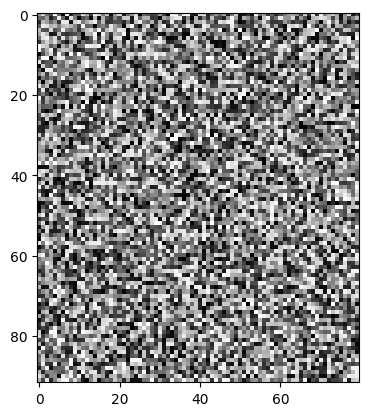

In [233]:
plt.imshow(img[25, :, :], 'gray', interpolation = 'none')


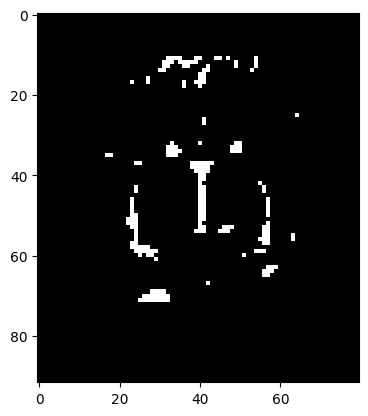

In [239]:
img = torch.rand((56, 92, 80))

img_final = np.multiply(np.array(img).astype(np.float32), mask_wm)
plt.imshow(img_final[25, :, :], 'gray', interpolation = 'none')

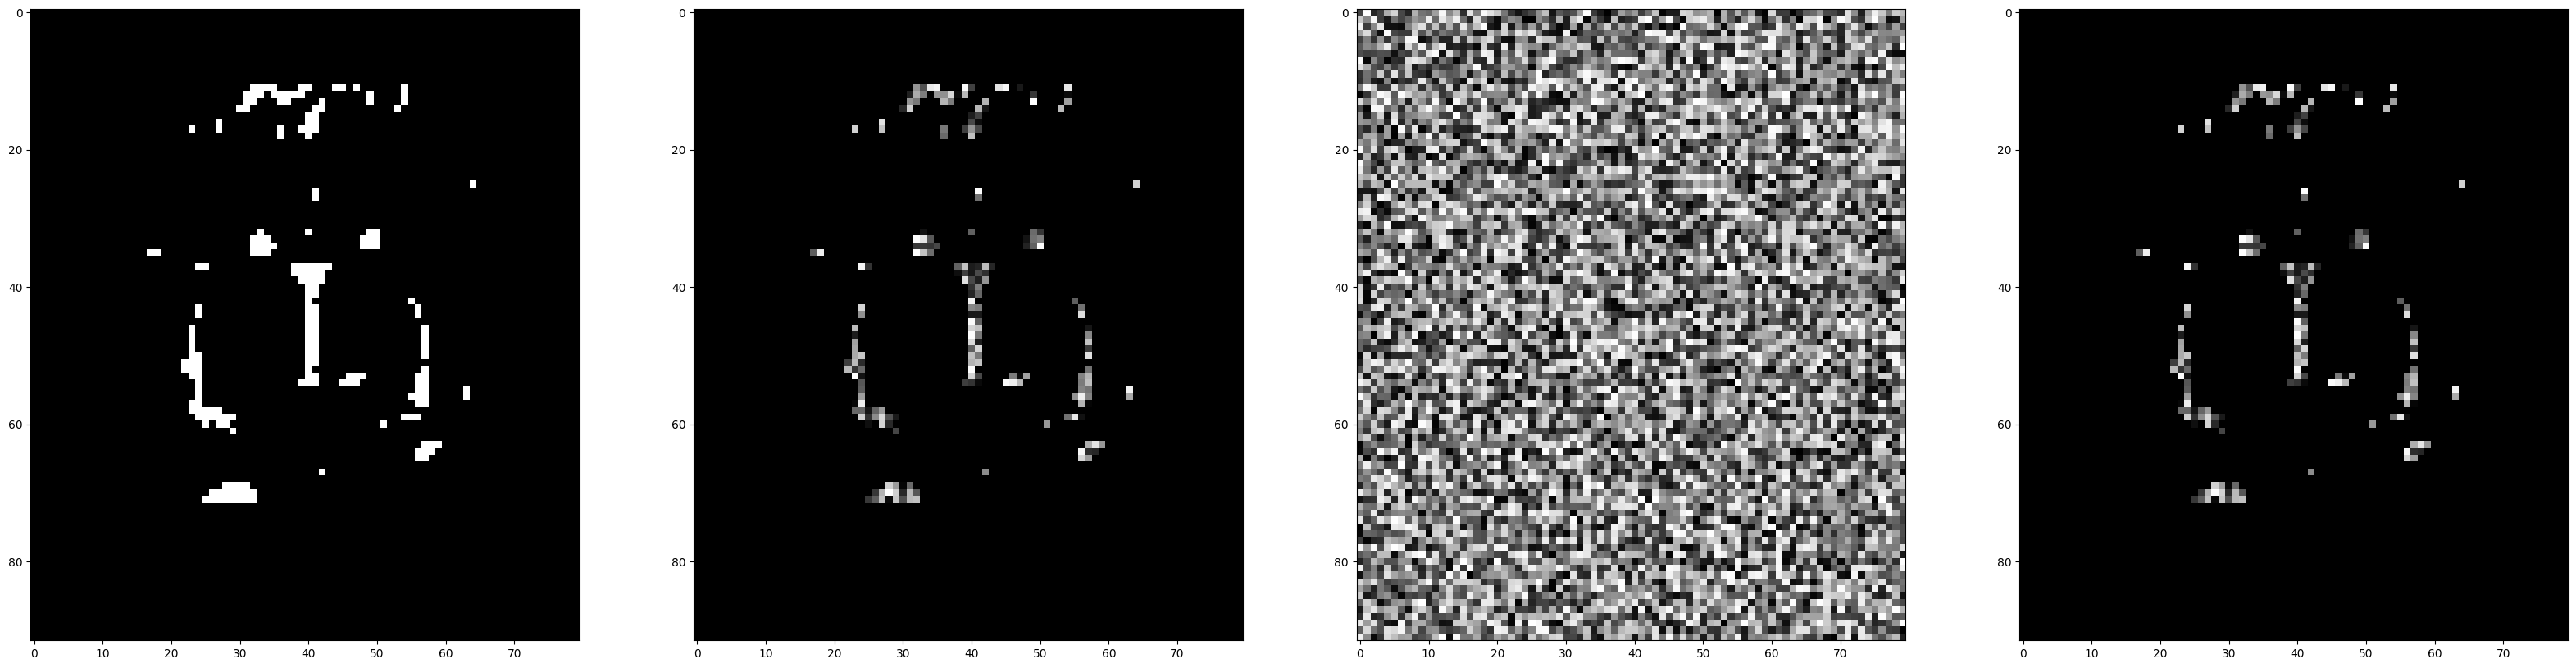

In [246]:
mask_wm_ = np.array(nib.load(os.path.join(settings.mask_folderpath, f'p14_csf.nii.gz')).dataobj).T.astype(int)
img = torch.rand((56, 92, 80))

plt.figure(figsize = (40, 10))
plt.subplot(1,4,1)
plt.imshow(mask_wm_[25, :, :], 'gray', interpolation = 'none')
mask_wm = np.ma.masked_array(mask_wm == 1, mask_wm)
plt.subplot(1,4,2)
plt.imshow(img[25, :, :], 'gray', interpolation = 'none')
plt.imshow(mask_wm[25, :, :], 'gray', interpolation = 'none')
plt.subplot(1,4,3)
plt.imshow(img[25, :, :], 'gray', interpolation = 'none')
plt.subplot(1,4,4)
img_final = np.multiply(mask_wm_, np.array(img))
plt.imshow(img_final[25, :, :], 'gray', interpolation = 'none')
